# 0.0 Imports 

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import xgboost as xgb

import math
import pickle
import random
import datetime
import warnings
import inflection


from scipy                 import stats  as ss
from boruta                import BorutaPy
from sklearn               import svm
from tabulate              import tabulate
from catboost              import CatBoostRegressor
from matplotlib            import pyplot as plt
from sklearn.metrics       import mean_absolute_percentage_error,mean_absolute_error, mean_squared_error
from IPython.display       import Image
from sklearn.ensemble      import RandomForestRegressor
from sklearn.neighbors     import KNeighborsRegressor
from sklearn.linear_model  import LinearRegression,Lasso
from IPython.core.display  import HTML
from sklearn.preprocessing import RobustScaler,MinMaxScaler,LabelEncoder


## 0.1 Loading Data

In [5]:
df_store_raw = pd.read_csv('Data/store.csv', low_memory = False )

df_train_raw = pd.read_csv('Data/train.csv' , low_memory = False )

#merge
df_raw = pd.merge( df_train_raw , df_store_raw, how = 'left', on='Store')

## 0.2 Helper Functions 

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
 
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20,10]
    plt.rcParams['font.size'] = 24
  
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
  
    sns.set()
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )
    
   

In [3]:
def mape2( y, yhat ):
    return np.mean( np.abs( (y - yhat) / y ) )

def mpe2( y, yhat ):
    return np.mean(  (y - yhat) / y ) 

def ml_error( model, y , yhat):
    mae  = np.round( mean_absolute_error( y , yhat) , 2 ) 
    mape = np.round( mape2( y , yhat ) , 2)
    rmse = np.round( np.sqrt( mean_squared_error(y , yhat ) ) , 2)
    mpe  = np.round( mpe2( y, yhat ) , 2 )
    
    return pd.DataFrame( {'Model Name': model,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse,
                          'MPE': mpe}, index=[0])
    
    

In [4]:
def get_model_performance(models, x_train,y_train,x_test,y_test):
    
    #create dataframe
    df_performance = pd.DataFrame()
    
    for model in models:
        
        print("Training " + type(model).__name__ + " ...")
        
        #fit model
        model.fit( x_train, y_train )
        
        #prediction
        yhat = model.predict( x_test )
        
        #performance
        df = ml_error(type(model).__name__ , np.expm1( y_test ), np.expm1( yhat ) )
        
        #concat
        df_performance = pd.concat( [df_performance, df ] )
        
        #reset index
        df_performance = df_performance.reset_index()
        
        # drops index
        df_performance.drop('index', axis=1, inplace=True)
        

        
    return df_performance, yhat


In [5]:
def models_cross_validation(models, x_training):
    
    df_performance = pd.DataFrame()
    
    for model in models:
    
        print("Training... " +type(model).__name__ + "..." )
        mae  = []
        mape = []
        rmse = []
        mpe = []
        for k in reversed(range(1 , 6 ) ):


            print("Iteration {}".format( k ))

            valid_start = x_training['date'].max() - datetime.timedelta( days = k*6*7)
            valid_end = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7)

            #filtering dataset
            training = x_training[x_training['date'] < valid_start]
            validation = x_training[ ( x_training['date'] >=valid_start ) & ( x_training['date'] <= valid_end ) ]

            #train and validation dataset
            #training
            xtrain = training.drop( ['date','sales'], axis=1 )
            ytrain = training['sales']

            #validation
            xvalid = validation.drop( [ 'date','sales'], axis=1)
            yvalid = validation['sales']

            #model
            model.fit( xtrain, ytrain )

            #predict
            yhat = model.predict( xvalid)

            #performance
            df = ml_error((type(model).__name__  + "  KFold: {}".format(k) ), np.expm1( yvalid ), np.expm1( yhat ) )
            
            mae.append( df['MAE'] )
            mape.append( df['MAPE'] )
            rmse.append( df['RMSE'] )
            mpe.append( df['MPE'] )
            #concat
            df_performance = pd.concat( [df_performance, df ] )

            #reset index
            df_performance = df_performance.reset_index()

            # drops index
            df_performance.drop('index', axis=1, inplace=True)
        
        mae_cv  = np.round( np.mean( mae ) , 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae ) , 2 ).astype( str )
        mape_cv = np.round( np.mean( mape ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape ) , 2 ).astype( str )
        rmse_cv = np.round( np.mean( rmse ), 2 ).astype( str ) + " +/- " + np.round( np.std( rmse ) , 2 ).astype( str )
        
        mpe_cv = np.round( np.mean( mpe ), 2 ).astype( str ) + " +/- " + np.round( np.std( mpe ) , 2 ).astype( str )
        
        df_cv =  pd.DataFrame( {
        'Model Name': ( type(model).__name__ + " - Cross-Validation "),    
        'MAE':mae_cv ,
        'MAPE':mape_cv  ,
        'RMSE':rmse_cv,
        'MPE': mpe_cv}
            , index=[0])
    
        #concat
        df_performance = pd.concat( [df_performance, df_cv ] )
        
        #reset index
        df_performance = df_performance.reset_index()

        # drops index
        df_performance.drop('index', axis=1, inplace=True)

    
    return df_performance


In [6]:
jupyter_settings()
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Populating the interactive namespace from numpy and matplotlib


/home/alexandremagno/.pyenv/versions/3.8.0/envs/rossmann_sales/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 1.0 Data Description

In [11]:
df1 = df_raw.copy()

## 1.1 Rename Columns 

In [12]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [13]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

df1.columns = cols_new

df1.columns


Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions 

In [14]:
print(" Number of rows {}".format( df1.shape[0] ) )
print(" Number of cols {}".format( df1.shape[1] ) )

 Number of rows 1017209
 Number of cols 18


## 1.3 Data Types 

In [15]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

Let's change the date variable to the datetime type

In [16]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [17]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In **competition distance** I will assume that for NA values it is because there is no competitor around so I will put a much higher value than the maximum.


In [18]:
# competition_distance              
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'] , axis =1 )


# competition_open_since_year     

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'] , axis =1 )

#promo2_since_week                               
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'] , axis =1 )

# promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'] , axis =1 )

# promo_interval                  
month_map = {1:  'Jan', 2:  'Feb',3:  'Mar', 4:  'Apr', 5:  'May', 6:  'Jun', 7:  'Jul', 8:  'Aug', 9:  'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'} 

df1['promo_interval'].fillna(0 , inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x ['promo_interval'].split( ',' ) else 0 , axis = 1 )






In [19]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

As observed, we treat all NA in dataset

## 1.6 Change Types 

In [20]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )



## 1.7 Descriptive Statistical 

In [21]:
num_att = df1.select_dtypes( include = ['int64' , 'float64'] )
cat_att = df1.select_dtypes( exclude = ['int64' , 'float64', 'datetime64[ns]'] )


### 1.7.1 Numerical Attributes 

In [22]:
#central tendency - mean, meadian

ct1 = pd.DataFrame( num_att.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_att.apply( np.median ) ).T

#Dispersion -std, min , max , range , skew ,kurtosis
d1 = pd.DataFrame( num_att.apply( np.std ) ).T
d2 = pd.DataFrame( num_att.apply( min ) ).T
d3 = pd.DataFrame( num_att.apply( max ) ).T
d4 = pd.DataFrame( num_att.apply( lambda x : x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_att.apply( lambda x : x.skew() ) ).T
d6 = pd.DataFrame( num_att.apply( lambda x : x.kurtosis() ) ).T


#concat
m = pd.concat( [d2 , d3 , d4,ct1 , ct2 ,d1,d5 ,d6]).T.reset_index()
m.columns = ['attributes' , 'min' , 'max' , 'range' ,'mean' ,'median' , 'std', 'skew' , 'kurtosis']

m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


### 1.7.2 Categorical Attributes 

In [23]:
cat_att.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

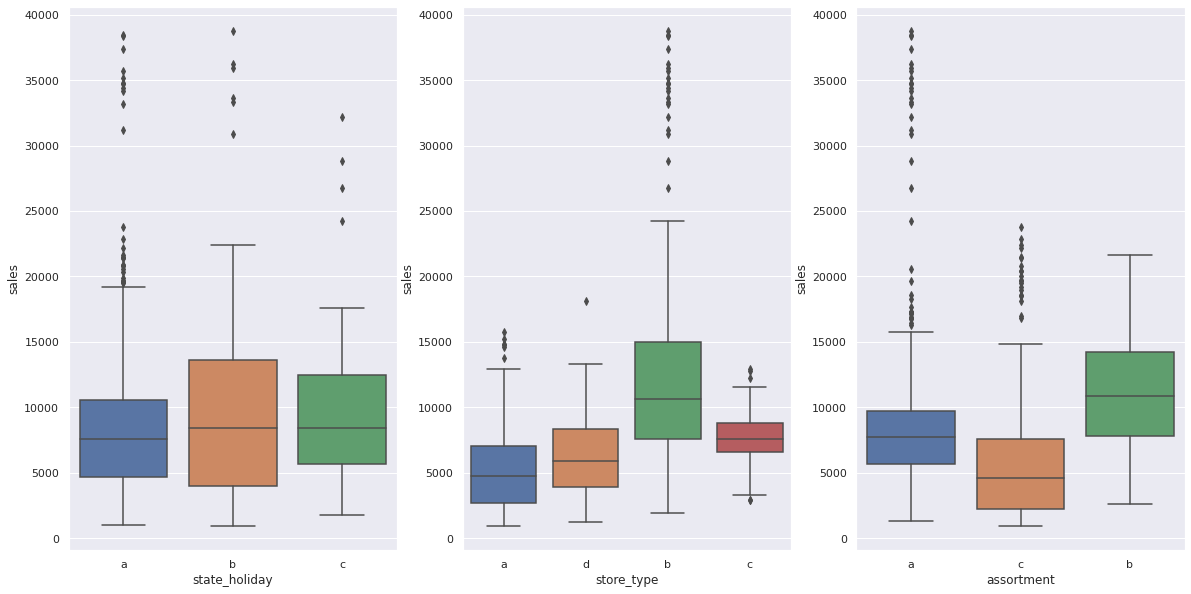

In [24]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0 ) ]

plt.subplot(1 , 3 ,1)
sns.boxplot( x='state_holiday' , y = 'sales' ,data = aux1)

plt.subplot(1 , 3 ,2)
sns.boxplot( x='store_type' , y = 'sales' ,data = aux1)


plt.subplot(1 , 3 ,3)
sns.boxplot( x='assortment' , y = 'sales' ,data = aux1)

**Store Type** = B has the highest median sales and **assortment** = b as well 

# 2.0 Feature Engineering 

In [25]:
df2 = df1.copy()

## 2.1 Mind Map 

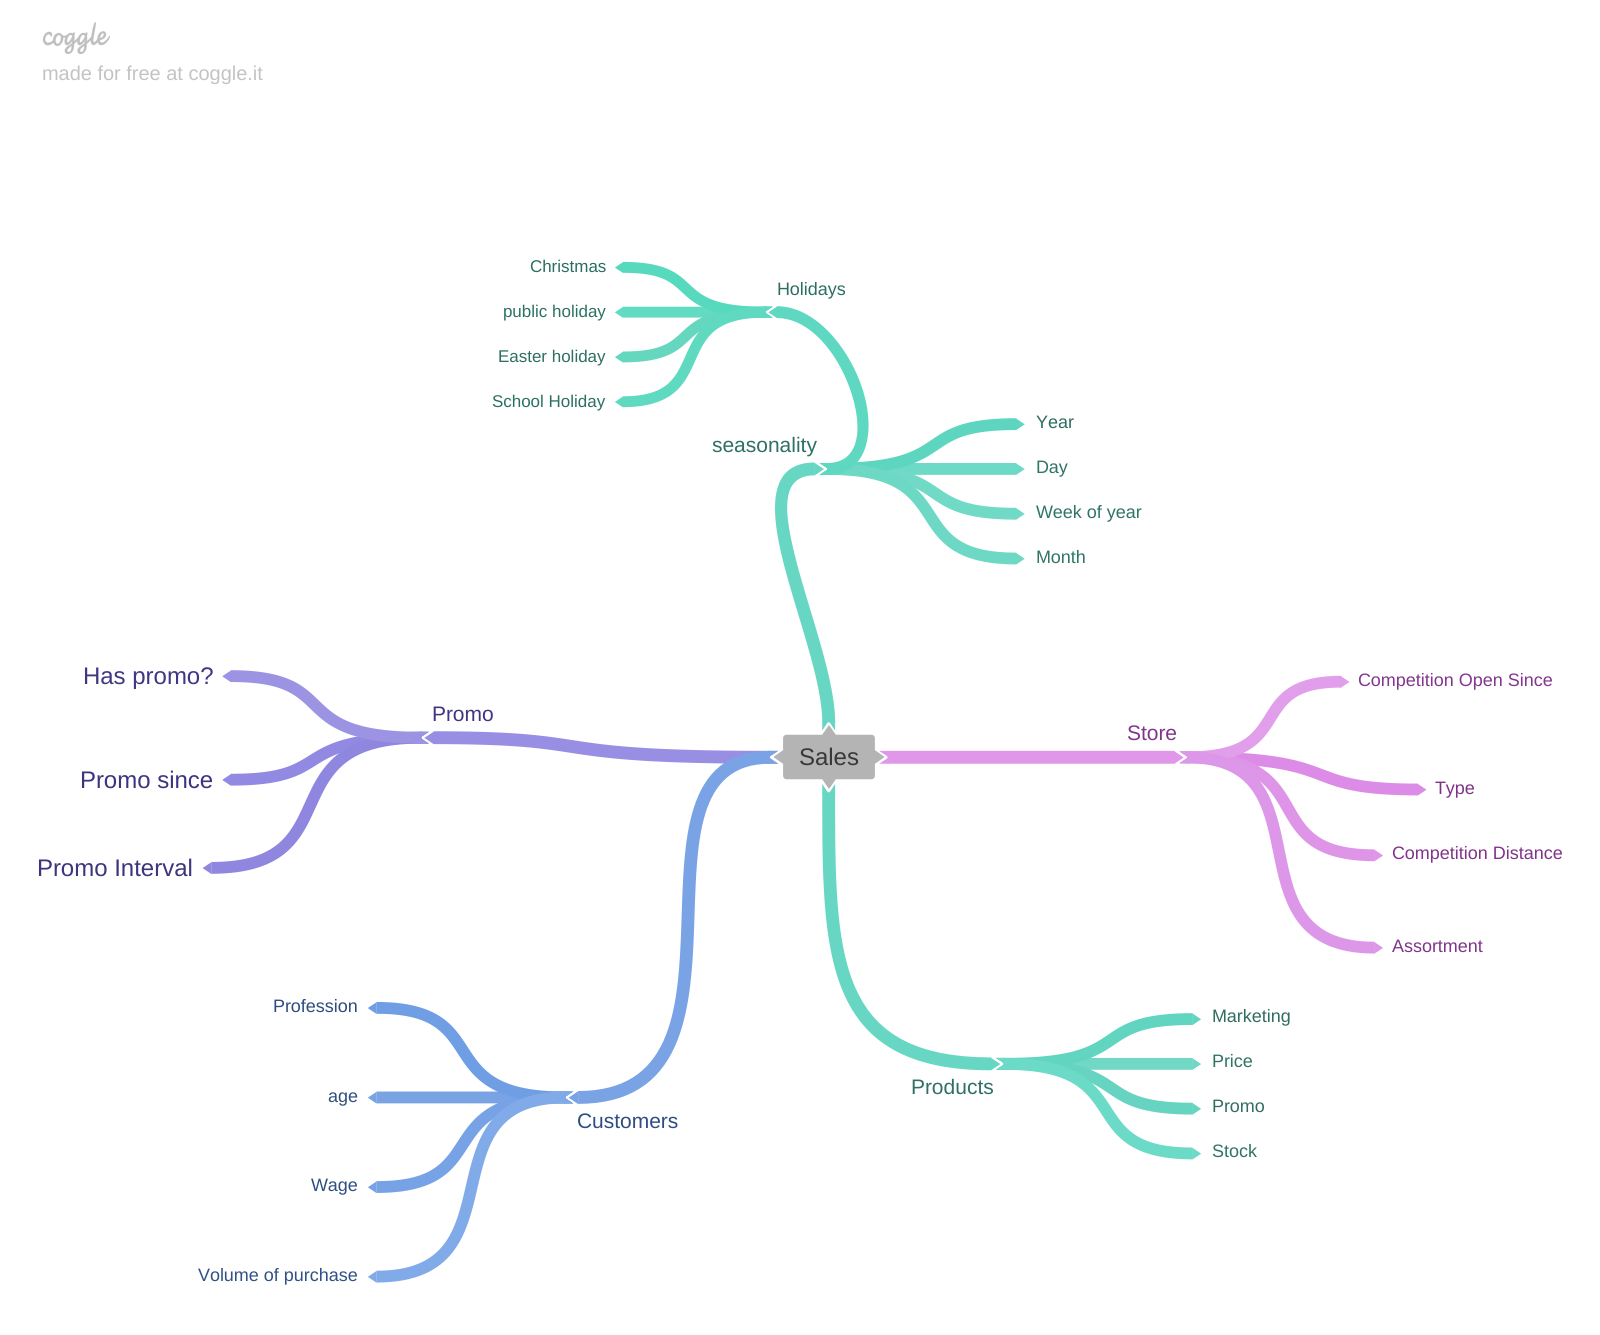

In [116]:

Image(filename='img/Sales.png')

## 2.2 Creating Hypotheses

### 2.2.1 Store Hypotheses

**1.** Stores with a larger number of employees should sell more.

**2.** Stores with a higher inventory capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.


**5.** Stores with closer competitors should sell less.

**6.** Stores with longer competitors should sell more.

### 2.2.2 Product Hypotheses

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores with greater product exposure should sell more.

**3.** Stores with lower priced products should sell more.

**5.** Stores with more aggressive promotions (bigger discounts), should sell more.

**6.** Stores with active promotions for longer should sell more.

**7.** Stores with more promotion days should sell more.

**8.** Stores with more consecutive promotions should sell more

### 2.2.1 Seasonality Hypotheses

**1.**Stores open during the Christmas holiday should sell more.

**2.**Stores should sell more over the years.

**3.**Stores should sell more in the second half of the year.

**4.**Stores should sell more after the 10th of each month.

**5.**Stores should sell less on weekends.

**6.**Stores should sell less during school holidays.

## 2.3 Final list of hypotheses

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with active promotions for longer should sell more.

**5.** Stores with more days of promotion should sell more.

**6.** Stores with more consecutive promotions should sell more.




**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10**. Stores should sell more after the 10th of each month.

**11**. Stores should sell less on weekends.

**12**. Stores should sell less during school holidays.

## 2.4 Feature Engineering

In [26]:
#year
df2['year'] = df2['date'].dt.year
#month

df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

#promo since
df2['promo_since']     = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since']     = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 )  )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

#assortment 
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday

df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )




# 3.0 Data Filtering

In [27]:
df3 = df2.copy()

## 3.1 Rows Filtering  

In [28]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]


## 3.2 Columns Filtering  

In [29]:
cols_drop = ['customers', 'open', 'month_map' , 'promo_interval']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 Exploratory Data Analysis 

In [30]:
df4 = df3.copy()

## 4.1  Univariate Analysis

### 4.1.1 Response Variable 

In [ ]:
sns.distplot( df4['sales'] );

### 4.1.2 Numerical Variable 

In [ ]:
num_att.hist( bins = 30 );

### 4.1.3 Categorical Variable 

In [ ]:
#state holiday
plt.subplot( 3, 2, 1 ) 
aux413 = df4[df4['state_holiday'] != 'regular_day' ]
sns.countplot( aux413['state_holiday'] );

plt.subplot( 3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday',shade = True )
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday',shade = True )
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas',shade = True );


#state holiday
plt.subplot( 3, 2, 3 ) 
sns.countplot( aux413['store_type'] );



plt.subplot( 3, 2, 4 )
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a',shade = True )
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b',shade = True )
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c',shade = True )
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd' ,shade = True )

#state holiday
plt.subplot( 3, 2, 5 )
sns.countplot( aux413['assortment'] );



plt.subplot( 3, 2, 6 )
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended',shade = True )
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic',shade = True )
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra',shade = True );



## 4.2  Bivariate Analysis

### **H1.** Stores with a larger assortment should sell more on average.
###  **True**


In [ ]:
auxh1 = df4[['assortment','sales']].groupby( 'assortment' ).median().reset_index()

sns.barplot(x='assortment' , y= 'sales', data= auxh1 );


### **H2.** Stores with closer competitors should sell less.
### **False**



In [ ]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H3.** Stores with longer competitors should sell more.
### **False**


In [ ]:
aux3 = df4[['competition_time_month','sales']].groupby( 'competition_time_month').sum().reset_index()
aux4 = aux3[( aux3['competition_time_month'] < 120 ) & (aux3['competition_time_month'] != 0 )]
sns.barplot( x = 'competition_time_month', y='sales', data=aux4 );
plt.xticks(rotation= 90);



In [ ]:
plt.figure( figsize=(12,12))
sns.heatmap( aux3.corr(method='pearson'), annot=True );

### **H4.** Stores with active promotions for longer should sell more.
### **False**


In [ ]:
aux4 = df4[['promo_time_week','sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = GridSpec(2,2)
plt.subplot( grid[0,0] )
#extended promotion
aux2 = aux4[aux4['promo_time_week'] > 0 ]
sns.barplot( x='promo_time_week' , y='sales', data=aux2);

plt.subplot( grid[1,0] )
#regular promotion
aux3 = aux4[aux4['promo_time_week'] < 0 ]
sns.barplot( x='promo_time_week' , y='sales', data=aux3);

plt.subplot( grid[:, 1 ]  )

sns.heatmap(aux4.corr(method='pearson'), annot=True);

### **H5.** Stores with more consecutive promotions should sell more.
### False

In [ ]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### **H6.** Stores open during the Christmas holiday should sell more.
### **False**


In [ ]:
aux7 = df4[['state_holiday','sales']].groupby( 'state_holiday' ).mean().reset_index()
aux8 = aux7[aux7['state_holiday'] != 'regular_day']

sns.barplot(x='state_holiday', y='sales' ,data=aux8);


### **H7.** Stores should sell more over the years.
### **False**

In [ ]:
aux8 = df4[['sales','year']].groupby('year').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='year', y='sales', data=aux8);
plt.subplot(1,2,2)
sns.heatmap(aux8.corr(method='pearson'), annot=True );


### **H8.** Stores should sell more in the second half of the year.
### **True**

In [ ]:
aux9 = df4[df4['year'] != 2015 ]

aux8 = aux9[['sales','month']].groupby('month').sum().reset_index()
plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux8);
plt.subplot(1,3,3)
sns.heatmap(aux8.corr(method='pearson'), annot=True );

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux8);

### **H9**. Stores should sell more after the 10th of each month.
 ### **True**




In [ ]:

aux8 = df4[['sales','day']].groupby('day').sum().reset_index()
plt.subplot(1,3,2)

sns.regplot(x='day', y='sales', data=aux8);

plt.subplot(1,3,3)

sns.heatmap(aux8.corr(method='pearson'), annot=True );

plt.subplot(1,3,1)

aux8['before_after'] = aux8['day'].apply( lambda x: 'before_10' if x <=10 else 'after_10')

aux9 = aux8[['before_after','sales']].groupby('before_after').sum().reset_index()

sns.barplot(x='before_after', y='sales', data=aux9);

### **H10**. Stores should sell less on weekends on average.
###  Sells a lot **less** on **Saturday** but **sells a lot on Sunday**


In [ ]:

aux8 = df4[['sales','day_of_week']].groupby('day_of_week').mean().reset_index()
plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux8);
plt.subplot(1,3,3)
sns.heatmap(aux8.corr(method='pearson'), annot=True );

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux8);

### **H11**. Stores should sell less  on average during school holidays 
### **False** except in December

In [ ]:

aux8 = df4[['sales','school_holiday']].groupby('school_holiday').mean().reset_index()
aux9 = df4[['sales','month','school_holiday']].groupby(['month','school_holiday']).mean().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', hue='school_holiday', y='sales', data=aux9);

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux8);

### 4.2.1 Summary of Hypotheses

In [ ]:
tab=[
    ['H1','True' ,'High'],
    ['H2','False','Medium'],
    ['H3','False','Low'],
    ['H4','False','Low'],
    ['H5','False','Low'],
    ['H6','False','Low'],
    ['H7','False','High'],
    ['H8','True','Medium'],
    ['H9','True','Medium'],
    ['H10','False','Medium'],
    ['H11','False','Low'],
    ]
#a = tabulate(tab, headers='firstrow')
b = pd.DataFrame(data= tab, columns=['Hypotheses','Conclusion','Relevance'])
b


## 4.3  Multivariate Analysis

###  4.3.1 Numerical Attributes

In [ ]:
corr = num_att.corr(method='pearson')
sns.heatmap(corr, annot=True)

### 4.3.2 Categorical Attributes 

In [ ]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0 Data Preparation

In [31]:
df5 = df4.copy()

## 5.1 Select Features

In [32]:
aux51 = df5.select_dtypes( include=['int64','float64'])
aux51.sample(3)

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
244576,860,2,12728,0,1,5980.00,2,2010,0,52,2014,0,2014,12,23,52,59,0
144062,228,2,5897,0,0,10800.00,3,2015,1,18,2011,0,2015,3,24,13,0,204
873131,872,5,10198,0,0,3860.00,9,2014,1,23,2015,0,2013,5,10,19,-16,-108


Features selected for **Rescaling**:
   - competition distance
   - year
   - competition time month
   - promo time week

Features selected for **Transformation**:
   - Month
   - Day
   - Week of year
   - Day of week

## 5.2 Rescaling 

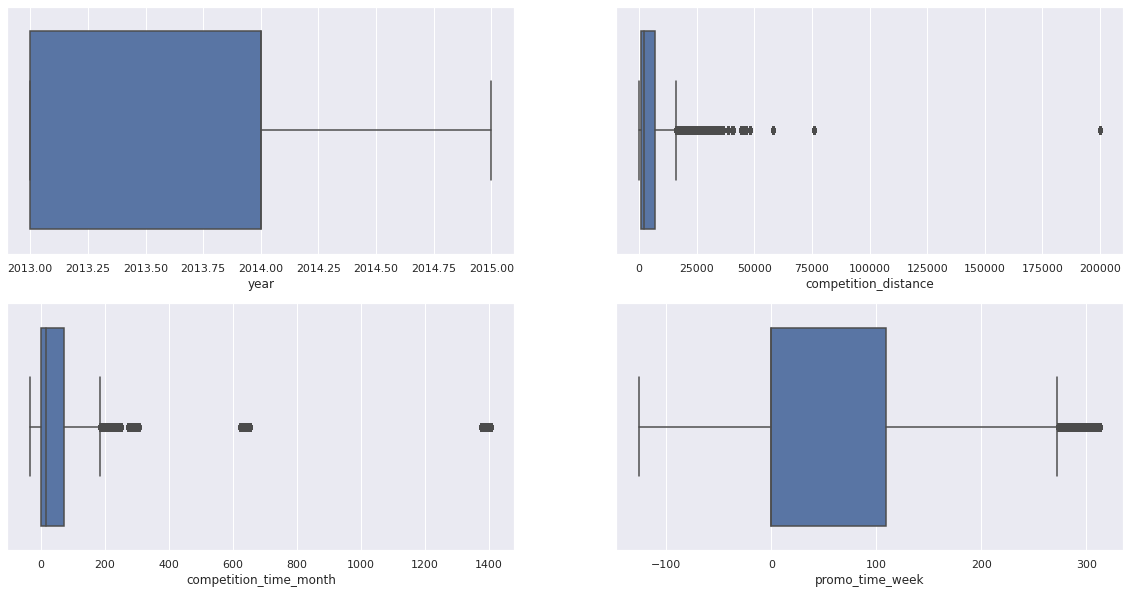

In [33]:
plt.subplot(2,2,1)
sns.boxplot(df5['year']);

plt.subplot(2,2,2)
sns.boxplot(df5['competition_distance']);


plt.subplot(2,2,3)
sns.boxplot(df5['competition_time_month']);

plt.subplot(2,2,4)
sns.boxplot(df5['promo_time_week']);

**Rosbust Scaler**:
    
   - Competition Distance
   - Competition time month

**Min Max Scaler**:
   - promo time week
   - year

In [34]:
#instantiate scalers
rs = RobustScaler()
mms = MinMaxScaler()

#Competition Distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open('parameter/competition_distance' , 'wb' )  )

#Competition Time Month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

pickle.dump( rs, open('parameter/competition_time_month' , 'wb' )  )

#Promo Time Week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

pickle.dump( mms, open('parameter/promo_time_week' , 'wb' )  )

#Year
df5['year'] = mms.fit_transform( df5[['year']].values )

pickle.dump( mms, open('parameter/year_scaler' , 'wb' )  )

## 5.3 Transformation

### 5.3.1 Encoding 

In [35]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

#store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open('parameter/store_type' , 'wb' )  )

#assortment - Ordinal Encoding
assort = {'basic': 1, 'extra':2 , 'extended':3 }
df5['assortment'] = df5['assortment'].map( assort )



### 5.3.2 Response Variable 

In [37]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3 Nature Transformation 

In [38]:
#month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x *( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x *( 2. * np.pi/12 ) ) )


#day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x *( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x *( 2. * np.pi/30 ) ) )

#week of year'

df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x *( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x *( 2. * np.pi/52 ) ) )
# day of week

df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x *( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x *( 2. * np.pi/7 ) ) )


# 6.0 Feature Selection 

## 6.1 CheckPoint

In [11]:
#df5.to_csv('Data/df_checkpoint.csv')
df6 = pd.read_csv('Data/df_checkpoint.csv')
#df6 = df5.copy()

df6['date'] = pd.to_datetime( df6['date'] )

## 6.2 Split training and test 

In [12]:
cols_drop = ['week_of_year' , 'day' , 'month' , 'day_of_week' ,'promo_since' ,'competition_since', 'year_week']
df6 = df6.drop( cols_drop ,axis=1)

In [13]:
#train dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']


#train dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Train min date {}'.format(  x_train['date'].min() ) )                                                          
print( 'Train max date {}'.format(  x_train['date'].max() ) )

print( '\ntest min date {}'.format(  X_test['date'].min() ) )
print( 'test max date {}'.format(  X_test['date'].max() ) )

Train min date 2013-01-01 00:00:00
Train max date 2015-06-18 00:00:00

test min date 2015-06-19 00:00:00
test max date 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

## 6.3 Manual Feature Selection

In [14]:
cols = ['store',
        'promo',
        'store_type',
        'assortment',
        'competition_distance',
        'competition_open_since_month',
        'competition_open_since_year',
        'promo2',
        'promo2_since_week',
        'promo2_since_year',
        'competition_time_month',
        'promo_time_week',
        'month_cos',
        'day_sin',
        'day_cos',
        'week_of_year_cos',
        'day_of_week_sin',
        'day_of_week_cos']

#features removed on cycle 2 = year
#columns to add
feat = ['date','sales']
cols_full = cols.copy()
cols_full.extend( feat )


# 7.0 Machine Learning

In [15]:
#data set cross validation
x_training = x_train[cols_full ]

#dataset
x_train = x_train[ cols ]
x_test = X_test[cols]


## 7.1 Base Line - Average Model

In [47]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby( 'store' ).mean().reset_index().rename( columns={ 'sales': 'predictions'} )
aux1 = pd.merge( aux1 , aux2 ,  how='left', on='store')
yhat_baseline = aux1['predictions']

#perfomance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result


,Model Name,MAE,MAPE,RMSE,MPE
0,Average Model,1354.80,0.21,1835.14,-0.03


## 7.2 Machine Learning Models 

In [48]:
#define models
lr  = LinearRegression( )
lrr = Lasso( alpha=0.01 )
rf  = RandomForestRegressor( n_estimators = 20, n_jobs=-1, random_state = 42) 
knr = KNeighborsRegressor( n_neighbors = 2)
cat = CatBoostRegressor(verbose=False)

models= [lr , lrr, rf ,  knr,  cat]
#prediction
df_performance , yhat = get_model_performance(models, x_train, y_train, x_test, y_test )
df_performance = pd.concat([df_performance ,  baseline_result ]).reset_index().drop( 'index', axis=1)





Training LinearRegression ...
Training Lasso ...
Training RandomForestRegressor ...
Training KNeighborsRegressor ...
Training CatBoostRegressor ...


## 7.3 Compare Model's Performance 

In [49]:
df_performance.style.highlight_min(color='yellow')

,Model Name,MAE,MAPE,RMSE,MPE
0,LinearRegression,1869.920000,0.300000,2667.520000,-0.090000
1,Lasso,1891.190000,0.290000,2741.000000,-0.060000
2,RandomForestRegressor,740.770000,0.110000,1089.200000,-0.040000
3,KNeighborsRegressor,771.780000,0.120000,1134.570000,-0.010000
4,CatBoostRegressor,818.130000,0.120000,1162.030000,-0.030000
5,Average Model,1354.800000,0.210000,1835.140000,-0.030000


## 7.4 Cross Validation 

In [50]:
#models

models = [ lr ,lrr, rf , knr, cat ]
#prediction
df = models_cross_validation(models, x_training  )

Training... LinearRegression...
Iteration 5
Iteration 4
Iteration 3
Iteration 2
Iteration 1
Training... Lasso...
Iteration 5
Iteration 4
Iteration 3
Iteration 2
Iteration 1
Training... RandomForestRegressor...
Iteration 5
Iteration 4
Iteration 3
Iteration 2
Iteration 1
Training... KNeighborsRegressor...
Iteration 5
Iteration 4
Iteration 3
Iteration 2
Iteration 1
Training... CatBoostRegressor...
Iteration 5
Iteration 4
Iteration 3
Iteration 2
Iteration 1


## 7.5 Cross Validation Performance

In [51]:
df

,Model Name,MAE,MAPE,RMSE,MPE
0,LinearRegression KFold: 5,2654.81,0.31,3834.19,0.05
1,LinearRegression KFold: 4,1884.43,0.32,2565.78,-0.16
2,LinearRegression KFold: 3,1795.06,0.3,2532.21,-0.09
3,LinearRegression KFold: 2,2078.7,0.28,3027.31,-0.02
4,LinearRegression KFold: 1,1983.42,0.28,2845.85,-0.03
5,LinearRegression - Cross-Validation,2079.28 +/- 303.04,0.3 +/- 0.02,2961.07 +/- 473.32,-0.05 +/- 0.07
6,Lasso KFold: 5,2752.8,0.31,3978.23,0.08
7,Lasso KFold: 4,1846.35,0.29,2631.48,-0.07
8,Lasso KFold: 3,1808.66,0.29,2596.6,-0.05
9,Lasso KFold: 2,2162.07,0.28,3170.67,0.01


As observed, **Random Forest Regressor** has lower **RMSE**, but for the sake of computational effort we will proceed with **CatBoostRegressor**

# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search 

In [55]:

iterations = [ 1000, 1500, 2000, 2500, 3000, 3500 , 4000 ]


depth = [2, 4 ,6 ,8 ]

learning_rate = [0.03, 0.06 , 0.1 ]

rsm = [0.1, 0.3 , 0.5, 0.7 ,0.9 ]

l2_leaf_reg = [ 1, 3, 5, 7 ]


grid = {
        'depth': depth,
        'iterations' : iterations,
        'learning_rate': learning_rate,
        'rsm': rsm,
        'l2_leaf_reg': l2_leaf_reg
}



In [57]:
#define model
cat = CatBoostRegressor()

cat.randomized_search( grid,
                       X=x_train,
                       y=y_train,
                       plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 8.5058205	test: 8.5024416	best: 8.5024416 (0)	total: 89.8ms	remaining: 5m 59s
1:	learn: 8.2512859	test: 8.2479184	best: 8.2479184 (1)	total: 151ms	remaining: 5m 2s
2:	learn: 8.0044155	test: 8.0010503	best: 8.0010503 (2)	total: 194ms	remaining: 4m 18s
3:	learn: 7.7649611	test: 7.7615996	best: 7.7615996 (3)	total: 261ms	remaining: 4m 21s
4:	learn: 7.5327093	test: 7.5293552	best: 7.5293552 (4)	total: 370ms	remaining: 4m 55s
5:	learn: 7.3074479	test: 7.3040955	best: 7.3040955 (5)	total: 473ms	remaining: 5m 14s
6:	learn: 7.0889761	test: 7.0856254	best: 7.0856254 (6)	total: 585ms	remaining: 5m 33s
7:	learn: 6.8770803	test: 6.8737344	best: 6.8737344 (7)	total: 680ms	remaining: 5m 39s
8:	learn: 6.6715668	test: 6.6682236	best: 6.6682236 (8)	total: 746ms	remaining: 5m 30s
9:	learn: 6.4722418	test: 6.4689022	best: 6.4689022 (9)	total: 824ms	remaining: 5m 28s
10:	learn: 6.2789233	test: 6.2755865	best: 6.2755865 (10)	total: 914ms	remaining: 5m 31s
11:	learn: 6.0914299	test: 6.0880952	best

94:	learn: 0.6285607	test: 0.6268108	best: 0.6268108 (94)	total: 7.65s	remaining: 5m 14s
95:	learn: 0.6173336	test: 0.6156247	best: 0.6156247 (95)	total: 7.72s	remaining: 5m 14s
96:	learn: 0.6065443	test: 0.6048830	best: 0.6048830 (96)	total: 7.82s	remaining: 5m 14s
97:	learn: 0.5963073	test: 0.5946894	best: 0.5946894 (97)	total: 7.9s	remaining: 5m 14s
98:	learn: 0.5863799	test: 0.5848070	best: 0.5848070 (98)	total: 8s	remaining: 5m 15s
99:	learn: 0.5770155	test: 0.5754864	best: 0.5754864 (99)	total: 8.08s	remaining: 5m 15s
100:	learn: 0.5678483	test: 0.5663667	best: 0.5663667 (100)	total: 8.18s	remaining: 5m 15s
101:	learn: 0.5585782	test: 0.5571374	best: 0.5571374 (101)	total: 8.28s	remaining: 5m 16s
102:	learn: 0.5503491	test: 0.5489513	best: 0.5489513 (102)	total: 8.41s	remaining: 5m 18s
103:	learn: 0.5417933	test: 0.5404344	best: 0.5404344 (103)	total: 8.49s	remaining: 5m 18s
104:	learn: 0.5342446	test: 0.5329297	best: 0.5329297 (104)	total: 8.6s	remaining: 5m 18s
105:	learn: 0.52

185:	learn: 0.3837645	test: 0.3843644	best: 0.3843644 (185)	total: 18.1s	remaining: 6m 11s
186:	learn: 0.3835724	test: 0.3841763	best: 0.3841763 (186)	total: 18.3s	remaining: 6m 12s
187:	learn: 0.3833515	test: 0.3839611	best: 0.3839611 (187)	total: 18.4s	remaining: 6m 13s
188:	learn: 0.3832887	test: 0.3839047	best: 0.3839047 (188)	total: 18.5s	remaining: 6m 13s
189:	learn: 0.3830441	test: 0.3836643	best: 0.3836643 (189)	total: 18.7s	remaining: 6m 14s
190:	learn: 0.3829045	test: 0.3835321	best: 0.3835321 (190)	total: 18.8s	remaining: 6m 15s
191:	learn: 0.3823358	test: 0.3829593	best: 0.3829593 (191)	total: 19s	remaining: 6m 16s
192:	learn: 0.3817961	test: 0.3824161	best: 0.3824161 (192)	total: 19.1s	remaining: 6m 17s
193:	learn: 0.3816590	test: 0.3822857	best: 0.3822857 (193)	total: 19.3s	remaining: 6m 18s
194:	learn: 0.3815992	test: 0.3822317	best: 0.3822317 (194)	total: 19.4s	remaining: 6m 18s
195:	learn: 0.3815068	test: 0.3821426	best: 0.3821426 (195)	total: 19.5s	remaining: 6m 19s
1

276:	learn: 0.3732060	test: 0.3739056	best: 0.3739056 (276)	total: 28.2s	remaining: 6m 19s
277:	learn: 0.3731571	test: 0.3738559	best: 0.3738559 (277)	total: 28.3s	remaining: 6m 19s
278:	learn: 0.3731196	test: 0.3738154	best: 0.3738154 (278)	total: 28.4s	remaining: 6m 19s
279:	learn: 0.3730181	test: 0.3737135	best: 0.3737135 (279)	total: 28.5s	remaining: 6m 19s
280:	learn: 0.3729544	test: 0.3736497	best: 0.3736497 (280)	total: 28.6s	remaining: 6m 19s
281:	learn: 0.3726886	test: 0.3733749	best: 0.3733749 (281)	total: 28.7s	remaining: 6m 18s
282:	learn: 0.3724044	test: 0.3730826	best: 0.3730826 (282)	total: 28.8s	remaining: 6m 18s
283:	learn: 0.3723755	test: 0.3730528	best: 0.3730528 (283)	total: 28.9s	remaining: 6m 18s
284:	learn: 0.3721028	test: 0.3727710	best: 0.3727710 (284)	total: 29s	remaining: 6m 18s
285:	learn: 0.3720465	test: 0.3727130	best: 0.3727130 (285)	total: 29.1s	remaining: 6m 18s
286:	learn: 0.3719700	test: 0.3726306	best: 0.3726306 (286)	total: 29.2s	remaining: 6m 18s
2

368:	learn: 0.3661749	test: 0.3667546	best: 0.3667546 (368)	total: 37.6s	remaining: 6m 10s
369:	learn: 0.3660860	test: 0.3666695	best: 0.3666695 (369)	total: 37.7s	remaining: 6m 10s
370:	learn: 0.3659584	test: 0.3665369	best: 0.3665369 (370)	total: 37.8s	remaining: 6m 9s
371:	learn: 0.3658747	test: 0.3664535	best: 0.3664535 (371)	total: 37.9s	remaining: 6m 9s
372:	learn: 0.3657934	test: 0.3663685	best: 0.3663685 (372)	total: 37.9s	remaining: 6m 9s
373:	learn: 0.3657636	test: 0.3663402	best: 0.3663402 (373)	total: 38s	remaining: 6m 8s
374:	learn: 0.3657341	test: 0.3663132	best: 0.3663132 (374)	total: 38.1s	remaining: 6m 8s
375:	learn: 0.3656247	test: 0.3661979	best: 0.3661979 (375)	total: 38.2s	remaining: 6m 7s
376:	learn: 0.3655142	test: 0.3660851	best: 0.3660851 (376)	total: 38.2s	remaining: 6m 7s
377:	learn: 0.3654812	test: 0.3660497	best: 0.3660497 (377)	total: 38.3s	remaining: 6m 7s
378:	learn: 0.3654369	test: 0.3660028	best: 0.3660028 (378)	total: 38.4s	remaining: 6m 6s
379:	learn

459:	learn: 0.3619687	test: 0.3624403	best: 0.3624403 (459)	total: 45.6s	remaining: 5m 51s
460:	learn: 0.3619309	test: 0.3624018	best: 0.3624018 (460)	total: 45.7s	remaining: 5m 51s
461:	learn: 0.3618576	test: 0.3623288	best: 0.3623288 (461)	total: 45.8s	remaining: 5m 50s
462:	learn: 0.3618228	test: 0.3622906	best: 0.3622906 (462)	total: 45.9s	remaining: 5m 50s
463:	learn: 0.3617878	test: 0.3622551	best: 0.3622551 (463)	total: 46s	remaining: 5m 50s
464:	learn: 0.3617878	test: 0.3622551	best: 0.3622551 (463)	total: 46.1s	remaining: 5m 50s
465:	learn: 0.3617878	test: 0.3622551	best: 0.3622551 (463)	total: 46.2s	remaining: 5m 50s
466:	learn: 0.3617769	test: 0.3622448	best: 0.3622448 (466)	total: 46.3s	remaining: 5m 50s
467:	learn: 0.3617354	test: 0.3622018	best: 0.3622018 (467)	total: 46.5s	remaining: 5m 50s
468:	learn: 0.3617354	test: 0.3622018	best: 0.3622018 (467)	total: 46.5s	remaining: 5m 50s
469:	learn: 0.3617250	test: 0.3621919	best: 0.3621919 (469)	total: 46.7s	remaining: 5m 50s
4

550:	learn: 0.3596372	test: 0.3600651	best: 0.3600651 (549)	total: 54.6s	remaining: 5m 41s
551:	learn: 0.3596156	test: 0.3600455	best: 0.3600455 (551)	total: 54.7s	remaining: 5m 41s
552:	learn: 0.3595696	test: 0.3599997	best: 0.3599997 (552)	total: 54.8s	remaining: 5m 41s
553:	learn: 0.3595643	test: 0.3599934	best: 0.3599934 (553)	total: 54.9s	remaining: 5m 41s
554:	learn: 0.3595460	test: 0.3599750	best: 0.3599750 (554)	total: 55s	remaining: 5m 41s
555:	learn: 0.3595222	test: 0.3599526	best: 0.3599526 (555)	total: 55.2s	remaining: 5m 41s
556:	learn: 0.3594994	test: 0.3599265	best: 0.3599265 (556)	total: 55.3s	remaining: 5m 41s
557:	learn: 0.3594636	test: 0.3598906	best: 0.3598906 (557)	total: 55.4s	remaining: 5m 41s
558:	learn: 0.3594207	test: 0.3598468	best: 0.3598468 (558)	total: 55.6s	remaining: 5m 41s
559:	learn: 0.3594068	test: 0.3598312	best: 0.3598312 (559)	total: 55.7s	remaining: 5m 41s
560:	learn: 0.3593975	test: 0.3598222	best: 0.3598222 (560)	total: 55.8s	remaining: 5m 41s
5

641:	learn: 0.3576217	test: 0.3579997	best: 0.3579997 (641)	total: 1m 4s	remaining: 5m 37s
642:	learn: 0.3576047	test: 0.3579810	best: 0.3579810 (642)	total: 1m 4s	remaining: 5m 37s
643:	learn: 0.3575794	test: 0.3579560	best: 0.3579560 (643)	total: 1m 4s	remaining: 5m 36s
644:	learn: 0.3575719	test: 0.3579469	best: 0.3579469 (644)	total: 1m 4s	remaining: 5m 36s
645:	learn: 0.3575402	test: 0.3579171	best: 0.3579171 (645)	total: 1m 4s	remaining: 5m 36s
646:	learn: 0.3575308	test: 0.3579069	best: 0.3579069 (646)	total: 1m 4s	remaining: 5m 36s
647:	learn: 0.3575159	test: 0.3578911	best: 0.3578911 (647)	total: 1m 5s	remaining: 5m 36s
648:	learn: 0.3574173	test: 0.3577888	best: 0.3577888 (648)	total: 1m 5s	remaining: 5m 36s
649:	learn: 0.3574031	test: 0.3577748	best: 0.3577748 (649)	total: 1m 5s	remaining: 5m 36s
650:	learn: 0.3573945	test: 0.3577666	best: 0.3577666 (650)	total: 1m 5s	remaining: 5m 36s
651:	learn: 0.3573795	test: 0.3577513	best: 0.3577513 (651)	total: 1m 5s	remaining: 5m 36s

731:	learn: 0.3553471	test: 0.3556971	best: 0.3556971 (731)	total: 1m 15s	remaining: 5m 38s
732:	learn: 0.3553179	test: 0.3556685	best: 0.3556685 (732)	total: 1m 15s	remaining: 5m 38s
733:	learn: 0.3553179	test: 0.3556685	best: 0.3556685 (732)	total: 1m 15s	remaining: 5m 37s
734:	learn: 0.3553030	test: 0.3556513	best: 0.3556513 (734)	total: 1m 16s	remaining: 5m 37s
735:	learn: 0.3552879	test: 0.3556354	best: 0.3556354 (735)	total: 1m 16s	remaining: 5m 37s
736:	learn: 0.3552832	test: 0.3556312	best: 0.3556312 (736)	total: 1m 16s	remaining: 5m 37s
737:	learn: 0.3552832	test: 0.3556312	best: 0.3556312 (736)	total: 1m 16s	remaining: 5m 37s
738:	learn: 0.3552700	test: 0.3556204	best: 0.3556204 (738)	total: 1m 16s	remaining: 5m 37s
739:	learn: 0.3552418	test: 0.3555906	best: 0.3555906 (739)	total: 1m 16s	remaining: 5m 37s
740:	learn: 0.3552182	test: 0.3555675	best: 0.3555675 (740)	total: 1m 16s	remaining: 5m 37s
741:	learn: 0.3552127	test: 0.3555633	best: 0.3555633 (741)	total: 1m 16s	remain

823:	learn: 0.3535833	test: 0.3539065	best: 0.3539065 (823)	total: 1m 25s	remaining: 5m 29s
824:	learn: 0.3535484	test: 0.3538669	best: 0.3538669 (824)	total: 1m 25s	remaining: 5m 29s
825:	learn: 0.3535379	test: 0.3538586	best: 0.3538586 (825)	total: 1m 25s	remaining: 5m 28s
826:	learn: 0.3535123	test: 0.3538323	best: 0.3538323 (826)	total: 1m 25s	remaining: 5m 28s
827:	learn: 0.3535028	test: 0.3538230	best: 0.3538230 (827)	total: 1m 25s	remaining: 5m 28s
828:	learn: 0.3534854	test: 0.3538059	best: 0.3538059 (828)	total: 1m 25s	remaining: 5m 28s
829:	learn: 0.3534724	test: 0.3537933	best: 0.3537933 (829)	total: 1m 25s	remaining: 5m 28s
830:	learn: 0.3534623	test: 0.3537839	best: 0.3537839 (830)	total: 1m 26s	remaining: 5m 28s
831:	learn: 0.3534503	test: 0.3537719	best: 0.3537719 (831)	total: 1m 26s	remaining: 5m 28s
832:	learn: 0.3534315	test: 0.3537533	best: 0.3537533 (832)	total: 1m 26s	remaining: 5m 28s
833:	learn: 0.3534122	test: 0.3537341	best: 0.3537341 (833)	total: 1m 26s	remain

914:	learn: 0.3521177	test: 0.3524368	best: 0.3524368 (914)	total: 1m 34s	remaining: 5m 18s
915:	learn: 0.3520852	test: 0.3524048	best: 0.3524048 (915)	total: 1m 34s	remaining: 5m 17s
916:	learn: 0.3520852	test: 0.3524048	best: 0.3524048 (916)	total: 1m 34s	remaining: 5m 17s
917:	learn: 0.3520852	test: 0.3524048	best: 0.3524048 (917)	total: 1m 34s	remaining: 5m 17s
918:	learn: 0.3520760	test: 0.3523959	best: 0.3523959 (918)	total: 1m 34s	remaining: 5m 17s
919:	learn: 0.3520663	test: 0.3523864	best: 0.3523864 (919)	total: 1m 34s	remaining: 5m 17s
920:	learn: 0.3520534	test: 0.3523710	best: 0.3523710 (920)	total: 1m 34s	remaining: 5m 17s
921:	learn: 0.3520430	test: 0.3523618	best: 0.3523618 (921)	total: 1m 34s	remaining: 5m 17s
922:	learn: 0.3520327	test: 0.3523511	best: 0.3523511 (922)	total: 1m 35s	remaining: 5m 16s
923:	learn: 0.3520327	test: 0.3523511	best: 0.3523511 (923)	total: 1m 35s	remaining: 5m 16s
924:	learn: 0.3520022	test: 0.3523180	best: 0.3523180 (924)	total: 1m 35s	remain

1004:	learn: 0.3510007	test: 0.3513054	best: 0.3513054 (1004)	total: 1m 42s	remaining: 5m 5s
1005:	learn: 0.3509861	test: 0.3512927	best: 0.3512927 (1005)	total: 1m 42s	remaining: 5m 5s
1006:	learn: 0.3509744	test: 0.3512813	best: 0.3512813 (1006)	total: 1m 42s	remaining: 5m 5s
1007:	learn: 0.3509415	test: 0.3512476	best: 0.3512476 (1007)	total: 1m 42s	remaining: 5m 5s
1008:	learn: 0.3509213	test: 0.3512272	best: 0.3512272 (1008)	total: 1m 42s	remaining: 5m 4s
1009:	learn: 0.3509121	test: 0.3512170	best: 0.3512170 (1009)	total: 1m 43s	remaining: 5m 4s
1010:	learn: 0.3508891	test: 0.3511929	best: 0.3511929 (1010)	total: 1m 43s	remaining: 5m 4s
1011:	learn: 0.3508804	test: 0.3511841	best: 0.3511841 (1011)	total: 1m 43s	remaining: 5m 4s
1012:	learn: 0.3508739	test: 0.3511762	best: 0.3511762 (1012)	total: 1m 43s	remaining: 5m 4s
1013:	learn: 0.3508739	test: 0.3511762	best: 0.3511762 (1012)	total: 1m 43s	remaining: 5m 4s
1014:	learn: 0.3508584	test: 0.3511594	best: 0.3511594 (1014)	total: 1

1092:	learn: 0.3497615	test: 0.3500366	best: 0.3500366 (1091)	total: 1m 51s	remaining: 4m 55s
1093:	learn: 0.3497378	test: 0.3500134	best: 0.3500134 (1093)	total: 1m 51s	remaining: 4m 55s
1094:	learn: 0.3497229	test: 0.3499977	best: 0.3499977 (1094)	total: 1m 51s	remaining: 4m 55s
1095:	learn: 0.3497164	test: 0.3499915	best: 0.3499915 (1095)	total: 1m 51s	remaining: 4m 55s
1096:	learn: 0.3497119	test: 0.3499877	best: 0.3499877 (1096)	total: 1m 51s	remaining: 4m 55s
1097:	learn: 0.3497055	test: 0.3499808	best: 0.3499808 (1097)	total: 1m 51s	remaining: 4m 55s
1098:	learn: 0.3497031	test: 0.3499792	best: 0.3499792 (1098)	total: 1m 51s	remaining: 4m 55s
1099:	learn: 0.3496921	test: 0.3499692	best: 0.3499692 (1099)	total: 1m 52s	remaining: 4m 55s
1100:	learn: 0.3496873	test: 0.3499647	best: 0.3499647 (1100)	total: 1m 52s	remaining: 4m 55s
1101:	learn: 0.3496562	test: 0.3499341	best: 0.3499341 (1101)	total: 1m 52s	remaining: 4m 55s
1102:	learn: 0.3496493	test: 0.3499265	best: 0.3499265 (1102

1180:	learn: 0.3486089	test: 0.3488813	best: 0.3488813 (1180)	total: 2m 2s	remaining: 4m 52s
1181:	learn: 0.3486055	test: 0.3488778	best: 0.3488778 (1181)	total: 2m 2s	remaining: 4m 52s
1182:	learn: 0.3485987	test: 0.3488705	best: 0.3488705 (1182)	total: 2m 2s	remaining: 4m 52s
1183:	learn: 0.3485878	test: 0.3488593	best: 0.3488593 (1183)	total: 2m 3s	remaining: 4m 52s
1184:	learn: 0.3485721	test: 0.3488444	best: 0.3488444 (1184)	total: 2m 3s	remaining: 4m 52s
1185:	learn: 0.3485650	test: 0.3488380	best: 0.3488380 (1185)	total: 2m 3s	remaining: 4m 52s
1186:	learn: 0.3485538	test: 0.3488283	best: 0.3488283 (1186)	total: 2m 3s	remaining: 4m 52s
1187:	learn: 0.3485464	test: 0.3488209	best: 0.3488209 (1187)	total: 2m 3s	remaining: 4m 52s
1188:	learn: 0.3485264	test: 0.3488008	best: 0.3488008 (1188)	total: 2m 3s	remaining: 4m 52s
1189:	learn: 0.3485054	test: 0.3487781	best: 0.3487781 (1189)	total: 2m 3s	remaining: 4m 52s
1190:	learn: 0.3484970	test: 0.3487695	best: 0.3487695 (1190)	total: 2

1270:	learn: 0.3475988	test: 0.3478773	best: 0.3478773 (1270)	total: 2m 11s	remaining: 4m 41s
1271:	learn: 0.3475920	test: 0.3478724	best: 0.3478724 (1271)	total: 2m 11s	remaining: 4m 41s
1272:	learn: 0.3475832	test: 0.3478630	best: 0.3478630 (1272)	total: 2m 11s	remaining: 4m 41s
1273:	learn: 0.3475769	test: 0.3478555	best: 0.3478555 (1273)	total: 2m 11s	remaining: 4m 41s
1274:	learn: 0.3475484	test: 0.3478272	best: 0.3478272 (1274)	total: 2m 11s	remaining: 4m 41s
1275:	learn: 0.3475460	test: 0.3478240	best: 0.3478240 (1275)	total: 2m 11s	remaining: 4m 40s
1276:	learn: 0.3475249	test: 0.3478047	best: 0.3478047 (1276)	total: 2m 11s	remaining: 4m 40s
1277:	learn: 0.3475169	test: 0.3477966	best: 0.3477966 (1277)	total: 2m 11s	remaining: 4m 40s
1278:	learn: 0.3475145	test: 0.3477945	best: 0.3477945 (1278)	total: 2m 11s	remaining: 4m 40s
1279:	learn: 0.3475102	test: 0.3477911	best: 0.3477911 (1279)	total: 2m 11s	remaining: 4m 40s
1280:	learn: 0.3475083	test: 0.3477897	best: 0.3477897 (1280

1359:	learn: 0.3466718	test: 0.3469458	best: 0.3469458 (1359)	total: 2m 19s	remaining: 4m 29s
1360:	learn: 0.3466707	test: 0.3469446	best: 0.3469446 (1360)	total: 2m 19s	remaining: 4m 29s
1361:	learn: 0.3465771	test: 0.3468461	best: 0.3468461 (1361)	total: 2m 19s	remaining: 4m 29s
1362:	learn: 0.3465688	test: 0.3468391	best: 0.3468391 (1362)	total: 2m 19s	remaining: 4m 29s
1363:	learn: 0.3465561	test: 0.3468261	best: 0.3468261 (1363)	total: 2m 19s	remaining: 4m 29s
1364:	learn: 0.3465408	test: 0.3468099	best: 0.3468099 (1364)	total: 2m 19s	remaining: 4m 29s
1365:	learn: 0.3465295	test: 0.3467999	best: 0.3467999 (1365)	total: 2m 19s	remaining: 4m 29s
1366:	learn: 0.3465070	test: 0.3467767	best: 0.3467767 (1366)	total: 2m 19s	remaining: 4m 29s
1367:	learn: 0.3465038	test: 0.3467737	best: 0.3467737 (1367)	total: 2m 19s	remaining: 4m 28s
1368:	learn: 0.3465038	test: 0.3467737	best: 0.3467737 (1368)	total: 2m 19s	remaining: 4m 28s
1369:	learn: 0.3464880	test: 0.3467572	best: 0.3467572 (1369

1448:	learn: 0.3456505	test: 0.3459158	best: 0.3459158 (1447)	total: 2m 28s	remaining: 4m 21s
1449:	learn: 0.3456472	test: 0.3459131	best: 0.3459131 (1449)	total: 2m 28s	remaining: 4m 20s
1450:	learn: 0.3456446	test: 0.3459106	best: 0.3459106 (1450)	total: 2m 28s	remaining: 4m 20s
1451:	learn: 0.3456381	test: 0.3459030	best: 0.3459030 (1451)	total: 2m 28s	remaining: 4m 20s
1452:	learn: 0.3456381	test: 0.3459030	best: 0.3459030 (1451)	total: 2m 28s	remaining: 4m 20s
1453:	learn: 0.3456152	test: 0.3458811	best: 0.3458811 (1453)	total: 2m 28s	remaining: 4m 20s
1454:	learn: 0.3456152	test: 0.3458811	best: 0.3458811 (1453)	total: 2m 28s	remaining: 4m 20s
1455:	learn: 0.3456130	test: 0.3458800	best: 0.3458800 (1455)	total: 2m 28s	remaining: 4m 20s
1456:	learn: 0.3456059	test: 0.3458732	best: 0.3458732 (1456)	total: 2m 29s	remaining: 4m 20s
1457:	learn: 0.3456016	test: 0.3458676	best: 0.3458676 (1457)	total: 2m 29s	remaining: 4m 19s
1458:	learn: 0.3455991	test: 0.3458647	best: 0.3458647 (1458

1537:	learn: 0.3446694	test: 0.3449552	best: 0.3449552 (1537)	total: 2m 35s	remaining: 4m 8s
1538:	learn: 0.3446573	test: 0.3449433	best: 0.3449433 (1538)	total: 2m 35s	remaining: 4m 8s
1539:	learn: 0.3446501	test: 0.3449366	best: 0.3449366 (1539)	total: 2m 35s	remaining: 4m 8s
1540:	learn: 0.3446459	test: 0.3449327	best: 0.3449327 (1540)	total: 2m 35s	remaining: 4m 8s
1541:	learn: 0.3446406	test: 0.3449273	best: 0.3449273 (1541)	total: 2m 35s	remaining: 4m 8s
1542:	learn: 0.3446211	test: 0.3449069	best: 0.3449069 (1542)	total: 2m 35s	remaining: 4m 7s
1543:	learn: 0.3446087	test: 0.3448972	best: 0.3448972 (1543)	total: 2m 35s	remaining: 4m 7s
1544:	learn: 0.3445979	test: 0.3448863	best: 0.3448863 (1544)	total: 2m 35s	remaining: 4m 7s
1545:	learn: 0.3445901	test: 0.3448777	best: 0.3448777 (1545)	total: 2m 35s	remaining: 4m 7s
1546:	learn: 0.3445632	test: 0.3448510	best: 0.3448510 (1546)	total: 2m 36s	remaining: 4m 7s
1547:	learn: 0.3445621	test: 0.3448498	best: 0.3448498 (1547)	total: 2

1629:	learn: 0.3438274	test: 0.3441065	best: 0.3441065 (1629)	total: 2m 42s	remaining: 3m 56s
1630:	learn: 0.3437988	test: 0.3440798	best: 0.3440798 (1630)	total: 2m 42s	remaining: 3m 56s
1631:	learn: 0.3437959	test: 0.3440762	best: 0.3440762 (1631)	total: 2m 42s	remaining: 3m 56s
1632:	learn: 0.3437898	test: 0.3440699	best: 0.3440699 (1632)	total: 2m 42s	remaining: 3m 56s
1633:	learn: 0.3437848	test: 0.3440650	best: 0.3440650 (1633)	total: 2m 42s	remaining: 3m 55s
1634:	learn: 0.3437667	test: 0.3440478	best: 0.3440478 (1634)	total: 2m 42s	remaining: 3m 55s
1635:	learn: 0.3437667	test: 0.3440478	best: 0.3440478 (1635)	total: 2m 43s	remaining: 3m 55s
1636:	learn: 0.3437587	test: 0.3440414	best: 0.3440414 (1636)	total: 2m 43s	remaining: 3m 55s
1637:	learn: 0.3437524	test: 0.3440356	best: 0.3440356 (1637)	total: 2m 43s	remaining: 3m 55s
1638:	learn: 0.3437490	test: 0.3440319	best: 0.3440319 (1638)	total: 2m 43s	remaining: 3m 55s
1639:	learn: 0.3436645	test: 0.3439428	best: 0.3439428 (1639

1717:	learn: 0.3430570	test: 0.3433430	best: 0.3433430 (1717)	total: 2m 49s	remaining: 3m 45s
1718:	learn: 0.3430516	test: 0.3433392	best: 0.3433392 (1718)	total: 2m 49s	remaining: 3m 45s
1719:	learn: 0.3430462	test: 0.3433330	best: 0.3433330 (1719)	total: 2m 49s	remaining: 3m 44s
1720:	learn: 0.3430446	test: 0.3433311	best: 0.3433311 (1720)	total: 2m 49s	remaining: 3m 44s
1721:	learn: 0.3430385	test: 0.3433245	best: 0.3433245 (1721)	total: 2m 49s	remaining: 3m 44s
1722:	learn: 0.3430347	test: 0.3433203	best: 0.3433203 (1722)	total: 2m 50s	remaining: 3m 44s
1723:	learn: 0.3430242	test: 0.3433092	best: 0.3433092 (1723)	total: 2m 50s	remaining: 3m 44s
1724:	learn: 0.3430202	test: 0.3433049	best: 0.3433049 (1724)	total: 2m 50s	remaining: 3m 44s
1725:	learn: 0.3430169	test: 0.3433011	best: 0.3433011 (1725)	total: 2m 50s	remaining: 3m 44s
1726:	learn: 0.3430169	test: 0.3433011	best: 0.3433011 (1726)	total: 2m 50s	remaining: 3m 44s
1727:	learn: 0.3430141	test: 0.3432988	best: 0.3432988 (1727

1805:	learn: 0.3421815	test: 0.3424655	best: 0.3424655 (1804)	total: 2m 59s	remaining: 3m 37s
1806:	learn: 0.3421767	test: 0.3424623	best: 0.3424623 (1806)	total: 2m 59s	remaining: 3m 37s
1807:	learn: 0.3421733	test: 0.3424592	best: 0.3424592 (1807)	total: 2m 59s	remaining: 3m 37s
1808:	learn: 0.3421717	test: 0.3424570	best: 0.3424570 (1808)	total: 2m 59s	remaining: 3m 37s
1809:	learn: 0.3421535	test: 0.3424415	best: 0.3424415 (1809)	total: 2m 59s	remaining: 3m 37s
1810:	learn: 0.3421535	test: 0.3424415	best: 0.3424415 (1809)	total: 2m 59s	remaining: 3m 37s
1811:	learn: 0.3421473	test: 0.3424351	best: 0.3424351 (1811)	total: 2m 59s	remaining: 3m 37s
1812:	learn: 0.3420750	test: 0.3423585	best: 0.3423585 (1812)	total: 2m 59s	remaining: 3m 37s
1813:	learn: 0.3420655	test: 0.3423480	best: 0.3423480 (1813)	total: 3m	remaining: 3m 36s
1814:	learn: 0.3420600	test: 0.3423430	best: 0.3423430 (1814)	total: 3m	remaining: 3m 36s
1815:	learn: 0.3420474	test: 0.3423318	best: 0.3423318 (1815)	total:

1895:	learn: 0.3411603	test: 0.3414592	best: 0.3414592 (1895)	total: 3m 7s	remaining: 3m 28s
1896:	learn: 0.3411599	test: 0.3414592	best: 0.3414592 (1895)	total: 3m 7s	remaining: 3m 28s
1897:	learn: 0.3411599	test: 0.3414592	best: 0.3414592 (1895)	total: 3m 7s	remaining: 3m 27s
1898:	learn: 0.3411599	test: 0.3414592	best: 0.3414592 (1895)	total: 3m 7s	remaining: 3m 27s
1899:	learn: 0.3411519	test: 0.3414505	best: 0.3414505 (1899)	total: 3m 7s	remaining: 3m 27s
1900:	learn: 0.3411467	test: 0.3414465	best: 0.3414465 (1900)	total: 3m 7s	remaining: 3m 27s
1901:	learn: 0.3411442	test: 0.3414435	best: 0.3414435 (1901)	total: 3m 8s	remaining: 3m 27s
1902:	learn: 0.3411365	test: 0.3414352	best: 0.3414352 (1902)	total: 3m 8s	remaining: 3m 27s
1903:	learn: 0.3411318	test: 0.3414306	best: 0.3414306 (1903)	total: 3m 8s	remaining: 3m 27s
1904:	learn: 0.3411264	test: 0.3414247	best: 0.3414247 (1904)	total: 3m 8s	remaining: 3m 27s
1905:	learn: 0.3411161	test: 0.3414134	best: 0.3414134 (1905)	total: 3

1984:	learn: 0.3400827	test: 0.3403919	best: 0.3403919 (1983)	total: 3m 17s	remaining: 3m 20s
1985:	learn: 0.3400663	test: 0.3403772	best: 0.3403772 (1985)	total: 3m 18s	remaining: 3m 20s
1986:	learn: 0.3400463	test: 0.3403588	best: 0.3403588 (1986)	total: 3m 18s	remaining: 3m 20s
1987:	learn: 0.3400343	test: 0.3403461	best: 0.3403461 (1987)	total: 3m 18s	remaining: 3m 20s
1988:	learn: 0.3400148	test: 0.3403252	best: 0.3403252 (1988)	total: 3m 18s	remaining: 3m 20s
1989:	learn: 0.3400108	test: 0.3403216	best: 0.3403216 (1989)	total: 3m 18s	remaining: 3m 20s
1990:	learn: 0.3400008	test: 0.3403113	best: 0.3403113 (1990)	total: 3m 18s	remaining: 3m 20s
1991:	learn: 0.3399968	test: 0.3403063	best: 0.3403063 (1991)	total: 3m 18s	remaining: 3m 20s
1992:	learn: 0.3399901	test: 0.3403011	best: 0.3403011 (1992)	total: 3m 18s	remaining: 3m 20s
1993:	learn: 0.3399879	test: 0.3402994	best: 0.3402994 (1993)	total: 3m 19s	remaining: 3m 20s
1994:	learn: 0.3399575	test: 0.3402648	best: 0.3402648 (1994

2073:	learn: 0.3392334	test: 0.3395356	best: 0.3395356 (2071)	total: 3m 26s	remaining: 3m 11s
2074:	learn: 0.3392129	test: 0.3395161	best: 0.3395161 (2074)	total: 3m 26s	remaining: 3m 11s
2075:	learn: 0.3392129	test: 0.3395161	best: 0.3395161 (2074)	total: 3m 26s	remaining: 3m 11s
2076:	learn: 0.3392098	test: 0.3395133	best: 0.3395133 (2076)	total: 3m 26s	remaining: 3m 11s
2077:	learn: 0.3391994	test: 0.3395044	best: 0.3395044 (2077)	total: 3m 26s	remaining: 3m 11s
2078:	learn: 0.3391963	test: 0.3395014	best: 0.3395014 (2078)	total: 3m 26s	remaining: 3m 11s
2079:	learn: 0.3391941	test: 0.3394998	best: 0.3394998 (2079)	total: 3m 26s	remaining: 3m 10s
2080:	learn: 0.3391941	test: 0.3394998	best: 0.3394998 (2079)	total: 3m 26s	remaining: 3m 10s
2081:	learn: 0.3391904	test: 0.3394957	best: 0.3394957 (2081)	total: 3m 26s	remaining: 3m 10s
2082:	learn: 0.3391806	test: 0.3394872	best: 0.3394872 (2082)	total: 3m 27s	remaining: 3m 10s
2083:	learn: 0.3391751	test: 0.3394817	best: 0.3394817 (2083

2162:	learn: 0.3383482	test: 0.3386629	best: 0.3386629 (2162)	total: 3m 33s	remaining: 3m 1s
2163:	learn: 0.3383478	test: 0.3386619	best: 0.3386619 (2163)	total: 3m 33s	remaining: 3m
2164:	learn: 0.3383413	test: 0.3386553	best: 0.3386553 (2164)	total: 3m 33s	remaining: 3m
2165:	learn: 0.3383399	test: 0.3386533	best: 0.3386533 (2165)	total: 3m 33s	remaining: 3m
2166:	learn: 0.3383278	test: 0.3386403	best: 0.3386403 (2166)	total: 3m 33s	remaining: 3m
2167:	learn: 0.3383244	test: 0.3386375	best: 0.3386375 (2167)	total: 3m 33s	remaining: 3m
2168:	learn: 0.3383244	test: 0.3386374	best: 0.3386374 (2168)	total: 3m 33s	remaining: 3m
2169:	learn: 0.3383165	test: 0.3386317	best: 0.3386317 (2169)	total: 3m 33s	remaining: 3m
2170:	learn: 0.3383148	test: 0.3386299	best: 0.3386299 (2170)	total: 3m 33s	remaining: 3m
2171:	learn: 0.3383133	test: 0.3386286	best: 0.3386286 (2171)	total: 3m 34s	remaining: 3m
2172:	learn: 0.3383133	test: 0.3386286	best: 0.3386286 (2172)	total: 3m 34s	remaining: 3m
2173:	l

2250:	learn: 0.3375727	test: 0.3379088	best: 0.3379088 (2250)	total: 3m 41s	remaining: 2m 51s
2251:	learn: 0.3375618	test: 0.3378995	best: 0.3378995 (2251)	total: 3m 41s	remaining: 2m 51s
2252:	learn: 0.3375587	test: 0.3378967	best: 0.3378967 (2252)	total: 3m 41s	remaining: 2m 51s
2253:	learn: 0.3375483	test: 0.3378869	best: 0.3378869 (2253)	total: 3m 41s	remaining: 2m 51s
2254:	learn: 0.3375459	test: 0.3378852	best: 0.3378852 (2254)	total: 3m 41s	remaining: 2m 51s
2255:	learn: 0.3375342	test: 0.3378742	best: 0.3378742 (2255)	total: 3m 41s	remaining: 2m 51s
2256:	learn: 0.3375265	test: 0.3378679	best: 0.3378679 (2256)	total: 3m 41s	remaining: 2m 51s
2257:	learn: 0.3375245	test: 0.3378660	best: 0.3378660 (2257)	total: 3m 41s	remaining: 2m 51s
2258:	learn: 0.3375224	test: 0.3378638	best: 0.3378638 (2258)	total: 3m 42s	remaining: 2m 51s
2259:	learn: 0.3375158	test: 0.3378572	best: 0.3378572 (2259)	total: 3m 42s	remaining: 2m 51s
2260:	learn: 0.3374799	test: 0.3378214	best: 0.3378214 (2260

2339:	learn: 0.3369580	test: 0.3372919	best: 0.3372919 (2339)	total: 3m 49s	remaining: 2m 42s
2340:	learn: 0.3369473	test: 0.3372803	best: 0.3372803 (2340)	total: 3m 49s	remaining: 2m 42s
2341:	learn: 0.3369473	test: 0.3372803	best: 0.3372803 (2341)	total: 3m 49s	remaining: 2m 42s
2342:	learn: 0.3369423	test: 0.3372753	best: 0.3372753 (2342)	total: 3m 49s	remaining: 2m 42s
2343:	learn: 0.3369388	test: 0.3372730	best: 0.3372730 (2343)	total: 3m 49s	remaining: 2m 42s
2344:	learn: 0.3369339	test: 0.3372679	best: 0.3372679 (2344)	total: 3m 49s	remaining: 2m 42s
2345:	learn: 0.3369315	test: 0.3372656	best: 0.3372656 (2345)	total: 3m 49s	remaining: 2m 42s
2346:	learn: 0.3369315	test: 0.3372656	best: 0.3372656 (2346)	total: 3m 50s	remaining: 2m 41s
2347:	learn: 0.3369291	test: 0.3372639	best: 0.3372639 (2347)	total: 3m 50s	remaining: 2m 41s
2348:	learn: 0.3369260	test: 0.3372608	best: 0.3372608 (2348)	total: 3m 50s	remaining: 2m 41s
2349:	learn: 0.3369232	test: 0.3372577	best: 0.3372577 (2349

2427:	learn: 0.3364037	test: 0.3367472	best: 0.3367472 (2427)	total: 3m 56s	remaining: 2m 33s
2428:	learn: 0.3364017	test: 0.3367464	best: 0.3367464 (2428)	total: 3m 56s	remaining: 2m 33s
2429:	learn: 0.3363999	test: 0.3367440	best: 0.3367440 (2429)	total: 3m 56s	remaining: 2m 33s
2430:	learn: 0.3363999	test: 0.3367440	best: 0.3367440 (2429)	total: 3m 56s	remaining: 2m 32s
2431:	learn: 0.3363796	test: 0.3367244	best: 0.3367244 (2431)	total: 3m 57s	remaining: 2m 32s
2432:	learn: 0.3363771	test: 0.3367214	best: 0.3367214 (2432)	total: 3m 57s	remaining: 2m 32s
2433:	learn: 0.3363641	test: 0.3367091	best: 0.3367091 (2433)	total: 3m 57s	remaining: 2m 32s
2434:	learn: 0.3363638	test: 0.3367089	best: 0.3367089 (2434)	total: 3m 57s	remaining: 2m 32s
2435:	learn: 0.3363631	test: 0.3367082	best: 0.3367082 (2435)	total: 3m 57s	remaining: 2m 32s
2436:	learn: 0.3363631	test: 0.3367082	best: 0.3367082 (2435)	total: 3m 57s	remaining: 2m 32s
2437:	learn: 0.3363631	test: 0.3367082	best: 0.3367082 (2435

2517:	learn: 0.3358569	test: 0.3362152	best: 0.3362152 (2517)	total: 4m 6s	remaining: 2m 25s
2518:	learn: 0.3358546	test: 0.3362131	best: 0.3362131 (2518)	total: 4m 6s	remaining: 2m 25s
2519:	learn: 0.3358543	test: 0.3362129	best: 0.3362129 (2519)	total: 4m 6s	remaining: 2m 24s
2520:	learn: 0.3358519	test: 0.3362110	best: 0.3362110 (2520)	total: 4m 6s	remaining: 2m 24s
2521:	learn: 0.3358313	test: 0.3361906	best: 0.3361906 (2521)	total: 4m 6s	remaining: 2m 24s
2522:	learn: 0.3358310	test: 0.3361902	best: 0.3361902 (2522)	total: 4m 7s	remaining: 2m 24s
2523:	learn: 0.3358165	test: 0.3361753	best: 0.3361753 (2523)	total: 4m 7s	remaining: 2m 24s
2524:	learn: 0.3358102	test: 0.3361694	best: 0.3361694 (2524)	total: 4m 7s	remaining: 2m 24s
2525:	learn: 0.3358050	test: 0.3361648	best: 0.3361648 (2525)	total: 4m 7s	remaining: 2m 24s
2526:	learn: 0.3358029	test: 0.3361627	best: 0.3361627 (2526)	total: 4m 7s	remaining: 2m 24s
2527:	learn: 0.3358026	test: 0.3361620	best: 0.3361620 (2527)	total: 4

2605:	learn: 0.3351789	test: 0.3355406	best: 0.3355406 (2605)	total: 4m 15s	remaining: 2m 16s
2606:	learn: 0.3351756	test: 0.3355375	best: 0.3355375 (2606)	total: 4m 16s	remaining: 2m 16s
2607:	learn: 0.3351756	test: 0.3355375	best: 0.3355375 (2607)	total: 4m 16s	remaining: 2m 16s
2608:	learn: 0.3351738	test: 0.3355363	best: 0.3355363 (2608)	total: 4m 16s	remaining: 2m 16s
2609:	learn: 0.3351715	test: 0.3355345	best: 0.3355345 (2609)	total: 4m 16s	remaining: 2m 16s
2610:	learn: 0.3351619	test: 0.3355246	best: 0.3355246 (2610)	total: 4m 16s	remaining: 2m 16s
2611:	learn: 0.3351616	test: 0.3355246	best: 0.3355246 (2610)	total: 4m 16s	remaining: 2m 16s
2612:	learn: 0.3351543	test: 0.3355167	best: 0.3355167 (2612)	total: 4m 16s	remaining: 2m 16s
2613:	learn: 0.3351543	test: 0.3355167	best: 0.3355167 (2613)	total: 4m 16s	remaining: 2m 16s
2614:	learn: 0.3351543	test: 0.3355167	best: 0.3355167 (2614)	total: 4m 16s	remaining: 2m 16s
2615:	learn: 0.3351543	test: 0.3355165	best: 0.3355165 (2615

2694:	learn: 0.3345336	test: 0.3348959	best: 0.3348959 (2694)	total: 4m 25s	remaining: 2m 8s
2695:	learn: 0.3344873	test: 0.3348464	best: 0.3348464 (2695)	total: 4m 25s	remaining: 2m 8s
2696:	learn: 0.3344866	test: 0.3348460	best: 0.3348460 (2696)	total: 4m 25s	remaining: 2m 8s
2697:	learn: 0.3344635	test: 0.3348238	best: 0.3348238 (2697)	total: 4m 25s	remaining: 2m 8s
2698:	learn: 0.3344572	test: 0.3348182	best: 0.3348182 (2698)	total: 4m 25s	remaining: 2m 7s
2699:	learn: 0.3344541	test: 0.3348159	best: 0.3348159 (2699)	total: 4m 25s	remaining: 2m 7s
2700:	learn: 0.3344510	test: 0.3348127	best: 0.3348127 (2700)	total: 4m 25s	remaining: 2m 7s
2701:	learn: 0.3344461	test: 0.3348084	best: 0.3348084 (2701)	total: 4m 25s	remaining: 2m 7s
2702:	learn: 0.3344455	test: 0.3348083	best: 0.3348083 (2702)	total: 4m 25s	remaining: 2m 7s
2703:	learn: 0.3344362	test: 0.3347996	best: 0.3347996 (2703)	total: 4m 26s	remaining: 2m 7s
2704:	learn: 0.3344195	test: 0.3347799	best: 0.3347799 (2704)	total: 4

2783:	learn: 0.3339559	test: 0.3343268	best: 0.3343268 (2783)	total: 4m 32s	remaining: 1m 58s
2784:	learn: 0.3339532	test: 0.3343244	best: 0.3343244 (2784)	total: 4m 32s	remaining: 1m 58s
2785:	learn: 0.3339486	test: 0.3343195	best: 0.3343195 (2785)	total: 4m 32s	remaining: 1m 58s
2786:	learn: 0.3339407	test: 0.3343124	best: 0.3343124 (2786)	total: 4m 32s	remaining: 1m 58s
2787:	learn: 0.3339146	test: 0.3342854	best: 0.3342854 (2787)	total: 4m 32s	remaining: 1m 58s
2788:	learn: 0.3339066	test: 0.3342772	best: 0.3342772 (2788)	total: 4m 33s	remaining: 1m 58s
2789:	learn: 0.3338723	test: 0.3342416	best: 0.3342416 (2789)	total: 4m 33s	remaining: 1m 58s
2790:	learn: 0.3338723	test: 0.3342416	best: 0.3342416 (2789)	total: 4m 33s	remaining: 1m 58s
2791:	learn: 0.3338589	test: 0.3342291	best: 0.3342291 (2791)	total: 4m 33s	remaining: 1m 58s
2792:	learn: 0.3338534	test: 0.3342226	best: 0.3342226 (2792)	total: 4m 33s	remaining: 1m 58s
2793:	learn: 0.3338524	test: 0.3342215	best: 0.3342215 (2793

2871:	learn: 0.3333715	test: 0.3337391	best: 0.3337391 (2871)	total: 4m 42s	remaining: 1m 51s
2872:	learn: 0.3333715	test: 0.3337391	best: 0.3337391 (2871)	total: 4m 42s	remaining: 1m 50s
2873:	learn: 0.3333715	test: 0.3337391	best: 0.3337391 (2871)	total: 4m 42s	remaining: 1m 50s
2874:	learn: 0.3333593	test: 0.3337251	best: 0.3337251 (2874)	total: 4m 43s	remaining: 1m 50s
2875:	learn: 0.3333509	test: 0.3337168	best: 0.3337168 (2875)	total: 4m 43s	remaining: 1m 50s
2876:	learn: 0.3333435	test: 0.3337090	best: 0.3337090 (2876)	total: 4m 43s	remaining: 1m 50s
2877:	learn: 0.3333434	test: 0.3337087	best: 0.3337087 (2877)	total: 4m 43s	remaining: 1m 50s
2878:	learn: 0.3333386	test: 0.3337039	best: 0.3337039 (2878)	total: 4m 43s	remaining: 1m 50s
2879:	learn: 0.3333355	test: 0.3337006	best: 0.3337006 (2879)	total: 4m 43s	remaining: 1m 50s
2880:	learn: 0.3333262	test: 0.3336925	best: 0.3336925 (2880)	total: 4m 43s	remaining: 1m 50s
2881:	learn: 0.3333258	test: 0.3336922	best: 0.3336922 (2881

2960:	learn: 0.3326878	test: 0.3330711	best: 0.3330711 (2960)	total: 4m 53s	remaining: 1m 42s
2961:	learn: 0.3326811	test: 0.3330639	best: 0.3330639 (2961)	total: 4m 53s	remaining: 1m 42s
2962:	learn: 0.3326811	test: 0.3330639	best: 0.3330639 (2961)	total: 4m 53s	remaining: 1m 42s
2963:	learn: 0.3326740	test: 0.3330579	best: 0.3330579 (2963)	total: 4m 53s	remaining: 1m 42s
2964:	learn: 0.3326704	test: 0.3330545	best: 0.3330545 (2964)	total: 4m 53s	remaining: 1m 42s
2965:	learn: 0.3326691	test: 0.3330528	best: 0.3330528 (2965)	total: 4m 53s	remaining: 1m 42s
2966:	learn: 0.3326679	test: 0.3330516	best: 0.3330516 (2966)	total: 4m 54s	remaining: 1m 42s
2967:	learn: 0.3326557	test: 0.3330388	best: 0.3330388 (2967)	total: 4m 54s	remaining: 1m 42s
2968:	learn: 0.3326551	test: 0.3330381	best: 0.3330381 (2968)	total: 4m 54s	remaining: 1m 42s
2969:	learn: 0.3326535	test: 0.3330358	best: 0.3330358 (2969)	total: 4m 54s	remaining: 1m 42s
2970:	learn: 0.3326525	test: 0.3330355	best: 0.3330355 (2970

3050:	learn: 0.3321526	test: 0.3325114	best: 0.3325114 (3050)	total: 5m 1s	remaining: 1m 33s
3051:	learn: 0.3321518	test: 0.3325106	best: 0.3325106 (3051)	total: 5m 1s	remaining: 1m 33s
3052:	learn: 0.3321498	test: 0.3325091	best: 0.3325091 (3052)	total: 5m 1s	remaining: 1m 33s
3053:	learn: 0.3321437	test: 0.3325022	best: 0.3325022 (3053)	total: 5m 2s	remaining: 1m 33s
3054:	learn: 0.3321371	test: 0.3324979	best: 0.3324979 (3054)	total: 5m 2s	remaining: 1m 33s
3055:	learn: 0.3321299	test: 0.3324911	best: 0.3324911 (3055)	total: 5m 2s	remaining: 1m 33s
3056:	learn: 0.3321293	test: 0.3324908	best: 0.3324908 (3056)	total: 5m 2s	remaining: 1m 33s
3057:	learn: 0.3321185	test: 0.3324794	best: 0.3324794 (3057)	total: 5m 2s	remaining: 1m 33s
3058:	learn: 0.3321016	test: 0.3324635	best: 0.3324635 (3058)	total: 5m 2s	remaining: 1m 33s
3059:	learn: 0.3321010	test: 0.3324627	best: 0.3324627 (3059)	total: 5m 2s	remaining: 1m 32s
3060:	learn: 0.3320698	test: 0.3324307	best: 0.3324307 (3060)	total: 5

3140:	learn: 0.3316670	test: 0.3320271	best: 0.3320271 (3139)	total: 5m 9s	remaining: 1m 24s
3141:	learn: 0.3316382	test: 0.3319991	best: 0.3319991 (3141)	total: 5m 9s	remaining: 1m 24s
3142:	learn: 0.3316353	test: 0.3319948	best: 0.3319948 (3142)	total: 5m 10s	remaining: 1m 24s
3143:	learn: 0.3316353	test: 0.3319948	best: 0.3319948 (3142)	total: 5m 10s	remaining: 1m 24s
3144:	learn: 0.3316278	test: 0.3319868	best: 0.3319868 (3144)	total: 5m 10s	remaining: 1m 24s
3145:	learn: 0.3316181	test: 0.3319763	best: 0.3319763 (3145)	total: 5m 10s	remaining: 1m 24s
3146:	learn: 0.3316092	test: 0.3319706	best: 0.3319706 (3146)	total: 5m 10s	remaining: 1m 24s
3147:	learn: 0.3316087	test: 0.3319701	best: 0.3319701 (3147)	total: 5m 10s	remaining: 1m 24s
3148:	learn: 0.3315939	test: 0.3319558	best: 0.3319558 (3148)	total: 5m 10s	remaining: 1m 23s
3149:	learn: 0.3315889	test: 0.3319491	best: 0.3319491 (3149)	total: 5m 10s	remaining: 1m 23s
3150:	learn: 0.3315881	test: 0.3319478	best: 0.3319478 (3150)	

3230:	learn: 0.3310846	test: 0.3314454	best: 0.3314454 (3230)	total: 5m 19s	remaining: 1m 15s
3231:	learn: 0.3310846	test: 0.3314454	best: 0.3314454 (3230)	total: 5m 19s	remaining: 1m 15s
3232:	learn: 0.3310838	test: 0.3314449	best: 0.3314449 (3232)	total: 5m 19s	remaining: 1m 15s
3233:	learn: 0.3310823	test: 0.3314429	best: 0.3314429 (3233)	total: 5m 19s	remaining: 1m 15s
3234:	learn: 0.3310706	test: 0.3314317	best: 0.3314317 (3234)	total: 5m 19s	remaining: 1m 15s
3235:	learn: 0.3310703	test: 0.3314314	best: 0.3314314 (3235)	total: 5m 19s	remaining: 1m 15s
3236:	learn: 0.3310703	test: 0.3314314	best: 0.3314314 (3235)	total: 5m 19s	remaining: 1m 15s
3237:	learn: 0.3310669	test: 0.3314276	best: 0.3314276 (3237)	total: 5m 19s	remaining: 1m 15s
3238:	learn: 0.3310648	test: 0.3314253	best: 0.3314253 (3238)	total: 5m 19s	remaining: 1m 15s
3239:	learn: 0.3310580	test: 0.3314188	best: 0.3314188 (3239)	total: 5m 19s	remaining: 1m 15s
3240:	learn: 0.3310496	test: 0.3314135	best: 0.3314135 (3240

3318:	learn: 0.3305157	test: 0.3308900	best: 0.3308900 (3318)	total: 5m 27s	remaining: 1m 7s
3319:	learn: 0.3305056	test: 0.3308798	best: 0.3308798 (3319)	total: 5m 27s	remaining: 1m 7s
3320:	learn: 0.3305045	test: 0.3308784	best: 0.3308784 (3320)	total: 5m 27s	remaining: 1m 6s
3321:	learn: 0.3305003	test: 0.3308750	best: 0.3308750 (3321)	total: 5m 27s	remaining: 1m 6s
3322:	learn: 0.3304984	test: 0.3308735	best: 0.3308735 (3322)	total: 5m 27s	remaining: 1m 6s
3323:	learn: 0.3304909	test: 0.3308652	best: 0.3308652 (3323)	total: 5m 27s	remaining: 1m 6s
3324:	learn: 0.3304689	test: 0.3308389	best: 0.3308389 (3324)	total: 5m 27s	remaining: 1m 6s
3325:	learn: 0.3304683	test: 0.3308383	best: 0.3308383 (3325)	total: 5m 28s	remaining: 1m 6s
3326:	learn: 0.3304607	test: 0.3308317	best: 0.3308317 (3326)	total: 5m 28s	remaining: 1m 6s
3327:	learn: 0.3304535	test: 0.3308258	best: 0.3308258 (3327)	total: 5m 28s	remaining: 1m 6s
3328:	learn: 0.3304528	test: 0.3308247	best: 0.3308247 (3328)	total: 5

3407:	learn: 0.3298384	test: 0.3302183	best: 0.3302183 (3407)	total: 5m 36s	remaining: 58.5s
3408:	learn: 0.3298344	test: 0.3302153	best: 0.3302153 (3408)	total: 5m 36s	remaining: 58.4s
3409:	learn: 0.3298344	test: 0.3302153	best: 0.3302153 (3408)	total: 5m 36s	remaining: 58.3s
3410:	learn: 0.3298172	test: 0.3301981	best: 0.3301981 (3410)	total: 5m 36s	remaining: 58.2s
3411:	learn: 0.3298151	test: 0.3301968	best: 0.3301968 (3411)	total: 5m 37s	remaining: 58.1s
3412:	learn: 0.3298083	test: 0.3301913	best: 0.3301913 (3412)	total: 5m 37s	remaining: 58s
3413:	learn: 0.3297987	test: 0.3301825	best: 0.3301825 (3413)	total: 5m 37s	remaining: 57.9s
3414:	learn: 0.3297922	test: 0.3301762	best: 0.3301762 (3414)	total: 5m 37s	remaining: 57.8s
3415:	learn: 0.3297883	test: 0.3301728	best: 0.3301728 (3415)	total: 5m 37s	remaining: 57.7s
3416:	learn: 0.3297637	test: 0.3301438	best: 0.3301438 (3416)	total: 5m 37s	remaining: 57.6s
3417:	learn: 0.3297469	test: 0.3301265	best: 0.3301265 (3417)	total: 5m 

3496:	learn: 0.3292811	test: 0.3296559	best: 0.3296559 (3496)	total: 5m 44s	remaining: 49.6s
3497:	learn: 0.3292524	test: 0.3296313	best: 0.3296313 (3497)	total: 5m 44s	remaining: 49.5s
3498:	learn: 0.3292524	test: 0.3296314	best: 0.3296313 (3497)	total: 5m 45s	remaining: 49.4s
3499:	learn: 0.3292353	test: 0.3296126	best: 0.3296126 (3499)	total: 5m 45s	remaining: 49.3s
3500:	learn: 0.3292353	test: 0.3296126	best: 0.3296126 (3499)	total: 5m 45s	remaining: 49.2s
3501:	learn: 0.3292320	test: 0.3296091	best: 0.3296091 (3501)	total: 5m 45s	remaining: 49.1s
3502:	learn: 0.3292313	test: 0.3296083	best: 0.3296083 (3502)	total: 5m 45s	remaining: 49s
3503:	learn: 0.3291977	test: 0.3295767	best: 0.3295767 (3503)	total: 5m 45s	remaining: 48.9s
3504:	learn: 0.3291871	test: 0.3295663	best: 0.3295663 (3504)	total: 5m 45s	remaining: 48.8s
3505:	learn: 0.3291650	test: 0.3295460	best: 0.3295460 (3505)	total: 5m 45s	remaining: 48.7s
3506:	learn: 0.3291610	test: 0.3295423	best: 0.3295423 (3506)	total: 5m 

3587:	learn: 0.3287858	test: 0.3291727	best: 0.3291727 (3587)	total: 5m 52s	remaining: 40.5s
3588:	learn: 0.3287837	test: 0.3291703	best: 0.3291703 (3588)	total: 5m 52s	remaining: 40.4s
3589:	learn: 0.3287678	test: 0.3291550	best: 0.3291550 (3589)	total: 5m 53s	remaining: 40.3s
3590:	learn: 0.3287640	test: 0.3291508	best: 0.3291508 (3590)	total: 5m 53s	remaining: 40.2s
3591:	learn: 0.3287564	test: 0.3291425	best: 0.3291425 (3591)	total: 5m 53s	remaining: 40.1s
3592:	learn: 0.3287564	test: 0.3291425	best: 0.3291425 (3592)	total: 5m 53s	remaining: 40s
3593:	learn: 0.3287463	test: 0.3291326	best: 0.3291326 (3593)	total: 5m 53s	remaining: 39.9s
3594:	learn: 0.3287461	test: 0.3291320	best: 0.3291320 (3594)	total: 5m 53s	remaining: 39.8s
3595:	learn: 0.3287461	test: 0.3291320	best: 0.3291320 (3595)	total: 5m 53s	remaining: 39.7s
3596:	learn: 0.3287456	test: 0.3291312	best: 0.3291312 (3596)	total: 5m 53s	remaining: 39.6s
3597:	learn: 0.3287434	test: 0.3291291	best: 0.3291291 (3597)	total: 5m 

3678:	learn: 0.3283486	test: 0.3287338	best: 0.3287338 (3678)	total: 6m 1s	remaining: 31.5s
3679:	learn: 0.3283486	test: 0.3287338	best: 0.3287338 (3679)	total: 6m 1s	remaining: 31.4s
3680:	learn: 0.3283486	test: 0.3287338	best: 0.3287338 (3680)	total: 6m 1s	remaining: 31.3s
3681:	learn: 0.3283468	test: 0.3287321	best: 0.3287321 (3681)	total: 6m 1s	remaining: 31.2s
3682:	learn: 0.3283468	test: 0.3287321	best: 0.3287321 (3682)	total: 6m 1s	remaining: 31.1s
3683:	learn: 0.3283468	test: 0.3287321	best: 0.3287321 (3683)	total: 6m 1s	remaining: 31s
3684:	learn: 0.3283368	test: 0.3287212	best: 0.3287212 (3684)	total: 6m 1s	remaining: 30.9s
3685:	learn: 0.3283357	test: 0.3287198	best: 0.3287198 (3685)	total: 6m 1s	remaining: 30.8s
3686:	learn: 0.3283343	test: 0.3287177	best: 0.3287177 (3686)	total: 6m 1s	remaining: 30.7s
3687:	learn: 0.3283331	test: 0.3287166	best: 0.3287166 (3687)	total: 6m 2s	remaining: 30.6s
3688:	learn: 0.3283257	test: 0.3287088	best: 0.3287088 (3688)	total: 6m 2s	remaini

3768:	learn: 0.3278611	test: 0.3282431	best: 0.3282431 (3768)	total: 6m 8s	remaining: 22.6s
3769:	learn: 0.3278536	test: 0.3282362	best: 0.3282362 (3769)	total: 6m 8s	remaining: 22.5s
3770:	learn: 0.3278531	test: 0.3282360	best: 0.3282360 (3770)	total: 6m 8s	remaining: 22.4s
3771:	learn: 0.3278434	test: 0.3282263	best: 0.3282263 (3771)	total: 6m 9s	remaining: 22.3s
3772:	learn: 0.3278434	test: 0.3282263	best: 0.3282263 (3771)	total: 6m 9s	remaining: 22.2s
3773:	learn: 0.3278415	test: 0.3282243	best: 0.3282243 (3773)	total: 6m 9s	remaining: 22.1s
3774:	learn: 0.3278387	test: 0.3282210	best: 0.3282210 (3774)	total: 6m 9s	remaining: 22s
3775:	learn: 0.3278362	test: 0.3282180	best: 0.3282180 (3775)	total: 6m 9s	remaining: 21.9s
3776:	learn: 0.3278315	test: 0.3282125	best: 0.3282125 (3776)	total: 6m 9s	remaining: 21.8s
3777:	learn: 0.3278310	test: 0.3282123	best: 0.3282123 (3777)	total: 6m 9s	remaining: 21.7s
3778:	learn: 0.3278282	test: 0.3282097	best: 0.3282097 (3778)	total: 6m 9s	remaini

3857:	learn: 0.3272306	test: 0.3276014	best: 0.3276014 (3857)	total: 6m 20s	remaining: 14s
3858:	learn: 0.3272251	test: 0.3275977	best: 0.3275977 (3858)	total: 6m 20s	remaining: 13.9s
3859:	learn: 0.3271983	test: 0.3275684	best: 0.3275684 (3859)	total: 6m 20s	remaining: 13.8s
3860:	learn: 0.3271929	test: 0.3275632	best: 0.3275632 (3860)	total: 6m 20s	remaining: 13.7s
3861:	learn: 0.3271894	test: 0.3275599	best: 0.3275599 (3861)	total: 6m 20s	remaining: 13.6s
3862:	learn: 0.3271739	test: 0.3275452	best: 0.3275452 (3862)	total: 6m 21s	remaining: 13.5s
3863:	learn: 0.3271554	test: 0.3275244	best: 0.3275244 (3863)	total: 6m 21s	remaining: 13.4s
3864:	learn: 0.3271537	test: 0.3275223	best: 0.3275223 (3864)	total: 6m 21s	remaining: 13.3s
3865:	learn: 0.3271537	test: 0.3275223	best: 0.3275223 (3864)	total: 6m 21s	remaining: 13.2s
3866:	learn: 0.3271342	test: 0.3275007	best: 0.3275007 (3866)	total: 6m 21s	remaining: 13.1s
3867:	learn: 0.3271164	test: 0.3274799	best: 0.3274799 (3867)	total: 6m 

3946:	learn: 0.3267378	test: 0.3270997	best: 0.3270997 (3946)	total: 6m 27s	remaining: 5.21s
3947:	learn: 0.3267336	test: 0.3270957	best: 0.3270957 (3947)	total: 6m 27s	remaining: 5.11s
3948:	learn: 0.3267330	test: 0.3270955	best: 0.3270955 (3948)	total: 6m 28s	remaining: 5.01s
3949:	learn: 0.3267058	test: 0.3270676	best: 0.3270676 (3949)	total: 6m 28s	remaining: 4.91s
3950:	learn: 0.3267033	test: 0.3270649	best: 0.3270649 (3950)	total: 6m 28s	remaining: 4.81s
3951:	learn: 0.3267033	test: 0.3270649	best: 0.3270649 (3951)	total: 6m 28s	remaining: 4.71s
3952:	learn: 0.3267012	test: 0.3270624	best: 0.3270624 (3952)	total: 6m 28s	remaining: 4.62s
3953:	learn: 0.3267008	test: 0.3270620	best: 0.3270620 (3953)	total: 6m 28s	remaining: 4.52s
3954:	learn: 0.3266989	test: 0.3270600	best: 0.3270600 (3954)	total: 6m 28s	remaining: 4.42s
3955:	learn: 0.3266810	test: 0.3270430	best: 0.3270430 (3955)	total: 6m 28s	remaining: 4.32s
3956:	learn: 0.3266578	test: 0.3270234	best: 0.3270234 (3956)	total: 6

36:	learn: 0.4089977	test: 0.4085889	best: 0.4085889 (36)	total: 5.16s	remaining: 2m 14s
37:	learn: 0.4015218	test: 0.4012270	best: 0.4012270 (37)	total: 5.21s	remaining: 2m 11s
38:	learn: 0.3925192	test: 0.3922784	best: 0.3922784 (38)	total: 5.38s	remaining: 2m 12s
39:	learn: 0.3865220	test: 0.3863507	best: 0.3863507 (39)	total: 5.47s	remaining: 2m 11s
40:	learn: 0.3820605	test: 0.3819708	best: 0.3819708 (40)	total: 5.54s	remaining: 2m 9s
41:	learn: 0.3781688	test: 0.3781375	best: 0.3781375 (41)	total: 5.63s	remaining: 2m 8s
42:	learn: 0.3750355	test: 0.3750731	best: 0.3750731 (42)	total: 5.71s	remaining: 2m 7s
43:	learn: 0.3717523	test: 0.3718346	best: 0.3718346 (43)	total: 5.81s	remaining: 2m 6s
44:	learn: 0.3686601	test: 0.3687696	best: 0.3687696 (44)	total: 6.03s	remaining: 2m 7s
45:	learn: 0.3668311	test: 0.3669843	best: 0.3669843 (45)	total: 6.19s	remaining: 2m 8s
46:	learn: 0.3655549	test: 0.3657537	best: 0.3657537 (46)	total: 6.31s	remaining: 2m 7s
47:	learn: 0.3639458	test: 0

129:	learn: 0.3245533	test: 0.3250349	best: 0.3250349 (129)	total: 19.9s	remaining: 2m 13s
130:	learn: 0.3242433	test: 0.3247073	best: 0.3247073 (130)	total: 20.2s	remaining: 2m 13s
131:	learn: 0.3240868	test: 0.3245507	best: 0.3245507 (131)	total: 20.3s	remaining: 2m 13s
132:	learn: 0.3231967	test: 0.3236384	best: 0.3236384 (132)	total: 20.7s	remaining: 2m 14s
133:	learn: 0.3231422	test: 0.3235910	best: 0.3235910 (133)	total: 20.8s	remaining: 2m 14s
134:	learn: 0.3227867	test: 0.3232298	best: 0.3232298 (134)	total: 21s	remaining: 2m 14s
135:	learn: 0.3222741	test: 0.3227130	best: 0.3227130 (135)	total: 21.2s	remaining: 2m 14s
136:	learn: 0.3221443	test: 0.3225819	best: 0.3225819 (136)	total: 21.3s	remaining: 2m 14s
137:	learn: 0.3218636	test: 0.3223025	best: 0.3223025 (137)	total: 21.5s	remaining: 2m 14s
138:	learn: 0.3218546	test: 0.3222918	best: 0.3222918 (138)	total: 21.6s	remaining: 2m 13s
139:	learn: 0.3218546	test: 0.3222918	best: 0.3222918 (138)	total: 21.7s	remaining: 2m 13s
1

221:	learn: 0.3021181	test: 0.3026338	best: 0.3026338 (221)	total: 35.6s	remaining: 2m 4s
222:	learn: 0.3017053	test: 0.3022100	best: 0.3022100 (222)	total: 35.8s	remaining: 2m 4s
223:	learn: 0.3017003	test: 0.3022049	best: 0.3022049 (223)	total: 35.9s	remaining: 2m 4s
224:	learn: 0.3016974	test: 0.3022028	best: 0.3022028 (224)	total: 36s	remaining: 2m 3s
225:	learn: 0.3016487	test: 0.3021481	best: 0.3021481 (225)	total: 36.1s	remaining: 2m 3s
226:	learn: 0.3014921	test: 0.3019829	best: 0.3019829 (226)	total: 36.3s	remaining: 2m 3s
227:	learn: 0.3011927	test: 0.3016770	best: 0.3016770 (227)	total: 36.6s	remaining: 2m 3s
228:	learn: 0.3008472	test: 0.3013383	best: 0.3013383 (228)	total: 36.8s	remaining: 2m 3s
229:	learn: 0.3005274	test: 0.3010250	best: 0.3010250 (229)	total: 37.1s	remaining: 2m 4s
230:	learn: 0.3005274	test: 0.3010250	best: 0.3010250 (229)	total: 37.1s	remaining: 2m 3s
231:	learn: 0.3004423	test: 0.3009242	best: 0.3009242 (231)	total: 37.3s	remaining: 2m 3s
232:	learn: 

313:	learn: 0.2887281	test: 0.2892859	best: 0.2892859 (313)	total: 50s	remaining: 1m 49s
314:	learn: 0.2884478	test: 0.2889988	best: 0.2889988 (314)	total: 50.2s	remaining: 1m 49s
315:	learn: 0.2882856	test: 0.2888399	best: 0.2888399 (315)	total: 50.4s	remaining: 1m 49s
316:	learn: 0.2882856	test: 0.2888399	best: 0.2888399 (315)	total: 50.5s	remaining: 1m 48s
317:	learn: 0.2882643	test: 0.2888217	best: 0.2888217 (317)	total: 50.6s	remaining: 1m 48s
318:	learn: 0.2874412	test: 0.2879859	best: 0.2879859 (318)	total: 50.8s	remaining: 1m 48s
319:	learn: 0.2874291	test: 0.2879757	best: 0.2879757 (319)	total: 50.9s	remaining: 1m 48s
320:	learn: 0.2874291	test: 0.2879757	best: 0.2879757 (319)	total: 51s	remaining: 1m 47s
321:	learn: 0.2874291	test: 0.2879757	best: 0.2879757 (319)	total: 51.1s	remaining: 1m 47s
322:	learn: 0.2873141	test: 0.2878553	best: 0.2878553 (322)	total: 51.3s	remaining: 1m 47s
323:	learn: 0.2869870	test: 0.2875204	best: 0.2875204 (323)	total: 51.5s	remaining: 1m 47s
324

406:	learn: 0.2730271	test: 0.2736547	best: 0.2736547 (406)	total: 1m 3s	remaining: 1m 33s
407:	learn: 0.2730271	test: 0.2736547	best: 0.2736547 (406)	total: 1m 4s	remaining: 1m 32s
408:	learn: 0.2730271	test: 0.2736547	best: 0.2736547 (406)	total: 1m 4s	remaining: 1m 32s
409:	learn: 0.2730210	test: 0.2736479	best: 0.2736479 (409)	total: 1m 4s	remaining: 1m 32s
410:	learn: 0.2730202	test: 0.2736469	best: 0.2736469 (410)	total: 1m 4s	remaining: 1m 32s
411:	learn: 0.2730000	test: 0.2736265	best: 0.2736265 (411)	total: 1m 4s	remaining: 1m 31s
412:	learn: 0.2729984	test: 0.2736252	best: 0.2736252 (412)	total: 1m 4s	remaining: 1m 31s
413:	learn: 0.2727700	test: 0.2733985	best: 0.2733985 (413)	total: 1m 4s	remaining: 1m 31s
414:	learn: 0.2726988	test: 0.2733244	best: 0.2733244 (414)	total: 1m 4s	remaining: 1m 31s
415:	learn: 0.2720057	test: 0.2726434	best: 0.2726434 (415)	total: 1m 4s	remaining: 1m 31s
416:	learn: 0.2719992	test: 0.2726367	best: 0.2726367 (416)	total: 1m 5s	remaining: 1m 30s

496:	learn: 0.2615229	test: 0.2623112	best: 0.2623112 (496)	total: 1m 15s	remaining: 1m 16s
497:	learn: 0.2615229	test: 0.2623112	best: 0.2623112 (497)	total: 1m 15s	remaining: 1m 16s
498:	learn: 0.2615218	test: 0.2623105	best: 0.2623105 (498)	total: 1m 15s	remaining: 1m 16s
499:	learn: 0.2610094	test: 0.2618068	best: 0.2618068 (499)	total: 1m 16s	remaining: 1m 16s
500:	learn: 0.2605397	test: 0.2613475	best: 0.2613475 (500)	total: 1m 16s	remaining: 1m 15s
501:	learn: 0.2605272	test: 0.2613343	best: 0.2613343 (501)	total: 1m 16s	remaining: 1m 15s
502:	learn: 0.2602668	test: 0.2610741	best: 0.2610741 (502)	total: 1m 16s	remaining: 1m 15s
503:	learn: 0.2602099	test: 0.2610178	best: 0.2610178 (503)	total: 1m 16s	remaining: 1m 15s
504:	learn: 0.2602061	test: 0.2610130	best: 0.2610130 (504)	total: 1m 16s	remaining: 1m 15s
505:	learn: 0.2602054	test: 0.2610124	best: 0.2610124 (505)	total: 1m 16s	remaining: 1m 14s
506:	learn: 0.2602054	test: 0.2610124	best: 0.2610124 (505)	total: 1m 16s	remain

588:	learn: 0.2505248	test: 0.2514799	best: 0.2514799 (588)	total: 1m 25s	remaining: 59.8s
589:	learn: 0.2505044	test: 0.2514602	best: 0.2514602 (589)	total: 1m 25s	remaining: 59.6s
590:	learn: 0.2502485	test: 0.2511990	best: 0.2511990 (590)	total: 1m 25s	remaining: 59.5s
591:	learn: 0.2502485	test: 0.2511990	best: 0.2511990 (591)	total: 1m 25s	remaining: 59.3s
592:	learn: 0.2497885	test: 0.2507312	best: 0.2507312 (592)	total: 1m 26s	remaining: 59.1s
593:	learn: 0.2493537	test: 0.2502764	best: 0.2502764 (593)	total: 1m 26s	remaining: 59s
594:	learn: 0.2493269	test: 0.2502534	best: 0.2502534 (594)	total: 1m 26s	remaining: 58.8s
595:	learn: 0.2493229	test: 0.2502512	best: 0.2502512 (595)	total: 1m 26s	remaining: 58.6s
596:	learn: 0.2492953	test: 0.2502281	best: 0.2502281 (596)	total: 1m 26s	remaining: 58.5s
597:	learn: 0.2492953	test: 0.2502281	best: 0.2502281 (596)	total: 1m 26s	remaining: 58.3s
598:	learn: 0.2492943	test: 0.2502268	best: 0.2502268 (598)	total: 1m 26s	remaining: 58.1s
5

679:	learn: 0.2412737	test: 0.2423490	best: 0.2423490 (679)	total: 1m 39s	remaining: 46.7s
680:	learn: 0.2407034	test: 0.2417688	best: 0.2417688 (680)	total: 1m 39s	remaining: 46.6s
681:	learn: 0.2406306	test: 0.2416933	best: 0.2416933 (681)	total: 1m 39s	remaining: 46.5s
682:	learn: 0.2406279	test: 0.2416895	best: 0.2416895 (682)	total: 1m 39s	remaining: 46.3s
683:	learn: 0.2406279	test: 0.2416895	best: 0.2416895 (683)	total: 1m 39s	remaining: 46.1s
684:	learn: 0.2406279	test: 0.2416895	best: 0.2416895 (684)	total: 1m 39s	remaining: 45.9s
685:	learn: 0.2406277	test: 0.2416893	best: 0.2416893 (685)	total: 1m 39s	remaining: 45.8s
686:	learn: 0.2406277	test: 0.2416893	best: 0.2416893 (686)	total: 1m 40s	remaining: 45.6s
687:	learn: 0.2406277	test: 0.2416893	best: 0.2416893 (687)	total: 1m 40s	remaining: 45.4s
688:	learn: 0.2406136	test: 0.2416741	best: 0.2416741 (688)	total: 1m 40s	remaining: 45.3s
689:	learn: 0.2405940	test: 0.2416581	best: 0.2416581 (689)	total: 1m 40s	remaining: 45.2s

770:	learn: 0.2336627	test: 0.2348577	best: 0.2348577 (770)	total: 1m 55s	remaining: 34.2s
771:	learn: 0.2335467	test: 0.2347413	best: 0.2347413 (771)	total: 1m 55s	remaining: 34.1s
772:	learn: 0.2335467	test: 0.2347413	best: 0.2347413 (771)	total: 1m 55s	remaining: 33.9s
773:	learn: 0.2334604	test: 0.2346596	best: 0.2346596 (773)	total: 1m 55s	remaining: 33.8s
774:	learn: 0.2334557	test: 0.2346534	best: 0.2346534 (774)	total: 1m 55s	remaining: 33.6s
775:	learn: 0.2334486	test: 0.2346461	best: 0.2346461 (775)	total: 1m 55s	remaining: 33.5s
776:	learn: 0.2333915	test: 0.2345861	best: 0.2345861 (776)	total: 1m 56s	remaining: 33.3s
777:	learn: 0.2333882	test: 0.2345836	best: 0.2345836 (777)	total: 1m 56s	remaining: 33.1s
778:	learn: 0.2333432	test: 0.2345418	best: 0.2345418 (778)	total: 1m 56s	remaining: 33s
779:	learn: 0.2333346	test: 0.2345326	best: 0.2345326 (779)	total: 1m 56s	remaining: 32.8s
780:	learn: 0.2330664	test: 0.2342697	best: 0.2342697 (780)	total: 1m 56s	remaining: 32.7s
7

862:	learn: 0.2262942	test: 0.2276551	best: 0.2276551 (862)	total: 2m 6s	remaining: 20s
863:	learn: 0.2261809	test: 0.2275445	best: 0.2275445 (863)	total: 2m 6s	remaining: 19.9s
864:	learn: 0.2261190	test: 0.2274833	best: 0.2274833 (864)	total: 2m 6s	remaining: 19.7s
865:	learn: 0.2261090	test: 0.2274752	best: 0.2274752 (865)	total: 2m 6s	remaining: 19.6s
866:	learn: 0.2260983	test: 0.2274628	best: 0.2274628 (866)	total: 2m 6s	remaining: 19.4s
867:	learn: 0.2260623	test: 0.2274285	best: 0.2274285 (867)	total: 2m 6s	remaining: 19.3s
868:	learn: 0.2260623	test: 0.2274285	best: 0.2274285 (867)	total: 2m 6s	remaining: 19.1s
869:	learn: 0.2260623	test: 0.2274285	best: 0.2274285 (867)	total: 2m 6s	remaining: 18.9s
870:	learn: 0.2260414	test: 0.2274087	best: 0.2274087 (870)	total: 2m 6s	remaining: 18.8s
871:	learn: 0.2256782	test: 0.2270614	best: 0.2270614 (871)	total: 2m 7s	remaining: 18.6s
872:	learn: 0.2256781	test: 0.2270612	best: 0.2270612 (872)	total: 2m 7s	remaining: 18.5s
873:	learn: 

953:	learn: 0.2199706	test: 0.2214872	best: 0.2214872 (953)	total: 2m 15s	remaining: 6.55s
954:	learn: 0.2199695	test: 0.2214856	best: 0.2214856 (954)	total: 2m 15s	remaining: 6.4s
955:	learn: 0.2199663	test: 0.2214830	best: 0.2214830 (955)	total: 2m 15s	remaining: 6.26s
956:	learn: 0.2199639	test: 0.2214808	best: 0.2214808 (956)	total: 2m 16s	remaining: 6.11s
957:	learn: 0.2199639	test: 0.2214808	best: 0.2214808 (956)	total: 2m 16s	remaining: 5.97s
958:	learn: 0.2199639	test: 0.2214808	best: 0.2214808 (956)	total: 2m 16s	remaining: 5.82s
959:	learn: 0.2198972	test: 0.2214147	best: 0.2214147 (959)	total: 2m 16s	remaining: 5.68s
960:	learn: 0.2198972	test: 0.2214147	best: 0.2214147 (960)	total: 2m 16s	remaining: 5.53s
961:	learn: 0.2198972	test: 0.2214147	best: 0.2214147 (961)	total: 2m 16s	remaining: 5.39s
962:	learn: 0.2198952	test: 0.2214118	best: 0.2214118 (962)	total: 2m 16s	remaining: 5.25s
963:	learn: 0.2198535	test: 0.2213676	best: 0.2213676 (963)	total: 2m 16s	remaining: 5.1s
9

44:	learn: 0.3462543	test: 0.3461350	best: 0.3461350 (44)	total: 7.83s	remaining: 10m 1s
45:	learn: 0.3432834	test: 0.3431694	best: 0.3431694 (45)	total: 8.02s	remaining: 10m 2s
46:	learn: 0.3409787	test: 0.3409177	best: 0.3409177 (46)	total: 8.21s	remaining: 10m 2s
47:	learn: 0.3391401	test: 0.3391066	best: 0.3391066 (47)	total: 8.39s	remaining: 10m 3s
48:	learn: 0.3362142	test: 0.3362164	best: 0.3362164 (48)	total: 8.6s	remaining: 10m 5s
49:	learn: 0.3345783	test: 0.3346060	best: 0.3346060 (49)	total: 8.77s	remaining: 10m 5s
50:	learn: 0.3334453	test: 0.3334779	best: 0.3334779 (50)	total: 8.94s	remaining: 10m 4s
51:	learn: 0.3312373	test: 0.3313036	best: 0.3313036 (51)	total: 9.11s	remaining: 10m 3s
52:	learn: 0.3300758	test: 0.3301537	best: 0.3301537 (52)	total: 9.29s	remaining: 10m 4s
53:	learn: 0.3284589	test: 0.3285169	best: 0.3285169 (53)	total: 9.46s	remaining: 10m 3s
54:	learn: 0.3272263	test: 0.3273278	best: 0.3273278 (54)	total: 9.63s	remaining: 10m 3s
55:	learn: 0.3252637	t

136:	learn: 0.2645547	test: 0.2652122	best: 0.2652122 (136)	total: 25.5s	remaining: 10m 26s
137:	learn: 0.2639429	test: 0.2646012	best: 0.2646012 (137)	total: 25.7s	remaining: 10m 26s
138:	learn: 0.2638200	test: 0.2644807	best: 0.2644807 (138)	total: 25.9s	remaining: 10m 27s
139:	learn: 0.2632438	test: 0.2639075	best: 0.2639075 (139)	total: 26.1s	remaining: 10m 26s
140:	learn: 0.2623939	test: 0.2630655	best: 0.2630655 (140)	total: 26.4s	remaining: 10m 28s
141:	learn: 0.2609602	test: 0.2616753	best: 0.2616753 (141)	total: 26.6s	remaining: 10m 28s
142:	learn: 0.2607096	test: 0.2614282	best: 0.2614282 (142)	total: 26.8s	remaining: 10m 28s
143:	learn: 0.2601953	test: 0.2608949	best: 0.2608949 (143)	total: 27s	remaining: 10m 28s
144:	learn: 0.2592738	test: 0.2599939	best: 0.2599939 (144)	total: 27.2s	remaining: 10m 29s
145:	learn: 0.2590045	test: 0.2597267	best: 0.2597267 (145)	total: 27.3s	remaining: 10m 27s
146:	learn: 0.2580207	test: 0.2587656	best: 0.2587656 (146)	total: 27.6s	remaining

226:	learn: 0.2237603	test: 0.2247382	best: 0.2247382 (226)	total: 48.3s	remaining: 11m 37s
227:	learn: 0.2234448	test: 0.2244323	best: 0.2244323 (227)	total: 48.5s	remaining: 11m 36s
228:	learn: 0.2227951	test: 0.2237953	best: 0.2237953 (228)	total: 48.8s	remaining: 11m 37s
229:	learn: 0.2225417	test: 0.2235447	best: 0.2235447 (229)	total: 49.1s	remaining: 11m 37s
230:	learn: 0.2222921	test: 0.2232942	best: 0.2232942 (230)	total: 49.3s	remaining: 11m 37s
231:	learn: 0.2219158	test: 0.2229389	best: 0.2229389 (231)	total: 49.5s	remaining: 11m 37s
232:	learn: 0.2218010	test: 0.2228285	best: 0.2228285 (232)	total: 49.7s	remaining: 11m 36s
233:	learn: 0.2215079	test: 0.2225464	best: 0.2225464 (233)	total: 49.9s	remaining: 11m 36s
234:	learn: 0.2213505	test: 0.2223893	best: 0.2223893 (234)	total: 50.1s	remaining: 11m 36s
235:	learn: 0.2210991	test: 0.2221450	best: 0.2221450 (235)	total: 50.4s	remaining: 11m 36s
236:	learn: 0.2207398	test: 0.2217704	best: 0.2217704 (236)	total: 50.6s	remaini

316:	learn: 0.1968652	test: 0.1979961	best: 0.1979961 (316)	total: 1m 10s	remaining: 11m 52s
317:	learn: 0.1964344	test: 0.1975910	best: 0.1975910 (317)	total: 1m 11s	remaining: 11m 52s
318:	learn: 0.1961561	test: 0.1973105	best: 0.1973105 (318)	total: 1m 11s	remaining: 11m 52s
319:	learn: 0.1959014	test: 0.1970682	best: 0.1970682 (319)	total: 1m 11s	remaining: 11m 52s
320:	learn: 0.1957483	test: 0.1969266	best: 0.1969266 (320)	total: 1m 11s	remaining: 11m 52s
321:	learn: 0.1955131	test: 0.1966905	best: 0.1966905 (321)	total: 1m 12s	remaining: 11m 51s
322:	learn: 0.1953467	test: 0.1965296	best: 0.1965296 (322)	total: 1m 12s	remaining: 11m 51s
323:	learn: 0.1950700	test: 0.1962615	best: 0.1962615 (323)	total: 1m 12s	remaining: 11m 51s
324:	learn: 0.1948927	test: 0.1960826	best: 0.1960826 (324)	total: 1m 12s	remaining: 11m 50s
325:	learn: 0.1946088	test: 0.1958035	best: 0.1958035 (325)	total: 1m 12s	remaining: 11m 50s
326:	learn: 0.1944901	test: 0.1956868	best: 0.1956868 (326)	total: 1m 

405:	learn: 0.1792060	test: 0.1806703	best: 0.1806703 (405)	total: 1m 35s	remaining: 12m 7s
406:	learn: 0.1791524	test: 0.1806185	best: 0.1806185 (406)	total: 1m 35s	remaining: 12m 7s
407:	learn: 0.1790808	test: 0.1805487	best: 0.1805487 (407)	total: 1m 36s	remaining: 12m 7s
408:	learn: 0.1789750	test: 0.1804450	best: 0.1804450 (408)	total: 1m 36s	remaining: 12m 8s
409:	learn: 0.1787442	test: 0.1801984	best: 0.1801984 (409)	total: 1m 36s	remaining: 12m 8s
410:	learn: 0.1786661	test: 0.1801250	best: 0.1801250 (410)	total: 1m 36s	remaining: 12m 7s
411:	learn: 0.1785566	test: 0.1800220	best: 0.1800220 (411)	total: 1m 37s	remaining: 12m 7s
412:	learn: 0.1783481	test: 0.1798270	best: 0.1798270 (412)	total: 1m 37s	remaining: 12m 7s
413:	learn: 0.1781771	test: 0.1796611	best: 0.1796611 (413)	total: 1m 37s	remaining: 12m 6s
414:	learn: 0.1779682	test: 0.1794377	best: 0.1794377 (414)	total: 1m 37s	remaining: 12m 6s
415:	learn: 0.1779107	test: 0.1793781	best: 0.1793781 (415)	total: 1m 37s	remain

494:	learn: 0.1674315	test: 0.1691318	best: 0.1691318 (494)	total: 1m 56s	remaining: 11m 50s
495:	learn: 0.1672708	test: 0.1689899	best: 0.1689899 (495)	total: 1m 57s	remaining: 11m 49s
496:	learn: 0.1670520	test: 0.1687719	best: 0.1687719 (496)	total: 1m 57s	remaining: 11m 48s
497:	learn: 0.1669931	test: 0.1687156	best: 0.1687156 (497)	total: 1m 57s	remaining: 11m 48s
498:	learn: 0.1669265	test: 0.1686492	best: 0.1686492 (498)	total: 1m 57s	remaining: 11m 47s
499:	learn: 0.1668388	test: 0.1685707	best: 0.1685707 (499)	total: 1m 57s	remaining: 11m 46s
500:	learn: 0.1667727	test: 0.1685040	best: 0.1685040 (500)	total: 1m 57s	remaining: 11m 46s
501:	learn: 0.1666643	test: 0.1683913	best: 0.1683913 (501)	total: 1m 58s	remaining: 11m 45s
502:	learn: 0.1665627	test: 0.1682895	best: 0.1682895 (502)	total: 1m 58s	remaining: 11m 44s
503:	learn: 0.1664562	test: 0.1681805	best: 0.1681805 (503)	total: 1m 58s	remaining: 11m 44s
504:	learn: 0.1663568	test: 0.1680777	best: 0.1680777 (504)	total: 1m 

583:	learn: 0.1587103	test: 0.1605943	best: 0.1605943 (583)	total: 2m 16s	remaining: 11m 20s
584:	learn: 0.1585766	test: 0.1604462	best: 0.1604462 (584)	total: 2m 16s	remaining: 11m 20s
585:	learn: 0.1584401	test: 0.1603078	best: 0.1603078 (585)	total: 2m 16s	remaining: 11m 19s
586:	learn: 0.1583293	test: 0.1601971	best: 0.1601971 (586)	total: 2m 16s	remaining: 11m 18s
587:	learn: 0.1582861	test: 0.1601539	best: 0.1601539 (587)	total: 2m 17s	remaining: 11m 18s
588:	learn: 0.1582219	test: 0.1601007	best: 0.1601007 (588)	total: 2m 17s	remaining: 11m 18s
589:	learn: 0.1580371	test: 0.1599116	best: 0.1599116 (589)	total: 2m 17s	remaining: 11m 17s
590:	learn: 0.1578555	test: 0.1597354	best: 0.1597354 (590)	total: 2m 17s	remaining: 11m 17s
591:	learn: 0.1577791	test: 0.1596586	best: 0.1596586 (591)	total: 2m 17s	remaining: 11m 17s
592:	learn: 0.1577246	test: 0.1596067	best: 0.1596067 (592)	total: 2m 18s	remaining: 11m 17s
593:	learn: 0.1575672	test: 0.1594552	best: 0.1594552 (593)	total: 2m 

673:	learn: 0.1510021	test: 0.1530687	best: 0.1530687 (673)	total: 2m 37s	remaining: 10m 59s
674:	learn: 0.1508850	test: 0.1529466	best: 0.1529466 (674)	total: 2m 37s	remaining: 10m 59s
675:	learn: 0.1508438	test: 0.1529082	best: 0.1529082 (675)	total: 2m 37s	remaining: 10m 59s
676:	learn: 0.1507976	test: 0.1528642	best: 0.1528642 (676)	total: 2m 38s	remaining: 10m 59s
677:	learn: 0.1507377	test: 0.1528082	best: 0.1528082 (677)	total: 2m 38s	remaining: 11m
678:	learn: 0.1506466	test: 0.1527156	best: 0.1527156 (678)	total: 2m 38s	remaining: 11m
679:	learn: 0.1505764	test: 0.1526421	best: 0.1526421 (679)	total: 2m 39s	remaining: 11m
680:	learn: 0.1504947	test: 0.1525637	best: 0.1525637 (680)	total: 2m 39s	remaining: 11m
681:	learn: 0.1504299	test: 0.1525016	best: 0.1525016 (681)	total: 2m 39s	remaining: 11m
682:	learn: 0.1503851	test: 0.1524613	best: 0.1524613 (682)	total: 2m 40s	remaining: 11m
683:	learn: 0.1502889	test: 0.1523644	best: 0.1523644 (683)	total: 2m 40s	remaining: 11m
684:	

763:	learn: 0.1453798	test: 0.1476300	best: 0.1476300 (763)	total: 3m 5s	remaining: 11m 2s
764:	learn: 0.1453374	test: 0.1475934	best: 0.1475934 (764)	total: 3m 5s	remaining: 11m 2s
765:	learn: 0.1452785	test: 0.1475390	best: 0.1475390 (765)	total: 3m 5s	remaining: 11m 2s
766:	learn: 0.1452463	test: 0.1475106	best: 0.1475106 (766)	total: 3m 6s	remaining: 11m 3s
767:	learn: 0.1451573	test: 0.1474217	best: 0.1474217 (767)	total: 3m 6s	remaining: 11m 3s
768:	learn: 0.1451034	test: 0.1473690	best: 0.1473690 (768)	total: 3m 7s	remaining: 11m 4s
769:	learn: 0.1450679	test: 0.1473353	best: 0.1473353 (769)	total: 3m 7s	remaining: 11m 3s
770:	learn: 0.1450015	test: 0.1472643	best: 0.1472643 (770)	total: 3m 7s	remaining: 11m 3s
771:	learn: 0.1449582	test: 0.1472190	best: 0.1472190 (771)	total: 3m 7s	remaining: 11m 3s
772:	learn: 0.1449107	test: 0.1471702	best: 0.1471702 (772)	total: 3m 8s	remaining: 11m 3s
773:	learn: 0.1448270	test: 0.1470851	best: 0.1470851 (773)	total: 3m 8s	remaining: 11m 3s

853:	learn: 0.1406021	test: 0.1430146	best: 0.1430146 (853)	total: 3m 30s	remaining: 10m 53s
854:	learn: 0.1405840	test: 0.1429997	best: 0.1429997 (854)	total: 3m 31s	remaining: 10m 53s
855:	learn: 0.1405090	test: 0.1429211	best: 0.1429211 (855)	total: 3m 31s	remaining: 10m 53s
856:	learn: 0.1404540	test: 0.1428670	best: 0.1428670 (856)	total: 3m 31s	remaining: 10m 53s
857:	learn: 0.1404103	test: 0.1428269	best: 0.1428269 (857)	total: 3m 32s	remaining: 10m 53s
858:	learn: 0.1403683	test: 0.1427855	best: 0.1427855 (858)	total: 3m 32s	remaining: 10m 53s
859:	learn: 0.1403175	test: 0.1427392	best: 0.1427392 (859)	total: 3m 32s	remaining: 10m 53s
860:	learn: 0.1402833	test: 0.1427067	best: 0.1427067 (860)	total: 3m 33s	remaining: 10m 52s
861:	learn: 0.1402209	test: 0.1426528	best: 0.1426528 (861)	total: 3m 33s	remaining: 10m 52s
862:	learn: 0.1401945	test: 0.1426291	best: 0.1426291 (862)	total: 3m 33s	remaining: 10m 52s
863:	learn: 0.1401385	test: 0.1425790	best: 0.1425790 (863)	total: 3m 

942:	learn: 0.1366964	test: 0.1393152	best: 0.1393152 (942)	total: 3m 59s	remaining: 10m 49s
943:	learn: 0.1366240	test: 0.1392447	best: 0.1392447 (943)	total: 3m 59s	remaining: 10m 48s
944:	learn: 0.1365831	test: 0.1391959	best: 0.1391959 (944)	total: 3m 59s	remaining: 10m 48s
945:	learn: 0.1365611	test: 0.1391746	best: 0.1391746 (945)	total: 4m	remaining: 10m 48s
946:	learn: 0.1364768	test: 0.1390903	best: 0.1390903 (946)	total: 4m	remaining: 10m 47s
947:	learn: 0.1364541	test: 0.1390684	best: 0.1390684 (947)	total: 4m	remaining: 10m 47s
948:	learn: 0.1363898	test: 0.1390137	best: 0.1390137 (948)	total: 4m	remaining: 10m 47s
949:	learn: 0.1363619	test: 0.1389875	best: 0.1389875 (949)	total: 4m 1s	remaining: 10m 46s
950:	learn: 0.1363010	test: 0.1389276	best: 0.1389276 (950)	total: 4m 1s	remaining: 10m 46s
951:	learn: 0.1362654	test: 0.1388949	best: 0.1388949 (951)	total: 4m 1s	remaining: 10m 46s
952:	learn: 0.1362403	test: 0.1388725	best: 0.1388725 (952)	total: 4m 1s	remaining: 10m 4

1032:	learn: 0.1329708	test: 0.1357936	best: 0.1357936 (1032)	total: 4m 23s	remaining: 10m 29s
1033:	learn: 0.1329217	test: 0.1357396	best: 0.1357396 (1033)	total: 4m 24s	remaining: 10m 29s
1034:	learn: 0.1328899	test: 0.1357119	best: 0.1357119 (1034)	total: 4m 24s	remaining: 10m 29s
1035:	learn: 0.1328752	test: 0.1356978	best: 0.1356978 (1035)	total: 4m 24s	remaining: 10m 28s
1036:	learn: 0.1328316	test: 0.1356571	best: 0.1356571 (1036)	total: 4m 24s	remaining: 10m 28s
1037:	learn: 0.1328029	test: 0.1356311	best: 0.1356311 (1037)	total: 4m 24s	remaining: 10m 28s
1038:	learn: 0.1327698	test: 0.1356011	best: 0.1356011 (1038)	total: 4m 25s	remaining: 10m 27s
1039:	learn: 0.1327455	test: 0.1355780	best: 0.1355780 (1039)	total: 4m 25s	remaining: 10m 27s
1040:	learn: 0.1326830	test: 0.1355147	best: 0.1355147 (1040)	total: 4m 25s	remaining: 10m 27s
1041:	learn: 0.1326528	test: 0.1354883	best: 0.1354883 (1041)	total: 4m 25s	remaining: 10m 26s
1042:	learn: 0.1326308	test: 0.1354698	best: 0.135

1119:	learn: 0.1300448	test: 0.1330241	best: 0.1330241 (1119)	total: 4m 46s	remaining: 10m 9s
1120:	learn: 0.1299777	test: 0.1329556	best: 0.1329556 (1120)	total: 4m 47s	remaining: 10m 9s
1121:	learn: 0.1299403	test: 0.1329176	best: 0.1329176 (1121)	total: 4m 47s	remaining: 10m 9s
1122:	learn: 0.1298929	test: 0.1328654	best: 0.1328654 (1122)	total: 4m 47s	remaining: 10m 9s
1123:	learn: 0.1298592	test: 0.1328322	best: 0.1328322 (1123)	total: 4m 48s	remaining: 10m 9s
1124:	learn: 0.1298343	test: 0.1328085	best: 0.1328085 (1124)	total: 4m 48s	remaining: 10m 9s
1125:	learn: 0.1298123	test: 0.1327869	best: 0.1327869 (1125)	total: 4m 48s	remaining: 10m 9s
1126:	learn: 0.1297745	test: 0.1327547	best: 0.1327547 (1126)	total: 4m 49s	remaining: 10m 9s
1127:	learn: 0.1297382	test: 0.1327188	best: 0.1327188 (1127)	total: 4m 49s	remaining: 10m 8s
1128:	learn: 0.1297053	test: 0.1326820	best: 0.1326820 (1128)	total: 4m 49s	remaining: 10m 8s
1129:	learn: 0.1296623	test: 0.1326412	best: 0.1326412 (1129

1208:	learn: 0.1272104	test: 0.1302795	best: 0.1302795 (1208)	total: 5m 14s	remaining: 9m 55s
1209:	learn: 0.1271664	test: 0.1302324	best: 0.1302324 (1209)	total: 5m 14s	remaining: 9m 54s
1210:	learn: 0.1271554	test: 0.1302252	best: 0.1302252 (1210)	total: 5m 14s	remaining: 9m 54s
1211:	learn: 0.1271326	test: 0.1302051	best: 0.1302051 (1211)	total: 5m 14s	remaining: 9m 54s
1212:	learn: 0.1271063	test: 0.1301829	best: 0.1301829 (1212)	total: 5m 15s	remaining: 9m 54s
1213:	learn: 0.1270511	test: 0.1301320	best: 0.1301320 (1213)	total: 5m 15s	remaining: 9m 54s
1214:	learn: 0.1270276	test: 0.1301090	best: 0.1301090 (1214)	total: 5m 15s	remaining: 9m 53s
1215:	learn: 0.1270131	test: 0.1300952	best: 0.1300952 (1215)	total: 5m 15s	remaining: 9m 53s
1216:	learn: 0.1269980	test: 0.1300811	best: 0.1300811 (1216)	total: 5m 16s	remaining: 9m 53s
1217:	learn: 0.1269676	test: 0.1300548	best: 0.1300548 (1217)	total: 5m 16s	remaining: 9m 52s
1218:	learn: 0.1269161	test: 0.1300022	best: 0.1300022 (1218

1296:	learn: 0.1249336	test: 0.1281348	best: 0.1281348 (1296)	total: 5m 40s	remaining: 9m 38s
1297:	learn: 0.1248993	test: 0.1281012	best: 0.1281012 (1297)	total: 5m 40s	remaining: 9m 38s
1298:	learn: 0.1248718	test: 0.1280740	best: 0.1280740 (1298)	total: 5m 41s	remaining: 9m 37s
1299:	learn: 0.1248343	test: 0.1280344	best: 0.1280344 (1299)	total: 5m 41s	remaining: 9m 37s
1300:	learn: 0.1248013	test: 0.1280037	best: 0.1280037 (1300)	total: 5m 41s	remaining: 9m 37s
1301:	learn: 0.1247822	test: 0.1279878	best: 0.1279878 (1301)	total: 5m 41s	remaining: 9m 37s
1302:	learn: 0.1247654	test: 0.1279714	best: 0.1279714 (1302)	total: 5m 42s	remaining: 9m 36s
1303:	learn: 0.1247372	test: 0.1279423	best: 0.1279423 (1303)	total: 5m 42s	remaining: 9m 36s
1304:	learn: 0.1247228	test: 0.1279304	best: 0.1279304 (1304)	total: 5m 42s	remaining: 9m 36s
1305:	learn: 0.1246911	test: 0.1278997	best: 0.1278997 (1305)	total: 5m 43s	remaining: 9m 36s
1306:	learn: 0.1246614	test: 0.1278731	best: 0.1278731 (1306

1384:	learn: 0.1228068	test: 0.1261226	best: 0.1261226 (1384)	total: 5m 58s	remaining: 9m 7s
1385:	learn: 0.1227877	test: 0.1261033	best: 0.1261033 (1385)	total: 5m 58s	remaining: 9m 7s
1386:	learn: 0.1227677	test: 0.1260863	best: 0.1260863 (1386)	total: 5m 58s	remaining: 9m 6s
1387:	learn: 0.1227516	test: 0.1260730	best: 0.1260730 (1387)	total: 5m 59s	remaining: 9m 6s
1388:	learn: 0.1227237	test: 0.1260409	best: 0.1260409 (1388)	total: 5m 59s	remaining: 9m 6s
1389:	learn: 0.1226836	test: 0.1259975	best: 0.1259975 (1389)	total: 5m 59s	remaining: 9m 5s
1390:	learn: 0.1226623	test: 0.1259799	best: 0.1259799 (1390)	total: 5m 59s	remaining: 9m 5s
1391:	learn: 0.1226383	test: 0.1259575	best: 0.1259575 (1391)	total: 6m	remaining: 9m 5s
1392:	learn: 0.1226125	test: 0.1259318	best: 0.1259318 (1392)	total: 6m	remaining: 9m 4s
1393:	learn: 0.1225738	test: 0.1258925	best: 0.1258925 (1393)	total: 6m	remaining: 9m 4s
1394:	learn: 0.1225547	test: 0.1258764	best: 0.1258764 (1394)	total: 6m	remaining:

1473:	learn: 0.1207418	test: 0.1241729	best: 0.1241729 (1473)	total: 6m 23s	remaining: 8m 47s
1474:	learn: 0.1207194	test: 0.1241542	best: 0.1241542 (1474)	total: 6m 23s	remaining: 8m 47s
1475:	learn: 0.1206935	test: 0.1241304	best: 0.1241304 (1475)	total: 6m 24s	remaining: 8m 46s
1476:	learn: 0.1206627	test: 0.1241002	best: 0.1241002 (1476)	total: 6m 24s	remaining: 8m 46s
1477:	learn: 0.1206407	test: 0.1240793	best: 0.1240793 (1477)	total: 6m 24s	remaining: 8m 46s
1478:	learn: 0.1206262	test: 0.1240660	best: 0.1240660 (1478)	total: 6m 25s	remaining: 8m 46s
1479:	learn: 0.1205895	test: 0.1240257	best: 0.1240257 (1479)	total: 6m 25s	remaining: 8m 46s
1480:	learn: 0.1205769	test: 0.1240148	best: 0.1240148 (1480)	total: 6m 25s	remaining: 8m 45s
1481:	learn: 0.1205611	test: 0.1240053	best: 0.1240053 (1481)	total: 6m 25s	remaining: 8m 45s
1482:	learn: 0.1205425	test: 0.1239882	best: 0.1239882 (1482)	total: 6m 26s	remaining: 8m 45s
1483:	learn: 0.1205320	test: 0.1239812	best: 0.1239812 (1483

1561:	learn: 0.1191048	test: 0.1226590	best: 0.1226590 (1561)	total: 6m 43s	remaining: 8m 21s
1562:	learn: 0.1190992	test: 0.1226558	best: 0.1226558 (1562)	total: 6m 44s	remaining: 8m 20s
1563:	learn: 0.1190881	test: 0.1226450	best: 0.1226450 (1563)	total: 6m 44s	remaining: 8m 20s
1564:	learn: 0.1190702	test: 0.1226281	best: 0.1226281 (1564)	total: 6m 44s	remaining: 8m 20s
1565:	learn: 0.1190488	test: 0.1226075	best: 0.1226075 (1565)	total: 6m 44s	remaining: 8m 19s
1566:	learn: 0.1190346	test: 0.1225965	best: 0.1225965 (1566)	total: 6m 45s	remaining: 8m 19s
1567:	learn: 0.1190241	test: 0.1225852	best: 0.1225852 (1567)	total: 6m 45s	remaining: 8m 19s
1568:	learn: 0.1190124	test: 0.1225766	best: 0.1225766 (1568)	total: 6m 45s	remaining: 8m 18s
1569:	learn: 0.1189795	test: 0.1225464	best: 0.1225464 (1569)	total: 6m 45s	remaining: 8m 18s
1570:	learn: 0.1189600	test: 0.1225275	best: 0.1225275 (1570)	total: 6m 46s	remaining: 8m 18s
1571:	learn: 0.1189423	test: 0.1225115	best: 0.1225115 (1571

1650:	learn: 0.1174794	test: 0.1211533	best: 0.1211533 (1650)	total: 7m 10s	remaining: 8m 1s
1651:	learn: 0.1174688	test: 0.1211437	best: 0.1211437 (1651)	total: 7m 10s	remaining: 8m 1s
1652:	learn: 0.1174561	test: 0.1211351	best: 0.1211351 (1652)	total: 7m 10s	remaining: 8m 1s
1653:	learn: 0.1174342	test: 0.1211151	best: 0.1211151 (1653)	total: 7m 10s	remaining: 8m
1654:	learn: 0.1174191	test: 0.1211015	best: 0.1211015 (1654)	total: 7m 11s	remaining: 8m
1655:	learn: 0.1174122	test: 0.1210962	best: 0.1210962 (1655)	total: 7m 11s	remaining: 8m
1656:	learn: 0.1173945	test: 0.1210808	best: 0.1210808 (1656)	total: 7m 11s	remaining: 8m
1657:	learn: 0.1173867	test: 0.1210773	best: 0.1210773 (1657)	total: 7m 12s	remaining: 7m 59s
1658:	learn: 0.1173765	test: 0.1210689	best: 0.1210689 (1658)	total: 7m 12s	remaining: 7m 59s
1659:	learn: 0.1173602	test: 0.1210548	best: 0.1210548 (1659)	total: 7m 12s	remaining: 7m 59s
1660:	learn: 0.1173391	test: 0.1210356	best: 0.1210356 (1660)	total: 7m 12s	rem

1738:	learn: 0.1160276	test: 0.1198240	best: 0.1198240 (1738)	total: 7m 35s	remaining: 7m 41s
1739:	learn: 0.1160058	test: 0.1198038	best: 0.1198038 (1739)	total: 7m 35s	remaining: 7m 41s
1740:	learn: 0.1159885	test: 0.1197882	best: 0.1197882 (1740)	total: 7m 36s	remaining: 7m 40s
1741:	learn: 0.1159456	test: 0.1197453	best: 0.1197453 (1741)	total: 7m 36s	remaining: 7m 40s
1742:	learn: 0.1159456	test: 0.1197453	best: 0.1197453 (1741)	total: 7m 36s	remaining: 7m 40s
1743:	learn: 0.1159323	test: 0.1197337	best: 0.1197337 (1743)	total: 7m 36s	remaining: 7m 39s
1744:	learn: 0.1159095	test: 0.1197084	best: 0.1197084 (1744)	total: 7m 36s	remaining: 7m 39s
1745:	learn: 0.1158820	test: 0.1196815	best: 0.1196815 (1745)	total: 7m 37s	remaining: 7m 39s
1746:	learn: 0.1158730	test: 0.1196723	best: 0.1196723 (1746)	total: 7m 37s	remaining: 7m 38s
1747:	learn: 0.1158595	test: 0.1196620	best: 0.1196620 (1747)	total: 7m 37s	remaining: 7m 38s
1748:	learn: 0.1158470	test: 0.1196503	best: 0.1196503 (1748

1826:	learn: 0.1147259	test: 0.1186264	best: 0.1186264 (1826)	total: 7m 56s	remaining: 7m 16s
1827:	learn: 0.1147166	test: 0.1186180	best: 0.1186180 (1827)	total: 7m 56s	remaining: 7m 15s
1828:	learn: 0.1146978	test: 0.1185992	best: 0.1185992 (1828)	total: 7m 56s	remaining: 7m 15s
1829:	learn: 0.1146899	test: 0.1185926	best: 0.1185926 (1829)	total: 7m 56s	remaining: 7m 15s
1830:	learn: 0.1146635	test: 0.1185662	best: 0.1185662 (1830)	total: 7m 57s	remaining: 7m 14s
1831:	learn: 0.1146534	test: 0.1185574	best: 0.1185574 (1831)	total: 7m 57s	remaining: 7m 14s
1832:	learn: 0.1146217	test: 0.1185277	best: 0.1185277 (1832)	total: 7m 57s	remaining: 7m 14s
1833:	learn: 0.1146147	test: 0.1185242	best: 0.1185242 (1833)	total: 7m 58s	remaining: 7m 14s
1834:	learn: 0.1146032	test: 0.1185143	best: 0.1185143 (1834)	total: 7m 58s	remaining: 7m 14s
1835:	learn: 0.1145769	test: 0.1184896	best: 0.1184896 (1835)	total: 7m 58s	remaining: 7m 13s
1836:	learn: 0.1145619	test: 0.1184757	best: 0.1184757 (1836

1915:	learn: 0.1134780	test: 0.1175163	best: 0.1175163 (1915)	total: 8m 20s	remaining: 6m 53s
1916:	learn: 0.1134692	test: 0.1175082	best: 0.1175082 (1916)	total: 8m 20s	remaining: 6m 53s
1917:	learn: 0.1134378	test: 0.1174788	best: 0.1174788 (1917)	total: 8m 20s	remaining: 6m 53s
1918:	learn: 0.1134303	test: 0.1174732	best: 0.1174732 (1918)	total: 8m 21s	remaining: 6m 52s
1919:	learn: 0.1134193	test: 0.1174619	best: 0.1174619 (1919)	total: 8m 21s	remaining: 6m 52s
1920:	learn: 0.1133910	test: 0.1174320	best: 0.1174320 (1920)	total: 8m 21s	remaining: 6m 52s
1921:	learn: 0.1133815	test: 0.1174237	best: 0.1174237 (1921)	total: 8m 22s	remaining: 6m 52s
1922:	learn: 0.1133620	test: 0.1174060	best: 0.1174060 (1922)	total: 8m 22s	remaining: 6m 52s
1923:	learn: 0.1133548	test: 0.1174013	best: 0.1174013 (1923)	total: 8m 22s	remaining: 6m 51s
1924:	learn: 0.1133439	test: 0.1173896	best: 0.1173896 (1924)	total: 8m 22s	remaining: 6m 51s
1925:	learn: 0.1133385	test: 0.1173851	best: 0.1173851 (1925

2003:	learn: 0.1124178	test: 0.1165689	best: 0.1165689 (2003)	total: 8m 47s	remaining: 6m 33s
2004:	learn: 0.1124007	test: 0.1165481	best: 0.1165481 (2004)	total: 8m 47s	remaining: 6m 33s
2005:	learn: 0.1123906	test: 0.1165405	best: 0.1165405 (2005)	total: 8m 48s	remaining: 6m 33s
2006:	learn: 0.1123803	test: 0.1165337	best: 0.1165337 (2006)	total: 8m 48s	remaining: 6m 33s
2007:	learn: 0.1123728	test: 0.1165266	best: 0.1165266 (2007)	total: 8m 49s	remaining: 6m 33s
2008:	learn: 0.1123665	test: 0.1165215	best: 0.1165215 (2008)	total: 8m 49s	remaining: 6m 32s
2009:	learn: 0.1123476	test: 0.1165036	best: 0.1165036 (2009)	total: 8m 49s	remaining: 6m 32s
2010:	learn: 0.1123324	test: 0.1164873	best: 0.1164873 (2010)	total: 8m 49s	remaining: 6m 32s
2011:	learn: 0.1123237	test: 0.1164823	best: 0.1164823 (2011)	total: 8m 50s	remaining: 6m 32s
2012:	learn: 0.1123148	test: 0.1164754	best: 0.1164754 (2012)	total: 8m 50s	remaining: 6m 31s
2013:	learn: 0.1123037	test: 0.1164657	best: 0.1164657 (2013

2091:	learn: 0.1114614	test: 0.1157353	best: 0.1157353 (2091)	total: 9m 11s	remaining: 6m 11s
2092:	learn: 0.1114597	test: 0.1157369	best: 0.1157353 (2091)	total: 9m 11s	remaining: 6m 10s
2093:	learn: 0.1114580	test: 0.1157385	best: 0.1157353 (2091)	total: 9m 11s	remaining: 6m 10s
2094:	learn: 0.1114514	test: 0.1157337	best: 0.1157337 (2094)	total: 9m 12s	remaining: 6m 10s
2095:	learn: 0.1114402	test: 0.1157247	best: 0.1157247 (2095)	total: 9m 12s	remaining: 6m 10s
2096:	learn: 0.1114322	test: 0.1157185	best: 0.1157185 (2096)	total: 9m 13s	remaining: 6m 10s
2097:	learn: 0.1114239	test: 0.1157141	best: 0.1157141 (2097)	total: 9m 13s	remaining: 6m 10s
2098:	learn: 0.1114165	test: 0.1157080	best: 0.1157080 (2098)	total: 9m 14s	remaining: 6m 9s
2099:	learn: 0.1114036	test: 0.1156933	best: 0.1156933 (2099)	total: 9m 14s	remaining: 6m 9s
2100:	learn: 0.1113961	test: 0.1156868	best: 0.1156868 (2100)	total: 9m 15s	remaining: 6m 9s
2101:	learn: 0.1113924	test: 0.1156832	best: 0.1156832 (2101)	t

2180:	learn: 0.1105130	test: 0.1148963	best: 0.1148963 (2180)	total: 9m 35s	remaining: 5m 47s
2181:	learn: 0.1105083	test: 0.1148950	best: 0.1148950 (2181)	total: 9m 35s	remaining: 5m 47s
2182:	learn: 0.1105016	test: 0.1148897	best: 0.1148897 (2182)	total: 9m 35s	remaining: 5m 47s
2183:	learn: 0.1104869	test: 0.1148766	best: 0.1148766 (2183)	total: 9m 35s	remaining: 5m 47s
2184:	learn: 0.1104807	test: 0.1148731	best: 0.1148731 (2184)	total: 9m 36s	remaining: 5m 46s
2185:	learn: 0.1104735	test: 0.1148684	best: 0.1148684 (2185)	total: 9m 36s	remaining: 5m 46s
2186:	learn: 0.1104677	test: 0.1148648	best: 0.1148648 (2186)	total: 9m 36s	remaining: 5m 46s
2187:	learn: 0.1104568	test: 0.1148529	best: 0.1148529 (2187)	total: 9m 36s	remaining: 5m 45s
2188:	learn: 0.1104460	test: 0.1148418	best: 0.1148418 (2188)	total: 9m 37s	remaining: 5m 45s
2189:	learn: 0.1104368	test: 0.1148340	best: 0.1148340 (2189)	total: 9m 37s	remaining: 5m 45s
2190:	learn: 0.1104343	test: 0.1148318	best: 0.1148318 (2190

2269:	learn: 0.1096173	test: 0.1141221	best: 0.1141221 (2269)	total: 9m 58s	remaining: 5m 24s
2270:	learn: 0.1095959	test: 0.1141007	best: 0.1141007 (2270)	total: 9m 58s	remaining: 5m 24s
2271:	learn: 0.1095890	test: 0.1140969	best: 0.1140969 (2271)	total: 9m 59s	remaining: 5m 23s
2272:	learn: 0.1095827	test: 0.1140911	best: 0.1140911 (2272)	total: 9m 59s	remaining: 5m 23s
2273:	learn: 0.1095698	test: 0.1140818	best: 0.1140818 (2273)	total: 9m 59s	remaining: 5m 23s
2274:	learn: 0.1095661	test: 0.1140808	best: 0.1140808 (2274)	total: 9m 59s	remaining: 5m 22s
2275:	learn: 0.1095603	test: 0.1140781	best: 0.1140781 (2275)	total: 9m 59s	remaining: 5m 22s
2276:	learn: 0.1095524	test: 0.1140729	best: 0.1140729 (2276)	total: 10m	remaining: 5m 22s
2277:	learn: 0.1095425	test: 0.1140653	best: 0.1140653 (2277)	total: 10m	remaining: 5m 22s
2278:	learn: 0.1095386	test: 0.1140636	best: 0.1140636 (2278)	total: 10m	remaining: 5m 21s
2279:	learn: 0.1095319	test: 0.1140578	best: 0.1140578 (2279)	total: 

2356:	learn: 0.1087465	test: 0.1133777	best: 0.1133777 (2356)	total: 10m 24s	remaining: 5m 2s
2357:	learn: 0.1087377	test: 0.1133715	best: 0.1133715 (2357)	total: 10m 24s	remaining: 5m 2s
2358:	learn: 0.1087321	test: 0.1133670	best: 0.1133670 (2358)	total: 10m 24s	remaining: 5m 2s
2359:	learn: 0.1087288	test: 0.1133640	best: 0.1133640 (2359)	total: 10m 24s	remaining: 5m 1s
2360:	learn: 0.1087254	test: 0.1133614	best: 0.1133614 (2360)	total: 10m 25s	remaining: 5m 1s
2361:	learn: 0.1087151	test: 0.1133522	best: 0.1133522 (2361)	total: 10m 25s	remaining: 5m 1s
2362:	learn: 0.1087036	test: 0.1133413	best: 0.1133413 (2362)	total: 10m 25s	remaining: 5m 1s
2363:	learn: 0.1086996	test: 0.1133395	best: 0.1133395 (2363)	total: 10m 26s	remaining: 5m
2364:	learn: 0.1086846	test: 0.1133253	best: 0.1133253 (2364)	total: 10m 26s	remaining: 5m
2365:	learn: 0.1086761	test: 0.1133168	best: 0.1133168 (2365)	total: 10m 26s	remaining: 5m
2366:	learn: 0.1086475	test: 0.1132904	best: 0.1132904 (2366)	total: 

2443:	learn: 0.1079640	test: 0.1127136	best: 0.1127136 (2443)	total: 10m 46s	remaining: 4m 39s
2444:	learn: 0.1079578	test: 0.1127086	best: 0.1127086 (2444)	total: 10m 47s	remaining: 4m 39s
2445:	learn: 0.1079525	test: 0.1127046	best: 0.1127046 (2445)	total: 10m 47s	remaining: 4m 38s
2446:	learn: 0.1079478	test: 0.1127011	best: 0.1127011 (2446)	total: 10m 47s	remaining: 4m 38s
2447:	learn: 0.1079437	test: 0.1126981	best: 0.1126981 (2447)	total: 10m 48s	remaining: 4m 38s
2448:	learn: 0.1079319	test: 0.1126873	best: 0.1126873 (2448)	total: 10m 48s	remaining: 4m 38s
2449:	learn: 0.1079232	test: 0.1126812	best: 0.1126812 (2449)	total: 10m 48s	remaining: 4m 38s
2450:	learn: 0.1079108	test: 0.1126690	best: 0.1126690 (2450)	total: 10m 49s	remaining: 4m 37s
2451:	learn: 0.1078919	test: 0.1126524	best: 0.1126524 (2451)	total: 10m 49s	remaining: 4m 37s
2452:	learn: 0.1078777	test: 0.1126386	best: 0.1126386 (2452)	total: 10m 49s	remaining: 4m 37s
2453:	learn: 0.1078691	test: 0.1126308	best: 0.112

2530:	learn: 0.1072359	test: 0.1120894	best: 0.1120894 (2530)	total: 11m 9s	remaining: 4m 16s
2531:	learn: 0.1072296	test: 0.1120847	best: 0.1120847 (2531)	total: 11m 10s	remaining: 4m 16s
2532:	learn: 0.1072227	test: 0.1120810	best: 0.1120810 (2532)	total: 11m 10s	remaining: 4m 15s
2533:	learn: 0.1072135	test: 0.1120742	best: 0.1120742 (2533)	total: 11m 10s	remaining: 4m 15s
2534:	learn: 0.1071941	test: 0.1120567	best: 0.1120567 (2534)	total: 11m 10s	remaining: 4m 15s
2535:	learn: 0.1071905	test: 0.1120535	best: 0.1120535 (2535)	total: 11m 11s	remaining: 4m 15s
2536:	learn: 0.1071902	test: 0.1120533	best: 0.1120533 (2536)	total: 11m 11s	remaining: 4m 14s
2537:	learn: 0.1071807	test: 0.1120432	best: 0.1120432 (2537)	total: 11m 11s	remaining: 4m 14s
2538:	learn: 0.1071734	test: 0.1120358	best: 0.1120358 (2538)	total: 11m 11s	remaining: 4m 14s
2539:	learn: 0.1071695	test: 0.1120336	best: 0.1120336 (2539)	total: 11m 11s	remaining: 4m 13s
2540:	learn: 0.1071598	test: 0.1120239	best: 0.1120

2617:	learn: 0.1064676	test: 0.1114251	best: 0.1114251 (2617)	total: 11m 33s	remaining: 3m 53s
2618:	learn: 0.1064624	test: 0.1114217	best: 0.1114217 (2618)	total: 11m 33s	remaining: 3m 53s
2619:	learn: 0.1064581	test: 0.1114177	best: 0.1114177 (2619)	total: 11m 33s	remaining: 3m 53s
2620:	learn: 0.1064375	test: 0.1113963	best: 0.1113963 (2620)	total: 11m 34s	remaining: 3m 52s
2621:	learn: 0.1064339	test: 0.1113944	best: 0.1113944 (2621)	total: 11m 34s	remaining: 3m 52s
2622:	learn: 0.1064298	test: 0.1113902	best: 0.1113902 (2622)	total: 11m 34s	remaining: 3m 52s
2623:	learn: 0.1064251	test: 0.1113855	best: 0.1113855 (2623)	total: 11m 35s	remaining: 3m 52s
2624:	learn: 0.1064114	test: 0.1113729	best: 0.1113729 (2624)	total: 11m 35s	remaining: 3m 51s
2625:	learn: 0.1064037	test: 0.1113653	best: 0.1113653 (2625)	total: 11m 35s	remaining: 3m 51s
2626:	learn: 0.1063935	test: 0.1113583	best: 0.1113583 (2626)	total: 11m 35s	remaining: 3m 51s
2627:	learn: 0.1063873	test: 0.1113526	best: 0.111

2704:	learn: 0.1057154	test: 0.1107869	best: 0.1107869 (2704)	total: 11m 57s	remaining: 3m 30s
2705:	learn: 0.1057114	test: 0.1107837	best: 0.1107837 (2705)	total: 11m 58s	remaining: 3m 30s
2706:	learn: 0.1057053	test: 0.1107810	best: 0.1107810 (2706)	total: 11m 58s	remaining: 3m 30s
2707:	learn: 0.1056993	test: 0.1107763	best: 0.1107763 (2707)	total: 11m 58s	remaining: 3m 30s
2708:	learn: 0.1056841	test: 0.1107595	best: 0.1107595 (2708)	total: 11m 59s	remaining: 3m 29s
2709:	learn: 0.1056799	test: 0.1107548	best: 0.1107548 (2709)	total: 11m 59s	remaining: 3m 29s
2710:	learn: 0.1056701	test: 0.1107443	best: 0.1107443 (2710)	total: 11m 59s	remaining: 3m 29s
2711:	learn: 0.1056665	test: 0.1107421	best: 0.1107421 (2711)	total: 12m	remaining: 3m 29s
2712:	learn: 0.1056604	test: 0.1107374	best: 0.1107374 (2712)	total: 12m	remaining: 3m 28s
2713:	learn: 0.1056543	test: 0.1107320	best: 0.1107320 (2713)	total: 12m	remaining: 3m 28s
2714:	learn: 0.1056446	test: 0.1107220	best: 0.1107220 (2714)	

2791:	learn: 0.1050383	test: 0.1102281	best: 0.1102281 (2791)	total: 12m 21s	remaining: 3m 8s
2792:	learn: 0.1050335	test: 0.1102237	best: 0.1102237 (2792)	total: 12m 21s	remaining: 3m 7s
2793:	learn: 0.1050281	test: 0.1102185	best: 0.1102185 (2793)	total: 12m 22s	remaining: 3m 7s
2794:	learn: 0.1050226	test: 0.1102147	best: 0.1102147 (2794)	total: 12m 22s	remaining: 3m 7s
2795:	learn: 0.1050139	test: 0.1102094	best: 0.1102094 (2795)	total: 12m 22s	remaining: 3m 6s
2796:	learn: 0.1050028	test: 0.1101997	best: 0.1101997 (2796)	total: 12m 22s	remaining: 3m 6s
2797:	learn: 0.1050028	test: 0.1101997	best: 0.1101997 (2797)	total: 12m 22s	remaining: 3m 6s
2798:	learn: 0.1049986	test: 0.1101962	best: 0.1101962 (2798)	total: 12m 23s	remaining: 3m 6s
2799:	learn: 0.1049890	test: 0.1101887	best: 0.1101887 (2799)	total: 12m 23s	remaining: 3m 5s
2800:	learn: 0.1049793	test: 0.1101803	best: 0.1101803 (2800)	total: 12m 23s	remaining: 3m 5s
2801:	learn: 0.1049697	test: 0.1101705	best: 0.1101705 (2801

2878:	learn: 0.1044249	test: 0.1097088	best: 0.1097088 (2878)	total: 12m 44s	remaining: 2m 44s
2879:	learn: 0.1044148	test: 0.1097020	best: 0.1097020 (2879)	total: 12m 44s	remaining: 2m 44s
2880:	learn: 0.1044113	test: 0.1096991	best: 0.1096991 (2880)	total: 12m 44s	remaining: 2m 44s
2881:	learn: 0.1044035	test: 0.1096918	best: 0.1096918 (2881)	total: 12m 44s	remaining: 2m 44s
2882:	learn: 0.1043869	test: 0.1096758	best: 0.1096758 (2882)	total: 12m 45s	remaining: 2m 43s
2883:	learn: 0.1043739	test: 0.1096718	best: 0.1096718 (2883)	total: 12m 45s	remaining: 2m 43s
2884:	learn: 0.1043689	test: 0.1096677	best: 0.1096677 (2884)	total: 12m 45s	remaining: 2m 43s
2885:	learn: 0.1043615	test: 0.1096620	best: 0.1096620 (2885)	total: 12m 45s	remaining: 2m 42s
2886:	learn: 0.1043576	test: 0.1096588	best: 0.1096588 (2886)	total: 12m 46s	remaining: 2m 42s
2887:	learn: 0.1043424	test: 0.1096442	best: 0.1096442 (2887)	total: 12m 46s	remaining: 2m 42s
2888:	learn: 0.1043370	test: 0.1096409	best: 0.109

2965:	learn: 0.1037603	test: 0.1091532	best: 0.1091532 (2965)	total: 13m 5s	remaining: 2m 21s
2966:	learn: 0.1037541	test: 0.1091489	best: 0.1091489 (2966)	total: 13m 6s	remaining: 2m 21s
2967:	learn: 0.1037433	test: 0.1091379	best: 0.1091379 (2967)	total: 13m 6s	remaining: 2m 20s
2968:	learn: 0.1037393	test: 0.1091363	best: 0.1091363 (2968)	total: 13m 6s	remaining: 2m 20s
2969:	learn: 0.1037345	test: 0.1091324	best: 0.1091324 (2969)	total: 13m 6s	remaining: 2m 20s
2970:	learn: 0.1037286	test: 0.1091283	best: 0.1091283 (2970)	total: 13m 6s	remaining: 2m 20s
2971:	learn: 0.1037244	test: 0.1091248	best: 0.1091248 (2971)	total: 13m 7s	remaining: 2m 19s
2972:	learn: 0.1037184	test: 0.1091213	best: 0.1091213 (2972)	total: 13m 7s	remaining: 2m 19s
2973:	learn: 0.1037147	test: 0.1091184	best: 0.1091184 (2973)	total: 13m 7s	remaining: 2m 19s
2974:	learn: 0.1037087	test: 0.1091121	best: 0.1091121 (2974)	total: 13m 7s	remaining: 2m 19s
2975:	learn: 0.1037043	test: 0.1091117	best: 0.1091117 (2975

3052:	learn: 0.1031490	test: 0.1086570	best: 0.1086570 (3052)	total: 13m 30s	remaining: 1m 58s
3053:	learn: 0.1031361	test: 0.1086446	best: 0.1086446 (3053)	total: 13m 30s	remaining: 1m 58s
3054:	learn: 0.1031275	test: 0.1086380	best: 0.1086380 (3054)	total: 13m 31s	remaining: 1m 58s
3055:	learn: 0.1031235	test: 0.1086357	best: 0.1086357 (3055)	total: 13m 31s	remaining: 1m 57s
3056:	learn: 0.1031189	test: 0.1086333	best: 0.1086333 (3056)	total: 13m 31s	remaining: 1m 57s
3057:	learn: 0.1031066	test: 0.1086202	best: 0.1086202 (3057)	total: 13m 31s	remaining: 1m 57s
3058:	learn: 0.1031002	test: 0.1086149	best: 0.1086149 (3058)	total: 13m 31s	remaining: 1m 57s
3059:	learn: 0.1030941	test: 0.1086111	best: 0.1086111 (3059)	total: 13m 32s	remaining: 1m 56s
3060:	learn: 0.1030898	test: 0.1086091	best: 0.1086091 (3060)	total: 13m 32s	remaining: 1m 56s
3061:	learn: 0.1030843	test: 0.1086088	best: 0.1086088 (3061)	total: 13m 32s	remaining: 1m 56s
3062:	learn: 0.1030804	test: 0.1086063	best: 0.108

3139:	learn: 0.1026088	test: 0.1082363	best: 0.1082363 (3139)	total: 13m 55s	remaining: 1m 35s
3140:	learn: 0.1026066	test: 0.1082357	best: 0.1082357 (3140)	total: 13m 55s	remaining: 1m 35s
3141:	learn: 0.1026027	test: 0.1082323	best: 0.1082323 (3141)	total: 13m 55s	remaining: 1m 35s
3142:	learn: 0.1025964	test: 0.1082281	best: 0.1082281 (3142)	total: 13m 56s	remaining: 1m 34s
3143:	learn: 0.1025925	test: 0.1082258	best: 0.1082258 (3143)	total: 13m 56s	remaining: 1m 34s
3144:	learn: 0.1025866	test: 0.1082207	best: 0.1082207 (3144)	total: 13m 56s	remaining: 1m 34s
3145:	learn: 0.1025742	test: 0.1082093	best: 0.1082093 (3145)	total: 13m 57s	remaining: 1m 34s
3146:	learn: 0.1025687	test: 0.1082046	best: 0.1082046 (3146)	total: 13m 57s	remaining: 1m 33s
3147:	learn: 0.1025510	test: 0.1081866	best: 0.1081866 (3147)	total: 13m 57s	remaining: 1m 33s
3148:	learn: 0.1025445	test: 0.1081830	best: 0.1081830 (3148)	total: 13m 57s	remaining: 1m 33s
3149:	learn: 0.1025417	test: 0.1081806	best: 0.108

3226:	learn: 0.1020863	test: 0.1078161	best: 0.1078161 (3226)	total: 14m 16s	remaining: 1m 12s
3227:	learn: 0.1020794	test: 0.1078095	best: 0.1078095 (3227)	total: 14m 16s	remaining: 1m 12s
3228:	learn: 0.1020761	test: 0.1078066	best: 0.1078066 (3228)	total: 14m 16s	remaining: 1m 11s
3229:	learn: 0.1020732	test: 0.1078045	best: 0.1078045 (3229)	total: 14m 17s	remaining: 1m 11s
3230:	learn: 0.1020680	test: 0.1078007	best: 0.1078007 (3230)	total: 14m 17s	remaining: 1m 11s
3231:	learn: 0.1020590	test: 0.1077937	best: 0.1077937 (3231)	total: 14m 17s	remaining: 1m 11s
3232:	learn: 0.1020481	test: 0.1077823	best: 0.1077823 (3232)	total: 14m 17s	remaining: 1m 10s
3233:	learn: 0.1020453	test: 0.1077809	best: 0.1077809 (3233)	total: 14m 18s	remaining: 1m 10s
3234:	learn: 0.1020401	test: 0.1077779	best: 0.1077779 (3234)	total: 14m 18s	remaining: 1m 10s
3235:	learn: 0.1020313	test: 0.1077702	best: 0.1077702 (3235)	total: 14m 18s	remaining: 1m 10s
3236:	learn: 0.1020215	test: 0.1077613	best: 0.107

3314:	learn: 0.1015534	test: 0.1073812	best: 0.1073812 (3314)	total: 14m 41s	remaining: 49.2s
3315:	learn: 0.1015437	test: 0.1073736	best: 0.1073736 (3315)	total: 14m 41s	remaining: 48.9s
3316:	learn: 0.1015393	test: 0.1073697	best: 0.1073697 (3316)	total: 14m 41s	remaining: 48.6s
3317:	learn: 0.1015316	test: 0.1073630	best: 0.1073630 (3317)	total: 14m 41s	remaining: 48.4s
3318:	learn: 0.1015313	test: 0.1073628	best: 0.1073628 (3318)	total: 14m 42s	remaining: 48.1s
3319:	learn: 0.1015270	test: 0.1073606	best: 0.1073606 (3319)	total: 14m 42s	remaining: 47.8s
3320:	learn: 0.1015179	test: 0.1073562	best: 0.1073562 (3320)	total: 14m 42s	remaining: 47.6s
3321:	learn: 0.1015121	test: 0.1073524	best: 0.1073524 (3321)	total: 14m 42s	remaining: 47.3s
3322:	learn: 0.1015027	test: 0.1073456	best: 0.1073456 (3322)	total: 14m 43s	remaining: 47s
3323:	learn: 0.1014985	test: 0.1073435	best: 0.1073435 (3323)	total: 14m 43s	remaining: 46.8s
3324:	learn: 0.1014942	test: 0.1073410	best: 0.1073410 (3324)	

3402:	learn: 0.1011164	test: 0.1070760	best: 0.1070760 (3402)	total: 15m 11s	remaining: 26s
3403:	learn: 0.1011119	test: 0.1070724	best: 0.1070724 (3403)	total: 15m 11s	remaining: 25.7s
3404:	learn: 0.1011076	test: 0.1070711	best: 0.1070711 (3404)	total: 15m 11s	remaining: 25.4s
3405:	learn: 0.1011020	test: 0.1070682	best: 0.1070682 (3405)	total: 15m 11s	remaining: 25.2s
3406:	learn: 0.1010984	test: 0.1070652	best: 0.1070652 (3406)	total: 15m 11s	remaining: 24.9s
3407:	learn: 0.1010955	test: 0.1070638	best: 0.1070638 (3407)	total: 15m 12s	remaining: 24.6s
3408:	learn: 0.1010868	test: 0.1070560	best: 0.1070560 (3408)	total: 15m 12s	remaining: 24.3s
3409:	learn: 0.1010821	test: 0.1070534	best: 0.1070534 (3409)	total: 15m 12s	remaining: 24.1s
3410:	learn: 0.1010720	test: 0.1070438	best: 0.1070438 (3410)	total: 15m 12s	remaining: 23.8s
3411:	learn: 0.1010690	test: 0.1070429	best: 0.1070429 (3411)	total: 15m 12s	remaining: 23.5s
3412:	learn: 0.1010652	test: 0.1070402	best: 0.1070402 (3412)	

3490:	learn: 0.1006235	test: 0.1066927	best: 0.1066927 (3490)	total: 15m 35s	remaining: 2.41s
3491:	learn: 0.1006140	test: 0.1066889	best: 0.1066889 (3491)	total: 15m 36s	remaining: 2.14s
3492:	learn: 0.1006100	test: 0.1066864	best: 0.1066864 (3492)	total: 15m 36s	remaining: 1.88s
3493:	learn: 0.1006044	test: 0.1066840	best: 0.1066840 (3493)	total: 15m 36s	remaining: 1.61s
3494:	learn: 0.1006016	test: 0.1066826	best: 0.1066826 (3494)	total: 15m 36s	remaining: 1.34s
3495:	learn: 0.1005957	test: 0.1066774	best: 0.1066774 (3495)	total: 15m 37s	remaining: 1.07s
3496:	learn: 0.1005912	test: 0.1066750	best: 0.1066750 (3496)	total: 15m 37s	remaining: 804ms
3497:	learn: 0.1005834	test: 0.1066677	best: 0.1066677 (3497)	total: 15m 37s	remaining: 536ms
3498:	learn: 0.1005798	test: 0.1066685	best: 0.1066677 (3497)	total: 15m 37s	remaining: 268ms
3499:	learn: 0.1005676	test: 0.1066570	best: 0.1066570 (3499)	total: 15m 38s	remaining: 0us

bestTest = 0.1066569725
bestIteration = 3499

2:	loss: 0.1066

81:	learn: 0.8140908	test: 0.8120191	best: 0.8120191 (81)	total: 15.6s	remaining: 7m 39s
82:	learn: 0.7948433	test: 0.7928021	best: 0.7928021 (82)	total: 15.8s	remaining: 7m 40s
83:	learn: 0.7763026	test: 0.7742867	best: 0.7742867 (83)	total: 16s	remaining: 7m 39s
84:	learn: 0.7583290	test: 0.7563324	best: 0.7563324 (84)	total: 16.2s	remaining: 7m 40s
85:	learn: 0.7410591	test: 0.7390866	best: 0.7390866 (85)	total: 16.4s	remaining: 7m 40s
86:	learn: 0.7245398	test: 0.7225963	best: 0.7225963 (86)	total: 16.5s	remaining: 7m 38s
87:	learn: 0.7084718	test: 0.7065601	best: 0.7065601 (87)	total: 16.7s	remaining: 7m 37s
88:	learn: 0.6930687	test: 0.6911826	best: 0.6911826 (88)	total: 16.9s	remaining: 7m 38s
89:	learn: 0.6782682	test: 0.6764034	best: 0.6764034 (89)	total: 17.1s	remaining: 7m 38s
90:	learn: 0.6640578	test: 0.6622190	best: 0.6622190 (90)	total: 17.4s	remaining: 7m 40s
91:	learn: 0.6503934	test: 0.6485970	best: 0.6485970 (91)	total: 17.5s	remaining: 7m 38s
92:	learn: 0.6372718	te

172:	learn: 0.3581198	test: 0.3582032	best: 0.3582032 (172)	total: 30.9s	remaining: 6m 55s
173:	learn: 0.3577924	test: 0.3578804	best: 0.3578804 (173)	total: 31s	remaining: 6m 54s
174:	learn: 0.3574962	test: 0.3575884	best: 0.3575884 (174)	total: 31.2s	remaining: 6m 54s
175:	learn: 0.3571689	test: 0.3572712	best: 0.3572712 (175)	total: 31.4s	remaining: 6m 54s
176:	learn: 0.3568400	test: 0.3569556	best: 0.3569556 (176)	total: 31.5s	remaining: 6m 53s
177:	learn: 0.3565439	test: 0.3566650	best: 0.3566650 (177)	total: 31.7s	remaining: 6m 53s
178:	learn: 0.3562711	test: 0.3563933	best: 0.3563933 (178)	total: 31.9s	remaining: 6m 53s
179:	learn: 0.3559761	test: 0.3561106	best: 0.3561106 (179)	total: 32.1s	remaining: 6m 53s
180:	learn: 0.3557134	test: 0.3558458	best: 0.3558458 (180)	total: 32.3s	remaining: 6m 53s
181:	learn: 0.3555100	test: 0.3556521	best: 0.3556521 (181)	total: 32.4s	remaining: 6m 53s
182:	learn: 0.3552497	test: 0.3553920	best: 0.3553920 (182)	total: 32.6s	remaining: 6m 52s
1

264:	learn: 0.3432309	test: 0.3435270	best: 0.3435270 (264)	total: 46.1s	remaining: 6m 28s
265:	learn: 0.3431487	test: 0.3434423	best: 0.3434423 (265)	total: 46.3s	remaining: 6m 28s
266:	learn: 0.3430585	test: 0.3433525	best: 0.3433525 (266)	total: 46.5s	remaining: 6m 28s
267:	learn: 0.3428962	test: 0.3431880	best: 0.3431880 (267)	total: 46.6s	remaining: 6m 28s
268:	learn: 0.3427638	test: 0.3430471	best: 0.3430471 (268)	total: 46.8s	remaining: 6m 27s
269:	learn: 0.3426959	test: 0.3429813	best: 0.3429813 (269)	total: 47s	remaining: 6m 27s
270:	learn: 0.3425445	test: 0.3428282	best: 0.3428282 (270)	total: 47.1s	remaining: 6m 27s
271:	learn: 0.3424469	test: 0.3427322	best: 0.3427322 (271)	total: 47.3s	remaining: 6m 27s
272:	learn: 0.3423741	test: 0.3426537	best: 0.3426537 (272)	total: 47.5s	remaining: 6m 27s
273:	learn: 0.3422715	test: 0.3425474	best: 0.3425474 (273)	total: 47.7s	remaining: 6m 27s
274:	learn: 0.3421233	test: 0.3423989	best: 0.3423989 (274)	total: 47.9s	remaining: 6m 27s
2

355:	learn: 0.3343714	test: 0.3345905	best: 0.3345905 (355)	total: 1m 2s	remaining: 6m 16s
356:	learn: 0.3342608	test: 0.3344786	best: 0.3344786 (356)	total: 1m 2s	remaining: 6m 16s
357:	learn: 0.3341559	test: 0.3343723	best: 0.3343723 (357)	total: 1m 2s	remaining: 6m 16s
358:	learn: 0.3340791	test: 0.3342940	best: 0.3342940 (358)	total: 1m 3s	remaining: 6m 16s
359:	learn: 0.3339935	test: 0.3342108	best: 0.3342108 (359)	total: 1m 3s	remaining: 6m 16s
360:	learn: 0.3339267	test: 0.3341445	best: 0.3341445 (360)	total: 1m 3s	remaining: 6m 16s
361:	learn: 0.3338720	test: 0.3340868	best: 0.3340868 (361)	total: 1m 3s	remaining: 6m 16s
362:	learn: 0.3337862	test: 0.3340004	best: 0.3340004 (362)	total: 1m 3s	remaining: 6m 16s
363:	learn: 0.3337433	test: 0.3339560	best: 0.3339560 (363)	total: 1m 4s	remaining: 6m 16s
364:	learn: 0.3336630	test: 0.3338789	best: 0.3338789 (364)	total: 1m 4s	remaining: 6m 17s
365:	learn: 0.3336216	test: 0.3338377	best: 0.3338377 (365)	total: 1m 4s	remaining: 6m 18s

445:	learn: 0.3269483	test: 0.3271223	best: 0.3271223 (445)	total: 1m 20s	remaining: 6m 12s
446:	learn: 0.3268464	test: 0.3270240	best: 0.3270240 (446)	total: 1m 21s	remaining: 6m 12s
447:	learn: 0.3268086	test: 0.3269838	best: 0.3269838 (447)	total: 1m 21s	remaining: 6m 12s
448:	learn: 0.3267177	test: 0.3268894	best: 0.3268894 (448)	total: 1m 21s	remaining: 6m 11s
449:	learn: 0.3265725	test: 0.3267543	best: 0.3267543 (449)	total: 1m 21s	remaining: 6m 11s
450:	learn: 0.3264675	test: 0.3266511	best: 0.3266511 (450)	total: 1m 21s	remaining: 6m 11s
451:	learn: 0.3263105	test: 0.3264971	best: 0.3264971 (451)	total: 1m 21s	remaining: 6m 11s
452:	learn: 0.3262649	test: 0.3264506	best: 0.3264506 (452)	total: 1m 22s	remaining: 6m 11s
453:	learn: 0.3261950	test: 0.3263791	best: 0.3263791 (453)	total: 1m 22s	remaining: 6m 11s
454:	learn: 0.3261334	test: 0.3263188	best: 0.3263188 (454)	total: 1m 22s	remaining: 6m 10s
455:	learn: 0.3260537	test: 0.3262379	best: 0.3262379 (455)	total: 1m 22s	remain

536:	learn: 0.3202184	test: 0.3203805	best: 0.3203805 (536)	total: 1m 36s	remaining: 5m 53s
537:	learn: 0.3201842	test: 0.3203482	best: 0.3203482 (537)	total: 1m 36s	remaining: 5m 52s
538:	learn: 0.3201497	test: 0.3203131	best: 0.3203131 (538)	total: 1m 36s	remaining: 5m 52s
539:	learn: 0.3200197	test: 0.3201811	best: 0.3201811 (539)	total: 1m 37s	remaining: 5m 52s
540:	learn: 0.3199438	test: 0.3201042	best: 0.3201042 (540)	total: 1m 37s	remaining: 5m 52s
541:	learn: 0.3198801	test: 0.3200404	best: 0.3200404 (541)	total: 1m 37s	remaining: 5m 52s
542:	learn: 0.3198382	test: 0.3199990	best: 0.3199990 (542)	total: 1m 37s	remaining: 5m 52s
543:	learn: 0.3198117	test: 0.3199718	best: 0.3199718 (543)	total: 1m 37s	remaining: 5m 51s
544:	learn: 0.3197663	test: 0.3199266	best: 0.3199266 (544)	total: 1m 38s	remaining: 5m 51s
545:	learn: 0.3196976	test: 0.3198590	best: 0.3198590 (545)	total: 1m 38s	remaining: 5m 51s
546:	learn: 0.3196460	test: 0.3198067	best: 0.3198067 (546)	total: 1m 38s	remain

626:	learn: 0.3142783	test: 0.3143805	best: 0.3143805 (626)	total: 1m 52s	remaining: 5m 36s
627:	learn: 0.3142551	test: 0.3143559	best: 0.3143559 (627)	total: 1m 52s	remaining: 5m 36s
628:	learn: 0.3141644	test: 0.3142658	best: 0.3142658 (628)	total: 1m 53s	remaining: 5m 36s
629:	learn: 0.3140613	test: 0.3141607	best: 0.3141607 (629)	total: 1m 53s	remaining: 5m 35s
630:	learn: 0.3140034	test: 0.3141051	best: 0.3141051 (630)	total: 1m 53s	remaining: 5m 35s
631:	learn: 0.3139632	test: 0.3140622	best: 0.3140622 (631)	total: 1m 53s	remaining: 5m 35s
632:	learn: 0.3138841	test: 0.3139800	best: 0.3139800 (632)	total: 1m 53s	remaining: 5m 35s
633:	learn: 0.3138214	test: 0.3139167	best: 0.3139167 (633)	total: 1m 54s	remaining: 5m 35s
634:	learn: 0.3137689	test: 0.3138630	best: 0.3138630 (634)	total: 1m 54s	remaining: 5m 35s
635:	learn: 0.3137078	test: 0.3138007	best: 0.3138007 (635)	total: 1m 54s	remaining: 5m 35s
636:	learn: 0.3136171	test: 0.3137086	best: 0.3137086 (636)	total: 1m 54s	remain

716:	learn: 0.3084076	test: 0.3085096	best: 0.3085096 (716)	total: 2m 8s	remaining: 5m 19s
717:	learn: 0.3083627	test: 0.3084666	best: 0.3084666 (717)	total: 2m 8s	remaining: 5m 19s
718:	learn: 0.3083025	test: 0.3084066	best: 0.3084066 (718)	total: 2m 8s	remaining: 5m 19s
719:	learn: 0.3082547	test: 0.3083630	best: 0.3083630 (719)	total: 2m 9s	remaining: 5m 19s
720:	learn: 0.3082164	test: 0.3083246	best: 0.3083246 (720)	total: 2m 9s	remaining: 5m 19s
721:	learn: 0.3081243	test: 0.3082324	best: 0.3082324 (721)	total: 2m 9s	remaining: 5m 18s
722:	learn: 0.3080566	test: 0.3081681	best: 0.3081681 (722)	total: 2m 9s	remaining: 5m 18s
723:	learn: 0.3080013	test: 0.3081139	best: 0.3081139 (723)	total: 2m 9s	remaining: 5m 18s
724:	learn: 0.3079713	test: 0.3080826	best: 0.3080826 (724)	total: 2m 10s	remaining: 5m 18s
725:	learn: 0.3079056	test: 0.3080129	best: 0.3080129 (725)	total: 2m 10s	remaining: 5m 18s
726:	learn: 0.3078248	test: 0.3079305	best: 0.3079305 (726)	total: 2m 10s	remaining: 5m 

807:	learn: 0.3029387	test: 0.3030413	best: 0.3030413 (807)	total: 2m 25s	remaining: 5m 4s
808:	learn: 0.3028262	test: 0.3029290	best: 0.3029290 (808)	total: 2m 25s	remaining: 5m 4s
809:	learn: 0.3028091	test: 0.3029135	best: 0.3029135 (809)	total: 2m 25s	remaining: 5m 3s
810:	learn: 0.3027130	test: 0.3028215	best: 0.3028215 (810)	total: 2m 25s	remaining: 5m 3s
811:	learn: 0.3026937	test: 0.3028043	best: 0.3028043 (811)	total: 2m 25s	remaining: 5m 3s
812:	learn: 0.3026755	test: 0.3027870	best: 0.3027870 (812)	total: 2m 26s	remaining: 5m 3s
813:	learn: 0.3026582	test: 0.3027697	best: 0.3027697 (813)	total: 2m 26s	remaining: 5m 2s
814:	learn: 0.3026032	test: 0.3027118	best: 0.3027118 (814)	total: 2m 26s	remaining: 5m 2s
815:	learn: 0.3025351	test: 0.3026392	best: 0.3026392 (815)	total: 2m 26s	remaining: 5m 2s
816:	learn: 0.3024730	test: 0.3025757	best: 0.3025757 (816)	total: 2m 26s	remaining: 5m 2s
817:	learn: 0.3024269	test: 0.3025271	best: 0.3025271 (817)	total: 2m 26s	remaining: 5m 1s

897:	learn: 0.2977987	test: 0.2979007	best: 0.2979007 (897)	total: 2m 39s	remaining: 4m 43s
898:	learn: 0.2977392	test: 0.2978412	best: 0.2978412 (898)	total: 2m 39s	remaining: 4m 43s
899:	learn: 0.2976784	test: 0.2977836	best: 0.2977836 (899)	total: 2m 39s	remaining: 4m 43s
900:	learn: 0.2976319	test: 0.2977388	best: 0.2977388 (900)	total: 2m 39s	remaining: 4m 42s
901:	learn: 0.2975705	test: 0.2976792	best: 0.2976792 (901)	total: 2m 39s	remaining: 4m 42s
902:	learn: 0.2975426	test: 0.2976486	best: 0.2976486 (902)	total: 2m 39s	remaining: 4m 42s
903:	learn: 0.2975167	test: 0.2976203	best: 0.2976203 (903)	total: 2m 39s	remaining: 4m 42s
904:	learn: 0.2974831	test: 0.2975875	best: 0.2975875 (904)	total: 2m 39s	remaining: 4m 41s
905:	learn: 0.2974386	test: 0.2975443	best: 0.2975443 (905)	total: 2m 40s	remaining: 4m 41s
906:	learn: 0.2973910	test: 0.2974947	best: 0.2974947 (906)	total: 2m 40s	remaining: 4m 41s
907:	learn: 0.2973597	test: 0.2974636	best: 0.2974636 (907)	total: 2m 40s	remain

987:	learn: 0.2931592	test: 0.2932886	best: 0.2932886 (987)	total: 2m 52s	remaining: 4m 24s
988:	learn: 0.2931287	test: 0.2932581	best: 0.2932581 (988)	total: 2m 53s	remaining: 4m 24s
989:	learn: 0.2930856	test: 0.2932150	best: 0.2932150 (989)	total: 2m 53s	remaining: 4m 24s
990:	learn: 0.2930302	test: 0.2931573	best: 0.2931573 (990)	total: 2m 53s	remaining: 4m 24s
991:	learn: 0.2929309	test: 0.2930666	best: 0.2930666 (991)	total: 2m 53s	remaining: 4m 24s
992:	learn: 0.2928589	test: 0.2929925	best: 0.2929925 (992)	total: 2m 54s	remaining: 4m 24s
993:	learn: 0.2928287	test: 0.2929660	best: 0.2929660 (993)	total: 2m 54s	remaining: 4m 24s
994:	learn: 0.2927990	test: 0.2929363	best: 0.2929363 (994)	total: 2m 54s	remaining: 4m 24s
995:	learn: 0.2927474	test: 0.2928832	best: 0.2928832 (995)	total: 2m 54s	remaining: 4m 24s
996:	learn: 0.2926903	test: 0.2928280	best: 0.2928280 (996)	total: 2m 55s	remaining: 4m 24s
997:	learn: 0.2926425	test: 0.2927779	best: 0.2927779 (997)	total: 2m 55s	remain

1076:	learn: 0.2887354	test: 0.2888844	best: 0.2888844 (1076)	total: 3m 9s	remaining: 4m 10s
1077:	learn: 0.2886969	test: 0.2888457	best: 0.2888457 (1077)	total: 3m 9s	remaining: 4m 10s
1078:	learn: 0.2886246	test: 0.2887726	best: 0.2887726 (1078)	total: 3m 9s	remaining: 4m 9s
1079:	learn: 0.2885595	test: 0.2887077	best: 0.2887077 (1079)	total: 3m 10s	remaining: 4m 9s
1080:	learn: 0.2885010	test: 0.2886488	best: 0.2886488 (1080)	total: 3m 10s	remaining: 4m 9s
1081:	learn: 0.2884491	test: 0.2885959	best: 0.2885959 (1081)	total: 3m 10s	remaining: 4m 9s
1082:	learn: 0.2884025	test: 0.2885462	best: 0.2885462 (1082)	total: 3m 10s	remaining: 4m 9s
1083:	learn: 0.2883623	test: 0.2885033	best: 0.2885033 (1083)	total: 3m 11s	remaining: 4m 9s
1084:	learn: 0.2882805	test: 0.2884169	best: 0.2884169 (1084)	total: 3m 11s	remaining: 4m 9s
1085:	learn: 0.2882515	test: 0.2883888	best: 0.2883888 (1085)	total: 3m 11s	remaining: 4m 9s
1086:	learn: 0.2882190	test: 0.2883556	best: 0.2883556 (1086)	total: 3m

1165:	learn: 0.2847178	test: 0.2848422	best: 0.2848422 (1165)	total: 3m 27s	remaining: 3m 57s
1166:	learn: 0.2846762	test: 0.2848015	best: 0.2848015 (1166)	total: 3m 27s	remaining: 3m 57s
1167:	learn: 0.2846437	test: 0.2847713	best: 0.2847713 (1167)	total: 3m 28s	remaining: 3m 57s
1168:	learn: 0.2846189	test: 0.2847489	best: 0.2847489 (1168)	total: 3m 28s	remaining: 3m 57s
1169:	learn: 0.2845905	test: 0.2847207	best: 0.2847207 (1169)	total: 3m 28s	remaining: 3m 57s
1170:	learn: 0.2845108	test: 0.2846442	best: 0.2846442 (1170)	total: 3m 28s	remaining: 3m 56s
1171:	learn: 0.2844684	test: 0.2845987	best: 0.2845987 (1171)	total: 3m 28s	remaining: 3m 56s
1172:	learn: 0.2844004	test: 0.2845308	best: 0.2845308 (1172)	total: 3m 29s	remaining: 3m 56s
1173:	learn: 0.2843453	test: 0.2844762	best: 0.2844762 (1173)	total: 3m 29s	remaining: 3m 56s
1174:	learn: 0.2843010	test: 0.2844308	best: 0.2844308 (1174)	total: 3m 29s	remaining: 3m 56s
1175:	learn: 0.2842391	test: 0.2843687	best: 0.2843687 (1175

1253:	learn: 0.2808603	test: 0.2809743	best: 0.2809743 (1253)	total: 3m 44s	remaining: 3m 42s
1254:	learn: 0.2807998	test: 0.2809161	best: 0.2809161 (1254)	total: 3m 44s	remaining: 3m 42s
1255:	learn: 0.2807302	test: 0.2808419	best: 0.2808419 (1255)	total: 3m 44s	remaining: 3m 42s
1256:	learn: 0.2806804	test: 0.2807904	best: 0.2807904 (1256)	total: 3m 44s	remaining: 3m 42s
1257:	learn: 0.2806480	test: 0.2807579	best: 0.2807579 (1257)	total: 3m 44s	remaining: 3m 41s
1258:	learn: 0.2806069	test: 0.2807186	best: 0.2807186 (1258)	total: 3m 45s	remaining: 3m 41s
1259:	learn: 0.2805766	test: 0.2806891	best: 0.2806891 (1259)	total: 3m 45s	remaining: 3m 41s
1260:	learn: 0.2805114	test: 0.2806210	best: 0.2806210 (1260)	total: 3m 45s	remaining: 3m 41s
1261:	learn: 0.2804840	test: 0.2805936	best: 0.2805936 (1261)	total: 3m 45s	remaining: 3m 41s
1262:	learn: 0.2804538	test: 0.2805649	best: 0.2805649 (1262)	total: 3m 45s	remaining: 3m 41s
1263:	learn: 0.2804220	test: 0.2805310	best: 0.2805310 (1263

1341:	learn: 0.2769857	test: 0.2770941	best: 0.2770941 (1341)	total: 4m	remaining: 3m 27s
1342:	learn: 0.2769609	test: 0.2770722	best: 0.2770722 (1342)	total: 4m	remaining: 3m 27s
1343:	learn: 0.2769298	test: 0.2770397	best: 0.2770397 (1343)	total: 4m	remaining: 3m 27s
1344:	learn: 0.2769006	test: 0.2770093	best: 0.2770093 (1344)	total: 4m	remaining: 3m 26s
1345:	learn: 0.2768459	test: 0.2769516	best: 0.2769516 (1345)	total: 4m	remaining: 3m 26s
1346:	learn: 0.2767603	test: 0.2768681	best: 0.2768681 (1346)	total: 4m 1s	remaining: 3m 26s
1347:	learn: 0.2767372	test: 0.2768458	best: 0.2768458 (1347)	total: 4m 1s	remaining: 3m 26s
1348:	learn: 0.2767018	test: 0.2768111	best: 0.2768111 (1348)	total: 4m 1s	remaining: 3m 25s
1349:	learn: 0.2766721	test: 0.2767812	best: 0.2767812 (1349)	total: 4m 1s	remaining: 3m 25s
1350:	learn: 0.2766423	test: 0.2767540	best: 0.2767540 (1350)	total: 4m 1s	remaining: 3m 25s
1351:	learn: 0.2766081	test: 0.2767209	best: 0.2767209 (1351)	total: 4m 1s	remaining:

1429:	learn: 0.2738061	test: 0.2739346	best: 0.2739346 (1429)	total: 4m 15s	remaining: 3m 11s
1430:	learn: 0.2737757	test: 0.2739041	best: 0.2739041 (1430)	total: 4m 15s	remaining: 3m 10s
1431:	learn: 0.2737047	test: 0.2738341	best: 0.2738341 (1431)	total: 4m 15s	remaining: 3m 10s
1432:	learn: 0.2736188	test: 0.2737533	best: 0.2737533 (1432)	total: 4m 16s	remaining: 3m 10s
1433:	learn: 0.2735569	test: 0.2736939	best: 0.2736939 (1433)	total: 4m 16s	remaining: 3m 10s
1434:	learn: 0.2735289	test: 0.2736650	best: 0.2736650 (1434)	total: 4m 16s	remaining: 3m 10s
1435:	learn: 0.2735165	test: 0.2736549	best: 0.2736549 (1435)	total: 4m 16s	remaining: 3m 10s
1436:	learn: 0.2734706	test: 0.2736059	best: 0.2736059 (1436)	total: 4m 16s	remaining: 3m 10s
1437:	learn: 0.2734481	test: 0.2735846	best: 0.2735846 (1437)	total: 4m 17s	remaining: 3m 9s
1438:	learn: 0.2734219	test: 0.2735583	best: 0.2735583 (1438)	total: 4m 17s	remaining: 3m 9s
1439:	learn: 0.2733938	test: 0.2735326	best: 0.2735326 (1439)	

1517:	learn: 0.2705183	test: 0.2706521	best: 0.2706521 (1517)	total: 4m 34s	remaining: 2m 57s
1518:	learn: 0.2704979	test: 0.2706309	best: 0.2706309 (1518)	total: 4m 34s	remaining: 2m 57s
1519:	learn: 0.2704710	test: 0.2706022	best: 0.2706022 (1519)	total: 4m 34s	remaining: 2m 57s
1520:	learn: 0.2704341	test: 0.2705655	best: 0.2705655 (1520)	total: 4m 34s	remaining: 2m 56s
1521:	learn: 0.2703889	test: 0.2705207	best: 0.2705207 (1521)	total: 4m 34s	remaining: 2m 56s
1522:	learn: 0.2703473	test: 0.2704795	best: 0.2704795 (1522)	total: 4m 35s	remaining: 2m 56s
1523:	learn: 0.2703038	test: 0.2704377	best: 0.2704377 (1523)	total: 4m 35s	remaining: 2m 56s
1524:	learn: 0.2702854	test: 0.2704195	best: 0.2704195 (1524)	total: 4m 35s	remaining: 2m 56s
1525:	learn: 0.2702247	test: 0.2703599	best: 0.2703599 (1525)	total: 4m 35s	remaining: 2m 56s
1526:	learn: 0.2701907	test: 0.2703244	best: 0.2703244 (1526)	total: 4m 36s	remaining: 2m 55s
1527:	learn: 0.2701206	test: 0.2702513	best: 0.2702513 (1527

1606:	learn: 0.2672574	test: 0.2673795	best: 0.2673795 (1606)	total: 4m 50s	remaining: 2m 41s
1607:	learn: 0.2671989	test: 0.2673220	best: 0.2673220 (1607)	total: 4m 51s	remaining: 2m 41s
1608:	learn: 0.2671668	test: 0.2672910	best: 0.2672910 (1608)	total: 4m 51s	remaining: 2m 41s
1609:	learn: 0.2671175	test: 0.2672427	best: 0.2672427 (1609)	total: 4m 51s	remaining: 2m 41s
1610:	learn: 0.2670664	test: 0.2671932	best: 0.2671932 (1610)	total: 4m 51s	remaining: 2m 40s
1611:	learn: 0.2670479	test: 0.2671752	best: 0.2671752 (1611)	total: 4m 51s	remaining: 2m 40s
1612:	learn: 0.2670374	test: 0.2671653	best: 0.2671653 (1612)	total: 4m 51s	remaining: 2m 40s
1613:	learn: 0.2669832	test: 0.2671100	best: 0.2671100 (1613)	total: 4m 52s	remaining: 2m 40s
1614:	learn: 0.2669717	test: 0.2670989	best: 0.2670989 (1614)	total: 4m 52s	remaining: 2m 40s
1615:	learn: 0.2669540	test: 0.2670814	best: 0.2670814 (1615)	total: 4m 52s	remaining: 2m 39s
1616:	learn: 0.2669190	test: 0.2670472	best: 0.2670472 (1616

1695:	learn: 0.2642897	test: 0.2644447	best: 0.2644447 (1695)	total: 5m 7s	remaining: 2m 25s
1696:	learn: 0.2642597	test: 0.2644138	best: 0.2644138 (1696)	total: 5m 7s	remaining: 2m 25s
1697:	learn: 0.2642248	test: 0.2643782	best: 0.2643782 (1697)	total: 5m 7s	remaining: 2m 25s
1698:	learn: 0.2642013	test: 0.2643547	best: 0.2643547 (1698)	total: 5m 7s	remaining: 2m 25s
1699:	learn: 0.2641399	test: 0.2642961	best: 0.2642961 (1699)	total: 5m 8s	remaining: 2m 24s
1700:	learn: 0.2641226	test: 0.2642812	best: 0.2642812 (1700)	total: 5m 8s	remaining: 2m 24s
1701:	learn: 0.2640549	test: 0.2642120	best: 0.2642120 (1701)	total: 5m 8s	remaining: 2m 24s
1702:	learn: 0.2639951	test: 0.2641482	best: 0.2641482 (1702)	total: 5m 8s	remaining: 2m 24s
1703:	learn: 0.2639309	test: 0.2640824	best: 0.2640824 (1703)	total: 5m 8s	remaining: 2m 24s
1704:	learn: 0.2638967	test: 0.2640508	best: 0.2640508 (1704)	total: 5m 9s	remaining: 2m 24s
1705:	learn: 0.2638585	test: 0.2640125	best: 0.2640125 (1705)	total: 5

1783:	learn: 0.2614466	test: 0.2616137	best: 0.2616137 (1783)	total: 5m 21s	remaining: 2m 9s
1784:	learn: 0.2614213	test: 0.2615869	best: 0.2615869 (1784)	total: 5m 21s	remaining: 2m 8s
1785:	learn: 0.2613462	test: 0.2615153	best: 0.2615153 (1785)	total: 5m 21s	remaining: 2m 8s
1786:	learn: 0.2613099	test: 0.2614807	best: 0.2614807 (1786)	total: 5m 21s	remaining: 2m 8s
1787:	learn: 0.2612850	test: 0.2614547	best: 0.2614547 (1787)	total: 5m 21s	remaining: 2m 8s
1788:	learn: 0.2612523	test: 0.2614242	best: 0.2614242 (1788)	total: 5m 22s	remaining: 2m 8s
1789:	learn: 0.2612234	test: 0.2613969	best: 0.2613969 (1789)	total: 5m 22s	remaining: 2m 7s
1790:	learn: 0.2611974	test: 0.2613721	best: 0.2613721 (1790)	total: 5m 22s	remaining: 2m 7s
1791:	learn: 0.2611534	test: 0.2613252	best: 0.2613252 (1791)	total: 5m 22s	remaining: 2m 7s
1792:	learn: 0.2611299	test: 0.2613012	best: 0.2613012 (1792)	total: 5m 22s	remaining: 2m 7s
1793:	learn: 0.2610603	test: 0.2612304	best: 0.2612304 (1793)	total: 5

1871:	learn: 0.2582204	test: 0.2584109	best: 0.2584109 (1871)	total: 5m 32s	remaining: 1m 51s
1872:	learn: 0.2581781	test: 0.2583692	best: 0.2583692 (1872)	total: 5m 33s	remaining: 1m 51s
1873:	learn: 0.2581640	test: 0.2583558	best: 0.2583558 (1873)	total: 5m 33s	remaining: 1m 51s
1874:	learn: 0.2580986	test: 0.2582912	best: 0.2582912 (1874)	total: 5m 33s	remaining: 1m 51s
1875:	learn: 0.2580578	test: 0.2582502	best: 0.2582502 (1875)	total: 5m 33s	remaining: 1m 50s
1876:	learn: 0.2580448	test: 0.2582381	best: 0.2582381 (1876)	total: 5m 33s	remaining: 1m 50s
1877:	learn: 0.2579973	test: 0.2581884	best: 0.2581884 (1877)	total: 5m 33s	remaining: 1m 50s
1878:	learn: 0.2579526	test: 0.2581417	best: 0.2581417 (1878)	total: 5m 33s	remaining: 1m 50s
1879:	learn: 0.2579333	test: 0.2581227	best: 0.2581227 (1879)	total: 5m 33s	remaining: 1m 50s
1880:	learn: 0.2579094	test: 0.2581028	best: 0.2581028 (1880)	total: 5m 34s	remaining: 1m 49s
1881:	learn: 0.2578685	test: 0.2580645	best: 0.2580645 (1881

1959:	learn: 0.2557231	test: 0.2559424	best: 0.2559424 (1959)	total: 5m 48s	remaining: 1m 35s
1960:	learn: 0.2557080	test: 0.2559285	best: 0.2559285 (1960)	total: 5m 48s	remaining: 1m 35s
1961:	learn: 0.2556412	test: 0.2558634	best: 0.2558634 (1961)	total: 5m 48s	remaining: 1m 35s
1962:	learn: 0.2556110	test: 0.2558322	best: 0.2558322 (1962)	total: 5m 48s	remaining: 1m 35s
1963:	learn: 0.2555915	test: 0.2558136	best: 0.2558136 (1963)	total: 5m 48s	remaining: 1m 35s
1964:	learn: 0.2555695	test: 0.2557935	best: 0.2557935 (1964)	total: 5m 49s	remaining: 1m 35s
1965:	learn: 0.2555381	test: 0.2557627	best: 0.2557627 (1965)	total: 5m 49s	remaining: 1m 34s
1966:	learn: 0.2555086	test: 0.2557337	best: 0.2557337 (1966)	total: 5m 49s	remaining: 1m 34s
1967:	learn: 0.2554819	test: 0.2557046	best: 0.2557046 (1967)	total: 5m 49s	remaining: 1m 34s
1968:	learn: 0.2554497	test: 0.2556726	best: 0.2556726 (1968)	total: 5m 49s	remaining: 1m 34s
1969:	learn: 0.2554131	test: 0.2556350	best: 0.2556350 (1969

2048:	learn: 0.2530308	test: 0.2532719	best: 0.2532719 (2048)	total: 6m 5s	remaining: 1m 20s
2049:	learn: 0.2530034	test: 0.2532452	best: 0.2532452 (2049)	total: 6m 5s	remaining: 1m 20s
2050:	learn: 0.2529832	test: 0.2532244	best: 0.2532244 (2050)	total: 6m 5s	remaining: 1m 20s
2051:	learn: 0.2529309	test: 0.2531751	best: 0.2531751 (2051)	total: 6m 6s	remaining: 1m 19s
2052:	learn: 0.2529076	test: 0.2531520	best: 0.2531520 (2052)	total: 6m 6s	remaining: 1m 19s
2053:	learn: 0.2528928	test: 0.2531371	best: 0.2531371 (2053)	total: 6m 6s	remaining: 1m 19s
2054:	learn: 0.2528569	test: 0.2531021	best: 0.2531021 (2054)	total: 6m 6s	remaining: 1m 19s
2055:	learn: 0.2528390	test: 0.2530846	best: 0.2530846 (2055)	total: 6m 6s	remaining: 1m 19s
2056:	learn: 0.2528250	test: 0.2530706	best: 0.2530706 (2056)	total: 6m 7s	remaining: 1m 19s
2057:	learn: 0.2527783	test: 0.2530291	best: 0.2530291 (2057)	total: 6m 7s	remaining: 1m 18s
2058:	learn: 0.2527475	test: 0.2529983	best: 0.2529983 (2058)	total: 6

2137:	learn: 0.2504101	test: 0.2506554	best: 0.2506554 (2137)	total: 6m 21s	remaining: 1m 4s
2138:	learn: 0.2503952	test: 0.2506402	best: 0.2506402 (2138)	total: 6m 21s	remaining: 1m 4s
2139:	learn: 0.2503835	test: 0.2506287	best: 0.2506287 (2139)	total: 6m 21s	remaining: 1m 4s
2140:	learn: 0.2503443	test: 0.2505884	best: 0.2505884 (2140)	total: 6m 21s	remaining: 1m 4s
2141:	learn: 0.2502845	test: 0.2505345	best: 0.2505345 (2141)	total: 6m 21s	remaining: 1m 3s
2142:	learn: 0.2502652	test: 0.2505161	best: 0.2505161 (2142)	total: 6m 22s	remaining: 1m 3s
2143:	learn: 0.2502483	test: 0.2504979	best: 0.2504979 (2143)	total: 6m 22s	remaining: 1m 3s
2144:	learn: 0.2502253	test: 0.2504776	best: 0.2504776 (2144)	total: 6m 22s	remaining: 1m 3s
2145:	learn: 0.2502083	test: 0.2504608	best: 0.2504608 (2145)	total: 6m 22s	remaining: 1m 3s
2146:	learn: 0.2501827	test: 0.2504380	best: 0.2504380 (2146)	total: 6m 22s	remaining: 1m 2s
2147:	learn: 0.2501641	test: 0.2504193	best: 0.2504193 (2147)	total: 6

2227:	learn: 0.2478538	test: 0.2481156	best: 0.2481156 (2227)	total: 6m 35s	remaining: 48.3s
2228:	learn: 0.2478254	test: 0.2480879	best: 0.2480879 (2228)	total: 6m 35s	remaining: 48.1s
2229:	learn: 0.2478052	test: 0.2480677	best: 0.2480677 (2229)	total: 6m 35s	remaining: 47.9s
2230:	learn: 0.2477701	test: 0.2480353	best: 0.2480353 (2230)	total: 6m 35s	remaining: 47.7s
2231:	learn: 0.2477138	test: 0.2479794	best: 0.2479794 (2231)	total: 6m 35s	remaining: 47.5s
2232:	learn: 0.2476895	test: 0.2479551	best: 0.2479551 (2232)	total: 6m 36s	remaining: 47.4s
2233:	learn: 0.2476533	test: 0.2479176	best: 0.2479176 (2233)	total: 6m 36s	remaining: 47.2s
2234:	learn: 0.2476367	test: 0.2478989	best: 0.2478989 (2234)	total: 6m 36s	remaining: 47s
2235:	learn: 0.2476078	test: 0.2478713	best: 0.2478713 (2235)	total: 6m 36s	remaining: 46.8s
2236:	learn: 0.2475351	test: 0.2478026	best: 0.2478026 (2236)	total: 6m 36s	remaining: 46.6s
2237:	learn: 0.2475185	test: 0.2477852	best: 0.2477852 (2237)	total: 6m 

2316:	learn: 0.2452936	test: 0.2455775	best: 0.2455775 (2316)	total: 6m 50s	remaining: 32.4s
2317:	learn: 0.2452669	test: 0.2455513	best: 0.2455513 (2317)	total: 6m 50s	remaining: 32.2s
2318:	learn: 0.2452591	test: 0.2455436	best: 0.2455436 (2318)	total: 6m 50s	remaining: 32.1s
2319:	learn: 0.2452374	test: 0.2455230	best: 0.2455230 (2319)	total: 6m 50s	remaining: 31.9s
2320:	learn: 0.2452000	test: 0.2454866	best: 0.2454866 (2320)	total: 6m 51s	remaining: 31.7s
2321:	learn: 0.2451777	test: 0.2454651	best: 0.2454651 (2321)	total: 6m 51s	remaining: 31.5s
2322:	learn: 0.2451652	test: 0.2454510	best: 0.2454510 (2322)	total: 6m 51s	remaining: 31.3s
2323:	learn: 0.2451048	test: 0.2453927	best: 0.2453927 (2323)	total: 6m 51s	remaining: 31.2s
2324:	learn: 0.2450740	test: 0.2453624	best: 0.2453624 (2324)	total: 6m 51s	remaining: 31s
2325:	learn: 0.2450507	test: 0.2453408	best: 0.2453408 (2325)	total: 6m 51s	remaining: 30.8s
2326:	learn: 0.2450064	test: 0.2452976	best: 0.2452976 (2326)	total: 6m 

2405:	learn: 0.2428991	test: 0.2432179	best: 0.2432179 (2405)	total: 7m 6s	remaining: 16.7s
2406:	learn: 0.2428813	test: 0.2431996	best: 0.2431996 (2406)	total: 7m 6s	remaining: 16.5s
2407:	learn: 0.2428504	test: 0.2431689	best: 0.2431689 (2407)	total: 7m 6s	remaining: 16.3s
2408:	learn: 0.2428281	test: 0.2431472	best: 0.2431472 (2408)	total: 7m 6s	remaining: 16.1s
2409:	learn: 0.2428088	test: 0.2431288	best: 0.2431288 (2409)	total: 7m 6s	remaining: 15.9s
2410:	learn: 0.2427922	test: 0.2431130	best: 0.2431130 (2410)	total: 7m 7s	remaining: 15.8s
2411:	learn: 0.2427783	test: 0.2430993	best: 0.2430993 (2411)	total: 7m 7s	remaining: 15.6s
2412:	learn: 0.2427146	test: 0.2430360	best: 0.2430360 (2412)	total: 7m 7s	remaining: 15.4s
2413:	learn: 0.2426811	test: 0.2430023	best: 0.2430023 (2413)	total: 7m 7s	remaining: 15.2s
2414:	learn: 0.2426345	test: 0.2429566	best: 0.2429566 (2414)	total: 7m 7s	remaining: 15.1s
2415:	learn: 0.2426172	test: 0.2429398	best: 0.2429398 (2415)	total: 7m 8s	remai

2494:	learn: 0.2406510	test: 0.2410004	best: 0.2410004 (2494)	total: 7m 22s	remaining: 887ms
2495:	learn: 0.2406291	test: 0.2409794	best: 0.2409794 (2495)	total: 7m 22s	remaining: 710ms
2496:	learn: 0.2405996	test: 0.2409497	best: 0.2409497 (2496)	total: 7m 23s	remaining: 532ms
2497:	learn: 0.2405832	test: 0.2409327	best: 0.2409327 (2497)	total: 7m 23s	remaining: 355ms
2498:	learn: 0.2405626	test: 0.2409131	best: 0.2409131 (2498)	total: 7m 23s	remaining: 177ms
2499:	learn: 0.2405304	test: 0.2408763	best: 0.2408763 (2499)	total: 7m 23s	remaining: 0us

bestTest = 0.2408762533
bestIteration = 2499

3:	loss: 0.2408763	best: 0.1066570 (2)	total: 31m 58s	remaining: 47m 58s
0:	learn: 8.2436553	test: 8.2402677	best: 8.2402677 (0)	total: 241ms	remaining: 8m
1:	learn: 7.7501791	test: 7.7468462	best: 7.7468462 (1)	total: 380ms	remaining: 6m 19s
2:	learn: 7.2866542	test: 7.2833467	best: 7.2833467 (2)	total: 653ms	remaining: 7m 14s
3:	learn: 6.8509542	test: 6.8476488	best: 6.8476488 (3)	total: 842m

86:	learn: 0.3286973	test: 0.3290703	best: 0.3290703 (86)	total: 22s	remaining: 8m 3s
87:	learn: 0.3280451	test: 0.3284282	best: 0.3284282 (87)	total: 22.3s	remaining: 8m 4s
88:	learn: 0.3270487	test: 0.3274418	best: 0.3274418 (88)	total: 22.7s	remaining: 8m 6s
89:	learn: 0.3264163	test: 0.3268380	best: 0.3268380 (89)	total: 23s	remaining: 8m 8s
90:	learn: 0.3252751	test: 0.3257232	best: 0.3257232 (90)	total: 23.3s	remaining: 8m 8s
91:	learn: 0.3245165	test: 0.3249922	best: 0.3249922 (91)	total: 23.6s	remaining: 8m 8s
92:	learn: 0.3240959	test: 0.3245888	best: 0.3245888 (92)	total: 23.9s	remaining: 8m 9s
93:	learn: 0.3235063	test: 0.3240101	best: 0.3240101 (93)	total: 24.1s	remaining: 8m 9s
94:	learn: 0.3229230	test: 0.3234315	best: 0.3234315 (94)	total: 24.5s	remaining: 8m 10s
95:	learn: 0.3218286	test: 0.3223414	best: 0.3223414 (95)	total: 24.8s	remaining: 8m 12s
96:	learn: 0.3204155	test: 0.3209411	best: 0.3209411 (96)	total: 25.2s	remaining: 8m 14s
97:	learn: 0.3199816	test: 0.3205

177:	learn: 0.2779001	test: 0.2785331	best: 0.2785331 (177)	total: 47.3s	remaining: 8m 4s
178:	learn: 0.2773367	test: 0.2779716	best: 0.2779716 (178)	total: 47.6s	remaining: 8m 3s
179:	learn: 0.2769225	test: 0.2775497	best: 0.2775497 (179)	total: 47.8s	remaining: 8m 2s
180:	learn: 0.2763371	test: 0.2769550	best: 0.2769550 (180)	total: 48s	remaining: 8m 2s
181:	learn: 0.2755610	test: 0.2761928	best: 0.2761928 (181)	total: 48.2s	remaining: 8m 1s
182:	learn: 0.2749583	test: 0.2755890	best: 0.2755890 (182)	total: 48.5s	remaining: 8m 1s
183:	learn: 0.2741918	test: 0.2748385	best: 0.2748385 (183)	total: 48.7s	remaining: 8m
184:	learn: 0.2732755	test: 0.2739243	best: 0.2739243 (184)	total: 49s	remaining: 8m
185:	learn: 0.2731018	test: 0.2737639	best: 0.2737639 (185)	total: 49.2s	remaining: 8m
186:	learn: 0.2725379	test: 0.2731775	best: 0.2731775 (186)	total: 49.5s	remaining: 7m 59s
187:	learn: 0.2721087	test: 0.2727501	best: 0.2727501 (187)	total: 49.8s	remaining: 7m 59s
188:	learn: 0.2711761

268:	learn: 0.2422559	test: 0.2430268	best: 0.2430268 (268)	total: 1m 12s	remaining: 7m 48s
269:	learn: 0.2418055	test: 0.2425872	best: 0.2425872 (269)	total: 1m 13s	remaining: 7m 49s
270:	learn: 0.2413277	test: 0.2421099	best: 0.2421099 (270)	total: 1m 13s	remaining: 7m 49s
271:	learn: 0.2409336	test: 0.2417249	best: 0.2417249 (271)	total: 1m 14s	remaining: 7m 50s
272:	learn: 0.2406091	test: 0.2413874	best: 0.2413874 (272)	total: 1m 14s	remaining: 7m 50s
273:	learn: 0.2402845	test: 0.2410697	best: 0.2410697 (273)	total: 1m 14s	remaining: 7m 50s
274:	learn: 0.2397926	test: 0.2405882	best: 0.2405882 (274)	total: 1m 15s	remaining: 7m 51s
275:	learn: 0.2394123	test: 0.2402068	best: 0.2402068 (275)	total: 1m 15s	remaining: 7m 51s
276:	learn: 0.2389245	test: 0.2397434	best: 0.2397434 (276)	total: 1m 15s	remaining: 7m 51s
277:	learn: 0.2384638	test: 0.2392842	best: 0.2392842 (277)	total: 1m 16s	remaining: 7m 52s
278:	learn: 0.2380057	test: 0.2388232	best: 0.2388232 (278)	total: 1m 16s	remain

358:	learn: 0.2168815	test: 0.2178495	best: 0.2178495 (358)	total: 1m 39s	remaining: 7m 35s
359:	learn: 0.2167486	test: 0.2177161	best: 0.2177161 (359)	total: 1m 40s	remaining: 7m 35s
360:	learn: 0.2166630	test: 0.2176294	best: 0.2176294 (360)	total: 1m 40s	remaining: 7m 35s
361:	learn: 0.2163597	test: 0.2173419	best: 0.2173419 (361)	total: 1m 40s	remaining: 7m 34s
362:	learn: 0.2161482	test: 0.2171438	best: 0.2171438 (362)	total: 1m 40s	remaining: 7m 34s
363:	learn: 0.2159430	test: 0.2169253	best: 0.2169253 (363)	total: 1m 41s	remaining: 7m 34s
364:	learn: 0.2156607	test: 0.2166505	best: 0.2166505 (364)	total: 1m 41s	remaining: 7m 34s
365:	learn: 0.2154067	test: 0.2163979	best: 0.2163979 (365)	total: 1m 41s	remaining: 7m 34s
366:	learn: 0.2152111	test: 0.2161945	best: 0.2161945 (366)	total: 1m 42s	remaining: 7m 34s
367:	learn: 0.2148965	test: 0.2158797	best: 0.2158797 (367)	total: 1m 42s	remaining: 7m 33s
368:	learn: 0.2145910	test: 0.2155788	best: 0.2155788 (368)	total: 1m 42s	remain

448:	learn: 0.1990224	test: 0.2000660	best: 0.2000660 (448)	total: 2m 5s	remaining: 7m 14s
449:	learn: 0.1987321	test: 0.1997679	best: 0.1997679 (449)	total: 2m 5s	remaining: 7m 13s
450:	learn: 0.1984806	test: 0.1995240	best: 0.1995240 (450)	total: 2m 6s	remaining: 7m 13s
451:	learn: 0.1983484	test: 0.1993947	best: 0.1993947 (451)	total: 2m 6s	remaining: 7m 13s
452:	learn: 0.1981849	test: 0.1992249	best: 0.1992249 (452)	total: 2m 6s	remaining: 7m 12s
453:	learn: 0.1980393	test: 0.1990821	best: 0.1990821 (453)	total: 2m 6s	remaining: 7m 12s
454:	learn: 0.1977346	test: 0.1987689	best: 0.1987689 (454)	total: 2m 7s	remaining: 7m 11s
455:	learn: 0.1976068	test: 0.1986442	best: 0.1986442 (455)	total: 2m 7s	remaining: 7m 11s
456:	learn: 0.1975040	test: 0.1985442	best: 0.1985442 (456)	total: 2m 7s	remaining: 7m 11s
457:	learn: 0.1972762	test: 0.1983247	best: 0.1983247 (457)	total: 2m 7s	remaining: 7m 10s
458:	learn: 0.1971206	test: 0.1981790	best: 0.1981790 (458)	total: 2m 8s	remaining: 7m 10s

538:	learn: 0.1863030	test: 0.1875135	best: 0.1875135 (538)	total: 2m 28s	remaining: 6m 42s
539:	learn: 0.1861817	test: 0.1873919	best: 0.1873919 (539)	total: 2m 28s	remaining: 6m 42s
540:	learn: 0.1860702	test: 0.1872808	best: 0.1872808 (540)	total: 2m 29s	remaining: 6m 41s
541:	learn: 0.1859411	test: 0.1871554	best: 0.1871554 (541)	total: 2m 29s	remaining: 6m 41s
542:	learn: 0.1858486	test: 0.1870684	best: 0.1870684 (542)	total: 2m 29s	remaining: 6m 41s
543:	learn: 0.1856205	test: 0.1868475	best: 0.1868475 (543)	total: 2m 29s	remaining: 6m 40s
544:	learn: 0.1855388	test: 0.1867681	best: 0.1867681 (544)	total: 2m 30s	remaining: 6m 40s
545:	learn: 0.1853936	test: 0.1866176	best: 0.1866176 (545)	total: 2m 30s	remaining: 6m 40s
546:	learn: 0.1852214	test: 0.1864433	best: 0.1864433 (546)	total: 2m 30s	remaining: 6m 39s
547:	learn: 0.1851530	test: 0.1863781	best: 0.1863781 (547)	total: 2m 30s	remaining: 6m 39s
548:	learn: 0.1850454	test: 0.1862742	best: 0.1862742 (548)	total: 2m 31s	remain

628:	learn: 0.1762484	test: 0.1776235	best: 0.1776235 (628)	total: 2m 53s	remaining: 6m 18s
629:	learn: 0.1760719	test: 0.1774433	best: 0.1774433 (629)	total: 2m 53s	remaining: 6m 18s
630:	learn: 0.1759765	test: 0.1773512	best: 0.1773512 (630)	total: 2m 54s	remaining: 6m 17s
631:	learn: 0.1759373	test: 0.1773097	best: 0.1773097 (631)	total: 2m 54s	remaining: 6m 17s
632:	learn: 0.1758762	test: 0.1772478	best: 0.1772478 (632)	total: 2m 54s	remaining: 6m 17s
633:	learn: 0.1758024	test: 0.1771818	best: 0.1771818 (633)	total: 2m 55s	remaining: 6m 17s
634:	learn: 0.1757049	test: 0.1770919	best: 0.1770919 (634)	total: 2m 55s	remaining: 6m 17s
635:	learn: 0.1756191	test: 0.1770024	best: 0.1770024 (635)	total: 2m 55s	remaining: 6m 16s
636:	learn: 0.1755176	test: 0.1769027	best: 0.1769027 (636)	total: 2m 55s	remaining: 6m 16s
637:	learn: 0.1753947	test: 0.1767850	best: 0.1767850 (637)	total: 2m 56s	remaining: 6m 16s
638:	learn: 0.1752856	test: 0.1766763	best: 0.1766763 (638)	total: 2m 56s	remain

719:	learn: 0.1678036	test: 0.1693412	best: 0.1693412 (719)	total: 3m 20s	remaining: 5m 56s
720:	learn: 0.1677322	test: 0.1692710	best: 0.1692710 (720)	total: 3m 20s	remaining: 5m 56s
721:	learn: 0.1676721	test: 0.1692120	best: 0.1692120 (721)	total: 3m 21s	remaining: 5m 56s
722:	learn: 0.1676097	test: 0.1691471	best: 0.1691471 (722)	total: 3m 21s	remaining: 5m 55s
723:	learn: 0.1675436	test: 0.1690843	best: 0.1690843 (723)	total: 3m 21s	remaining: 5m 55s
724:	learn: 0.1674239	test: 0.1689620	best: 0.1689620 (724)	total: 3m 21s	remaining: 5m 55s
725:	learn: 0.1673310	test: 0.1688695	best: 0.1688695 (725)	total: 3m 22s	remaining: 5m 54s
726:	learn: 0.1672636	test: 0.1688013	best: 0.1688013 (726)	total: 3m 22s	remaining: 5m 54s
727:	learn: 0.1671995	test: 0.1687391	best: 0.1687391 (727)	total: 3m 22s	remaining: 5m 54s
728:	learn: 0.1671522	test: 0.1686956	best: 0.1686956 (728)	total: 3m 23s	remaining: 5m 54s
729:	learn: 0.1670489	test: 0.1685955	best: 0.1685955 (729)	total: 3m 23s	remain

809:	learn: 0.1613892	test: 0.1630518	best: 0.1630518 (809)	total: 3m 50s	remaining: 5m 38s
810:	learn: 0.1613446	test: 0.1630084	best: 0.1630084 (810)	total: 3m 50s	remaining: 5m 37s
811:	learn: 0.1612921	test: 0.1629565	best: 0.1629565 (811)	total: 3m 50s	remaining: 5m 37s
812:	learn: 0.1612373	test: 0.1629024	best: 0.1629024 (812)	total: 3m 51s	remaining: 5m 37s
813:	learn: 0.1611749	test: 0.1628423	best: 0.1628423 (813)	total: 3m 51s	remaining: 5m 37s
814:	learn: 0.1611217	test: 0.1627903	best: 0.1627903 (814)	total: 3m 51s	remaining: 5m 36s
815:	learn: 0.1610658	test: 0.1627354	best: 0.1627354 (815)	total: 3m 52s	remaining: 5m 36s
816:	learn: 0.1610204	test: 0.1626909	best: 0.1626909 (816)	total: 3m 52s	remaining: 5m 36s
817:	learn: 0.1609747	test: 0.1626441	best: 0.1626441 (817)	total: 3m 52s	remaining: 5m 36s
818:	learn: 0.1609014	test: 0.1625754	best: 0.1625754 (818)	total: 3m 52s	remaining: 5m 35s
819:	learn: 0.1608471	test: 0.1625254	best: 0.1625254 (819)	total: 3m 53s	remain

899:	learn: 0.1560414	test: 0.1578240	best: 0.1578240 (899)	total: 4m 17s	remaining: 5m 14s
900:	learn: 0.1559881	test: 0.1577707	best: 0.1577707 (900)	total: 4m 17s	remaining: 5m 14s
901:	learn: 0.1559455	test: 0.1577322	best: 0.1577322 (901)	total: 4m 18s	remaining: 5m 14s
902:	learn: 0.1559066	test: 0.1576938	best: 0.1576938 (902)	total: 4m 18s	remaining: 5m 14s
903:	learn: 0.1558557	test: 0.1576448	best: 0.1576448 (903)	total: 4m 19s	remaining: 5m 14s
904:	learn: 0.1558227	test: 0.1576170	best: 0.1576170 (904)	total: 4m 19s	remaining: 5m 13s
905:	learn: 0.1557485	test: 0.1575427	best: 0.1575427 (905)	total: 4m 19s	remaining: 5m 13s
906:	learn: 0.1556738	test: 0.1574645	best: 0.1574645 (906)	total: 4m 19s	remaining: 5m 13s
907:	learn: 0.1556306	test: 0.1574222	best: 0.1574222 (907)	total: 4m 20s	remaining: 5m 12s
908:	learn: 0.1555874	test: 0.1573780	best: 0.1573780 (908)	total: 4m 20s	remaining: 5m 12s
909:	learn: 0.1555426	test: 0.1573357	best: 0.1573357 (909)	total: 4m 20s	remain

989:	learn: 0.1514083	test: 0.1533079	best: 0.1533079 (989)	total: 4m 40s	remaining: 4m 45s
990:	learn: 0.1513544	test: 0.1532533	best: 0.1532533 (990)	total: 4m 40s	remaining: 4m 45s
991:	learn: 0.1513117	test: 0.1532129	best: 0.1532129 (991)	total: 4m 40s	remaining: 4m 45s
992:	learn: 0.1512750	test: 0.1531759	best: 0.1531759 (992)	total: 4m 40s	remaining: 4m 44s
993:	learn: 0.1512481	test: 0.1531502	best: 0.1531502 (993)	total: 4m 41s	remaining: 4m 44s
994:	learn: 0.1512145	test: 0.1531196	best: 0.1531196 (994)	total: 4m 41s	remaining: 4m 44s
995:	learn: 0.1511705	test: 0.1530805	best: 0.1530805 (995)	total: 4m 41s	remaining: 4m 43s
996:	learn: 0.1511411	test: 0.1530520	best: 0.1530520 (996)	total: 4m 41s	remaining: 4m 43s
997:	learn: 0.1511007	test: 0.1530138	best: 0.1530138 (997)	total: 4m 42s	remaining: 4m 43s
998:	learn: 0.1510714	test: 0.1529884	best: 0.1529884 (998)	total: 4m 42s	remaining: 4m 43s
999:	learn: 0.1510249	test: 0.1529420	best: 0.1529420 (999)	total: 4m 42s	remain

1077:	learn: 0.1477374	test: 0.1497264	best: 0.1497264 (1077)	total: 5m 6s	remaining: 4m 22s
1078:	learn: 0.1477030	test: 0.1496939	best: 0.1496939 (1078)	total: 5m 6s	remaining: 4m 21s
1079:	learn: 0.1476485	test: 0.1496409	best: 0.1496409 (1079)	total: 5m 7s	remaining: 4m 21s
1080:	learn: 0.1476190	test: 0.1496144	best: 0.1496144 (1080)	total: 5m 7s	remaining: 4m 21s
1081:	learn: 0.1475386	test: 0.1495286	best: 0.1495286 (1081)	total: 5m 7s	remaining: 4m 21s
1082:	learn: 0.1475066	test: 0.1494996	best: 0.1494996 (1082)	total: 5m 7s	remaining: 4m 20s
1083:	learn: 0.1474706	test: 0.1494653	best: 0.1494653 (1083)	total: 5m 8s	remaining: 4m 20s
1084:	learn: 0.1474410	test: 0.1494397	best: 0.1494397 (1084)	total: 5m 8s	remaining: 4m 20s
1085:	learn: 0.1474100	test: 0.1494085	best: 0.1494085 (1085)	total: 5m 8s	remaining: 4m 19s
1086:	learn: 0.1473675	test: 0.1493670	best: 0.1493670 (1086)	total: 5m 8s	remaining: 4m 19s
1087:	learn: 0.1472780	test: 0.1492785	best: 0.1492785 (1087)	total: 5

1165:	learn: 0.1443558	test: 0.1464205	best: 0.1464205 (1165)	total: 5m 30s	remaining: 3m 56s
1166:	learn: 0.1442954	test: 0.1463643	best: 0.1463643 (1166)	total: 5m 30s	remaining: 3m 55s
1167:	learn: 0.1442379	test: 0.1463061	best: 0.1463061 (1167)	total: 5m 30s	remaining: 3m 55s
1168:	learn: 0.1441992	test: 0.1462685	best: 0.1462685 (1168)	total: 5m 30s	remaining: 3m 55s
1169:	learn: 0.1441669	test: 0.1462379	best: 0.1462379 (1169)	total: 5m 31s	remaining: 3m 54s
1170:	learn: 0.1440881	test: 0.1461619	best: 0.1461619 (1170)	total: 5m 31s	remaining: 3m 54s
1171:	learn: 0.1440573	test: 0.1461335	best: 0.1461335 (1171)	total: 5m 31s	remaining: 3m 54s
1172:	learn: 0.1440125	test: 0.1460872	best: 0.1460872 (1172)	total: 5m 31s	remaining: 3m 54s
1173:	learn: 0.1439874	test: 0.1460632	best: 0.1460632 (1173)	total: 5m 32s	remaining: 3m 53s
1174:	learn: 0.1439447	test: 0.1460224	best: 0.1460224 (1174)	total: 5m 32s	remaining: 3m 53s
1175:	learn: 0.1439075	test: 0.1459848	best: 0.1459848 (1175

1253:	learn: 0.1408978	test: 0.1430748	best: 0.1430748 (1253)	total: 5m 54s	remaining: 3m 30s
1254:	learn: 0.1408690	test: 0.1430461	best: 0.1430461 (1254)	total: 5m 54s	remaining: 3m 30s
1255:	learn: 0.1408294	test: 0.1430096	best: 0.1430096 (1255)	total: 5m 54s	remaining: 3m 30s
1256:	learn: 0.1407914	test: 0.1429710	best: 0.1429710 (1256)	total: 5m 55s	remaining: 3m 29s
1257:	learn: 0.1407399	test: 0.1429202	best: 0.1429202 (1257)	total: 5m 55s	remaining: 3m 29s
1258:	learn: 0.1406823	test: 0.1428646	best: 0.1428646 (1258)	total: 5m 55s	remaining: 3m 29s
1259:	learn: 0.1406359	test: 0.1428178	best: 0.1428178 (1259)	total: 5m 55s	remaining: 3m 28s
1260:	learn: 0.1405916	test: 0.1427757	best: 0.1427757 (1260)	total: 5m 55s	remaining: 3m 28s
1261:	learn: 0.1405723	test: 0.1427559	best: 0.1427559 (1261)	total: 5m 55s	remaining: 3m 28s
1262:	learn: 0.1405455	test: 0.1427304	best: 0.1427304 (1262)	total: 5m 56s	remaining: 3m 27s
1263:	learn: 0.1405188	test: 0.1427049	best: 0.1427049 (1263

1342:	learn: 0.1379905	test: 0.1402655	best: 0.1402655 (1342)	total: 6m 12s	remaining: 3m 2s
1343:	learn: 0.1379785	test: 0.1402568	best: 0.1402568 (1343)	total: 6m 12s	remaining: 3m 1s
1344:	learn: 0.1379036	test: 0.1401807	best: 0.1401807 (1344)	total: 6m 12s	remaining: 3m 1s
1345:	learn: 0.1378666	test: 0.1401438	best: 0.1401438 (1345)	total: 6m 12s	remaining: 3m 1s
1346:	learn: 0.1377955	test: 0.1400741	best: 0.1400741 (1346)	total: 6m 12s	remaining: 3m
1347:	learn: 0.1377545	test: 0.1400359	best: 0.1400359 (1347)	total: 6m 13s	remaining: 3m
1348:	learn: 0.1377256	test: 0.1400062	best: 0.1400062 (1348)	total: 6m 13s	remaining: 3m
1349:	learn: 0.1377114	test: 0.1399912	best: 0.1399912 (1349)	total: 6m 13s	remaining: 2m 59s
1350:	learn: 0.1376748	test: 0.1399552	best: 0.1399552 (1350)	total: 6m 13s	remaining: 2m 59s
1351:	learn: 0.1376193	test: 0.1398979	best: 0.1398979 (1351)	total: 6m 14s	remaining: 2m 59s
1352:	learn: 0.1375894	test: 0.1398659	best: 0.1398659 (1352)	total: 6m 14s	

1430:	learn: 0.1353381	test: 0.1376665	best: 0.1376665 (1430)	total: 6m 33s	remaining: 2m 36s
1431:	learn: 0.1352917	test: 0.1376219	best: 0.1376219 (1431)	total: 6m 33s	remaining: 2m 36s
1432:	learn: 0.1352580	test: 0.1375897	best: 0.1375897 (1432)	total: 6m 33s	remaining: 2m 35s
1433:	learn: 0.1352288	test: 0.1375637	best: 0.1375637 (1433)	total: 6m 33s	remaining: 2m 35s
1434:	learn: 0.1352030	test: 0.1375368	best: 0.1375368 (1434)	total: 6m 34s	remaining: 2m 35s
1435:	learn: 0.1351686	test: 0.1375047	best: 0.1375047 (1435)	total: 6m 34s	remaining: 2m 34s
1436:	learn: 0.1351326	test: 0.1374690	best: 0.1374690 (1436)	total: 6m 34s	remaining: 2m 34s
1437:	learn: 0.1350907	test: 0.1374277	best: 0.1374277 (1437)	total: 6m 35s	remaining: 2m 34s
1438:	learn: 0.1350735	test: 0.1374103	best: 0.1374103 (1438)	total: 6m 35s	remaining: 2m 34s
1439:	learn: 0.1350256	test: 0.1373623	best: 0.1373623 (1439)	total: 6m 35s	remaining: 2m 33s
1440:	learn: 0.1350129	test: 0.1373484	best: 0.1373484 (1440

1518:	learn: 0.1329532	test: 0.1353765	best: 0.1353765 (1518)	total: 6m 59s	remaining: 2m 12s
1519:	learn: 0.1329303	test: 0.1353549	best: 0.1353549 (1519)	total: 7m	remaining: 2m 12s
1520:	learn: 0.1329148	test: 0.1353384	best: 0.1353384 (1520)	total: 7m	remaining: 2m 12s
1521:	learn: 0.1329001	test: 0.1353262	best: 0.1353262 (1521)	total: 7m	remaining: 2m 12s
1522:	learn: 0.1328792	test: 0.1353040	best: 0.1353040 (1522)	total: 7m	remaining: 2m 11s
1523:	learn: 0.1328596	test: 0.1352840	best: 0.1352840 (1523)	total: 7m 1s	remaining: 2m 11s
1524:	learn: 0.1328456	test: 0.1352702	best: 0.1352702 (1524)	total: 7m 1s	remaining: 2m 11s
1525:	learn: 0.1328109	test: 0.1352344	best: 0.1352344 (1525)	total: 7m 1s	remaining: 2m 10s
1526:	learn: 0.1327870	test: 0.1352136	best: 0.1352136 (1526)	total: 7m 1s	remaining: 2m 10s
1527:	learn: 0.1327506	test: 0.1351786	best: 0.1351786 (1527)	total: 7m 2s	remaining: 2m 10s
1528:	learn: 0.1327368	test: 0.1351674	best: 0.1351674 (1528)	total: 7m 2s	remain

1607:	learn: 0.1309370	test: 0.1334239	best: 0.1334239 (1607)	total: 7m 18s	remaining: 1m 46s
1608:	learn: 0.1308922	test: 0.1333823	best: 0.1333823 (1608)	total: 7m 18s	remaining: 1m 46s
1609:	learn: 0.1308640	test: 0.1333542	best: 0.1333542 (1609)	total: 7m 18s	remaining: 1m 46s
1610:	learn: 0.1308370	test: 0.1333299	best: 0.1333299 (1610)	total: 7m 18s	remaining: 1m 45s
1611:	learn: 0.1308232	test: 0.1333183	best: 0.1333183 (1611)	total: 7m 19s	remaining: 1m 45s
1612:	learn: 0.1308044	test: 0.1333009	best: 0.1333009 (1612)	total: 7m 19s	remaining: 1m 45s
1613:	learn: 0.1307598	test: 0.1332503	best: 0.1332503 (1613)	total: 7m 19s	remaining: 1m 45s
1614:	learn: 0.1307455	test: 0.1332362	best: 0.1332362 (1614)	total: 7m 19s	remaining: 1m 44s
1615:	learn: 0.1307276	test: 0.1332215	best: 0.1332215 (1615)	total: 7m 19s	remaining: 1m 44s
1616:	learn: 0.1307096	test: 0.1332039	best: 0.1332039 (1616)	total: 7m 19s	remaining: 1m 44s
1617:	learn: 0.1306736	test: 0.1331675	best: 0.1331675 (1617

1695:	learn: 0.1288394	test: 0.1314253	best: 0.1314253 (1695)	total: 7m 34s	remaining: 1m 21s
1696:	learn: 0.1288040	test: 0.1313900	best: 0.1313900 (1696)	total: 7m 34s	remaining: 1m 21s
1697:	learn: 0.1287910	test: 0.1313787	best: 0.1313787 (1697)	total: 7m 34s	remaining: 1m 20s
1698:	learn: 0.1287688	test: 0.1313590	best: 0.1313590 (1698)	total: 7m 34s	remaining: 1m 20s
1699:	learn: 0.1287494	test: 0.1313427	best: 0.1313427 (1699)	total: 7m 34s	remaining: 1m 20s
1700:	learn: 0.1287273	test: 0.1313206	best: 0.1313206 (1700)	total: 7m 34s	remaining: 1m 19s
1701:	learn: 0.1287077	test: 0.1313026	best: 0.1313026 (1701)	total: 7m 35s	remaining: 1m 19s
1702:	learn: 0.1286849	test: 0.1312789	best: 0.1312789 (1702)	total: 7m 35s	remaining: 1m 19s
1703:	learn: 0.1286535	test: 0.1312441	best: 0.1312441 (1703)	total: 7m 35s	remaining: 1m 19s
1704:	learn: 0.1286465	test: 0.1312357	best: 0.1312357 (1704)	total: 7m 35s	remaining: 1m 18s
1705:	learn: 0.1286276	test: 0.1312198	best: 0.1312198 (1705

1784:	learn: 0.1270303	test: 0.1296959	best: 0.1296959 (1784)	total: 7m 51s	remaining: 56.8s
1785:	learn: 0.1270098	test: 0.1296766	best: 0.1296766 (1785)	total: 7m 52s	remaining: 56.6s
1786:	learn: 0.1269916	test: 0.1296605	best: 0.1296605 (1786)	total: 7m 52s	remaining: 56.3s
1787:	learn: 0.1269804	test: 0.1296493	best: 0.1296493 (1787)	total: 7m 52s	remaining: 56s
1788:	learn: 0.1269579	test: 0.1296267	best: 0.1296267 (1788)	total: 7m 52s	remaining: 55.7s
1789:	learn: 0.1269436	test: 0.1296126	best: 0.1296126 (1789)	total: 7m 52s	remaining: 55.5s
1790:	learn: 0.1269330	test: 0.1296047	best: 0.1296047 (1790)	total: 7m 53s	remaining: 55.2s
1791:	learn: 0.1269042	test: 0.1295741	best: 0.1295741 (1791)	total: 7m 53s	remaining: 54.9s
1792:	learn: 0.1268955	test: 0.1295678	best: 0.1295678 (1792)	total: 7m 53s	remaining: 54.7s
1793:	learn: 0.1268730	test: 0.1295471	best: 0.1295471 (1793)	total: 7m 53s	remaining: 54.4s
1794:	learn: 0.1268578	test: 0.1295344	best: 0.1295344 (1794)	total: 7m 

1873:	learn: 0.1252960	test: 0.1280428	best: 0.1280428 (1873)	total: 8m 16s	remaining: 33.4s
1874:	learn: 0.1252768	test: 0.1280217	best: 0.1280217 (1874)	total: 8m 16s	remaining: 33.1s
1875:	learn: 0.1252640	test: 0.1280090	best: 0.1280090 (1875)	total: 8m 17s	remaining: 32.9s
1876:	learn: 0.1252508	test: 0.1279983	best: 0.1279983 (1876)	total: 8m 17s	remaining: 32.6s
1877:	learn: 0.1252334	test: 0.1279830	best: 0.1279830 (1877)	total: 8m 17s	remaining: 32.3s
1878:	learn: 0.1252118	test: 0.1279623	best: 0.1279623 (1878)	total: 8m 17s	remaining: 32s
1879:	learn: 0.1251885	test: 0.1279404	best: 0.1279404 (1879)	total: 8m 17s	remaining: 31.8s
1880:	learn: 0.1251757	test: 0.1279279	best: 0.1279279 (1880)	total: 8m 18s	remaining: 31.5s
1881:	learn: 0.1251536	test: 0.1279053	best: 0.1279053 (1881)	total: 8m 18s	remaining: 31.2s
1882:	learn: 0.1251411	test: 0.1278940	best: 0.1278940 (1882)	total: 8m 18s	remaining: 31s
1883:	learn: 0.1251052	test: 0.1278601	best: 0.1278601 (1883)	total: 8m 18

1962:	learn: 0.1237332	test: 0.1265570	best: 0.1265564 (1961)	total: 8m 41s	remaining: 9.84s
1963:	learn: 0.1237207	test: 0.1265451	best: 0.1265451 (1963)	total: 8m 42s	remaining: 9.57s
1964:	learn: 0.1236970	test: 0.1265238	best: 0.1265238 (1964)	total: 8m 42s	remaining: 9.3s
1965:	learn: 0.1236815	test: 0.1265095	best: 0.1265095 (1965)	total: 8m 42s	remaining: 9.04s
1966:	learn: 0.1236659	test: 0.1264927	best: 0.1264927 (1966)	total: 8m 42s	remaining: 8.77s
1967:	learn: 0.1236554	test: 0.1264860	best: 0.1264860 (1967)	total: 8m 42s	remaining: 8.5s
1968:	learn: 0.1236459	test: 0.1264757	best: 0.1264757 (1968)	total: 8m 43s	remaining: 8.23s
1969:	learn: 0.1236377	test: 0.1264688	best: 0.1264688 (1969)	total: 8m 43s	remaining: 7.97s
1970:	learn: 0.1236126	test: 0.1264446	best: 0.1264446 (1970)	total: 8m 43s	remaining: 7.7s
1971:	learn: 0.1236043	test: 0.1264383	best: 0.1264383 (1971)	total: 8m 43s	remaining: 7.43s
1972:	learn: 0.1235635	test: 0.1263993	best: 0.1263993 (1972)	total: 8m 4

53:	learn: 0.4901960	test: 0.4889255	best: 0.4889255 (53)	total: 4.28s	remaining: 3m 53s
54:	learn: 0.4783851	test: 0.4771764	best: 0.4771764 (54)	total: 4.36s	remaining: 3m 53s
55:	learn: 0.4676409	test: 0.4665001	best: 0.4665001 (55)	total: 4.44s	remaining: 3m 53s
56:	learn: 0.4579242	test: 0.4568474	best: 0.4568474 (56)	total: 4.55s	remaining: 3m 54s
57:	learn: 0.4490884	test: 0.4480892	best: 0.4480892 (57)	total: 4.63s	remaining: 3m 55s
58:	learn: 0.4410869	test: 0.4401605	best: 0.4401605 (58)	total: 4.71s	remaining: 3m 54s
59:	learn: 0.4339128	test: 0.4330693	best: 0.4330693 (59)	total: 4.79s	remaining: 3m 54s
60:	learn: 0.4274668	test: 0.4266863	best: 0.4266863 (60)	total: 4.89s	remaining: 3m 55s
61:	learn: 0.4216143	test: 0.4209147	best: 0.4209147 (61)	total: 4.96s	remaining: 3m 54s
62:	learn: 0.4163572	test: 0.4157236	best: 0.4157236 (62)	total: 5.05s	remaining: 3m 55s
63:	learn: 0.4116339	test: 0.4110545	best: 0.4110545 (63)	total: 5.14s	remaining: 3m 55s
64:	learn: 0.4074279	

145:	learn: 0.3611766	test: 0.3616040	best: 0.3616040 (145)	total: 15.3s	remaining: 4m 59s
146:	learn: 0.3610910	test: 0.3615182	best: 0.3615182 (146)	total: 15.5s	remaining: 5m
147:	learn: 0.3609823	test: 0.3614122	best: 0.3614122 (147)	total: 15.6s	remaining: 5m 1s
148:	learn: 0.3608763	test: 0.3613081	best: 0.3613081 (148)	total: 15.8s	remaining: 5m 1s
149:	learn: 0.3608006	test: 0.3612322	best: 0.3612322 (149)	total: 15.9s	remaining: 5m 2s
150:	learn: 0.3606995	test: 0.3611301	best: 0.3611301 (150)	total: 16.1s	remaining: 5m 4s
151:	learn: 0.3606178	test: 0.3610505	best: 0.3610505 (151)	total: 16.3s	remaining: 5m 4s
152:	learn: 0.3605203	test: 0.3609580	best: 0.3609580 (152)	total: 16.4s	remaining: 5m 5s
153:	learn: 0.3604263	test: 0.3608625	best: 0.3608625 (153)	total: 16.5s	remaining: 5m 5s
154:	learn: 0.3603408	test: 0.3607787	best: 0.3607787 (154)	total: 16.6s	remaining: 5m 5s
155:	learn: 0.3601668	test: 0.3605954	best: 0.3605954 (155)	total: 16.8s	remaining: 5m 5s
156:	learn: 

236:	learn: 0.3522961	test: 0.3526153	best: 0.3526153 (236)	total: 27s	remaining: 5m 14s
237:	learn: 0.3522480	test: 0.3525621	best: 0.3525621 (237)	total: 27.1s	remaining: 5m 14s
238:	learn: 0.3521731	test: 0.3524863	best: 0.3524863 (238)	total: 27.1s	remaining: 5m 13s
239:	learn: 0.3520791	test: 0.3523845	best: 0.3523845 (239)	total: 27.3s	remaining: 5m 13s
240:	learn: 0.3520103	test: 0.3523170	best: 0.3523170 (240)	total: 27.3s	remaining: 5m 12s
241:	learn: 0.3519709	test: 0.3522748	best: 0.3522748 (241)	total: 27.4s	remaining: 5m 12s
242:	learn: 0.3519307	test: 0.3522359	best: 0.3522359 (242)	total: 27.5s	remaining: 5m 12s
243:	learn: 0.3518707	test: 0.3521752	best: 0.3521752 (243)	total: 27.6s	remaining: 5m 11s
244:	learn: 0.3517853	test: 0.3520863	best: 0.3520863 (244)	total: 27.7s	remaining: 5m 11s
245:	learn: 0.3517391	test: 0.3520389	best: 0.3520389 (245)	total: 27.8s	remaining: 5m 11s
246:	learn: 0.3516771	test: 0.3519743	best: 0.3519743 (246)	total: 27.9s	remaining: 5m 10s
2

328:	learn: 0.3464314	test: 0.3466554	best: 0.3466554 (328)	total: 36.5s	remaining: 4m 56s
329:	learn: 0.3464049	test: 0.3466297	best: 0.3466297 (329)	total: 36.6s	remaining: 4m 56s
330:	learn: 0.3463571	test: 0.3465811	best: 0.3465811 (330)	total: 36.7s	remaining: 4m 56s
331:	learn: 0.3463118	test: 0.3465361	best: 0.3465361 (331)	total: 36.9s	remaining: 4m 56s
332:	learn: 0.3462178	test: 0.3464408	best: 0.3464408 (332)	total: 37s	remaining: 4m 56s
333:	learn: 0.3461750	test: 0.3463942	best: 0.3463942 (333)	total: 37.2s	remaining: 4m 56s
334:	learn: 0.3461496	test: 0.3463688	best: 0.3463688 (334)	total: 37.3s	remaining: 4m 56s
335:	learn: 0.3460771	test: 0.3463001	best: 0.3463001 (335)	total: 37.5s	remaining: 4m 57s
336:	learn: 0.3460531	test: 0.3462769	best: 0.3462769 (336)	total: 37.6s	remaining: 4m 57s
337:	learn: 0.3460274	test: 0.3462559	best: 0.3462559 (337)	total: 37.8s	remaining: 4m 57s
338:	learn: 0.3459908	test: 0.3462164	best: 0.3462164 (338)	total: 37.9s	remaining: 4m 57s
3

420:	learn: 0.3418540	test: 0.3419939	best: 0.3419939 (420)	total: 45s	remaining: 4m 35s
421:	learn: 0.3418330	test: 0.3419741	best: 0.3419741 (421)	total: 45.1s	remaining: 4m 35s
422:	learn: 0.3417986	test: 0.3419416	best: 0.3419416 (422)	total: 45.2s	remaining: 4m 35s
423:	learn: 0.3417796	test: 0.3419251	best: 0.3419251 (423)	total: 45.3s	remaining: 4m 34s
424:	learn: 0.3415863	test: 0.3417482	best: 0.3417482 (424)	total: 45.3s	remaining: 4m 34s
425:	learn: 0.3415683	test: 0.3417316	best: 0.3417316 (425)	total: 45.4s	remaining: 4m 34s
426:	learn: 0.3415176	test: 0.3416786	best: 0.3416786 (426)	total: 45.5s	remaining: 4m 34s
427:	learn: 0.3414215	test: 0.3415668	best: 0.3415668 (427)	total: 45.6s	remaining: 4m 33s
428:	learn: 0.3413708	test: 0.3415196	best: 0.3415196 (428)	total: 45.7s	remaining: 4m 33s
429:	learn: 0.3412441	test: 0.3413938	best: 0.3413938 (429)	total: 45.8s	remaining: 4m 33s
430:	learn: 0.3411962	test: 0.3413495	best: 0.3413495 (430)	total: 45.8s	remaining: 4m 33s
4

513:	learn: 0.3377397	test: 0.3378063	best: 0.3378063 (513)	total: 53s	remaining: 4m 16s
514:	learn: 0.3377176	test: 0.3377835	best: 0.3377835 (514)	total: 53s	remaining: 4m 15s
515:	learn: 0.3376910	test: 0.3377587	best: 0.3377587 (515)	total: 53.1s	remaining: 4m 15s
516:	learn: 0.3376487	test: 0.3377180	best: 0.3377180 (516)	total: 53.2s	remaining: 4m 15s
517:	learn: 0.3375951	test: 0.3376558	best: 0.3376558 (517)	total: 53.3s	remaining: 4m 15s
518:	learn: 0.3375562	test: 0.3376191	best: 0.3376191 (518)	total: 53.4s	remaining: 4m 15s
519:	learn: 0.3375236	test: 0.3375861	best: 0.3375861 (519)	total: 53.5s	remaining: 4m 14s
520:	learn: 0.3374794	test: 0.3375387	best: 0.3375387 (520)	total: 53.5s	remaining: 4m 14s
521:	learn: 0.3374265	test: 0.3374862	best: 0.3374862 (521)	total: 53.6s	remaining: 4m 14s
522:	learn: 0.3374099	test: 0.3374682	best: 0.3374682 (522)	total: 53.7s	remaining: 4m 14s
523:	learn: 0.3373901	test: 0.3374436	best: 0.3374436 (523)	total: 53.8s	remaining: 4m 14s
524

604:	learn: 0.3340804	test: 0.3340626	best: 0.3340626 (604)	total: 1m 4s	remaining: 4m 15s
605:	learn: 0.3340561	test: 0.3340385	best: 0.3340385 (605)	total: 1m 4s	remaining: 4m 15s
606:	learn: 0.3340372	test: 0.3340251	best: 0.3340251 (606)	total: 1m 4s	remaining: 4m 14s
607:	learn: 0.3340220	test: 0.3340058	best: 0.3340058 (607)	total: 1m 4s	remaining: 4m 14s
608:	learn: 0.3340051	test: 0.3339901	best: 0.3339901 (608)	total: 1m 4s	remaining: 4m 14s
609:	learn: 0.3339691	test: 0.3339522	best: 0.3339522 (609)	total: 1m 4s	remaining: 4m 14s
610:	learn: 0.3339347	test: 0.3339193	best: 0.3339193 (610)	total: 1m 5s	remaining: 4m 14s
611:	learn: 0.3338778	test: 0.3338607	best: 0.3338607 (611)	total: 1m 5s	remaining: 4m 14s
612:	learn: 0.3338531	test: 0.3338379	best: 0.3338379 (612)	total: 1m 5s	remaining: 4m 14s
613:	learn: 0.3338400	test: 0.3338254	best: 0.3338254 (613)	total: 1m 5s	remaining: 4m 13s
614:	learn: 0.3338071	test: 0.3337962	best: 0.3337962 (614)	total: 1m 5s	remaining: 4m 13s

695:	learn: 0.3309518	test: 0.3309272	best: 0.3309272 (695)	total: 1m 14s	remaining: 4m 6s
696:	learn: 0.3309160	test: 0.3308937	best: 0.3308937 (696)	total: 1m 14s	remaining: 4m 5s
697:	learn: 0.3308855	test: 0.3308664	best: 0.3308664 (697)	total: 1m 14s	remaining: 4m 5s
698:	learn: 0.3308700	test: 0.3308483	best: 0.3308483 (698)	total: 1m 14s	remaining: 4m 5s
699:	learn: 0.3308237	test: 0.3308019	best: 0.3308019 (699)	total: 1m 14s	remaining: 4m 5s
700:	learn: 0.3308025	test: 0.3307818	best: 0.3307818 (700)	total: 1m 14s	remaining: 4m 5s
701:	learn: 0.3307500	test: 0.3307287	best: 0.3307287 (701)	total: 1m 14s	remaining: 4m 5s
702:	learn: 0.3307072	test: 0.3306877	best: 0.3306877 (702)	total: 1m 15s	remaining: 4m 5s
703:	learn: 0.3306615	test: 0.3306435	best: 0.3306435 (703)	total: 1m 15s	remaining: 4m 5s
704:	learn: 0.3306125	test: 0.3305912	best: 0.3305912 (704)	total: 1m 15s	remaining: 4m 5s
705:	learn: 0.3305708	test: 0.3305512	best: 0.3305512 (705)	total: 1m 15s	remaining: 4m 5s

788:	learn: 0.3276563	test: 0.3276369	best: 0.3276369 (788)	total: 1m 26s	remaining: 4m 3s
789:	learn: 0.3276312	test: 0.3276119	best: 0.3276119 (789)	total: 1m 26s	remaining: 4m 3s
790:	learn: 0.3276002	test: 0.3275798	best: 0.3275798 (790)	total: 1m 26s	remaining: 4m 2s
791:	learn: 0.3275703	test: 0.3275496	best: 0.3275496 (791)	total: 1m 27s	remaining: 4m 2s
792:	learn: 0.3275411	test: 0.3275230	best: 0.3275230 (792)	total: 1m 27s	remaining: 4m 2s
793:	learn: 0.3274020	test: 0.3273757	best: 0.3273757 (793)	total: 1m 27s	remaining: 4m 2s
794:	learn: 0.3273813	test: 0.3273540	best: 0.3273540 (794)	total: 1m 27s	remaining: 4m 2s
795:	learn: 0.3273298	test: 0.3272981	best: 0.3272981 (795)	total: 1m 27s	remaining: 4m 1s
796:	learn: 0.3272990	test: 0.3272693	best: 0.3272693 (796)	total: 1m 27s	remaining: 4m 1s
797:	learn: 0.3272850	test: 0.3272547	best: 0.3272547 (797)	total: 1m 27s	remaining: 4m 1s
798:	learn: 0.3272718	test: 0.3272407	best: 0.3272407 (798)	total: 1m 27s	remaining: 4m 1s

878:	learn: 0.3249547	test: 0.3249371	best: 0.3249371 (878)	total: 1m 34s	remaining: 3m 47s
879:	learn: 0.3249222	test: 0.3249064	best: 0.3249064 (879)	total: 1m 34s	remaining: 3m 47s
880:	learn: 0.3248812	test: 0.3248646	best: 0.3248646 (880)	total: 1m 34s	remaining: 3m 47s
881:	learn: 0.3248622	test: 0.3248452	best: 0.3248452 (881)	total: 1m 34s	remaining: 3m 46s
882:	learn: 0.3248513	test: 0.3248362	best: 0.3248362 (882)	total: 1m 34s	remaining: 3m 46s
883:	learn: 0.3248217	test: 0.3248059	best: 0.3248059 (883)	total: 1m 34s	remaining: 3m 46s
884:	learn: 0.3247855	test: 0.3247690	best: 0.3247690 (884)	total: 1m 34s	remaining: 3m 46s
885:	learn: 0.3247578	test: 0.3247416	best: 0.3247416 (885)	total: 1m 34s	remaining: 3m 46s
886:	learn: 0.3247307	test: 0.3247167	best: 0.3247167 (886)	total: 1m 34s	remaining: 3m 46s
887:	learn: 0.3247092	test: 0.3246947	best: 0.3246947 (887)	total: 1m 34s	remaining: 3m 45s
888:	learn: 0.3246953	test: 0.3246799	best: 0.3246799 (888)	total: 1m 35s	remain

969:	learn: 0.3222985	test: 0.3222707	best: 0.3222707 (969)	total: 1m 42s	remaining: 3m 34s
970:	learn: 0.3222235	test: 0.3221954	best: 0.3221954 (970)	total: 1m 42s	remaining: 3m 34s
971:	learn: 0.3222065	test: 0.3221778	best: 0.3221778 (971)	total: 1m 42s	remaining: 3m 34s
972:	learn: 0.3221728	test: 0.3221406	best: 0.3221406 (972)	total: 1m 43s	remaining: 3m 34s
973:	learn: 0.3221295	test: 0.3220947	best: 0.3220947 (973)	total: 1m 43s	remaining: 3m 34s
974:	learn: 0.3221206	test: 0.3220848	best: 0.3220848 (974)	total: 1m 43s	remaining: 3m 34s
975:	learn: 0.3220549	test: 0.3220199	best: 0.3220199 (975)	total: 1m 43s	remaining: 3m 34s
976:	learn: 0.3220272	test: 0.3219930	best: 0.3219930 (976)	total: 1m 43s	remaining: 3m 34s
977:	learn: 0.3219747	test: 0.3219387	best: 0.3219387 (977)	total: 1m 43s	remaining: 3m 33s
978:	learn: 0.3219529	test: 0.3219184	best: 0.3219184 (978)	total: 1m 43s	remaining: 3m 33s
979:	learn: 0.3219456	test: 0.3219124	best: 0.3219124 (979)	total: 1m 43s	remain

1057:	learn: 0.3200051	test: 0.3199974	best: 0.3199974 (1057)	total: 1m 51s	remaining: 3m 24s
1058:	learn: 0.3199865	test: 0.3199858	best: 0.3199858 (1058)	total: 1m 51s	remaining: 3m 24s
1059:	learn: 0.3199395	test: 0.3199397	best: 0.3199397 (1059)	total: 1m 51s	remaining: 3m 24s
1060:	learn: 0.3199282	test: 0.3199288	best: 0.3199288 (1060)	total: 1m 51s	remaining: 3m 24s
1061:	learn: 0.3199066	test: 0.3199064	best: 0.3199064 (1061)	total: 1m 51s	remaining: 3m 24s
1062:	learn: 0.3197885	test: 0.3197841	best: 0.3197841 (1062)	total: 1m 52s	remaining: 3m 24s
1063:	learn: 0.3197643	test: 0.3197607	best: 0.3197607 (1063)	total: 1m 52s	remaining: 3m 23s
1064:	learn: 0.3197453	test: 0.3197441	best: 0.3197441 (1064)	total: 1m 52s	remaining: 3m 23s
1065:	learn: 0.3197214	test: 0.3197187	best: 0.3197187 (1065)	total: 1m 52s	remaining: 3m 23s
1066:	learn: 0.3196836	test: 0.3196804	best: 0.3196804 (1066)	total: 1m 52s	remaining: 3m 23s
1067:	learn: 0.3196384	test: 0.3196338	best: 0.3196338 (1067

1146:	learn: 0.3175671	test: 0.3175971	best: 0.3175971 (1146)	total: 2m 2s	remaining: 3m 17s
1147:	learn: 0.3175531	test: 0.3175838	best: 0.3175838 (1147)	total: 2m 2s	remaining: 3m 17s
1148:	learn: 0.3175238	test: 0.3175522	best: 0.3175522 (1148)	total: 2m 2s	remaining: 3m 17s
1149:	learn: 0.3174738	test: 0.3175008	best: 0.3175008 (1149)	total: 2m 2s	remaining: 3m 17s
1150:	learn: 0.3174353	test: 0.3174635	best: 0.3174635 (1150)	total: 2m 2s	remaining: 3m 17s
1151:	learn: 0.3174187	test: 0.3174478	best: 0.3174478 (1151)	total: 2m 3s	remaining: 3m 17s
1152:	learn: 0.3173240	test: 0.3173496	best: 0.3173496 (1152)	total: 2m 3s	remaining: 3m 17s
1153:	learn: 0.3173022	test: 0.3173277	best: 0.3173277 (1153)	total: 2m 3s	remaining: 3m 17s
1154:	learn: 0.3172879	test: 0.3173141	best: 0.3173141 (1154)	total: 2m 3s	remaining: 3m 17s
1155:	learn: 0.3172438	test: 0.3172698	best: 0.3172698 (1155)	total: 2m 3s	remaining: 3m 16s
1156:	learn: 0.3172161	test: 0.3172414	best: 0.3172414 (1156)	total: 2

1236:	learn: 0.3153176	test: 0.3153461	best: 0.3153461 (1236)	total: 2m 12s	remaining: 3m 8s
1237:	learn: 0.3152715	test: 0.3152987	best: 0.3152987 (1237)	total: 2m 12s	remaining: 3m 8s
1238:	learn: 0.3152513	test: 0.3152793	best: 0.3152793 (1238)	total: 2m 12s	remaining: 3m 7s
1239:	learn: 0.3152080	test: 0.3152356	best: 0.3152356 (1239)	total: 2m 12s	remaining: 3m 7s
1240:	learn: 0.3151882	test: 0.3152162	best: 0.3152162 (1240)	total: 2m 12s	remaining: 3m 7s
1241:	learn: 0.3151432	test: 0.3151709	best: 0.3151709 (1241)	total: 2m 12s	remaining: 3m 7s
1242:	learn: 0.3151240	test: 0.3151522	best: 0.3151522 (1242)	total: 2m 12s	remaining: 3m 7s
1243:	learn: 0.3151136	test: 0.3151408	best: 0.3151408 (1243)	total: 2m 12s	remaining: 3m 7s
1244:	learn: 0.3150972	test: 0.3151244	best: 0.3151244 (1244)	total: 2m 12s	remaining: 3m 7s
1245:	learn: 0.3150813	test: 0.3151100	best: 0.3151100 (1245)	total: 2m 12s	remaining: 3m 6s
1246:	learn: 0.3150435	test: 0.3150730	best: 0.3150730 (1246)	total: 2

1326:	learn: 0.3133324	test: 0.3133906	best: 0.3133906 (1326)	total: 2m 19s	remaining: 2m 56s
1327:	learn: 0.3133177	test: 0.3133756	best: 0.3133756 (1327)	total: 2m 19s	remaining: 2m 56s
1328:	learn: 0.3132991	test: 0.3133596	best: 0.3133596 (1328)	total: 2m 20s	remaining: 2m 56s
1329:	learn: 0.3132340	test: 0.3132951	best: 0.3132951 (1329)	total: 2m 20s	remaining: 2m 55s
1330:	learn: 0.3132280	test: 0.3132889	best: 0.3132889 (1330)	total: 2m 20s	remaining: 2m 55s
1331:	learn: 0.3131944	test: 0.3132535	best: 0.3132535 (1331)	total: 2m 20s	remaining: 2m 55s
1332:	learn: 0.3131564	test: 0.3132131	best: 0.3132131 (1332)	total: 2m 20s	remaining: 2m 55s
1333:	learn: 0.3131457	test: 0.3132014	best: 0.3132014 (1333)	total: 2m 20s	remaining: 2m 55s
1334:	learn: 0.3131312	test: 0.3131890	best: 0.3131890 (1334)	total: 2m 20s	remaining: 2m 55s
1335:	learn: 0.3131076	test: 0.3131669	best: 0.3131669 (1335)	total: 2m 20s	remaining: 2m 55s
1336:	learn: 0.3130971	test: 0.3131524	best: 0.3131524 (1336

1414:	learn: 0.3113981	test: 0.3114669	best: 0.3114669 (1414)	total: 2m 28s	remaining: 2m 45s
1415:	learn: 0.3113801	test: 0.3114496	best: 0.3114496 (1415)	total: 2m 28s	remaining: 2m 45s
1416:	learn: 0.3113712	test: 0.3114428	best: 0.3114428 (1416)	total: 2m 28s	remaining: 2m 45s
1417:	learn: 0.3113609	test: 0.3114316	best: 0.3114316 (1417)	total: 2m 28s	remaining: 2m 45s
1418:	learn: 0.3113509	test: 0.3114200	best: 0.3114200 (1418)	total: 2m 28s	remaining: 2m 45s
1419:	learn: 0.3113291	test: 0.3114005	best: 0.3114005 (1419)	total: 2m 28s	remaining: 2m 45s
1420:	learn: 0.3113100	test: 0.3113828	best: 0.3113828 (1420)	total: 2m 28s	remaining: 2m 45s
1421:	learn: 0.3113002	test: 0.3113726	best: 0.3113726 (1421)	total: 2m 29s	remaining: 2m 45s
1422:	learn: 0.3112965	test: 0.3113691	best: 0.3113691 (1422)	total: 2m 29s	remaining: 2m 45s
1423:	learn: 0.3112567	test: 0.3113258	best: 0.3113258 (1423)	total: 2m 29s	remaining: 2m 45s
1424:	learn: 0.3112417	test: 0.3113106	best: 0.3113106 (1424

1502:	learn: 0.3097717	test: 0.3098565	best: 0.3098565 (1502)	total: 2m 38s	remaining: 2m 38s
1503:	learn: 0.3097575	test: 0.3098427	best: 0.3098427 (1503)	total: 2m 38s	remaining: 2m 38s
1504:	learn: 0.3097484	test: 0.3098334	best: 0.3098334 (1504)	total: 2m 39s	remaining: 2m 38s
1505:	learn: 0.3097393	test: 0.3098254	best: 0.3098254 (1505)	total: 2m 39s	remaining: 2m 38s
1506:	learn: 0.3097253	test: 0.3098125	best: 0.3098125 (1506)	total: 2m 39s	remaining: 2m 37s
1507:	learn: 0.3097038	test: 0.3097915	best: 0.3097915 (1507)	total: 2m 39s	remaining: 2m 37s
1508:	learn: 0.3096925	test: 0.3097794	best: 0.3097794 (1508)	total: 2m 39s	remaining: 2m 37s
1509:	learn: 0.3096721	test: 0.3097612	best: 0.3097612 (1509)	total: 2m 39s	remaining: 2m 37s
1510:	learn: 0.3096473	test: 0.3097358	best: 0.3097358 (1510)	total: 2m 40s	remaining: 2m 37s
1511:	learn: 0.3096270	test: 0.3097162	best: 0.3097162 (1511)	total: 2m 40s	remaining: 2m 37s
1512:	learn: 0.3095894	test: 0.3096817	best: 0.3096817 (1512

1591:	learn: 0.3080910	test: 0.3081841	best: 0.3081841 (1591)	total: 2m 51s	remaining: 2m 31s
1592:	learn: 0.3080605	test: 0.3081528	best: 0.3081528 (1592)	total: 2m 51s	remaining: 2m 31s
1593:	learn: 0.3080301	test: 0.3081218	best: 0.3081218 (1593)	total: 2m 51s	remaining: 2m 31s
1594:	learn: 0.3080097	test: 0.3080998	best: 0.3080998 (1594)	total: 2m 51s	remaining: 2m 31s
1595:	learn: 0.3079942	test: 0.3080834	best: 0.3080834 (1595)	total: 2m 51s	remaining: 2m 31s
1596:	learn: 0.3079871	test: 0.3080749	best: 0.3080749 (1596)	total: 2m 52s	remaining: 2m 31s
1597:	learn: 0.3079577	test: 0.3080448	best: 0.3080448 (1597)	total: 2m 52s	remaining: 2m 31s
1598:	learn: 0.3079405	test: 0.3080287	best: 0.3080287 (1598)	total: 2m 52s	remaining: 2m 31s
1599:	learn: 0.3079104	test: 0.3079992	best: 0.3079992 (1599)	total: 2m 52s	remaining: 2m 30s
1600:	learn: 0.3079038	test: 0.3079928	best: 0.3079928 (1600)	total: 2m 52s	remaining: 2m 30s
1601:	learn: 0.3078661	test: 0.3079548	best: 0.3079548 (1601

1681:	learn: 0.3064283	test: 0.3065037	best: 0.3065037 (1681)	total: 2m 59s	remaining: 2m 20s
1682:	learn: 0.3064172	test: 0.3064933	best: 0.3064933 (1682)	total: 2m 59s	remaining: 2m 20s
1683:	learn: 0.3063988	test: 0.3064776	best: 0.3064776 (1683)	total: 3m	remaining: 2m 20s
1684:	learn: 0.3063861	test: 0.3064661	best: 0.3064661 (1684)	total: 3m	remaining: 2m 20s
1685:	learn: 0.3063720	test: 0.3064525	best: 0.3064525 (1685)	total: 3m	remaining: 2m 20s
1686:	learn: 0.3063555	test: 0.3064375	best: 0.3064375 (1686)	total: 3m	remaining: 2m 20s
1687:	learn: 0.3063336	test: 0.3064181	best: 0.3064181 (1687)	total: 3m	remaining: 2m 20s
1688:	learn: 0.3062967	test: 0.3063794	best: 0.3063794 (1688)	total: 3m	remaining: 2m 20s
1689:	learn: 0.3062676	test: 0.3063504	best: 0.3063504 (1689)	total: 3m	remaining: 2m 19s
1690:	learn: 0.3062534	test: 0.3063375	best: 0.3063375 (1690)	total: 3m	remaining: 2m 19s
1691:	learn: 0.3062295	test: 0.3063124	best: 0.3063124 (1691)	total: 3m	remaining: 2m 19s
16

1772:	learn: 0.3049460	test: 0.3050498	best: 0.3050498 (1772)	total: 3m 8s	remaining: 2m 10s
1773:	learn: 0.3049255	test: 0.3050283	best: 0.3050283 (1773)	total: 3m 8s	remaining: 2m 10s
1774:	learn: 0.3049156	test: 0.3050172	best: 0.3050172 (1774)	total: 3m 8s	remaining: 2m 10s
1775:	learn: 0.3049079	test: 0.3050130	best: 0.3050130 (1775)	total: 3m 8s	remaining: 2m 10s
1776:	learn: 0.3049040	test: 0.3050090	best: 0.3050090 (1776)	total: 3m 8s	remaining: 2m 9s
1777:	learn: 0.3048892	test: 0.3049939	best: 0.3049939 (1777)	total: 3m 8s	remaining: 2m 9s
1778:	learn: 0.3048695	test: 0.3049749	best: 0.3049749 (1778)	total: 3m 8s	remaining: 2m 9s
1779:	learn: 0.3048485	test: 0.3049541	best: 0.3049541 (1779)	total: 3m 9s	remaining: 2m 9s
1780:	learn: 0.3048401	test: 0.3049465	best: 0.3049465 (1780)	total: 3m 9s	remaining: 2m 9s
1781:	learn: 0.3048276	test: 0.3049333	best: 0.3049333 (1781)	total: 3m 9s	remaining: 2m 9s
1782:	learn: 0.3048082	test: 0.3049129	best: 0.3049129 (1782)	total: 3m 9s	r

1863:	learn: 0.3032629	test: 0.3033696	best: 0.3033696 (1863)	total: 3m 16s	remaining: 1m 59s
1864:	learn: 0.3032516	test: 0.3033601	best: 0.3033601 (1864)	total: 3m 16s	remaining: 1m 59s
1865:	learn: 0.3032384	test: 0.3033463	best: 0.3033463 (1865)	total: 3m 17s	remaining: 1m 59s
1866:	learn: 0.3032207	test: 0.3033270	best: 0.3033270 (1866)	total: 3m 17s	remaining: 1m 59s
1867:	learn: 0.3032093	test: 0.3033156	best: 0.3033156 (1867)	total: 3m 17s	remaining: 1m 59s
1868:	learn: 0.3031837	test: 0.3032931	best: 0.3032931 (1868)	total: 3m 17s	remaining: 1m 59s
1869:	learn: 0.3031674	test: 0.3032738	best: 0.3032738 (1869)	total: 3m 17s	remaining: 1m 59s
1870:	learn: 0.3031572	test: 0.3032640	best: 0.3032640 (1870)	total: 3m 17s	remaining: 1m 59s
1871:	learn: 0.3031471	test: 0.3032525	best: 0.3032525 (1871)	total: 3m 17s	remaining: 1m 59s
1872:	learn: 0.3031167	test: 0.3032203	best: 0.3032203 (1872)	total: 3m 17s	remaining: 1m 58s
1873:	learn: 0.3031004	test: 0.3032057	best: 0.3032057 (1873

1952:	learn: 0.3017191	test: 0.3018251	best: 0.3018251 (1952)	total: 3m 25s	remaining: 1m 50s
1953:	learn: 0.3017051	test: 0.3018110	best: 0.3018110 (1953)	total: 3m 25s	remaining: 1m 50s
1954:	learn: 0.3016953	test: 0.3018017	best: 0.3018017 (1954)	total: 3m 25s	remaining: 1m 49s
1955:	learn: 0.3016705	test: 0.3017761	best: 0.3017761 (1955)	total: 3m 25s	remaining: 1m 49s
1956:	learn: 0.3016431	test: 0.3017503	best: 0.3017503 (1956)	total: 3m 25s	remaining: 1m 49s
1957:	learn: 0.3016251	test: 0.3017327	best: 0.3017327 (1957)	total: 3m 25s	remaining: 1m 49s
1958:	learn: 0.3016123	test: 0.3017206	best: 0.3017206 (1958)	total: 3m 26s	remaining: 1m 49s
1959:	learn: 0.3016051	test: 0.3017144	best: 0.3017144 (1959)	total: 3m 26s	remaining: 1m 49s
1960:	learn: 0.3016005	test: 0.3017101	best: 0.3017101 (1960)	total: 3m 26s	remaining: 1m 49s
1961:	learn: 0.3015895	test: 0.3017008	best: 0.3017008 (1961)	total: 3m 26s	remaining: 1m 49s
1962:	learn: 0.3015813	test: 0.3016922	best: 0.3016922 (1962

2042:	learn: 0.3001898	test: 0.3002818	best: 0.3002818 (2042)	total: 3m 33s	remaining: 1m 40s
2043:	learn: 0.3001750	test: 0.3002678	best: 0.3002678 (2043)	total: 3m 33s	remaining: 1m 40s
2044:	learn: 0.3001586	test: 0.3002507	best: 0.3002507 (2044)	total: 3m 33s	remaining: 1m 39s
2045:	learn: 0.3001414	test: 0.3002344	best: 0.3002344 (2045)	total: 3m 34s	remaining: 1m 39s
2046:	learn: 0.3001288	test: 0.3002216	best: 0.3002216 (2046)	total: 3m 34s	remaining: 1m 39s
2047:	learn: 0.3001086	test: 0.3002017	best: 0.3002017 (2047)	total: 3m 34s	remaining: 1m 39s
2048:	learn: 0.3001004	test: 0.3001939	best: 0.3001939 (2048)	total: 3m 34s	remaining: 1m 39s
2049:	learn: 0.3000812	test: 0.3001762	best: 0.3001762 (2049)	total: 3m 34s	remaining: 1m 39s
2050:	learn: 0.3000709	test: 0.3001641	best: 0.3001641 (2050)	total: 3m 34s	remaining: 1m 39s
2051:	learn: 0.3000604	test: 0.3001548	best: 0.3001548 (2051)	total: 3m 34s	remaining: 1m 39s
2052:	learn: 0.3000496	test: 0.3001444	best: 0.3001444 (2052

2131:	learn: 0.2988186	test: 0.2989274	best: 0.2989274 (2131)	total: 3m 42s	remaining: 1m 30s
2132:	learn: 0.2988032	test: 0.2989114	best: 0.2989114 (2132)	total: 3m 42s	remaining: 1m 30s
2133:	learn: 0.2987817	test: 0.2988914	best: 0.2988914 (2133)	total: 3m 42s	remaining: 1m 30s
2134:	learn: 0.2987593	test: 0.2988679	best: 0.2988679 (2134)	total: 3m 42s	remaining: 1m 30s
2135:	learn: 0.2987529	test: 0.2988646	best: 0.2988646 (2135)	total: 3m 42s	remaining: 1m 30s
2136:	learn: 0.2987323	test: 0.2988420	best: 0.2988420 (2136)	total: 3m 42s	remaining: 1m 29s
2137:	learn: 0.2987212	test: 0.2988304	best: 0.2988304 (2137)	total: 3m 42s	remaining: 1m 29s
2138:	learn: 0.2987048	test: 0.2988164	best: 0.2988164 (2138)	total: 3m 43s	remaining: 1m 29s
2139:	learn: 0.2986924	test: 0.2988033	best: 0.2988033 (2139)	total: 3m 43s	remaining: 1m 29s
2140:	learn: 0.2986752	test: 0.2987845	best: 0.2987845 (2140)	total: 3m 43s	remaining: 1m 29s
2141:	learn: 0.2986611	test: 0.2987709	best: 0.2987709 (2141

2219:	learn: 0.2974889	test: 0.2975942	best: 0.2975942 (2219)	total: 3m 53s	remaining: 1m 22s
2220:	learn: 0.2974646	test: 0.2975680	best: 0.2975680 (2220)	total: 3m 53s	remaining: 1m 22s
2221:	learn: 0.2974535	test: 0.2975576	best: 0.2975576 (2221)	total: 3m 54s	remaining: 1m 21s
2222:	learn: 0.2974422	test: 0.2975470	best: 0.2975470 (2222)	total: 3m 54s	remaining: 1m 21s
2223:	learn: 0.2974164	test: 0.2975211	best: 0.2975211 (2223)	total: 3m 54s	remaining: 1m 21s
2224:	learn: 0.2974024	test: 0.2975087	best: 0.2975087 (2224)	total: 3m 54s	remaining: 1m 21s
2225:	learn: 0.2973783	test: 0.2974838	best: 0.2974838 (2225)	total: 3m 54s	remaining: 1m 21s
2226:	learn: 0.2973586	test: 0.2974639	best: 0.2974639 (2226)	total: 3m 54s	remaining: 1m 21s
2227:	learn: 0.2973501	test: 0.2974597	best: 0.2974597 (2227)	total: 3m 54s	remaining: 1m 21s
2228:	learn: 0.2973400	test: 0.2974503	best: 0.2974503 (2228)	total: 3m 55s	remaining: 1m 21s
2229:	learn: 0.2973179	test: 0.2974269	best: 0.2974269 (2229

2307:	learn: 0.2962678	test: 0.2963772	best: 0.2963772 (2307)	total: 4m 7s	remaining: 1m 14s
2308:	learn: 0.2962577	test: 0.2963678	best: 0.2963678 (2308)	total: 4m 7s	remaining: 1m 14s
2309:	learn: 0.2962482	test: 0.2963581	best: 0.2963581 (2309)	total: 4m 7s	remaining: 1m 14s
2310:	learn: 0.2962335	test: 0.2963434	best: 0.2963434 (2310)	total: 4m 7s	remaining: 1m 13s
2311:	learn: 0.2962197	test: 0.2963309	best: 0.2963309 (2311)	total: 4m 8s	remaining: 1m 13s
2312:	learn: 0.2962121	test: 0.2963238	best: 0.2963238 (2312)	total: 4m 8s	remaining: 1m 13s
2313:	learn: 0.2961966	test: 0.2963049	best: 0.2963049 (2313)	total: 4m 8s	remaining: 1m 13s
2314:	learn: 0.2961864	test: 0.2962956	best: 0.2962956 (2314)	total: 4m 8s	remaining: 1m 13s
2315:	learn: 0.2961796	test: 0.2962891	best: 0.2962891 (2315)	total: 4m 8s	remaining: 1m 13s
2316:	learn: 0.2961698	test: 0.2962797	best: 0.2962797 (2316)	total: 4m 8s	remaining: 1m 13s
2317:	learn: 0.2961599	test: 0.2962680	best: 0.2962680 (2317)	total: 4

2396:	learn: 0.2949905	test: 0.2950938	best: 0.2950938 (2396)	total: 4m 19s	remaining: 1m 5s
2397:	learn: 0.2949842	test: 0.2950889	best: 0.2950889 (2397)	total: 4m 19s	remaining: 1m 5s
2398:	learn: 0.2949663	test: 0.2950708	best: 0.2950708 (2398)	total: 4m 19s	remaining: 1m 5s
2399:	learn: 0.2949538	test: 0.2950593	best: 0.2950593 (2399)	total: 4m 19s	remaining: 1m 4s
2400:	learn: 0.2949376	test: 0.2950436	best: 0.2950436 (2400)	total: 4m 20s	remaining: 1m 4s
2401:	learn: 0.2949161	test: 0.2950235	best: 0.2950235 (2401)	total: 4m 20s	remaining: 1m 4s
2402:	learn: 0.2948973	test: 0.2950061	best: 0.2950061 (2402)	total: 4m 20s	remaining: 1m 4s
2403:	learn: 0.2948858	test: 0.2949937	best: 0.2949937 (2403)	total: 4m 20s	remaining: 1m 4s
2404:	learn: 0.2948698	test: 0.2949776	best: 0.2949776 (2404)	total: 4m 20s	remaining: 1m 4s
2405:	learn: 0.2948559	test: 0.2949650	best: 0.2949650 (2405)	total: 4m 20s	remaining: 1m 4s
2406:	learn: 0.2948485	test: 0.2949575	best: 0.2949575 (2406)	total: 4

2486:	learn: 0.2936993	test: 0.2938182	best: 0.2938182 (2486)	total: 4m 30s	remaining: 55.8s
2487:	learn: 0.2936923	test: 0.2938115	best: 0.2938115 (2487)	total: 4m 30s	remaining: 55.7s
2488:	learn: 0.2936772	test: 0.2937952	best: 0.2937952 (2488)	total: 4m 30s	remaining: 55.6s
2489:	learn: 0.2936664	test: 0.2937833	best: 0.2937833 (2489)	total: 4m 30s	remaining: 55.5s
2490:	learn: 0.2936580	test: 0.2937752	best: 0.2937752 (2490)	total: 4m 30s	remaining: 55.4s
2491:	learn: 0.2936418	test: 0.2937600	best: 0.2937600 (2491)	total: 4m 31s	remaining: 55.3s
2492:	learn: 0.2936199	test: 0.2937389	best: 0.2937389 (2492)	total: 4m 31s	remaining: 55.2s
2493:	learn: 0.2936145	test: 0.2937335	best: 0.2937335 (2493)	total: 4m 31s	remaining: 55.1s
2494:	learn: 0.2936018	test: 0.2937227	best: 0.2937227 (2494)	total: 4m 31s	remaining: 55s
2495:	learn: 0.2935905	test: 0.2937124	best: 0.2937124 (2495)	total: 4m 31s	remaining: 54.9s
2496:	learn: 0.2935845	test: 0.2937071	best: 0.2937071 (2496)	total: 4m 

2576:	learn: 0.2925605	test: 0.2926804	best: 0.2926804 (2576)	total: 4m 42s	remaining: 46.4s
2577:	learn: 0.2925517	test: 0.2926729	best: 0.2926729 (2577)	total: 4m 42s	remaining: 46.2s
2578:	learn: 0.2925348	test: 0.2926545	best: 0.2926545 (2578)	total: 4m 42s	remaining: 46.1s
2579:	learn: 0.2925281	test: 0.2926481	best: 0.2926481 (2579)	total: 4m 42s	remaining: 46s
2580:	learn: 0.2925174	test: 0.2926364	best: 0.2926364 (2580)	total: 4m 42s	remaining: 45.9s
2581:	learn: 0.2925112	test: 0.2926300	best: 0.2926300 (2581)	total: 4m 43s	remaining: 45.8s
2582:	learn: 0.2924781	test: 0.2925929	best: 0.2925929 (2582)	total: 4m 43s	remaining: 45.7s
2583:	learn: 0.2924606	test: 0.2925747	best: 0.2925747 (2583)	total: 4m 43s	remaining: 45.6s
2584:	learn: 0.2924376	test: 0.2925515	best: 0.2925515 (2584)	total: 4m 43s	remaining: 45.5s
2585:	learn: 0.2924269	test: 0.2925413	best: 0.2925413 (2585)	total: 4m 43s	remaining: 45.4s
2586:	learn: 0.2924087	test: 0.2925222	best: 0.2925222 (2586)	total: 4m 

2667:	learn: 0.2912675	test: 0.2914070	best: 0.2914070 (2667)	total: 4m 52s	remaining: 36.3s
2668:	learn: 0.2912605	test: 0.2914009	best: 0.2914009 (2668)	total: 4m 52s	remaining: 36.2s
2669:	learn: 0.2912372	test: 0.2913812	best: 0.2913812 (2669)	total: 4m 52s	remaining: 36.1s
2670:	learn: 0.2911956	test: 0.2913371	best: 0.2913371 (2670)	total: 4m 52s	remaining: 36s
2671:	learn: 0.2911893	test: 0.2913312	best: 0.2913312 (2671)	total: 4m 52s	remaining: 35.9s
2672:	learn: 0.2911782	test: 0.2913197	best: 0.2913197 (2672)	total: 4m 52s	remaining: 35.8s
2673:	learn: 0.2911670	test: 0.2913083	best: 0.2913083 (2673)	total: 4m 52s	remaining: 35.7s
2674:	learn: 0.2911560	test: 0.2912973	best: 0.2912973 (2674)	total: 4m 52s	remaining: 35.6s
2675:	learn: 0.2911466	test: 0.2912870	best: 0.2912870 (2675)	total: 4m 52s	remaining: 35.5s
2676:	learn: 0.2911361	test: 0.2912746	best: 0.2912746 (2676)	total: 4m 52s	remaining: 35.3s
2677:	learn: 0.2911300	test: 0.2912721	best: 0.2912721 (2677)	total: 4m 

2757:	learn: 0.2901195	test: 0.2902585	best: 0.2902585 (2757)	total: 5m	remaining: 26.3s
2758:	learn: 0.2901059	test: 0.2902463	best: 0.2902463 (2758)	total: 5m	remaining: 26.2s
2759:	learn: 0.2900983	test: 0.2902392	best: 0.2902392 (2759)	total: 5m	remaining: 26.1s
2760:	learn: 0.2900941	test: 0.2902354	best: 0.2902354 (2760)	total: 5m	remaining: 26s
2761:	learn: 0.2900881	test: 0.2902306	best: 0.2902306 (2761)	total: 5m	remaining: 25.9s
2762:	learn: 0.2900820	test: 0.2902247	best: 0.2902247 (2762)	total: 5m	remaining: 25.8s
2763:	learn: 0.2900778	test: 0.2902203	best: 0.2902203 (2763)	total: 5m	remaining: 25.7s
2764:	learn: 0.2900585	test: 0.2902011	best: 0.2902011 (2764)	total: 5m	remaining: 25.6s
2765:	learn: 0.2900473	test: 0.2901896	best: 0.2901896 (2765)	total: 5m	remaining: 25.4s
2766:	learn: 0.2900391	test: 0.2901832	best: 0.2901832 (2766)	total: 5m	remaining: 25.3s
2767:	learn: 0.2900226	test: 0.2901644	best: 0.2901644 (2767)	total: 5m 1s	remaining: 25.2s
2768:	learn: 0.29001

2849:	learn: 0.2890116	test: 0.2891644	best: 0.2891644 (2849)	total: 5m 8s	remaining: 16.2s
2850:	learn: 0.2890012	test: 0.2891551	best: 0.2891551 (2850)	total: 5m 8s	remaining: 16.1s
2851:	learn: 0.2889933	test: 0.2891479	best: 0.2891479 (2851)	total: 5m 8s	remaining: 16s
2852:	learn: 0.2889863	test: 0.2891424	best: 0.2891424 (2852)	total: 5m 8s	remaining: 15.9s
2853:	learn: 0.2889747	test: 0.2891299	best: 0.2891299 (2853)	total: 5m 8s	remaining: 15.8s
2854:	learn: 0.2889389	test: 0.2890953	best: 0.2890953 (2854)	total: 5m 9s	remaining: 15.7s
2855:	learn: 0.2889247	test: 0.2890816	best: 0.2890816 (2855)	total: 5m 9s	remaining: 15.6s
2856:	learn: 0.2889141	test: 0.2890704	best: 0.2890704 (2856)	total: 5m 9s	remaining: 15.5s
2857:	learn: 0.2889082	test: 0.2890644	best: 0.2890644 (2857)	total: 5m 9s	remaining: 15.4s
2858:	learn: 0.2889033	test: 0.2890601	best: 0.2890601 (2858)	total: 5m 9s	remaining: 15.3s
2859:	learn: 0.2888927	test: 0.2890495	best: 0.2890495 (2859)	total: 5m 9s	remaini

2940:	learn: 0.2878770	test: 0.2880124	best: 0.2880124 (2940)	total: 5m 18s	remaining: 6.4s
2941:	learn: 0.2878610	test: 0.2879963	best: 0.2879963 (2941)	total: 5m 19s	remaining: 6.29s
2942:	learn: 0.2878522	test: 0.2879881	best: 0.2879881 (2942)	total: 5m 19s	remaining: 6.18s
2943:	learn: 0.2878412	test: 0.2879777	best: 0.2879777 (2943)	total: 5m 19s	remaining: 6.07s
2944:	learn: 0.2878233	test: 0.2879589	best: 0.2879589 (2944)	total: 5m 19s	remaining: 5.96s
2945:	learn: 0.2878144	test: 0.2879505	best: 0.2879505 (2945)	total: 5m 19s	remaining: 5.85s
2946:	learn: 0.2878056	test: 0.2879431	best: 0.2879431 (2946)	total: 5m 19s	remaining: 5.75s
2947:	learn: 0.2877950	test: 0.2879334	best: 0.2879334 (2947)	total: 5m 19s	remaining: 5.64s
2948:	learn: 0.2877873	test: 0.2879261	best: 0.2879261 (2948)	total: 5m 19s	remaining: 5.53s
2949:	learn: 0.2877767	test: 0.2879168	best: 0.2879168 (2949)	total: 5m 19s	remaining: 5.42s
2950:	learn: 0.2877647	test: 0.2879049	best: 0.2879049 (2950)	total: 5m

30:	learn: 1.3405884	test: 1.3381320	best: 1.3381320 (30)	total: 4.5s	remaining: 8m 23s
31:	learn: 1.2665134	test: 1.2640902	best: 1.2640902 (31)	total: 4.65s	remaining: 8m 23s
32:	learn: 1.1971490	test: 1.1947799	best: 1.1947799 (32)	total: 4.8s	remaining: 8m 24s
33:	learn: 1.1322899	test: 1.1299628	best: 1.1299628 (33)	total: 4.96s	remaining: 8m 25s
34:	learn: 1.0718483	test: 1.0695545	best: 1.0695545 (34)	total: 5.11s	remaining: 8m 26s
35:	learn: 1.0153055	test: 1.0130427	best: 1.0130427 (35)	total: 5.26s	remaining: 8m 26s
36:	learn: 0.9625939	test: 0.9603758	best: 0.9603758 (36)	total: 5.43s	remaining: 8m 27s
37:	learn: 0.9133314	test: 0.9111642	best: 0.9111642 (37)	total: 5.59s	remaining: 8m 29s
38:	learn: 0.8675971	test: 0.8654627	best: 0.8654627 (38)	total: 5.73s	remaining: 8m 28s
39:	learn: 0.8249938	test: 0.8228958	best: 0.8228958 (39)	total: 5.88s	remaining: 8m 29s
40:	learn: 0.7853845	test: 0.7833425	best: 0.7833425 (40)	total: 6.04s	remaining: 8m 29s
41:	learn: 0.7488150	te

123:	learn: 0.3234185	test: 0.3236526	best: 0.3236526 (123)	total: 22.2s	remaining: 10m 5s
124:	learn: 0.3232226	test: 0.3234565	best: 0.3234565 (124)	total: 22.4s	remaining: 10m 5s
125:	learn: 0.3228504	test: 0.3230964	best: 0.3230964 (125)	total: 22.6s	remaining: 10m 6s
126:	learn: 0.3225852	test: 0.3228372	best: 0.3228372 (126)	total: 22.8s	remaining: 10m 6s
127:	learn: 0.3222287	test: 0.3224809	best: 0.3224809 (127)	total: 23s	remaining: 10m 6s
128:	learn: 0.3218271	test: 0.3220923	best: 0.3220923 (128)	total: 23.2s	remaining: 10m 6s
129:	learn: 0.3215019	test: 0.3217578	best: 0.3217578 (129)	total: 23.4s	remaining: 10m 6s
130:	learn: 0.3210211	test: 0.3212708	best: 0.3212708 (130)	total: 23.6s	remaining: 10m 6s
131:	learn: 0.3205897	test: 0.3208249	best: 0.3208249 (131)	total: 23.9s	remaining: 10m 8s
132:	learn: 0.3202589	test: 0.3204935	best: 0.3204935 (132)	total: 24.1s	remaining: 10m 9s
133:	learn: 0.3198768	test: 0.3201113	best: 0.3201113 (133)	total: 24.4s	remaining: 10m 12s


214:	learn: 0.2951791	test: 0.2954380	best: 0.2954380 (214)	total: 40.8s	remaining: 10m 23s
215:	learn: 0.2949334	test: 0.2951913	best: 0.2951913 (215)	total: 41s	remaining: 10m 23s
216:	learn: 0.2946868	test: 0.2949410	best: 0.2949410 (216)	total: 41.1s	remaining: 10m 22s
217:	learn: 0.2943657	test: 0.2946135	best: 0.2946135 (217)	total: 41.3s	remaining: 10m 21s
218:	learn: 0.2938880	test: 0.2941215	best: 0.2941215 (218)	total: 41.4s	remaining: 10m 20s
219:	learn: 0.2936761	test: 0.2939093	best: 0.2939093 (219)	total: 41.6s	remaining: 10m 19s
220:	learn: 0.2933122	test: 0.2935587	best: 0.2935587 (220)	total: 41.7s	remaining: 10m 18s
221:	learn: 0.2929811	test: 0.2932300	best: 0.2932300 (221)	total: 41.9s	remaining: 10m 18s
222:	learn: 0.2928598	test: 0.2931145	best: 0.2931145 (222)	total: 42s	remaining: 10m 17s
223:	learn: 0.2926065	test: 0.2928609	best: 0.2928609 (223)	total: 42.2s	remaining: 10m 16s
224:	learn: 0.2924037	test: 0.2926536	best: 0.2926536 (224)	total: 42.3s	remaining: 

306:	learn: 0.2721369	test: 0.2724303	best: 0.2724303 (306)	total: 54.9s	remaining: 9m 30s
307:	learn: 0.2717882	test: 0.2720810	best: 0.2720810 (307)	total: 55s	remaining: 9m 30s
308:	learn: 0.2716005	test: 0.2718967	best: 0.2718967 (308)	total: 55.2s	remaining: 9m 29s
309:	learn: 0.2715114	test: 0.2718129	best: 0.2718129 (309)	total: 55.3s	remaining: 9m 29s
310:	learn: 0.2713125	test: 0.2716199	best: 0.2716199 (310)	total: 55.5s	remaining: 9m 28s
311:	learn: 0.2710994	test: 0.2713985	best: 0.2713985 (311)	total: 55.6s	remaining: 9m 28s
312:	learn: 0.2709457	test: 0.2712420	best: 0.2712420 (312)	total: 55.8s	remaining: 9m 28s
313:	learn: 0.2707513	test: 0.2710500	best: 0.2710500 (313)	total: 56s	remaining: 9m 27s
314:	learn: 0.2705756	test: 0.2708699	best: 0.2708699 (314)	total: 56.1s	remaining: 9m 27s
315:	learn: 0.2704179	test: 0.2707218	best: 0.2707218 (315)	total: 56.2s	remaining: 9m 26s
316:	learn: 0.2702323	test: 0.2705342	best: 0.2705342 (316)	total: 56.4s	remaining: 9m 26s
317

398:	learn: 0.2534505	test: 0.2537563	best: 0.2537563 (398)	total: 1m 8s	remaining: 8m 52s
399:	learn: 0.2531718	test: 0.2534829	best: 0.2534829 (399)	total: 1m 8s	remaining: 8m 52s
400:	learn: 0.2530353	test: 0.2533538	best: 0.2533538 (400)	total: 1m 8s	remaining: 8m 52s
401:	learn: 0.2528249	test: 0.2531494	best: 0.2531494 (401)	total: 1m 9s	remaining: 8m 51s
402:	learn: 0.2526118	test: 0.2529364	best: 0.2529364 (402)	total: 1m 9s	remaining: 8m 51s
403:	learn: 0.2523938	test: 0.2527126	best: 0.2527126 (403)	total: 1m 9s	remaining: 8m 51s
404:	learn: 0.2522482	test: 0.2525709	best: 0.2525709 (404)	total: 1m 9s	remaining: 8m 51s
405:	learn: 0.2520241	test: 0.2523477	best: 0.2523477 (405)	total: 1m 9s	remaining: 8m 50s
406:	learn: 0.2518816	test: 0.2522051	best: 0.2522051 (406)	total: 1m 9s	remaining: 8m 50s
407:	learn: 0.2516896	test: 0.2520068	best: 0.2520068 (407)	total: 1m 9s	remaining: 8m 50s
408:	learn: 0.2515350	test: 0.2518473	best: 0.2518473 (408)	total: 1m 10s	remaining: 8m 49

488:	learn: 0.2378971	test: 0.2383244	best: 0.2383244 (488)	total: 1m 21s	remaining: 8m 23s
489:	learn: 0.2378018	test: 0.2382344	best: 0.2382344 (489)	total: 1m 21s	remaining: 8m 23s
490:	learn: 0.2375906	test: 0.2380186	best: 0.2380186 (490)	total: 1m 22s	remaining: 8m 23s
491:	learn: 0.2375185	test: 0.2379522	best: 0.2379522 (491)	total: 1m 22s	remaining: 8m 22s
492:	learn: 0.2372406	test: 0.2376797	best: 0.2376797 (492)	total: 1m 22s	remaining: 8m 22s
493:	learn: 0.2369668	test: 0.2373973	best: 0.2373973 (493)	total: 1m 22s	remaining: 8m 22s
494:	learn: 0.2367920	test: 0.2372207	best: 0.2372207 (494)	total: 1m 22s	remaining: 8m 21s
495:	learn: 0.2366951	test: 0.2371263	best: 0.2371263 (495)	total: 1m 22s	remaining: 8m 21s
496:	learn: 0.2365835	test: 0.2370137	best: 0.2370137 (496)	total: 1m 22s	remaining: 8m 21s
497:	learn: 0.2364412	test: 0.2368754	best: 0.2368754 (497)	total: 1m 23s	remaining: 8m 21s
498:	learn: 0.2363646	test: 0.2368062	best: 0.2368062 (498)	total: 1m 23s	remain

578:	learn: 0.2256096	test: 0.2262351	best: 0.2262351 (578)	total: 1m 35s	remaining: 8m 2s
579:	learn: 0.2255371	test: 0.2261580	best: 0.2261580 (579)	total: 1m 35s	remaining: 8m 2s
580:	learn: 0.2254622	test: 0.2260872	best: 0.2260872 (580)	total: 1m 35s	remaining: 8m 1s
581:	learn: 0.2253043	test: 0.2259267	best: 0.2259267 (581)	total: 1m 36s	remaining: 8m 1s
582:	learn: 0.2252118	test: 0.2258308	best: 0.2258308 (582)	total: 1m 36s	remaining: 8m 1s
583:	learn: 0.2250714	test: 0.2256915	best: 0.2256915 (583)	total: 1m 36s	remaining: 8m 1s
584:	learn: 0.2249625	test: 0.2255782	best: 0.2255782 (584)	total: 1m 36s	remaining: 8m 1s
585:	learn: 0.2247721	test: 0.2253895	best: 0.2253895 (585)	total: 1m 36s	remaining: 8m
586:	learn: 0.2247031	test: 0.2253193	best: 0.2253193 (586)	total: 1m 36s	remaining: 8m
587:	learn: 0.2244270	test: 0.2250470	best: 0.2250470 (587)	total: 1m 37s	remaining: 8m
588:	learn: 0.2243493	test: 0.2249686	best: 0.2249686 (588)	total: 1m 37s	remaining: 8m
589:	learn:

668:	learn: 0.2151125	test: 0.2157863	best: 0.2157863 (668)	total: 1m 58s	remaining: 8m 23s
669:	learn: 0.2150292	test: 0.2156975	best: 0.2156975 (669)	total: 1m 59s	remaining: 8m 23s
670:	learn: 0.2149035	test: 0.2155639	best: 0.2155639 (670)	total: 1m 59s	remaining: 8m 23s
671:	learn: 0.2148329	test: 0.2154963	best: 0.2154963 (671)	total: 1m 59s	remaining: 8m 23s
672:	learn: 0.2147632	test: 0.2154289	best: 0.2154289 (672)	total: 1m 59s	remaining: 8m 23s
673:	learn: 0.2146842	test: 0.2153559	best: 0.2153559 (673)	total: 2m	remaining: 8m 23s
674:	learn: 0.2145524	test: 0.2152280	best: 0.2152280 (674)	total: 2m	remaining: 8m 23s
675:	learn: 0.2144991	test: 0.2151749	best: 0.2151749 (675)	total: 2m	remaining: 8m 23s
676:	learn: 0.2143881	test: 0.2150610	best: 0.2150610 (676)	total: 2m	remaining: 8m 22s
677:	learn: 0.2142681	test: 0.2149474	best: 0.2149474 (677)	total: 2m	remaining: 8m 22s
678:	learn: 0.2142050	test: 0.2148893	best: 0.2148893 (678)	total: 2m	remaining: 8m 22s
679:	learn: 

758:	learn: 0.2061968	test: 0.2068985	best: 0.2068985 (758)	total: 2m 19s	remaining: 8m 23s
759:	learn: 0.2061145	test: 0.2068155	best: 0.2068155 (759)	total: 2m 19s	remaining: 8m 23s
760:	learn: 0.2060632	test: 0.2067630	best: 0.2067630 (760)	total: 2m 19s	remaining: 8m 22s
761:	learn: 0.2059652	test: 0.2066640	best: 0.2066640 (761)	total: 2m 19s	remaining: 8m 22s
762:	learn: 0.2058852	test: 0.2065837	best: 0.2065837 (762)	total: 2m 20s	remaining: 8m 23s
763:	learn: 0.2057621	test: 0.2064590	best: 0.2064590 (763)	total: 2m 20s	remaining: 8m 23s
764:	learn: 0.2056877	test: 0.2063866	best: 0.2063866 (764)	total: 2m 20s	remaining: 8m 23s
765:	learn: 0.2056219	test: 0.2063236	best: 0.2063236 (765)	total: 2m 21s	remaining: 8m 24s
766:	learn: 0.2055598	test: 0.2062644	best: 0.2062644 (766)	total: 2m 21s	remaining: 8m 24s
767:	learn: 0.2055068	test: 0.2062103	best: 0.2062103 (767)	total: 2m 21s	remaining: 8m 24s
768:	learn: 0.2054439	test: 0.2061528	best: 0.2061528 (768)	total: 2m 22s	remain

848:	learn: 0.1989368	test: 0.1997094	best: 0.1997094 (848)	total: 2m 42s	remaining: 8m 28s
849:	learn: 0.1988839	test: 0.1996615	best: 0.1996615 (849)	total: 2m 43s	remaining: 8m 28s
850:	learn: 0.1988421	test: 0.1996200	best: 0.1996200 (850)	total: 2m 43s	remaining: 8m 28s
851:	learn: 0.1988070	test: 0.1995873	best: 0.1995873 (851)	total: 2m 43s	remaining: 8m 28s
852:	learn: 0.1987099	test: 0.1994910	best: 0.1994910 (852)	total: 2m 43s	remaining: 8m 28s
853:	learn: 0.1986686	test: 0.1994520	best: 0.1994520 (853)	total: 2m 44s	remaining: 8m 28s
854:	learn: 0.1986275	test: 0.1994107	best: 0.1994107 (854)	total: 2m 44s	remaining: 8m 28s
855:	learn: 0.1985592	test: 0.1993433	best: 0.1993433 (855)	total: 2m 44s	remaining: 8m 28s
856:	learn: 0.1985086	test: 0.1992920	best: 0.1992920 (856)	total: 2m 44s	remaining: 8m 28s
857:	learn: 0.1984099	test: 0.1991940	best: 0.1991940 (857)	total: 2m 45s	remaining: 8m 28s
858:	learn: 0.1983396	test: 0.1991300	best: 0.1991300 (858)	total: 2m 45s	remain

939:	learn: 0.1925831	test: 0.1934624	best: 0.1934624 (939)	total: 2m 58s	remaining: 8m 6s
940:	learn: 0.1924787	test: 0.1933579	best: 0.1933579 (940)	total: 2m 58s	remaining: 8m 6s
941:	learn: 0.1924211	test: 0.1932966	best: 0.1932966 (941)	total: 2m 58s	remaining: 8m 5s
942:	learn: 0.1923361	test: 0.1932126	best: 0.1932126 (942)	total: 2m 59s	remaining: 8m 5s
943:	learn: 0.1922004	test: 0.1930860	best: 0.1930860 (943)	total: 2m 59s	remaining: 8m 5s
944:	learn: 0.1921318	test: 0.1930150	best: 0.1930150 (944)	total: 2m 59s	remaining: 8m 5s
945:	learn: 0.1920926	test: 0.1929776	best: 0.1929776 (945)	total: 2m 59s	remaining: 8m 4s
946:	learn: 0.1919724	test: 0.1928564	best: 0.1928564 (946)	total: 2m 59s	remaining: 8m 4s
947:	learn: 0.1919372	test: 0.1928225	best: 0.1928225 (947)	total: 2m 59s	remaining: 8m 4s
948:	learn: 0.1918443	test: 0.1927233	best: 0.1927233 (948)	total: 3m	remaining: 8m 4s
949:	learn: 0.1917801	test: 0.1926600	best: 0.1926600 (949)	total: 3m	remaining: 8m 3s
950:	le

1029:	learn: 0.1868102	test: 0.1877400	best: 0.1877400 (1029)	total: 3m 16s	remaining: 7m 51s
1030:	learn: 0.1867488	test: 0.1876809	best: 0.1876809 (1030)	total: 3m 16s	remaining: 7m 51s
1031:	learn: 0.1866763	test: 0.1876089	best: 0.1876089 (1031)	total: 3m 17s	remaining: 7m 51s
1032:	learn: 0.1866176	test: 0.1875489	best: 0.1875489 (1032)	total: 3m 17s	remaining: 7m 51s
1033:	learn: 0.1865438	test: 0.1874707	best: 0.1874707 (1033)	total: 3m 17s	remaining: 7m 51s
1034:	learn: 0.1864812	test: 0.1874078	best: 0.1874078 (1034)	total: 3m 17s	remaining: 7m 51s
1035:	learn: 0.1864276	test: 0.1873531	best: 0.1873531 (1035)	total: 3m 18s	remaining: 7m 51s
1036:	learn: 0.1863639	test: 0.1872933	best: 0.1872933 (1036)	total: 3m 18s	remaining: 7m 51s
1037:	learn: 0.1863038	test: 0.1872312	best: 0.1872312 (1037)	total: 3m 18s	remaining: 7m 51s
1038:	learn: 0.1862551	test: 0.1871839	best: 0.1871839 (1038)	total: 3m 19s	remaining: 7m 51s
1039:	learn: 0.1861379	test: 0.1870666	best: 0.1870666 (1039

1117:	learn: 0.1818707	test: 0.1828788	best: 0.1828788 (1117)	total: 3m 41s	remaining: 7m 50s
1118:	learn: 0.1817790	test: 0.1827915	best: 0.1827915 (1118)	total: 3m 41s	remaining: 7m 50s
1119:	learn: 0.1817373	test: 0.1827487	best: 0.1827487 (1119)	total: 3m 41s	remaining: 7m 50s
1120:	learn: 0.1816814	test: 0.1826936	best: 0.1826936 (1120)	total: 3m 41s	remaining: 7m 50s
1121:	learn: 0.1816220	test: 0.1826319	best: 0.1826319 (1121)	total: 3m 41s	remaining: 7m 50s
1122:	learn: 0.1815948	test: 0.1826050	best: 0.1826050 (1122)	total: 3m 42s	remaining: 7m 49s
1123:	learn: 0.1815296	test: 0.1825391	best: 0.1825391 (1123)	total: 3m 42s	remaining: 7m 49s
1124:	learn: 0.1815038	test: 0.1825136	best: 0.1825136 (1124)	total: 3m 42s	remaining: 7m 49s
1125:	learn: 0.1814706	test: 0.1824828	best: 0.1824828 (1125)	total: 3m 42s	remaining: 7m 49s
1126:	learn: 0.1814359	test: 0.1824477	best: 0.1824477 (1126)	total: 3m 42s	remaining: 7m 48s
1127:	learn: 0.1813399	test: 0.1823527	best: 0.1823527 (1127

1205:	learn: 0.1777579	test: 0.1788733	best: 0.1788733 (1205)	total: 4m 1s	remaining: 7m 39s
1206:	learn: 0.1777322	test: 0.1788490	best: 0.1788490 (1206)	total: 4m 1s	remaining: 7m 39s
1207:	learn: 0.1776855	test: 0.1788042	best: 0.1788042 (1207)	total: 4m 2s	remaining: 7m 39s
1208:	learn: 0.1776455	test: 0.1787636	best: 0.1787636 (1208)	total: 4m 2s	remaining: 7m 39s
1209:	learn: 0.1776042	test: 0.1787257	best: 0.1787257 (1209)	total: 4m 2s	remaining: 7m 38s
1210:	learn: 0.1775760	test: 0.1786984	best: 0.1786984 (1210)	total: 4m 2s	remaining: 7m 38s
1211:	learn: 0.1775168	test: 0.1786376	best: 0.1786376 (1211)	total: 4m 2s	remaining: 7m 38s
1212:	learn: 0.1774730	test: 0.1785936	best: 0.1785936 (1212)	total: 4m 3s	remaining: 7m 38s
1213:	learn: 0.1774341	test: 0.1785567	best: 0.1785567 (1213)	total: 4m 3s	remaining: 7m 38s
1214:	learn: 0.1773936	test: 0.1785182	best: 0.1785182 (1214)	total: 4m 3s	remaining: 7m 38s
1215:	learn: 0.1773304	test: 0.1784539	best: 0.1784539 (1215)	total: 4

1293:	learn: 0.1740548	test: 0.1752688	best: 0.1752688 (1293)	total: 4m 23s	remaining: 7m 28s
1294:	learn: 0.1739876	test: 0.1752029	best: 0.1752029 (1294)	total: 4m 23s	remaining: 7m 28s
1295:	learn: 0.1739478	test: 0.1751619	best: 0.1751619 (1295)	total: 4m 23s	remaining: 7m 28s
1296:	learn: 0.1739248	test: 0.1751413	best: 0.1751413 (1296)	total: 4m 23s	remaining: 7m 28s
1297:	learn: 0.1738769	test: 0.1750886	best: 0.1750886 (1297)	total: 4m 24s	remaining: 7m 28s
1298:	learn: 0.1738171	test: 0.1750322	best: 0.1750322 (1298)	total: 4m 24s	remaining: 7m 28s
1299:	learn: 0.1737823	test: 0.1749995	best: 0.1749995 (1299)	total: 4m 24s	remaining: 7m 28s
1300:	learn: 0.1737334	test: 0.1749525	best: 0.1749525 (1300)	total: 4m 25s	remaining: 7m 28s
1301:	learn: 0.1737044	test: 0.1749236	best: 0.1749236 (1301)	total: 4m 25s	remaining: 7m 28s
1302:	learn: 0.1736662	test: 0.1748877	best: 0.1748877 (1302)	total: 4m 25s	remaining: 7m 28s
1303:	learn: 0.1736239	test: 0.1748439	best: 0.1748439 (1303

1381:	learn: 0.1702741	test: 0.1715291	best: 0.1715291 (1381)	total: 4m 42s	remaining: 7m 12s
1382:	learn: 0.1702400	test: 0.1714913	best: 0.1714913 (1382)	total: 4m 42s	remaining: 7m 12s
1383:	learn: 0.1702046	test: 0.1714556	best: 0.1714556 (1383)	total: 4m 42s	remaining: 7m 12s
1384:	learn: 0.1701649	test: 0.1714165	best: 0.1714165 (1384)	total: 4m 43s	remaining: 7m 12s
1385:	learn: 0.1701371	test: 0.1713913	best: 0.1713913 (1385)	total: 4m 43s	remaining: 7m 12s
1386:	learn: 0.1701140	test: 0.1713687	best: 0.1713687 (1386)	total: 4m 43s	remaining: 7m 12s
1387:	learn: 0.1700844	test: 0.1713380	best: 0.1713380 (1387)	total: 4m 44s	remaining: 7m 12s
1388:	learn: 0.1700536	test: 0.1713071	best: 0.1713071 (1388)	total: 4m 44s	remaining: 7m 12s
1389:	learn: 0.1700149	test: 0.1712618	best: 0.1712618 (1389)	total: 4m 44s	remaining: 7m 11s
1390:	learn: 0.1699818	test: 0.1712277	best: 0.1712277 (1390)	total: 4m 44s	remaining: 7m 11s
1391:	learn: 0.1699464	test: 0.1711948	best: 0.1711948 (1391

1470:	learn: 0.1670819	test: 0.1684091	best: 0.1684091 (1470)	total: 5m 3s	remaining: 6m 58s
1471:	learn: 0.1670598	test: 0.1683881	best: 0.1683881 (1471)	total: 5m 3s	remaining: 6m 58s
1472:	learn: 0.1670273	test: 0.1683571	best: 0.1683571 (1472)	total: 5m 3s	remaining: 6m 58s
1473:	learn: 0.1669814	test: 0.1683061	best: 0.1683061 (1473)	total: 5m 4s	remaining: 6m 58s
1474:	learn: 0.1669606	test: 0.1682850	best: 0.1682850 (1474)	total: 5m 4s	remaining: 6m 57s
1475:	learn: 0.1669029	test: 0.1682273	best: 0.1682273 (1475)	total: 5m 4s	remaining: 6m 57s
1476:	learn: 0.1668562	test: 0.1681813	best: 0.1681813 (1476)	total: 5m 4s	remaining: 6m 57s
1477:	learn: 0.1668355	test: 0.1681623	best: 0.1681623 (1477)	total: 5m 4s	remaining: 6m 57s
1478:	learn: 0.1668115	test: 0.1681337	best: 0.1681337 (1478)	total: 5m 5s	remaining: 6m 57s
1479:	learn: 0.1667745	test: 0.1680969	best: 0.1680969 (1479)	total: 5m 5s	remaining: 6m 56s
1480:	learn: 0.1667448	test: 0.1680685	best: 0.1680685 (1480)	total: 5

1558:	learn: 0.1642892	test: 0.1656679	best: 0.1656679 (1558)	total: 5m 25s	remaining: 6m 45s
1559:	learn: 0.1642687	test: 0.1656519	best: 0.1656519 (1559)	total: 5m 25s	remaining: 6m 45s
1560:	learn: 0.1642420	test: 0.1656273	best: 0.1656273 (1560)	total: 5m 25s	remaining: 6m 44s
1561:	learn: 0.1642048	test: 0.1655918	best: 0.1655918 (1561)	total: 5m 26s	remaining: 6m 44s
1562:	learn: 0.1641652	test: 0.1655481	best: 0.1655481 (1562)	total: 5m 26s	remaining: 6m 44s
1563:	learn: 0.1641520	test: 0.1655364	best: 0.1655364 (1563)	total: 5m 26s	remaining: 6m 44s
1564:	learn: 0.1641288	test: 0.1655130	best: 0.1655130 (1564)	total: 5m 26s	remaining: 6m 44s
1565:	learn: 0.1640903	test: 0.1654759	best: 0.1654759 (1565)	total: 5m 27s	remaining: 6m 44s
1566:	learn: 0.1640359	test: 0.1654258	best: 0.1654258 (1566)	total: 5m 27s	remaining: 6m 43s
1567:	learn: 0.1639999	test: 0.1653901	best: 0.1653901 (1567)	total: 5m 27s	remaining: 6m 43s
1568:	learn: 0.1639821	test: 0.1653745	best: 0.1653745 (1568

1647:	learn: 0.1615773	test: 0.1630153	best: 0.1630153 (1647)	total: 5m 46s	remaining: 6m 29s
1648:	learn: 0.1615516	test: 0.1629887	best: 0.1629887 (1648)	total: 5m 46s	remaining: 6m 29s
1649:	learn: 0.1615351	test: 0.1629740	best: 0.1629740 (1649)	total: 5m 47s	remaining: 6m 29s
1650:	learn: 0.1614922	test: 0.1629337	best: 0.1629337 (1650)	total: 5m 47s	remaining: 6m 28s
1651:	learn: 0.1614820	test: 0.1629232	best: 0.1629232 (1651)	total: 5m 47s	remaining: 6m 28s
1652:	learn: 0.1614583	test: 0.1629021	best: 0.1629021 (1652)	total: 5m 47s	remaining: 6m 28s
1653:	learn: 0.1614209	test: 0.1628684	best: 0.1628684 (1653)	total: 5m 47s	remaining: 6m 28s
1654:	learn: 0.1613966	test: 0.1628431	best: 0.1628431 (1654)	total: 5m 47s	remaining: 6m 27s
1655:	learn: 0.1613712	test: 0.1628184	best: 0.1628184 (1655)	total: 5m 48s	remaining: 6m 27s
1656:	learn: 0.1613485	test: 0.1627989	best: 0.1627989 (1656)	total: 5m 48s	remaining: 6m 27s
1657:	learn: 0.1613225	test: 0.1627749	best: 0.1627749 (1657

1735:	learn: 0.1592881	test: 0.1608004	best: 0.1608004 (1735)	total: 6m 6s	remaining: 6m 12s
1736:	learn: 0.1592730	test: 0.1607863	best: 0.1607863 (1736)	total: 6m 6s	remaining: 6m 12s
1737:	learn: 0.1592409	test: 0.1607534	best: 0.1607534 (1737)	total: 6m 6s	remaining: 6m 11s
1738:	learn: 0.1592214	test: 0.1607342	best: 0.1607342 (1738)	total: 6m 7s	remaining: 6m 11s
1739:	learn: 0.1591904	test: 0.1607033	best: 0.1607033 (1739)	total: 6m 7s	remaining: 6m 11s
1740:	learn: 0.1591750	test: 0.1606884	best: 0.1606884 (1740)	total: 6m 7s	remaining: 6m 11s
1741:	learn: 0.1591509	test: 0.1606664	best: 0.1606664 (1741)	total: 6m 7s	remaining: 6m 11s
1742:	learn: 0.1591134	test: 0.1606301	best: 0.1606301 (1742)	total: 6m 8s	remaining: 6m 11s
1743:	learn: 0.1590838	test: 0.1606009	best: 0.1606009 (1743)	total: 6m 8s	remaining: 6m 10s
1744:	learn: 0.1590527	test: 0.1605676	best: 0.1605676 (1744)	total: 6m 8s	remaining: 6m 10s
1745:	learn: 0.1590250	test: 0.1605395	best: 0.1605395 (1745)	total: 6

1824:	learn: 0.1569822	test: 0.1585648	best: 0.1585648 (1824)	total: 6m 27s	remaining: 5m 56s
1825:	learn: 0.1569497	test: 0.1585351	best: 0.1585351 (1825)	total: 6m 28s	remaining: 5m 55s
1826:	learn: 0.1569326	test: 0.1585173	best: 0.1585173 (1826)	total: 6m 28s	remaining: 5m 55s
1827:	learn: 0.1569049	test: 0.1584891	best: 0.1584891 (1827)	total: 6m 28s	remaining: 5m 55s
1828:	learn: 0.1568828	test: 0.1584671	best: 0.1584671 (1828)	total: 6m 28s	remaining: 5m 55s
1829:	learn: 0.1568611	test: 0.1584464	best: 0.1584464 (1829)	total: 6m 29s	remaining: 5m 55s
1830:	learn: 0.1568443	test: 0.1584318	best: 0.1584318 (1830)	total: 6m 29s	remaining: 5m 54s
1831:	learn: 0.1568166	test: 0.1584060	best: 0.1584060 (1831)	total: 6m 29s	remaining: 5m 54s
1832:	learn: 0.1568001	test: 0.1583898	best: 0.1583898 (1832)	total: 6m 29s	remaining: 5m 54s
1833:	learn: 0.1567892	test: 0.1583811	best: 0.1583811 (1833)	total: 6m 30s	remaining: 5m 54s
1834:	learn: 0.1567672	test: 0.1583616	best: 0.1583616 (1834

1913:	learn: 0.1549112	test: 0.1565536	best: 0.1565536 (1913)	total: 6m 51s	remaining: 5m 40s
1914:	learn: 0.1548885	test: 0.1565329	best: 0.1565329 (1914)	total: 6m 51s	remaining: 5m 40s
1915:	learn: 0.1548703	test: 0.1565172	best: 0.1565172 (1915)	total: 6m 51s	remaining: 5m 40s
1916:	learn: 0.1548512	test: 0.1564978	best: 0.1564978 (1916)	total: 6m 51s	remaining: 5m 39s
1917:	learn: 0.1548259	test: 0.1564729	best: 0.1564729 (1917)	total: 6m 51s	remaining: 5m 39s
1918:	learn: 0.1548010	test: 0.1564468	best: 0.1564468 (1918)	total: 6m 51s	remaining: 5m 39s
1919:	learn: 0.1547801	test: 0.1564264	best: 0.1564264 (1919)	total: 6m 52s	remaining: 5m 39s
1920:	learn: 0.1547485	test: 0.1563941	best: 0.1563941 (1920)	total: 6m 52s	remaining: 5m 39s
1921:	learn: 0.1547156	test: 0.1563541	best: 0.1563541 (1921)	total: 6m 52s	remaining: 5m 38s
1922:	learn: 0.1547021	test: 0.1563395	best: 0.1563395 (1922)	total: 6m 53s	remaining: 5m 38s
1923:	learn: 0.1546741	test: 0.1563136	best: 0.1563136 (1923

2001:	learn: 0.1530431	test: 0.1547213	best: 0.1547213 (2001)	total: 7m 12s	remaining: 5m 23s
2002:	learn: 0.1530270	test: 0.1547062	best: 0.1547062 (2002)	total: 7m 13s	remaining: 5m 23s
2003:	learn: 0.1530056	test: 0.1546880	best: 0.1546880 (2003)	total: 7m 13s	remaining: 5m 23s
2004:	learn: 0.1529761	test: 0.1546546	best: 0.1546546 (2004)	total: 7m 13s	remaining: 5m 23s
2005:	learn: 0.1529582	test: 0.1546371	best: 0.1546371 (2005)	total: 7m 13s	remaining: 5m 23s
2006:	learn: 0.1529431	test: 0.1546239	best: 0.1546239 (2006)	total: 7m 13s	remaining: 5m 22s
2007:	learn: 0.1529133	test: 0.1545992	best: 0.1545992 (2007)	total: 7m 14s	remaining: 5m 22s
2008:	learn: 0.1529006	test: 0.1545869	best: 0.1545869 (2008)	total: 7m 14s	remaining: 5m 22s
2009:	learn: 0.1528902	test: 0.1545771	best: 0.1545771 (2009)	total: 7m 14s	remaining: 5m 22s
2010:	learn: 0.1528722	test: 0.1545596	best: 0.1545596 (2010)	total: 7m 14s	remaining: 5m 21s
2011:	learn: 0.1528589	test: 0.1545471	best: 0.1545471 (2011

2089:	learn: 0.1511693	test: 0.1529027	best: 0.1529027 (2089)	total: 7m 30s	remaining: 5m 4s
2090:	learn: 0.1511483	test: 0.1528829	best: 0.1528829 (2090)	total: 7m 30s	remaining: 5m 3s
2091:	learn: 0.1511331	test: 0.1528668	best: 0.1528668 (2091)	total: 7m 31s	remaining: 5m 3s
2092:	learn: 0.1511038	test: 0.1528353	best: 0.1528353 (2092)	total: 7m 31s	remaining: 5m 3s
2093:	learn: 0.1510834	test: 0.1528150	best: 0.1528150 (2093)	total: 7m 31s	remaining: 5m 3s
2094:	learn: 0.1510576	test: 0.1527909	best: 0.1527909 (2094)	total: 7m 31s	remaining: 5m 3s
2095:	learn: 0.1510434	test: 0.1527772	best: 0.1527772 (2095)	total: 7m 32s	remaining: 5m 2s
2096:	learn: 0.1510200	test: 0.1527527	best: 0.1527527 (2096)	total: 7m 32s	remaining: 5m 2s
2097:	learn: 0.1510071	test: 0.1527399	best: 0.1527399 (2097)	total: 7m 32s	remaining: 5m 2s
2098:	learn: 0.1509894	test: 0.1527236	best: 0.1527236 (2098)	total: 7m 32s	remaining: 5m 2s
2099:	learn: 0.1509823	test: 0.1527185	best: 0.1527185 (2099)	total: 7

2177:	learn: 0.1493159	test: 0.1510976	best: 0.1510976 (2177)	total: 7m 49s	remaining: 4m 44s
2178:	learn: 0.1493028	test: 0.1510850	best: 0.1510850 (2178)	total: 7m 49s	remaining: 4m 44s
2179:	learn: 0.1492851	test: 0.1510693	best: 0.1510693 (2179)	total: 7m 49s	remaining: 4m 44s
2180:	learn: 0.1492609	test: 0.1510467	best: 0.1510467 (2180)	total: 7m 49s	remaining: 4m 44s
2181:	learn: 0.1492296	test: 0.1510182	best: 0.1510182 (2181)	total: 7m 50s	remaining: 4m 44s
2182:	learn: 0.1492215	test: 0.1510111	best: 0.1510111 (2182)	total: 7m 50s	remaining: 4m 43s
2183:	learn: 0.1491990	test: 0.1509891	best: 0.1509891 (2183)	total: 7m 50s	remaining: 4m 43s
2184:	learn: 0.1491747	test: 0.1509648	best: 0.1509648 (2184)	total: 7m 51s	remaining: 4m 43s
2185:	learn: 0.1491610	test: 0.1509487	best: 0.1509487 (2185)	total: 7m 51s	remaining: 4m 43s
2186:	learn: 0.1491364	test: 0.1509240	best: 0.1509240 (2186)	total: 7m 51s	remaining: 4m 43s
2187:	learn: 0.1491103	test: 0.1509013	best: 0.1509013 (2187

2265:	learn: 0.1476813	test: 0.1495128	best: 0.1495128 (2265)	total: 8m 11s	remaining: 4m 27s
2266:	learn: 0.1476617	test: 0.1494945	best: 0.1494945 (2266)	total: 8m 12s	remaining: 4m 27s
2267:	learn: 0.1476139	test: 0.1494466	best: 0.1494466 (2267)	total: 8m 12s	remaining: 4m 27s
2268:	learn: 0.1475825	test: 0.1494140	best: 0.1494140 (2268)	total: 8m 12s	remaining: 4m 27s
2269:	learn: 0.1475647	test: 0.1493952	best: 0.1493952 (2269)	total: 8m 12s	remaining: 4m 26s
2270:	learn: 0.1475499	test: 0.1493801	best: 0.1493801 (2270)	total: 8m 12s	remaining: 4m 26s
2271:	learn: 0.1475302	test: 0.1493613	best: 0.1493613 (2271)	total: 8m 13s	remaining: 4m 26s
2272:	learn: 0.1475019	test: 0.1493311	best: 0.1493311 (2272)	total: 8m 13s	remaining: 4m 26s
2273:	learn: 0.1474935	test: 0.1493231	best: 0.1493231 (2273)	total: 8m 13s	remaining: 4m 26s
2274:	learn: 0.1474696	test: 0.1492982	best: 0.1492982 (2274)	total: 8m 13s	remaining: 4m 25s
2275:	learn: 0.1474601	test: 0.1492905	best: 0.1492905 (2275

2354:	learn: 0.1462205	test: 0.1481000	best: 0.1481000 (2354)	total: 8m 33s	remaining: 4m 9s
2355:	learn: 0.1462127	test: 0.1480927	best: 0.1480927 (2355)	total: 8m 34s	remaining: 4m 9s
2356:	learn: 0.1461917	test: 0.1480722	best: 0.1480722 (2356)	total: 8m 34s	remaining: 4m 9s
2357:	learn: 0.1461766	test: 0.1480589	best: 0.1480589 (2357)	total: 8m 34s	remaining: 4m 9s
2358:	learn: 0.1461634	test: 0.1480467	best: 0.1480467 (2358)	total: 8m 34s	remaining: 4m 8s
2359:	learn: 0.1461458	test: 0.1480265	best: 0.1480265 (2359)	total: 8m 34s	remaining: 4m 8s
2360:	learn: 0.1461359	test: 0.1480165	best: 0.1480165 (2360)	total: 8m 34s	remaining: 4m 8s
2361:	learn: 0.1461221	test: 0.1480033	best: 0.1480033 (2361)	total: 8m 35s	remaining: 4m 8s
2362:	learn: 0.1461110	test: 0.1479924	best: 0.1479924 (2362)	total: 8m 35s	remaining: 4m 7s
2363:	learn: 0.1460922	test: 0.1479753	best: 0.1479753 (2363)	total: 8m 35s	remaining: 4m 7s
2364:	learn: 0.1460757	test: 0.1479611	best: 0.1479611 (2364)	total: 8

2442:	learn: 0.1448165	test: 0.1467219	best: 0.1467219 (2442)	total: 8m 50s	remaining: 3m 49s
2443:	learn: 0.1448065	test: 0.1467122	best: 0.1467122 (2443)	total: 8m 50s	remaining: 3m 49s
2444:	learn: 0.1447979	test: 0.1467049	best: 0.1467049 (2444)	total: 8m 51s	remaining: 3m 49s
2445:	learn: 0.1447870	test: 0.1466938	best: 0.1466938 (2445)	total: 8m 51s	remaining: 3m 49s
2446:	learn: 0.1447699	test: 0.1466813	best: 0.1466813 (2446)	total: 8m 51s	remaining: 3m 48s
2447:	learn: 0.1447504	test: 0.1466627	best: 0.1466627 (2447)	total: 8m 52s	remaining: 3m 48s
2448:	learn: 0.1447431	test: 0.1466559	best: 0.1466559 (2448)	total: 8m 52s	remaining: 3m 48s
2449:	learn: 0.1447243	test: 0.1466355	best: 0.1466355 (2449)	total: 8m 52s	remaining: 3m 48s
2450:	learn: 0.1447072	test: 0.1466193	best: 0.1466193 (2450)	total: 8m 52s	remaining: 3m 48s
2451:	learn: 0.1447016	test: 0.1466153	best: 0.1466153 (2451)	total: 8m 52s	remaining: 3m 47s
2452:	learn: 0.1446874	test: 0.1466014	best: 0.1466014 (2452

2530:	learn: 0.1434444	test: 0.1454101	best: 0.1454101 (2530)	total: 9m 13s	remaining: 3m 31s
2531:	learn: 0.1434251	test: 0.1453893	best: 0.1453893 (2531)	total: 9m 13s	remaining: 3m 31s
2532:	learn: 0.1433996	test: 0.1453658	best: 0.1453658 (2532)	total: 9m 13s	remaining: 3m 31s
2533:	learn: 0.1433768	test: 0.1453425	best: 0.1453425 (2533)	total: 9m 14s	remaining: 3m 31s
2534:	learn: 0.1433652	test: 0.1453321	best: 0.1453321 (2534)	total: 9m 14s	remaining: 3m 31s
2535:	learn: 0.1433489	test: 0.1453185	best: 0.1453185 (2535)	total: 9m 14s	remaining: 3m 30s
2536:	learn: 0.1433313	test: 0.1453024	best: 0.1453024 (2536)	total: 9m 15s	remaining: 3m 30s
2537:	learn: 0.1433114	test: 0.1452832	best: 0.1452832 (2537)	total: 9m 15s	remaining: 3m 30s
2538:	learn: 0.1432974	test: 0.1452713	best: 0.1452713 (2538)	total: 9m 15s	remaining: 3m 30s
2539:	learn: 0.1432764	test: 0.1452499	best: 0.1452499 (2539)	total: 9m 16s	remaining: 3m 30s
2540:	learn: 0.1432615	test: 0.1452355	best: 0.1452355 (2540

2618:	learn: 0.1421101	test: 0.1441272	best: 0.1441272 (2618)	total: 9m 34s	remaining: 3m 13s
2619:	learn: 0.1420932	test: 0.1441117	best: 0.1441117 (2619)	total: 9m 34s	remaining: 3m 13s
2620:	learn: 0.1420779	test: 0.1440989	best: 0.1440989 (2620)	total: 9m 34s	remaining: 3m 12s
2621:	learn: 0.1420658	test: 0.1440871	best: 0.1440871 (2621)	total: 9m 35s	remaining: 3m 12s
2622:	learn: 0.1420567	test: 0.1440792	best: 0.1440792 (2622)	total: 9m 35s	remaining: 3m 12s
2623:	learn: 0.1420381	test: 0.1440599	best: 0.1440599 (2623)	total: 9m 35s	remaining: 3m 12s
2624:	learn: 0.1420272	test: 0.1440486	best: 0.1440486 (2624)	total: 9m 35s	remaining: 3m 11s
2625:	learn: 0.1420118	test: 0.1440349	best: 0.1440349 (2625)	total: 9m 35s	remaining: 3m 11s
2626:	learn: 0.1420027	test: 0.1440258	best: 0.1440258 (2626)	total: 9m 36s	remaining: 3m 11s
2627:	learn: 0.1419960	test: 0.1440189	best: 0.1440189 (2627)	total: 9m 36s	remaining: 3m 11s
2628:	learn: 0.1419840	test: 0.1440073	best: 0.1440073 (2628

2707:	learn: 0.1408917	test: 0.1429566	best: 0.1429566 (2707)	total: 9m 49s	remaining: 2m 52s
2708:	learn: 0.1408821	test: 0.1429479	best: 0.1429479 (2708)	total: 9m 49s	remaining: 2m 52s
2709:	learn: 0.1408702	test: 0.1429362	best: 0.1429362 (2709)	total: 9m 49s	remaining: 2m 51s
2710:	learn: 0.1408555	test: 0.1429223	best: 0.1429223 (2710)	total: 9m 49s	remaining: 2m 51s
2711:	learn: 0.1408476	test: 0.1429140	best: 0.1429140 (2711)	total: 9m 49s	remaining: 2m 51s
2712:	learn: 0.1408373	test: 0.1429037	best: 0.1429037 (2712)	total: 9m 50s	remaining: 2m 51s
2713:	learn: 0.1408253	test: 0.1428947	best: 0.1428947 (2713)	total: 9m 50s	remaining: 2m 50s
2714:	learn: 0.1408181	test: 0.1428879	best: 0.1428879 (2714)	total: 9m 50s	remaining: 2m 50s
2715:	learn: 0.1407972	test: 0.1428666	best: 0.1428666 (2715)	total: 9m 50s	remaining: 2m 50s
2716:	learn: 0.1407876	test: 0.1428583	best: 0.1428583 (2716)	total: 9m 50s	remaining: 2m 50s
2717:	learn: 0.1407730	test: 0.1428425	best: 0.1428425 (2717

2795:	learn: 0.1397157	test: 0.1418231	best: 0.1418231 (2795)	total: 10m 3s	remaining: 2m 32s
2796:	learn: 0.1397085	test: 0.1418164	best: 0.1418164 (2796)	total: 10m 4s	remaining: 2m 31s
2797:	learn: 0.1397009	test: 0.1418102	best: 0.1418102 (2797)	total: 10m 4s	remaining: 2m 31s
2798:	learn: 0.1396907	test: 0.1418002	best: 0.1418002 (2798)	total: 10m 4s	remaining: 2m 31s
2799:	learn: 0.1396848	test: 0.1417948	best: 0.1417948 (2799)	total: 10m 4s	remaining: 2m 31s
2800:	learn: 0.1396776	test: 0.1417894	best: 0.1417894 (2800)	total: 10m 4s	remaining: 2m 30s
2801:	learn: 0.1396616	test: 0.1417744	best: 0.1417744 (2801)	total: 10m 5s	remaining: 2m 30s
2802:	learn: 0.1396493	test: 0.1417627	best: 0.1417627 (2802)	total: 10m 5s	remaining: 2m 30s
2803:	learn: 0.1396397	test: 0.1417541	best: 0.1417541 (2803)	total: 10m 5s	remaining: 2m 30s
2804:	learn: 0.1396272	test: 0.1417417	best: 0.1417417 (2804)	total: 10m 5s	remaining: 2m 30s
2805:	learn: 0.1396110	test: 0.1417279	best: 0.1417279 (2805

2882:	learn: 0.1386153	test: 0.1407677	best: 0.1407677 (2882)	total: 10m 22s	remaining: 2m 13s
2883:	learn: 0.1386063	test: 0.1407591	best: 0.1407591 (2883)	total: 10m 23s	remaining: 2m 13s
2884:	learn: 0.1385940	test: 0.1407470	best: 0.1407470 (2884)	total: 10m 23s	remaining: 2m 12s
2885:	learn: 0.1385848	test: 0.1407383	best: 0.1407383 (2885)	total: 10m 23s	remaining: 2m 12s
2886:	learn: 0.1385693	test: 0.1407224	best: 0.1407224 (2886)	total: 10m 23s	remaining: 2m 12s
2887:	learn: 0.1385597	test: 0.1407135	best: 0.1407135 (2887)	total: 10m 23s	remaining: 2m 12s
2888:	learn: 0.1385466	test: 0.1407000	best: 0.1407000 (2888)	total: 10m 24s	remaining: 2m 11s
2889:	learn: 0.1385443	test: 0.1406983	best: 0.1406983 (2889)	total: 10m 24s	remaining: 2m 11s
2890:	learn: 0.1385414	test: 0.1406961	best: 0.1406961 (2890)	total: 10m 24s	remaining: 2m 11s
2891:	learn: 0.1385326	test: 0.1406874	best: 0.1406874 (2891)	total: 10m 24s	remaining: 2m 11s
2892:	learn: 0.1385200	test: 0.1406758	best: 0.140

2969:	learn: 0.1375983	test: 0.1397878	best: 0.1397878 (2969)	total: 10m 40s	remaining: 1m 54s
2970:	learn: 0.1375907	test: 0.1397807	best: 0.1397807 (2970)	total: 10m 40s	remaining: 1m 54s
2971:	learn: 0.1375714	test: 0.1397631	best: 0.1397631 (2971)	total: 10m 40s	remaining: 1m 53s
2972:	learn: 0.1375565	test: 0.1397485	best: 0.1397485 (2972)	total: 10m 41s	remaining: 1m 53s
2973:	learn: 0.1375443	test: 0.1397376	best: 0.1397376 (2973)	total: 10m 41s	remaining: 1m 53s
2974:	learn: 0.1375379	test: 0.1397324	best: 0.1397324 (2974)	total: 10m 41s	remaining: 1m 53s
2975:	learn: 0.1375308	test: 0.1397270	best: 0.1397270 (2975)	total: 10m 41s	remaining: 1m 53s
2976:	learn: 0.1375207	test: 0.1397192	best: 0.1397192 (2976)	total: 10m 42s	remaining: 1m 52s
2977:	learn: 0.1375032	test: 0.1397030	best: 0.1397030 (2977)	total: 10m 42s	remaining: 1m 52s
2978:	learn: 0.1374830	test: 0.1396826	best: 0.1396826 (2978)	total: 10m 42s	remaining: 1m 52s
2979:	learn: 0.1374713	test: 0.1396715	best: 0.139

3056:	learn: 0.1365764	test: 0.1387843	best: 0.1387843 (3056)	total: 11m 1s	remaining: 1m 35s
3057:	learn: 0.1365683	test: 0.1387793	best: 0.1387793 (3057)	total: 11m 1s	remaining: 1m 35s
3058:	learn: 0.1365568	test: 0.1387693	best: 0.1387693 (3058)	total: 11m 1s	remaining: 1m 35s
3059:	learn: 0.1365304	test: 0.1387441	best: 0.1387441 (3059)	total: 11m 1s	remaining: 1m 35s
3060:	learn: 0.1365224	test: 0.1387354	best: 0.1387354 (3060)	total: 11m 2s	remaining: 1m 34s
3061:	learn: 0.1364938	test: 0.1387073	best: 0.1387073 (3061)	total: 11m 2s	remaining: 1m 34s
3062:	learn: 0.1364879	test: 0.1387017	best: 0.1387017 (3062)	total: 11m 2s	remaining: 1m 34s
3063:	learn: 0.1364685	test: 0.1386812	best: 0.1386812 (3063)	total: 11m 2s	remaining: 1m 34s
3064:	learn: 0.1364540	test: 0.1386654	best: 0.1386654 (3064)	total: 11m 3s	remaining: 1m 34s
3065:	learn: 0.1364442	test: 0.1386565	best: 0.1386565 (3065)	total: 11m 3s	remaining: 1m 33s
3066:	learn: 0.1364323	test: 0.1386469	best: 0.1386469 (3066

3143:	learn: 0.1356368	test: 0.1378880	best: 0.1378880 (3143)	total: 11m 21s	remaining: 1m 17s
3144:	learn: 0.1356207	test: 0.1378725	best: 0.1378725 (3144)	total: 11m 21s	remaining: 1m 16s
3145:	learn: 0.1356100	test: 0.1378618	best: 0.1378618 (3145)	total: 11m 21s	remaining: 1m 16s
3146:	learn: 0.1355743	test: 0.1378280	best: 0.1378280 (3146)	total: 11m 21s	remaining: 1m 16s
3147:	learn: 0.1355677	test: 0.1378213	best: 0.1378213 (3147)	total: 11m 22s	remaining: 1m 16s
3148:	learn: 0.1355540	test: 0.1378078	best: 0.1378078 (3148)	total: 11m 22s	remaining: 1m 16s
3149:	learn: 0.1355387	test: 0.1377949	best: 0.1377949 (3149)	total: 11m 22s	remaining: 1m 15s
3150:	learn: 0.1355281	test: 0.1377842	best: 0.1377842 (3150)	total: 11m 23s	remaining: 1m 15s
3151:	learn: 0.1355216	test: 0.1377782	best: 0.1377782 (3151)	total: 11m 23s	remaining: 1m 15s
3152:	learn: 0.1355089	test: 0.1377670	best: 0.1377670 (3152)	total: 11m 23s	remaining: 1m 15s
3153:	learn: 0.1354882	test: 0.1377453	best: 0.137

3230:	learn: 0.1347070	test: 0.1369939	best: 0.1369939 (3230)	total: 11m 45s	remaining: 58.7s
3231:	learn: 0.1347008	test: 0.1369872	best: 0.1369872 (3231)	total: 11m 45s	remaining: 58.5s
3232:	learn: 0.1346920	test: 0.1369778	best: 0.1369778 (3232)	total: 11m 45s	remaining: 58.3s
3233:	learn: 0.1346867	test: 0.1369731	best: 0.1369731 (3233)	total: 11m 45s	remaining: 58.1s
3234:	learn: 0.1346759	test: 0.1369635	best: 0.1369635 (3234)	total: 11m 45s	remaining: 57.8s
3235:	learn: 0.1346655	test: 0.1369528	best: 0.1369528 (3235)	total: 11m 46s	remaining: 57.6s
3236:	learn: 0.1346520	test: 0.1369365	best: 0.1369365 (3236)	total: 11m 46s	remaining: 57.4s
3237:	learn: 0.1346421	test: 0.1369280	best: 0.1369280 (3237)	total: 11m 46s	remaining: 57.2s
3238:	learn: 0.1346370	test: 0.1369212	best: 0.1369212 (3238)	total: 11m 46s	remaining: 57s
3239:	learn: 0.1346286	test: 0.1369132	best: 0.1369132 (3239)	total: 11m 46s	remaining: 56.7s
3240:	learn: 0.1346195	test: 0.1369038	best: 0.1369038 (3240)	

3318:	learn: 0.1338413	test: 0.1361589	best: 0.1361589 (3318)	total: 12m 6s	remaining: 39.6s
3319:	learn: 0.1338294	test: 0.1361489	best: 0.1361489 (3319)	total: 12m 6s	remaining: 39.4s
3320:	learn: 0.1338128	test: 0.1361328	best: 0.1361328 (3320)	total: 12m 6s	remaining: 39.2s
3321:	learn: 0.1338069	test: 0.1361264	best: 0.1361264 (3321)	total: 12m 7s	remaining: 39s
3322:	learn: 0.1337950	test: 0.1361145	best: 0.1361145 (3322)	total: 12m 7s	remaining: 38.7s
3323:	learn: 0.1337815	test: 0.1361003	best: 0.1361003 (3323)	total: 12m 7s	remaining: 38.5s
3324:	learn: 0.1337764	test: 0.1360965	best: 0.1360965 (3324)	total: 12m 7s	remaining: 38.3s
3325:	learn: 0.1337688	test: 0.1360890	best: 0.1360890 (3325)	total: 12m 8s	remaining: 38.1s
3326:	learn: 0.1337573	test: 0.1360787	best: 0.1360787 (3326)	total: 12m 8s	remaining: 37.9s
3327:	learn: 0.1337486	test: 0.1360715	best: 0.1360715 (3327)	total: 12m 8s	remaining: 37.6s
3328:	learn: 0.1337403	test: 0.1360624	best: 0.1360624 (3328)	total: 12m

3406:	learn: 0.1329290	test: 0.1352796	best: 0.1352796 (3406)	total: 12m 30s	remaining: 20.5s
3407:	learn: 0.1329220	test: 0.1352734	best: 0.1352734 (3407)	total: 12m 30s	remaining: 20.3s
3408:	learn: 0.1329127	test: 0.1352640	best: 0.1352640 (3408)	total: 12m 30s	remaining: 20s
3409:	learn: 0.1329083	test: 0.1352605	best: 0.1352605 (3409)	total: 12m 31s	remaining: 19.8s
3410:	learn: 0.1329027	test: 0.1352555	best: 0.1352555 (3410)	total: 12m 31s	remaining: 19.6s
3411:	learn: 0.1328974	test: 0.1352504	best: 0.1352504 (3411)	total: 12m 32s	remaining: 19.4s
3412:	learn: 0.1328848	test: 0.1352377	best: 0.1352377 (3412)	total: 12m 32s	remaining: 19.2s
3413:	learn: 0.1328755	test: 0.1352293	best: 0.1352293 (3413)	total: 12m 32s	remaining: 19s
3414:	learn: 0.1328672	test: 0.1352210	best: 0.1352210 (3414)	total: 12m 32s	remaining: 18.7s
3415:	learn: 0.1328583	test: 0.1352120	best: 0.1352120 (3415)	total: 12m 33s	remaining: 18.5s
3416:	learn: 0.1328461	test: 0.1352008	best: 0.1352008 (3416)	to

3494:	learn: 0.1321137	test: 0.1344827	best: 0.1344827 (3494)	total: 12m 50s	remaining: 1.1s
3495:	learn: 0.1320936	test: 0.1344642	best: 0.1344642 (3495)	total: 12m 50s	remaining: 881ms
3496:	learn: 0.1320835	test: 0.1344542	best: 0.1344542 (3496)	total: 12m 50s	remaining: 661ms
3497:	learn: 0.1320756	test: 0.1344467	best: 0.1344467 (3497)	total: 12m 50s	remaining: 441ms
3498:	learn: 0.1320670	test: 0.1344412	best: 0.1344412 (3498)	total: 12m 50s	remaining: 220ms
3499:	learn: 0.1320592	test: 0.1344342	best: 0.1344342 (3499)	total: 12m 50s	remaining: 0us

bestTest = 0.134434224
bestIteration = 3499

6:	loss: 0.1344342	best: 0.1066570 (2)	total: 59m 6s	remaining: 25m 19s
0:	learn: 7.8934025	test: 7.8900937	best: 7.8900937 (0)	total: 219ms	remaining: 3m 38s
1:	learn: 7.1065176	test: 7.1032199	best: 7.1032199 (1)	total: 439ms	remaining: 3m 39s
2:	learn: 6.3985156	test: 6.3952618	best: 6.3952618 (2)	total: 696ms	remaining: 3m 51s
3:	learn: 5.7616091	test: 5.7583434	best: 5.7583434 (3)	tota

85:	learn: 0.3157346	test: 0.3161231	best: 0.3161231 (85)	total: 23.8s	remaining: 4m 12s
86:	learn: 0.3155065	test: 0.3158897	best: 0.3158897 (86)	total: 24s	remaining: 4m 12s
87:	learn: 0.3150407	test: 0.3153790	best: 0.3153790 (87)	total: 24.3s	remaining: 4m 11s
88:	learn: 0.3143595	test: 0.3147043	best: 0.3147043 (88)	total: 24.6s	remaining: 4m 11s
89:	learn: 0.3136916	test: 0.3140560	best: 0.3140560 (89)	total: 24.8s	remaining: 4m 11s
90:	learn: 0.3130057	test: 0.3133854	best: 0.3133854 (90)	total: 25.1s	remaining: 4m 10s
91:	learn: 0.3123340	test: 0.3127129	best: 0.3127129 (91)	total: 25.3s	remaining: 4m 10s
92:	learn: 0.3119329	test: 0.3123254	best: 0.3123254 (92)	total: 25.6s	remaining: 4m 9s
93:	learn: 0.3116774	test: 0.3120741	best: 0.3120741 (93)	total: 25.8s	remaining: 4m 9s
94:	learn: 0.3114621	test: 0.3118586	best: 0.3118586 (94)	total: 26.1s	remaining: 4m 8s
95:	learn: 0.3109688	test: 0.3113869	best: 0.3113869 (95)	total: 26.4s	remaining: 4m 8s
96:	learn: 0.3104623	test: 

176:	learn: 0.2730587	test: 0.2735030	best: 0.2735030 (176)	total: 47s	remaining: 3m 38s
177:	learn: 0.2728515	test: 0.2733131	best: 0.2733131 (177)	total: 47.2s	remaining: 3m 37s
178:	learn: 0.2724966	test: 0.2729659	best: 0.2729659 (178)	total: 47.3s	remaining: 3m 37s
179:	learn: 0.2721813	test: 0.2726510	best: 0.2726510 (179)	total: 47.5s	remaining: 3m 36s
180:	learn: 0.2717374	test: 0.2721995	best: 0.2721995 (180)	total: 47.8s	remaining: 3m 36s
181:	learn: 0.2715378	test: 0.2720000	best: 0.2720000 (181)	total: 48s	remaining: 3m 35s
182:	learn: 0.2710174	test: 0.2714586	best: 0.2714586 (182)	total: 48.2s	remaining: 3m 35s
183:	learn: 0.2706180	test: 0.2710664	best: 0.2710664 (183)	total: 48.4s	remaining: 3m 34s
184:	learn: 0.2701749	test: 0.2706393	best: 0.2706393 (184)	total: 48.5s	remaining: 3m 33s
185:	learn: 0.2699888	test: 0.2704426	best: 0.2704426 (185)	total: 48.7s	remaining: 3m 33s
186:	learn: 0.2694695	test: 0.2699262	best: 0.2699262 (186)	total: 48.9s	remaining: 3m 32s
187

268:	learn: 0.2437232	test: 0.2444025	best: 0.2444025 (268)	total: 1m 3s	remaining: 2m 53s
269:	learn: 0.2434592	test: 0.2441404	best: 0.2441404 (269)	total: 1m 3s	remaining: 2m 52s
270:	learn: 0.2432027	test: 0.2438808	best: 0.2438808 (270)	total: 1m 4s	remaining: 2m 52s
271:	learn: 0.2430259	test: 0.2437167	best: 0.2437167 (271)	total: 1m 4s	remaining: 2m 51s
272:	learn: 0.2428098	test: 0.2434945	best: 0.2434945 (272)	total: 1m 4s	remaining: 2m 51s
273:	learn: 0.2424765	test: 0.2431710	best: 0.2431710 (273)	total: 1m 4s	remaining: 2m 50s
274:	learn: 0.2419936	test: 0.2426962	best: 0.2426962 (274)	total: 1m 4s	remaining: 2m 50s
275:	learn: 0.2416103	test: 0.2423198	best: 0.2423198 (275)	total: 1m 4s	remaining: 2m 50s
276:	learn: 0.2412951	test: 0.2420239	best: 0.2420239 (276)	total: 1m 4s	remaining: 2m 49s
277:	learn: 0.2411511	test: 0.2418826	best: 0.2418826 (277)	total: 1m 5s	remaining: 2m 49s
278:	learn: 0.2409249	test: 0.2416547	best: 0.2416547 (278)	total: 1m 5s	remaining: 2m 48s

359:	learn: 0.2212334	test: 0.2220269	best: 0.2220269 (359)	total: 1m 23s	remaining: 2m 27s
360:	learn: 0.2210523	test: 0.2218460	best: 0.2218460 (360)	total: 1m 23s	remaining: 2m 27s
361:	learn: 0.2209869	test: 0.2217839	best: 0.2217839 (361)	total: 1m 23s	remaining: 2m 27s
362:	learn: 0.2208257	test: 0.2216193	best: 0.2216193 (362)	total: 1m 23s	remaining: 2m 26s
363:	learn: 0.2206196	test: 0.2214070	best: 0.2214070 (363)	total: 1m 23s	remaining: 2m 26s
364:	learn: 0.2204496	test: 0.2212446	best: 0.2212446 (364)	total: 1m 23s	remaining: 2m 26s
365:	learn: 0.2202167	test: 0.2210274	best: 0.2210274 (365)	total: 1m 24s	remaining: 2m 25s
366:	learn: 0.2200608	test: 0.2208769	best: 0.2208769 (366)	total: 1m 24s	remaining: 2m 25s
367:	learn: 0.2198982	test: 0.2207276	best: 0.2207276 (367)	total: 1m 24s	remaining: 2m 25s
368:	learn: 0.2196329	test: 0.2204575	best: 0.2204575 (368)	total: 1m 24s	remaining: 2m 24s
369:	learn: 0.2194990	test: 0.2203247	best: 0.2203247 (369)	total: 1m 24s	remain

449:	learn: 0.2059548	test: 0.2068470	best: 0.2068470 (449)	total: 1m 39s	remaining: 2m 2s
450:	learn: 0.2058143	test: 0.2067112	best: 0.2067112 (450)	total: 1m 40s	remaining: 2m 1s
451:	learn: 0.2056359	test: 0.2065286	best: 0.2065286 (451)	total: 1m 40s	remaining: 2m 1s
452:	learn: 0.2054993	test: 0.2064011	best: 0.2064011 (452)	total: 1m 40s	remaining: 2m 1s
453:	learn: 0.2053452	test: 0.2062437	best: 0.2062437 (453)	total: 1m 40s	remaining: 2m 1s
454:	learn: 0.2052440	test: 0.2061382	best: 0.2061382 (454)	total: 1m 40s	remaining: 2m
455:	learn: 0.2050562	test: 0.2059643	best: 0.2059643 (455)	total: 1m 41s	remaining: 2m
456:	learn: 0.2049634	test: 0.2058764	best: 0.2058764 (456)	total: 1m 41s	remaining: 2m
457:	learn: 0.2047589	test: 0.2056753	best: 0.2056753 (457)	total: 1m 41s	remaining: 2m
458:	learn: 0.2046058	test: 0.2055280	best: 0.2055280 (458)	total: 1m 41s	remaining: 2m
459:	learn: 0.2044409	test: 0.2053607	best: 0.2053607 (459)	total: 1m 42s	remaining: 1m 59s
460:	learn: 0

540:	learn: 0.1946970	test: 0.1956925	best: 0.1956925 (540)	total: 1m 58s	remaining: 1m 40s
541:	learn: 0.1945587	test: 0.1955605	best: 0.1955605 (541)	total: 1m 58s	remaining: 1m 39s
542:	learn: 0.1944450	test: 0.1954411	best: 0.1954411 (542)	total: 1m 58s	remaining: 1m 39s
543:	learn: 0.1943768	test: 0.1953681	best: 0.1953681 (543)	total: 1m 58s	remaining: 1m 39s
544:	learn: 0.1942172	test: 0.1952043	best: 0.1952043 (544)	total: 1m 59s	remaining: 1m 39s
545:	learn: 0.1941237	test: 0.1951081	best: 0.1951081 (545)	total: 1m 59s	remaining: 1m 39s
546:	learn: 0.1940381	test: 0.1950233	best: 0.1950233 (546)	total: 1m 59s	remaining: 1m 39s
547:	learn: 0.1939527	test: 0.1949360	best: 0.1949360 (547)	total: 1m 59s	remaining: 1m 38s
548:	learn: 0.1938574	test: 0.1948441	best: 0.1948441 (548)	total: 2m	remaining: 1m 38s
549:	learn: 0.1937508	test: 0.1947375	best: 0.1947375 (549)	total: 2m	remaining: 1m 38s
550:	learn: 0.1936838	test: 0.1946782	best: 0.1946782 (550)	total: 2m	remaining: 1m 38s


630:	learn: 0.1850669	test: 0.1861706	best: 0.1861706 (630)	total: 2m 19s	remaining: 1m 21s
631:	learn: 0.1849910	test: 0.1860966	best: 0.1860966 (631)	total: 2m 19s	remaining: 1m 21s
632:	learn: 0.1848430	test: 0.1859451	best: 0.1859451 (632)	total: 2m 20s	remaining: 1m 21s
633:	learn: 0.1847115	test: 0.1858165	best: 0.1858165 (633)	total: 2m 20s	remaining: 1m 21s
634:	learn: 0.1846433	test: 0.1857548	best: 0.1857548 (634)	total: 2m 20s	remaining: 1m 20s
635:	learn: 0.1845578	test: 0.1856740	best: 0.1856740 (635)	total: 2m 20s	remaining: 1m 20s
636:	learn: 0.1844377	test: 0.1855541	best: 0.1855541 (636)	total: 2m 21s	remaining: 1m 20s
637:	learn: 0.1843527	test: 0.1854760	best: 0.1854760 (637)	total: 2m 21s	remaining: 1m 20s
638:	learn: 0.1842803	test: 0.1853989	best: 0.1853989 (638)	total: 2m 21s	remaining: 1m 19s
639:	learn: 0.1841810	test: 0.1853032	best: 0.1853032 (639)	total: 2m 21s	remaining: 1m 19s
640:	learn: 0.1840578	test: 0.1851800	best: 0.1851800 (640)	total: 2m 22s	remain

720:	learn: 0.1771549	test: 0.1783283	best: 0.1783283 (720)	total: 2m 39s	remaining: 1m 1s
721:	learn: 0.1770554	test: 0.1782260	best: 0.1782260 (721)	total: 2m 39s	remaining: 1m 1s
722:	learn: 0.1769949	test: 0.1781673	best: 0.1781673 (722)	total: 2m 39s	remaining: 1m 1s
723:	learn: 0.1769144	test: 0.1780805	best: 0.1780805 (723)	total: 2m 40s	remaining: 1m 1s
724:	learn: 0.1768351	test: 0.1780032	best: 0.1780032 (724)	total: 2m 40s	remaining: 1m
725:	learn: 0.1767678	test: 0.1779368	best: 0.1779368 (725)	total: 2m 40s	remaining: 1m
726:	learn: 0.1766909	test: 0.1778598	best: 0.1778598 (726)	total: 2m 40s	remaining: 1m
727:	learn: 0.1766367	test: 0.1778057	best: 0.1778057 (727)	total: 2m 41s	remaining: 1m
728:	learn: 0.1765087	test: 0.1776740	best: 0.1776740 (728)	total: 2m 41s	remaining: 1m
729:	learn: 0.1764557	test: 0.1776225	best: 0.1776225 (729)	total: 2m 41s	remaining: 59.9s
730:	learn: 0.1763414	test: 0.1775121	best: 0.1775121 (730)	total: 2m 42s	remaining: 59.7s
731:	learn: 0.

811:	learn: 0.1709656	test: 0.1722170	best: 0.1722170 (811)	total: 3m	remaining: 41.7s
812:	learn: 0.1708796	test: 0.1721216	best: 0.1721216 (812)	total: 3m	remaining: 41.5s
813:	learn: 0.1707709	test: 0.1720179	best: 0.1720179 (813)	total: 3m	remaining: 41.2s
814:	learn: 0.1707153	test: 0.1719654	best: 0.1719654 (814)	total: 3m	remaining: 41s
815:	learn: 0.1706648	test: 0.1719153	best: 0.1719153 (815)	total: 3m	remaining: 40.8s
816:	learn: 0.1705548	test: 0.1718007	best: 0.1718007 (816)	total: 3m 1s	remaining: 40.6s
817:	learn: 0.1704983	test: 0.1717438	best: 0.1717438 (817)	total: 3m 1s	remaining: 40.3s
818:	learn: 0.1704262	test: 0.1716753	best: 0.1716753 (818)	total: 3m 1s	remaining: 40.1s
819:	learn: 0.1703823	test: 0.1716362	best: 0.1716362 (819)	total: 3m 1s	remaining: 39.9s
820:	learn: 0.1703072	test: 0.1715664	best: 0.1715664 (820)	total: 3m 1s	remaining: 39.7s
821:	learn: 0.1702762	test: 0.1715360	best: 0.1715360 (821)	total: 3m 2s	remaining: 39.4s
822:	learn: 0.1701982	test:

903:	learn: 0.1655524	test: 0.1668481	best: 0.1668481 (903)	total: 3m 19s	remaining: 21.2s
904:	learn: 0.1654807	test: 0.1667739	best: 0.1667739 (904)	total: 3m 19s	remaining: 21s
905:	learn: 0.1654333	test: 0.1667245	best: 0.1667245 (905)	total: 3m 20s	remaining: 20.8s
906:	learn: 0.1654018	test: 0.1666919	best: 0.1666919 (906)	total: 3m 20s	remaining: 20.5s
907:	learn: 0.1653683	test: 0.1666629	best: 0.1666629 (907)	total: 3m 20s	remaining: 20.3s
908:	learn: 0.1653227	test: 0.1666168	best: 0.1666168 (908)	total: 3m 20s	remaining: 20.1s
909:	learn: 0.1652275	test: 0.1665279	best: 0.1665279 (909)	total: 3m 20s	remaining: 19.8s
910:	learn: 0.1651799	test: 0.1664829	best: 0.1664829 (910)	total: 3m 20s	remaining: 19.6s
911:	learn: 0.1651424	test: 0.1664401	best: 0.1664401 (911)	total: 3m 21s	remaining: 19.4s
912:	learn: 0.1650886	test: 0.1663860	best: 0.1663860 (912)	total: 3m 21s	remaining: 19.2s
913:	learn: 0.1650450	test: 0.1663390	best: 0.1663390 (913)	total: 3m 21s	remaining: 18.9s
9

994:	learn: 0.1609749	test: 0.1623515	best: 0.1623515 (994)	total: 3m 42s	remaining: 1.12s
995:	learn: 0.1609492	test: 0.1623281	best: 0.1623281 (995)	total: 3m 42s	remaining: 895ms
996:	learn: 0.1608767	test: 0.1622515	best: 0.1622515 (996)	total: 3m 43s	remaining: 672ms
997:	learn: 0.1608501	test: 0.1622263	best: 0.1622263 (997)	total: 3m 43s	remaining: 448ms
998:	learn: 0.1608152	test: 0.1621892	best: 0.1621892 (998)	total: 3m 43s	remaining: 224ms
999:	learn: 0.1607251	test: 0.1620994	best: 0.1620994 (999)	total: 3m 43s	remaining: 0us

bestTest = 0.1620994094
bestIteration = 999

7:	loss: 0.1620994	best: 0.1066570 (2)	total: 1h 2m 50s	remaining: 15m 42s
0:	learn: 8.2432768	test: 8.2399463	best: 8.2399463 (0)	total: 296ms	remaining: 4m 56s
1:	learn: 7.7500246	test: 7.7467036	best: 7.7467036 (1)	total: 620ms	remaining: 5m 9s
2:	learn: 7.2864154	test: 7.2831007	best: 7.2831007 (2)	total: 793ms	remaining: 4m 23s
3:	learn: 6.8507138	test: 6.8474267	best: 6.8474267 (3)	total: 1.06s	remain

85:	learn: 0.3270320	test: 0.3273185	best: 0.3273185 (85)	total: 26s	remaining: 4m 36s
86:	learn: 0.3260538	test: 0.3263625	best: 0.3263625 (86)	total: 26.2s	remaining: 4m 35s
87:	learn: 0.3250518	test: 0.3253891	best: 0.3253891 (87)	total: 26.5s	remaining: 4m 34s
88:	learn: 0.3242855	test: 0.3246436	best: 0.3246436 (88)	total: 26.8s	remaining: 4m 34s
89:	learn: 0.3232973	test: 0.3236769	best: 0.3236769 (89)	total: 27.2s	remaining: 4m 34s
90:	learn: 0.3225325	test: 0.3229004	best: 0.3229004 (90)	total: 27.5s	remaining: 4m 34s
91:	learn: 0.3208293	test: 0.3211977	best: 0.3211977 (91)	total: 27.9s	remaining: 4m 35s
92:	learn: 0.3203351	test: 0.3207028	best: 0.3207028 (92)	total: 28.2s	remaining: 4m 34s
93:	learn: 0.3196462	test: 0.3200307	best: 0.3200307 (93)	total: 28.5s	remaining: 4m 34s
94:	learn: 0.3186376	test: 0.3190483	best: 0.3190483 (94)	total: 28.8s	remaining: 4m 34s
95:	learn: 0.3173254	test: 0.3177166	best: 0.3177166 (95)	total: 29s	remaining: 4m 33s
96:	learn: 0.3162432	test

177:	learn: 0.2717930	test: 0.2724059	best: 0.2724059 (177)	total: 53.7s	remaining: 4m 8s
178:	learn: 0.2716196	test: 0.2722388	best: 0.2722388 (178)	total: 54.1s	remaining: 4m 8s
179:	learn: 0.2714705	test: 0.2720969	best: 0.2720969 (179)	total: 54.5s	remaining: 4m 8s
180:	learn: 0.2711092	test: 0.2717502	best: 0.2717502 (180)	total: 54.9s	remaining: 4m 8s
181:	learn: 0.2704005	test: 0.2710539	best: 0.2710539 (181)	total: 55.3s	remaining: 4m 8s
182:	learn: 0.2702872	test: 0.2709367	best: 0.2709367 (182)	total: 55.5s	remaining: 4m 7s
183:	learn: 0.2698006	test: 0.2704482	best: 0.2704482 (183)	total: 55.9s	remaining: 4m 7s
184:	learn: 0.2692240	test: 0.2698730	best: 0.2698730 (184)	total: 56.3s	remaining: 4m 7s
185:	learn: 0.2689745	test: 0.2696289	best: 0.2696289 (185)	total: 56.6s	remaining: 4m 7s
186:	learn: 0.2686302	test: 0.2692703	best: 0.2692703 (186)	total: 57s	remaining: 4m 7s
187:	learn: 0.2684472	test: 0.2690873	best: 0.2690873 (187)	total: 57.3s	remaining: 4m 7s
188:	learn: 

268:	learn: 0.2366692	test: 0.2374175	best: 0.2374175 (268)	total: 1m 15s	remaining: 3m 25s
269:	learn: 0.2363403	test: 0.2370780	best: 0.2370780 (269)	total: 1m 15s	remaining: 3m 25s
270:	learn: 0.2359007	test: 0.2366625	best: 0.2366625 (270)	total: 1m 16s	remaining: 3m 24s
271:	learn: 0.2356321	test: 0.2363976	best: 0.2363976 (271)	total: 1m 16s	remaining: 3m 24s
272:	learn: 0.2352019	test: 0.2359771	best: 0.2359771 (272)	total: 1m 16s	remaining: 3m 24s
273:	learn: 0.2350608	test: 0.2358406	best: 0.2358406 (273)	total: 1m 16s	remaining: 3m 23s
274:	learn: 0.2348228	test: 0.2356087	best: 0.2356087 (274)	total: 1m 17s	remaining: 3m 23s
275:	learn: 0.2344987	test: 0.2352933	best: 0.2352933 (275)	total: 1m 17s	remaining: 3m 23s
276:	learn: 0.2342879	test: 0.2350846	best: 0.2350846 (276)	total: 1m 17s	remaining: 3m 22s
277:	learn: 0.2339246	test: 0.2347210	best: 0.2347210 (277)	total: 1m 18s	remaining: 3m 22s
278:	learn: 0.2336208	test: 0.2344210	best: 0.2344210 (278)	total: 1m 18s	remain

358:	learn: 0.2128302	test: 0.2136708	best: 0.2136708 (358)	total: 1m 40s	remaining: 2m 59s
359:	learn: 0.2126433	test: 0.2134885	best: 0.2134885 (359)	total: 1m 40s	remaining: 2m 59s
360:	learn: 0.2123796	test: 0.2132241	best: 0.2132241 (360)	total: 1m 41s	remaining: 2m 59s
361:	learn: 0.2121942	test: 0.2130389	best: 0.2130389 (361)	total: 1m 41s	remaining: 2m 59s
362:	learn: 0.2119680	test: 0.2128173	best: 0.2128173 (362)	total: 1m 42s	remaining: 2m 59s
363:	learn: 0.2117705	test: 0.2126267	best: 0.2126267 (363)	total: 1m 42s	remaining: 2m 59s
364:	learn: 0.2115248	test: 0.2123830	best: 0.2123830 (364)	total: 1m 42s	remaining: 2m 58s
365:	learn: 0.2112479	test: 0.2121070	best: 0.2121070 (365)	total: 1m 43s	remaining: 2m 58s
366:	learn: 0.2111666	test: 0.2120288	best: 0.2120288 (366)	total: 1m 43s	remaining: 2m 58s
367:	learn: 0.2110486	test: 0.2119128	best: 0.2119128 (367)	total: 1m 43s	remaining: 2m 58s
368:	learn: 0.2107865	test: 0.2116503	best: 0.2116503 (368)	total: 1m 43s	remain

448:	learn: 0.1961434	test: 0.1972521	best: 0.1972521 (448)	total: 2m 9s	remaining: 2m 38s
449:	learn: 0.1959951	test: 0.1970996	best: 0.1970996 (449)	total: 2m 9s	remaining: 2m 38s
450:	learn: 0.1958250	test: 0.1969387	best: 0.1969387 (450)	total: 2m 9s	remaining: 2m 38s
451:	learn: 0.1956287	test: 0.1967455	best: 0.1967455 (451)	total: 2m 10s	remaining: 2m 37s
452:	learn: 0.1955147	test: 0.1966308	best: 0.1966308 (452)	total: 2m 10s	remaining: 2m 37s
453:	learn: 0.1953484	test: 0.1964759	best: 0.1964759 (453)	total: 2m 10s	remaining: 2m 37s
454:	learn: 0.1951968	test: 0.1963249	best: 0.1963249 (454)	total: 2m 10s	remaining: 2m 36s
455:	learn: 0.1950099	test: 0.1961484	best: 0.1961484 (455)	total: 2m 11s	remaining: 2m 36s
456:	learn: 0.1949099	test: 0.1960509	best: 0.1960509 (456)	total: 2m 11s	remaining: 2m 35s
457:	learn: 0.1947260	test: 0.1958822	best: 0.1958822 (457)	total: 2m 11s	remaining: 2m 35s
458:	learn: 0.1944802	test: 0.1956330	best: 0.1956330 (458)	total: 2m 11s	remaining

538:	learn: 0.1826075	test: 0.1838625	best: 0.1838625 (538)	total: 2m 34s	remaining: 2m 11s
539:	learn: 0.1825171	test: 0.1837763	best: 0.1837763 (539)	total: 2m 34s	remaining: 2m 11s
540:	learn: 0.1824543	test: 0.1837135	best: 0.1837135 (540)	total: 2m 34s	remaining: 2m 11s
541:	learn: 0.1823538	test: 0.1836199	best: 0.1836199 (541)	total: 2m 35s	remaining: 2m 11s
542:	learn: 0.1821594	test: 0.1834249	best: 0.1834249 (542)	total: 2m 35s	remaining: 2m 11s
543:	learn: 0.1820245	test: 0.1832921	best: 0.1832921 (543)	total: 2m 35s	remaining: 2m 10s
544:	learn: 0.1818676	test: 0.1831402	best: 0.1831402 (544)	total: 2m 36s	remaining: 2m 10s
545:	learn: 0.1817763	test: 0.1830526	best: 0.1830526 (545)	total: 2m 36s	remaining: 2m 10s
546:	learn: 0.1816372	test: 0.1829262	best: 0.1829262 (546)	total: 2m 37s	remaining: 2m 10s
547:	learn: 0.1815060	test: 0.1827967	best: 0.1827967 (547)	total: 2m 37s	remaining: 2m 9s
548:	learn: 0.1813584	test: 0.1826569	best: 0.1826569 (548)	total: 2m 37s	remaini

628:	learn: 0.1727770	test: 0.1742172	best: 0.1742172 (628)	total: 3m 2s	remaining: 1m 47s
629:	learn: 0.1726660	test: 0.1741073	best: 0.1741073 (629)	total: 3m 2s	remaining: 1m 47s
630:	learn: 0.1725431	test: 0.1739839	best: 0.1739839 (630)	total: 3m 3s	remaining: 1m 47s
631:	learn: 0.1724629	test: 0.1739097	best: 0.1739097 (631)	total: 3m 3s	remaining: 1m 46s
632:	learn: 0.1723669	test: 0.1738083	best: 0.1738083 (632)	total: 3m 3s	remaining: 1m 46s
633:	learn: 0.1723085	test: 0.1737536	best: 0.1737536 (633)	total: 3m 3s	remaining: 1m 46s
634:	learn: 0.1721951	test: 0.1736434	best: 0.1736434 (634)	total: 3m 4s	remaining: 1m 45s
635:	learn: 0.1720275	test: 0.1734777	best: 0.1734777 (635)	total: 3m 4s	remaining: 1m 45s
636:	learn: 0.1719594	test: 0.1734168	best: 0.1734168 (636)	total: 3m 4s	remaining: 1m 45s
637:	learn: 0.1718800	test: 0.1733393	best: 0.1733393 (637)	total: 3m 5s	remaining: 1m 45s
638:	learn: 0.1717655	test: 0.1732149	best: 0.1732149 (638)	total: 3m 5s	remaining: 1m 44s

718:	learn: 0.1650971	test: 0.1666614	best: 0.1666614 (718)	total: 3m 28s	remaining: 1m 21s
719:	learn: 0.1649873	test: 0.1665618	best: 0.1665618 (719)	total: 3m 29s	remaining: 1m 21s
720:	learn: 0.1648569	test: 0.1664292	best: 0.1664292 (720)	total: 3m 29s	remaining: 1m 21s
721:	learn: 0.1647838	test: 0.1663583	best: 0.1663583 (721)	total: 3m 29s	remaining: 1m 20s
722:	learn: 0.1647219	test: 0.1663002	best: 0.1663002 (722)	total: 3m 29s	remaining: 1m 20s
723:	learn: 0.1646797	test: 0.1662585	best: 0.1662585 (723)	total: 3m 30s	remaining: 1m 20s
724:	learn: 0.1646040	test: 0.1661882	best: 0.1661882 (724)	total: 3m 30s	remaining: 1m 19s
725:	learn: 0.1645043	test: 0.1660895	best: 0.1660895 (725)	total: 3m 30s	remaining: 1m 19s
726:	learn: 0.1644312	test: 0.1660198	best: 0.1660198 (726)	total: 3m 30s	remaining: 1m 19s
727:	learn: 0.1643666	test: 0.1659605	best: 0.1659605 (727)	total: 3m 31s	remaining: 1m 18s
728:	learn: 0.1642930	test: 0.1658870	best: 0.1658870 (728)	total: 3m 31s	remain

808:	learn: 0.1584146	test: 0.1601295	best: 0.1601295 (808)	total: 3m 49s	remaining: 54.2s
809:	learn: 0.1583715	test: 0.1600890	best: 0.1600890 (809)	total: 3m 49s	remaining: 53.9s
810:	learn: 0.1582384	test: 0.1599532	best: 0.1599532 (810)	total: 3m 50s	remaining: 53.6s
811:	learn: 0.1581935	test: 0.1599116	best: 0.1599116 (811)	total: 3m 50s	remaining: 53.3s
812:	learn: 0.1581258	test: 0.1598490	best: 0.1598490 (812)	total: 3m 50s	remaining: 53.1s
813:	learn: 0.1580967	test: 0.1598220	best: 0.1598220 (813)	total: 3m 51s	remaining: 52.8s
814:	learn: 0.1580436	test: 0.1597651	best: 0.1597651 (814)	total: 3m 51s	remaining: 52.5s
815:	learn: 0.1579857	test: 0.1597121	best: 0.1597121 (815)	total: 3m 51s	remaining: 52.2s
816:	learn: 0.1579070	test: 0.1596327	best: 0.1596327 (816)	total: 3m 51s	remaining: 52s
817:	learn: 0.1578593	test: 0.1595914	best: 0.1595914 (817)	total: 3m 52s	remaining: 51.7s
818:	learn: 0.1577889	test: 0.1595186	best: 0.1595186 (818)	total: 3m 52s	remaining: 51.4s
8

899:	learn: 0.1530094	test: 0.1548829	best: 0.1548829 (899)	total: 4m 17s	remaining: 28.6s
900:	learn: 0.1529311	test: 0.1548069	best: 0.1548069 (900)	total: 4m 17s	remaining: 28.3s
901:	learn: 0.1528688	test: 0.1547464	best: 0.1547464 (901)	total: 4m 17s	remaining: 28s
902:	learn: 0.1528468	test: 0.1547243	best: 0.1547243 (902)	total: 4m 18s	remaining: 27.7s
903:	learn: 0.1527919	test: 0.1546683	best: 0.1546683 (903)	total: 4m 18s	remaining: 27.4s
904:	learn: 0.1526998	test: 0.1545765	best: 0.1545765 (904)	total: 4m 18s	remaining: 27.2s
905:	learn: 0.1526511	test: 0.1545269	best: 0.1545269 (905)	total: 4m 18s	remaining: 26.9s
906:	learn: 0.1526070	test: 0.1544820	best: 0.1544820 (906)	total: 4m 19s	remaining: 26.6s
907:	learn: 0.1525793	test: 0.1544546	best: 0.1544546 (907)	total: 4m 19s	remaining: 26.3s
908:	learn: 0.1525310	test: 0.1544044	best: 0.1544044 (908)	total: 4m 19s	remaining: 26s
909:	learn: 0.1524554	test: 0.1543282	best: 0.1543282 (909)	total: 4m 20s	remaining: 25.7s
910

990:	learn: 0.1483486	test: 0.1503196	best: 0.1503196 (990)	total: 4m 49s	remaining: 2.63s
991:	learn: 0.1482950	test: 0.1502685	best: 0.1502685 (991)	total: 4m 49s	remaining: 2.33s
992:	learn: 0.1482534	test: 0.1502308	best: 0.1502308 (992)	total: 4m 49s	remaining: 2.04s
993:	learn: 0.1482110	test: 0.1501873	best: 0.1501873 (993)	total: 4m 50s	remaining: 1.75s
994:	learn: 0.1481844	test: 0.1501610	best: 0.1501610 (994)	total: 4m 50s	remaining: 1.46s
995:	learn: 0.1481276	test: 0.1501011	best: 0.1501011 (995)	total: 4m 51s	remaining: 1.17s
996:	learn: 0.1480959	test: 0.1500683	best: 0.1500683 (996)	total: 4m 51s	remaining: 877ms
997:	learn: 0.1480598	test: 0.1500297	best: 0.1500297 (997)	total: 4m 51s	remaining: 585ms
998:	learn: 0.1480374	test: 0.1500107	best: 0.1500107 (998)	total: 4m 52s	remaining: 293ms
999:	learn: 0.1479986	test: 0.1499757	best: 0.1499757 (999)	total: 4m 52s	remaining: 0us

bestTest = 0.1499756824
bestIteration = 999

8:	loss: 0.1499757	best: 0.1066570 (2)	total: 

82:	learn: 0.7897791	test: 0.7878464	best: 0.7878464 (82)	total: 25.3s	remaining: 17m 23s
83:	learn: 0.7709609	test: 0.7690562	best: 0.7690562 (83)	total: 25.7s	remaining: 17m 23s
84:	learn: 0.7529604	test: 0.7510782	best: 0.7510782 (84)	total: 25.9s	remaining: 17m 19s
85:	learn: 0.7355088	test: 0.7336489	best: 0.7336489 (85)	total: 26.1s	remaining: 17m 16s
86:	learn: 0.7184200	test: 0.7166027	best: 0.7166027 (86)	total: 26.3s	remaining: 17m 12s
87:	learn: 0.7021741	test: 0.7003777	best: 0.7003777 (87)	total: 26.5s	remaining: 17m 9s
88:	learn: 0.6864352	test: 0.6846709	best: 0.6846709 (88)	total: 26.8s	remaining: 17m 5s
89:	learn: 0.6714928	test: 0.6697549	best: 0.6697549 (89)	total: 27s	remaining: 17m 2s
90:	learn: 0.6569837	test: 0.6552734	best: 0.6552734 (90)	total: 27.2s	remaining: 16m 59s
91:	learn: 0.6428982	test: 0.6412161	best: 0.6412161 (91)	total: 27.5s	remaining: 17m
92:	learn: 0.6293025	test: 0.6276587	best: 0.6276587 (92)	total: 27.9s	remaining: 17m
93:	learn: 0.6164445	te

173:	learn: 0.3248901	test: 0.3251237	best: 0.3251237 (173)	total: 53.1s	remaining: 16m 55s
174:	learn: 0.3244382	test: 0.3246773	best: 0.3246773 (174)	total: 53.4s	remaining: 16m 54s
175:	learn: 0.3240625	test: 0.3243077	best: 0.3243077 (175)	total: 53.6s	remaining: 16m 53s
176:	learn: 0.3236171	test: 0.3238807	best: 0.3238807 (176)	total: 53.9s	remaining: 16m 51s
177:	learn: 0.3232670	test: 0.3235287	best: 0.3235287 (177)	total: 54.1s	remaining: 16m 50s
178:	learn: 0.3228552	test: 0.3231291	best: 0.3231291 (178)	total: 54.4s	remaining: 16m 49s
179:	learn: 0.3225023	test: 0.3227829	best: 0.3227829 (179)	total: 54.7s	remaining: 16m 48s
180:	learn: 0.3221602	test: 0.3224386	best: 0.3224386 (180)	total: 55s	remaining: 16m 49s
181:	learn: 0.3217383	test: 0.3220260	best: 0.3220260 (181)	total: 55.3s	remaining: 16m 48s
182:	learn: 0.3213874	test: 0.3216707	best: 0.3216707 (182)	total: 55.6s	remaining: 16m 48s
183:	learn: 0.3209684	test: 0.3212406	best: 0.3212406 (183)	total: 55.9s	remaining

262:	learn: 0.2947892	test: 0.2952237	best: 0.2952237 (262)	total: 1m 19s	remaining: 16m 18s
263:	learn: 0.2943554	test: 0.2947882	best: 0.2947882 (263)	total: 1m 19s	remaining: 16m 16s
264:	learn: 0.2941644	test: 0.2945994	best: 0.2945994 (264)	total: 1m 19s	remaining: 16m 15s
265:	learn: 0.2936439	test: 0.2940810	best: 0.2940810 (265)	total: 1m 20s	remaining: 16m 15s
266:	learn: 0.2933841	test: 0.2938226	best: 0.2938226 (266)	total: 1m 20s	remaining: 16m 14s
267:	learn: 0.2930843	test: 0.2935203	best: 0.2935203 (267)	total: 1m 20s	remaining: 16m 13s
268:	learn: 0.2927918	test: 0.2932289	best: 0.2932289 (268)	total: 1m 20s	remaining: 16m 12s
269:	learn: 0.2923521	test: 0.2927833	best: 0.2927833 (269)	total: 1m 21s	remaining: 16m 11s
270:	learn: 0.2921435	test: 0.2925714	best: 0.2925714 (270)	total: 1m 21s	remaining: 16m 10s
271:	learn: 0.2919602	test: 0.2923825	best: 0.2923825 (271)	total: 1m 21s	remaining: 16m 9s
272:	learn: 0.2918374	test: 0.2922596	best: 0.2922596 (272)	total: 1m 2

351:	learn: 0.2719863	test: 0.2724978	best: 0.2724978 (351)	total: 1m 44s	remaining: 15m 30s
352:	learn: 0.2718407	test: 0.2723545	best: 0.2723545 (352)	total: 1m 44s	remaining: 15m 30s
353:	learn: 0.2716536	test: 0.2721712	best: 0.2721712 (353)	total: 1m 44s	remaining: 15m 31s
354:	learn: 0.2713989	test: 0.2719230	best: 0.2719230 (354)	total: 1m 45s	remaining: 15m 33s
355:	learn: 0.2711147	test: 0.2716372	best: 0.2716372 (355)	total: 1m 46s	remaining: 15m 36s
356:	learn: 0.2709270	test: 0.2714543	best: 0.2714543 (356)	total: 1m 46s	remaining: 15m 36s
357:	learn: 0.2706233	test: 0.2711520	best: 0.2711520 (357)	total: 1m 47s	remaining: 15m 39s
358:	learn: 0.2705413	test: 0.2710692	best: 0.2710692 (358)	total: 1m 47s	remaining: 15m 41s
359:	learn: 0.2702874	test: 0.2708198	best: 0.2708198 (359)	total: 1m 48s	remaining: 15m 42s
360:	learn: 0.2701698	test: 0.2707036	best: 0.2707036 (360)	total: 1m 48s	remaining: 15m 44s
361:	learn: 0.2699867	test: 0.2705224	best: 0.2705224 (361)	total: 1m 

440:	learn: 0.2539703	test: 0.2545830	best: 0.2545830 (440)	total: 2m 14s	remaining: 15m 32s
441:	learn: 0.2537589	test: 0.2543733	best: 0.2543733 (441)	total: 2m 14s	remaining: 15m 32s
442:	learn: 0.2535401	test: 0.2541488	best: 0.2541488 (442)	total: 2m 15s	remaining: 15m 32s
443:	learn: 0.2533000	test: 0.2539046	best: 0.2539046 (443)	total: 2m 15s	remaining: 15m 32s
444:	learn: 0.2530271	test: 0.2536365	best: 0.2536365 (444)	total: 2m 15s	remaining: 15m 31s
445:	learn: 0.2527989	test: 0.2534062	best: 0.2534062 (445)	total: 2m 15s	remaining: 15m 30s
446:	learn: 0.2526168	test: 0.2532204	best: 0.2532204 (446)	total: 2m 16s	remaining: 15m 30s
447:	learn: 0.2522834	test: 0.2528835	best: 0.2528835 (447)	total: 2m 16s	remaining: 15m 29s
448:	learn: 0.2521280	test: 0.2527255	best: 0.2527255 (448)	total: 2m 16s	remaining: 15m 28s
449:	learn: 0.2519345	test: 0.2525313	best: 0.2525313 (449)	total: 2m 16s	remaining: 15m 26s
450:	learn: 0.2516323	test: 0.2522280	best: 0.2522280 (450)	total: 2m 

529:	learn: 0.2390161	test: 0.2396886	best: 0.2396886 (529)	total: 2m 40s	remaining: 14m 59s
530:	learn: 0.2388272	test: 0.2395024	best: 0.2395024 (530)	total: 2m 40s	remaining: 14m 58s
531:	learn: 0.2386277	test: 0.2393066	best: 0.2393066 (531)	total: 2m 40s	remaining: 14m 57s
532:	learn: 0.2384199	test: 0.2391044	best: 0.2391044 (532)	total: 2m 41s	remaining: 14m 57s
533:	learn: 0.2383201	test: 0.2390079	best: 0.2390079 (533)	total: 2m 41s	remaining: 14m 57s
534:	learn: 0.2381945	test: 0.2388853	best: 0.2388853 (534)	total: 2m 41s	remaining: 14m 57s
535:	learn: 0.2380212	test: 0.2387143	best: 0.2387143 (535)	total: 2m 42s	remaining: 14m 56s
536:	learn: 0.2379694	test: 0.2386644	best: 0.2386644 (536)	total: 2m 42s	remaining: 14m 57s
537:	learn: 0.2378317	test: 0.2385329	best: 0.2385329 (537)	total: 2m 42s	remaining: 14m 57s
538:	learn: 0.2376757	test: 0.2383791	best: 0.2383791 (538)	total: 2m 43s	remaining: 14m 56s
539:	learn: 0.2374891	test: 0.2381932	best: 0.2381932 (539)	total: 2m 

618:	learn: 0.2257443	test: 0.2264816	best: 0.2264816 (618)	total: 3m 4s	remaining: 14m 20s
619:	learn: 0.2256010	test: 0.2263376	best: 0.2263376 (619)	total: 3m 5s	remaining: 14m 19s
620:	learn: 0.2255086	test: 0.2262435	best: 0.2262435 (620)	total: 3m 5s	remaining: 14m 18s
621:	learn: 0.2254695	test: 0.2262042	best: 0.2262042 (621)	total: 3m 5s	remaining: 14m 18s
622:	learn: 0.2252995	test: 0.2260416	best: 0.2260416 (622)	total: 3m 5s	remaining: 14m 18s
623:	learn: 0.2252325	test: 0.2259741	best: 0.2259741 (623)	total: 3m 6s	remaining: 14m 18s
624:	learn: 0.2251764	test: 0.2259166	best: 0.2259166 (624)	total: 3m 6s	remaining: 14m 17s
625:	learn: 0.2249449	test: 0.2256897	best: 0.2256897 (625)	total: 3m 6s	remaining: 14m 17s
626:	learn: 0.2248086	test: 0.2255509	best: 0.2255509 (626)	total: 3m 7s	remaining: 14m 17s
627:	learn: 0.2246993	test: 0.2254392	best: 0.2254392 (627)	total: 3m 7s	remaining: 14m 17s
628:	learn: 0.2245657	test: 0.2253099	best: 0.2253099 (628)	total: 3m 7s	remaini

707:	learn: 0.2147599	test: 0.2155215	best: 0.2155215 (707)	total: 3m 30s	remaining: 13m 48s
708:	learn: 0.2146808	test: 0.2154455	best: 0.2154455 (708)	total: 3m 30s	remaining: 13m 47s
709:	learn: 0.2144794	test: 0.2152481	best: 0.2152481 (709)	total: 3m 30s	remaining: 13m 47s
710:	learn: 0.2144086	test: 0.2151805	best: 0.2151805 (710)	total: 3m 30s	remaining: 13m 46s
711:	learn: 0.2142885	test: 0.2150570	best: 0.2150570 (711)	total: 3m 31s	remaining: 13m 46s
712:	learn: 0.2141614	test: 0.2149237	best: 0.2149237 (712)	total: 3m 31s	remaining: 13m 46s
713:	learn: 0.2140713	test: 0.2148359	best: 0.2148359 (713)	total: 3m 31s	remaining: 13m 45s
714:	learn: 0.2138716	test: 0.2146410	best: 0.2146410 (714)	total: 3m 31s	remaining: 13m 45s
715:	learn: 0.2137699	test: 0.2145412	best: 0.2145412 (715)	total: 3m 32s	remaining: 13m 44s
716:	learn: 0.2137430	test: 0.2145157	best: 0.2145157 (716)	total: 3m 32s	remaining: 13m 43s
717:	learn: 0.2136276	test: 0.2144026	best: 0.2144026 (717)	total: 3m 

796:	learn: 0.2052306	test: 0.2060878	best: 0.2060878 (796)	total: 3m 56s	remaining: 13m 21s
797:	learn: 0.2051905	test: 0.2060502	best: 0.2060502 (797)	total: 3m 56s	remaining: 13m 21s
798:	learn: 0.2051019	test: 0.2059604	best: 0.2059604 (798)	total: 3m 56s	remaining: 13m 20s
799:	learn: 0.2049916	test: 0.2058549	best: 0.2058549 (799)	total: 3m 57s	remaining: 13m 20s
800:	learn: 0.2049205	test: 0.2057824	best: 0.2057824 (800)	total: 3m 57s	remaining: 13m 20s
801:	learn: 0.2048263	test: 0.2056896	best: 0.2056896 (801)	total: 3m 57s	remaining: 13m 20s
802:	learn: 0.2047398	test: 0.2056059	best: 0.2056059 (802)	total: 3m 58s	remaining: 13m 20s
803:	learn: 0.2046591	test: 0.2055289	best: 0.2055289 (803)	total: 3m 58s	remaining: 13m 19s
804:	learn: 0.2045238	test: 0.2053957	best: 0.2053957 (804)	total: 3m 58s	remaining: 13m 19s
805:	learn: 0.2043845	test: 0.2052602	best: 0.2052602 (805)	total: 3m 59s	remaining: 13m 19s
806:	learn: 0.2042961	test: 0.2051717	best: 0.2051717 (806)	total: 3m 

885:	learn: 0.1973454	test: 0.1982985	best: 0.1982985 (885)	total: 4m 26s	remaining: 13m 5s
886:	learn: 0.1972594	test: 0.1982171	best: 0.1982171 (886)	total: 4m 26s	remaining: 13m 4s
887:	learn: 0.1971855	test: 0.1981488	best: 0.1981488 (887)	total: 4m 26s	remaining: 13m 4s
888:	learn: 0.1970928	test: 0.1980548	best: 0.1980548 (888)	total: 4m 26s	remaining: 13m 3s
889:	learn: 0.1969946	test: 0.1979581	best: 0.1979581 (889)	total: 4m 27s	remaining: 13m 3s
890:	learn: 0.1968777	test: 0.1978428	best: 0.1978428 (890)	total: 4m 27s	remaining: 13m 3s
891:	learn: 0.1967716	test: 0.1977349	best: 0.1977349 (891)	total: 4m 27s	remaining: 13m 3s
892:	learn: 0.1967192	test: 0.1976848	best: 0.1976848 (892)	total: 4m 28s	remaining: 13m 2s
893:	learn: 0.1965420	test: 0.1975102	best: 0.1975102 (893)	total: 4m 28s	remaining: 13m 2s
894:	learn: 0.1964780	test: 0.1974465	best: 0.1974465 (894)	total: 4m 28s	remaining: 13m 2s
895:	learn: 0.1964191	test: 0.1973912	best: 0.1973912 (895)	total: 4m 29s	remain

974:	learn: 0.1904327	test: 0.1914391	best: 0.1914391 (974)	total: 4m 54s	remaining: 12m 41s
975:	learn: 0.1903704	test: 0.1913792	best: 0.1913792 (975)	total: 4m 54s	remaining: 12m 41s
976:	learn: 0.1903331	test: 0.1913420	best: 0.1913420 (976)	total: 4m 54s	remaining: 12m 41s
977:	learn: 0.1902845	test: 0.1912943	best: 0.1912943 (977)	total: 4m 55s	remaining: 12m 41s
978:	learn: 0.1902022	test: 0.1912126	best: 0.1912126 (978)	total: 4m 55s	remaining: 12m 41s
979:	learn: 0.1901472	test: 0.1911599	best: 0.1911599 (979)	total: 4m 55s	remaining: 12m 40s
980:	learn: 0.1900916	test: 0.1911050	best: 0.1911050 (980)	total: 4m 56s	remaining: 12m 40s
981:	learn: 0.1899894	test: 0.1910070	best: 0.1910070 (981)	total: 4m 56s	remaining: 12m 40s
982:	learn: 0.1899275	test: 0.1909479	best: 0.1909479 (982)	total: 4m 56s	remaining: 12m 40s
983:	learn: 0.1898731	test: 0.1908959	best: 0.1908959 (983)	total: 4m 57s	remaining: 12m 39s
984:	learn: 0.1898227	test: 0.1908460	best: 0.1908460 (984)	total: 4m 

1062:	learn: 0.1849189	test: 0.1860203	best: 0.1860203 (1062)	total: 5m 20s	remaining: 12m 15s
1063:	learn: 0.1848463	test: 0.1859521	best: 0.1859521 (1063)	total: 5m 20s	remaining: 12m 14s
1064:	learn: 0.1847524	test: 0.1858629	best: 0.1858629 (1064)	total: 5m 21s	remaining: 12m 14s
1065:	learn: 0.1846873	test: 0.1858008	best: 0.1858008 (1065)	total: 5m 21s	remaining: 12m 13s
1066:	learn: 0.1846387	test: 0.1857531	best: 0.1857531 (1066)	total: 5m 21s	remaining: 12m 13s
1067:	learn: 0.1845989	test: 0.1857130	best: 0.1857130 (1067)	total: 5m 21s	remaining: 12m 13s
1068:	learn: 0.1845433	test: 0.1856558	best: 0.1856558 (1068)	total: 5m 22s	remaining: 12m 12s
1069:	learn: 0.1845162	test: 0.1856299	best: 0.1856299 (1069)	total: 5m 22s	remaining: 12m 12s
1070:	learn: 0.1844400	test: 0.1855553	best: 0.1855553 (1070)	total: 5m 22s	remaining: 12m 11s
1071:	learn: 0.1843792	test: 0.1854971	best: 0.1854971 (1071)	total: 5m 22s	remaining: 12m 11s
1072:	learn: 0.1842980	test: 0.1854148	best: 0.185

1149:	learn: 0.1796395	test: 0.1807760	best: 0.1807760 (1149)	total: 5m 45s	remaining: 11m 46s
1150:	learn: 0.1795955	test: 0.1807356	best: 0.1807356 (1150)	total: 5m 46s	remaining: 11m 46s
1151:	learn: 0.1795429	test: 0.1806825	best: 0.1806825 (1151)	total: 5m 46s	remaining: 11m 46s
1152:	learn: 0.1794903	test: 0.1806306	best: 0.1806306 (1152)	total: 5m 46s	remaining: 11m 45s
1153:	learn: 0.1793967	test: 0.1805424	best: 0.1805424 (1153)	total: 5m 46s	remaining: 11m 45s
1154:	learn: 0.1793310	test: 0.1804799	best: 0.1804799 (1154)	total: 5m 47s	remaining: 11m 44s
1155:	learn: 0.1792636	test: 0.1804103	best: 0.1804103 (1155)	total: 5m 47s	remaining: 11m 44s
1156:	learn: 0.1792050	test: 0.1803515	best: 0.1803515 (1156)	total: 5m 47s	remaining: 11m 44s
1157:	learn: 0.1791765	test: 0.1803243	best: 0.1803243 (1157)	total: 5m 48s	remaining: 11m 44s
1158:	learn: 0.1791378	test: 0.1802876	best: 0.1802876 (1158)	total: 5m 48s	remaining: 11m 43s
1159:	learn: 0.1790767	test: 0.1802270	best: 0.180

1236:	learn: 0.1750159	test: 0.1762551	best: 0.1762551 (1236)	total: 6m 13s	remaining: 11m 23s
1237:	learn: 0.1749544	test: 0.1761947	best: 0.1761947 (1237)	total: 6m 14s	remaining: 11m 23s
1238:	learn: 0.1748650	test: 0.1761083	best: 0.1761083 (1238)	total: 6m 14s	remaining: 11m 23s
1239:	learn: 0.1747964	test: 0.1760394	best: 0.1760394 (1239)	total: 6m 15s	remaining: 11m 23s
1240:	learn: 0.1747525	test: 0.1759944	best: 0.1759944 (1240)	total: 6m 15s	remaining: 11m 23s
1241:	learn: 0.1746938	test: 0.1759363	best: 0.1759363 (1241)	total: 6m 15s	remaining: 11m 23s
1242:	learn: 0.1746408	test: 0.1758815	best: 0.1758815 (1242)	total: 6m 16s	remaining: 11m 22s
1243:	learn: 0.1745982	test: 0.1758409	best: 0.1758409 (1243)	total: 6m 16s	remaining: 11m 22s
1244:	learn: 0.1745512	test: 0.1757953	best: 0.1757953 (1244)	total: 6m 16s	remaining: 11m 22s
1245:	learn: 0.1745187	test: 0.1757629	best: 0.1757629 (1245)	total: 6m 17s	remaining: 11m 22s
1246:	learn: 0.1744740	test: 0.1757171	best: 0.175

1323:	learn: 0.1709508	test: 0.1722828	best: 0.1722828 (1323)	total: 6m 39s	remaining: 10m 56s
1324:	learn: 0.1709012	test: 0.1722331	best: 0.1722331 (1324)	total: 6m 40s	remaining: 10m 56s
1325:	learn: 0.1708647	test: 0.1721926	best: 0.1721926 (1325)	total: 6m 40s	remaining: 10m 56s
1326:	learn: 0.1707969	test: 0.1721279	best: 0.1721279 (1326)	total: 6m 40s	remaining: 10m 56s
1327:	learn: 0.1707552	test: 0.1720871	best: 0.1720871 (1327)	total: 6m 40s	remaining: 10m 55s
1328:	learn: 0.1707211	test: 0.1720522	best: 0.1720522 (1328)	total: 6m 41s	remaining: 10m 55s
1329:	learn: 0.1706849	test: 0.1720155	best: 0.1720155 (1329)	total: 6m 41s	remaining: 10m 55s
1330:	learn: 0.1706455	test: 0.1719779	best: 0.1719779 (1330)	total: 6m 42s	remaining: 10m 55s
1331:	learn: 0.1705852	test: 0.1719176	best: 0.1719176 (1331)	total: 6m 42s	remaining: 10m 55s
1332:	learn: 0.1705481	test: 0.1718787	best: 0.1718787 (1332)	total: 6m 43s	remaining: 10m 55s
1333:	learn: 0.1705066	test: 0.1718408	best: 0.171

1410:	learn: 0.1673269	test: 0.1687357	best: 0.1687357 (1410)	total: 7m 6s	remaining: 10m 30s
1411:	learn: 0.1672867	test: 0.1686951	best: 0.1686951 (1411)	total: 7m 6s	remaining: 10m 30s
1412:	learn: 0.1672367	test: 0.1686487	best: 0.1686487 (1412)	total: 7m 6s	remaining: 10m 29s
1413:	learn: 0.1672006	test: 0.1686140	best: 0.1686140 (1413)	total: 7m 6s	remaining: 10m 29s
1414:	learn: 0.1671488	test: 0.1685660	best: 0.1685660 (1414)	total: 7m 6s	remaining: 10m 28s
1415:	learn: 0.1671091	test: 0.1685229	best: 0.1685229 (1415)	total: 7m 7s	remaining: 10m 28s
1416:	learn: 0.1670543	test: 0.1684666	best: 0.1684666 (1416)	total: 7m 7s	remaining: 10m 28s
1417:	learn: 0.1670326	test: 0.1684476	best: 0.1684476 (1417)	total: 7m 7s	remaining: 10m 27s
1418:	learn: 0.1669871	test: 0.1684037	best: 0.1684037 (1418)	total: 7m 7s	remaining: 10m 27s
1419:	learn: 0.1669557	test: 0.1683723	best: 0.1683723 (1419)	total: 7m 7s	remaining: 10m 26s
1420:	learn: 0.1668922	test: 0.1683090	best: 0.1683090 (1420

1497:	learn: 0.1638382	test: 0.1653277	best: 0.1653277 (1497)	total: 7m 23s	remaining: 9m 52s
1498:	learn: 0.1638123	test: 0.1653026	best: 0.1653026 (1498)	total: 7m 23s	remaining: 9m 51s
1499:	learn: 0.1637568	test: 0.1652480	best: 0.1652480 (1499)	total: 7m 23s	remaining: 9m 51s
1500:	learn: 0.1637344	test: 0.1652282	best: 0.1652282 (1500)	total: 7m 23s	remaining: 9m 51s
1501:	learn: 0.1637157	test: 0.1652111	best: 0.1652111 (1501)	total: 7m 24s	remaining: 9m 50s
1502:	learn: 0.1636719	test: 0.1651660	best: 0.1651660 (1502)	total: 7m 24s	remaining: 9m 50s
1503:	learn: 0.1636518	test: 0.1651447	best: 0.1651447 (1503)	total: 7m 24s	remaining: 9m 49s
1504:	learn: 0.1636066	test: 0.1650991	best: 0.1650991 (1504)	total: 7m 24s	remaining: 9m 49s
1505:	learn: 0.1635615	test: 0.1650559	best: 0.1650559 (1505)	total: 7m 24s	remaining: 9m 49s
1506:	learn: 0.1635305	test: 0.1650281	best: 0.1650281 (1506)	total: 7m 25s	remaining: 9m 48s
1507:	learn: 0.1634883	test: 0.1649877	best: 0.1649877 (1507

1585:	learn: 0.1607973	test: 0.1623606	best: 0.1623606 (1585)	total: 7m 43s	remaining: 9m 19s
1586:	learn: 0.1607721	test: 0.1623371	best: 0.1623371 (1586)	total: 7m 44s	remaining: 9m 19s
1587:	learn: 0.1607130	test: 0.1622805	best: 0.1622805 (1587)	total: 7m 44s	remaining: 9m 19s
1588:	learn: 0.1606665	test: 0.1622348	best: 0.1622348 (1588)	total: 7m 44s	remaining: 9m 18s
1589:	learn: 0.1606356	test: 0.1622038	best: 0.1622038 (1589)	total: 7m 45s	remaining: 9m 18s
1590:	learn: 0.1606001	test: 0.1621705	best: 0.1621705 (1590)	total: 7m 45s	remaining: 9m 18s
1591:	learn: 0.1605750	test: 0.1621462	best: 0.1621462 (1591)	total: 7m 45s	remaining: 9m 18s
1592:	learn: 0.1605277	test: 0.1620996	best: 0.1620996 (1592)	total: 7m 46s	remaining: 9m 17s
1593:	learn: 0.1604798	test: 0.1620533	best: 0.1620533 (1593)	total: 7m 46s	remaining: 9m 17s
1594:	learn: 0.1604464	test: 0.1620213	best: 0.1620213 (1594)	total: 7m 46s	remaining: 9m 17s
1595:	learn: 0.1604264	test: 0.1620029	best: 0.1620029 (1595

1674:	learn: 0.1579208	test: 0.1595578	best: 0.1595578 (1674)	total: 8m 8s	remaining: 8m 52s
1675:	learn: 0.1578980	test: 0.1595344	best: 0.1595344 (1675)	total: 8m 9s	remaining: 8m 52s
1676:	learn: 0.1578760	test: 0.1595135	best: 0.1595135 (1676)	total: 8m 9s	remaining: 8m 51s
1677:	learn: 0.1578392	test: 0.1594763	best: 0.1594763 (1677)	total: 8m 9s	remaining: 8m 51s
1678:	learn: 0.1578117	test: 0.1594494	best: 0.1594494 (1678)	total: 8m 9s	remaining: 8m 51s
1679:	learn: 0.1577843	test: 0.1594238	best: 0.1594238 (1679)	total: 8m 10s	remaining: 8m 50s
1680:	learn: 0.1577639	test: 0.1594050	best: 0.1594050 (1680)	total: 8m 10s	remaining: 8m 50s
1681:	learn: 0.1577399	test: 0.1593829	best: 0.1593829 (1681)	total: 8m 10s	remaining: 8m 50s
1682:	learn: 0.1577171	test: 0.1593608	best: 0.1593608 (1682)	total: 8m 11s	remaining: 8m 50s
1683:	learn: 0.1576828	test: 0.1593253	best: 0.1593253 (1683)	total: 8m 11s	remaining: 8m 49s
1684:	learn: 0.1576542	test: 0.1592980	best: 0.1592980 (1684)	tot

1762:	learn: 0.1554067	test: 0.1571211	best: 0.1571211 (1762)	total: 8m 34s	remaining: 8m 27s
1763:	learn: 0.1553686	test: 0.1570827	best: 0.1570827 (1763)	total: 8m 35s	remaining: 8m 26s
1764:	learn: 0.1553378	test: 0.1570504	best: 0.1570504 (1764)	total: 8m 35s	remaining: 8m 26s
1765:	learn: 0.1553132	test: 0.1570250	best: 0.1570250 (1765)	total: 8m 35s	remaining: 8m 26s
1766:	learn: 0.1552712	test: 0.1569834	best: 0.1569834 (1766)	total: 8m 35s	remaining: 8m 25s
1767:	learn: 0.1552408	test: 0.1569562	best: 0.1569562 (1767)	total: 8m 36s	remaining: 8m 25s
1768:	learn: 0.1552270	test: 0.1569435	best: 0.1569435 (1768)	total: 8m 36s	remaining: 8m 25s
1769:	learn: 0.1551936	test: 0.1569123	best: 0.1569123 (1769)	total: 8m 36s	remaining: 8m 25s
1770:	learn: 0.1551534	test: 0.1568737	best: 0.1568737 (1770)	total: 8m 37s	remaining: 8m 24s
1771:	learn: 0.1551250	test: 0.1568464	best: 0.1568464 (1771)	total: 8m 37s	remaining: 8m 24s
1772:	learn: 0.1551012	test: 0.1568246	best: 0.1568246 (1772

1850:	learn: 0.1528704	test: 0.1546490	best: 0.1546490 (1850)	total: 8m 59s	remaining: 8m
1851:	learn: 0.1528309	test: 0.1546133	best: 0.1546133 (1851)	total: 8m 59s	remaining: 8m
1852:	learn: 0.1528173	test: 0.1546004	best: 0.1546004 (1852)	total: 9m	remaining: 8m
1853:	learn: 0.1528009	test: 0.1545844	best: 0.1545844 (1853)	total: 9m	remaining: 7m 59s
1854:	learn: 0.1527781	test: 0.1545604	best: 0.1545604 (1854)	total: 9m	remaining: 7m 59s
1855:	learn: 0.1527625	test: 0.1545448	best: 0.1545448 (1855)	total: 9m 1s	remaining: 7m 59s
1856:	learn: 0.1527500	test: 0.1545318	best: 0.1545318 (1856)	total: 9m 1s	remaining: 7m 59s
1857:	learn: 0.1527211	test: 0.1545063	best: 0.1545063 (1857)	total: 9m 1s	remaining: 7m 58s
1858:	learn: 0.1526778	test: 0.1544665	best: 0.1544665 (1858)	total: 9m 2s	remaining: 7m 58s
1859:	learn: 0.1526517	test: 0.1544406	best: 0.1544406 (1859)	total: 9m 2s	remaining: 7m 58s
1860:	learn: 0.1526173	test: 0.1544094	best: 0.1544094 (1860)	total: 9m 3s	remaining: 7m 

1939:	learn: 0.1505587	test: 0.1523992	best: 0.1523992 (1939)	total: 9m 26s	remaining: 7m 35s
1940:	learn: 0.1505316	test: 0.1523713	best: 0.1523713 (1940)	total: 9m 26s	remaining: 7m 35s
1941:	learn: 0.1505080	test: 0.1523483	best: 0.1523483 (1941)	total: 9m 26s	remaining: 7m 34s
1942:	learn: 0.1504802	test: 0.1523179	best: 0.1523179 (1942)	total: 9m 27s	remaining: 7m 34s
1943:	learn: 0.1504549	test: 0.1522925	best: 0.1522925 (1943)	total: 9m 27s	remaining: 7m 34s
1944:	learn: 0.1504191	test: 0.1522595	best: 0.1522595 (1944)	total: 9m 27s	remaining: 7m 33s
1945:	learn: 0.1503843	test: 0.1522257	best: 0.1522257 (1945)	total: 9m 27s	remaining: 7m 33s
1946:	learn: 0.1503547	test: 0.1521957	best: 0.1521957 (1946)	total: 9m 27s	remaining: 7m 32s
1947:	learn: 0.1503286	test: 0.1521691	best: 0.1521691 (1947)	total: 9m 28s	remaining: 7m 32s
1948:	learn: 0.1503153	test: 0.1521580	best: 0.1521580 (1948)	total: 9m 28s	remaining: 7m 32s
1949:	learn: 0.1502922	test: 0.1521347	best: 0.1521347 (1949

2027:	learn: 0.1484852	test: 0.1503746	best: 0.1503746 (2027)	total: 9m 49s	remaining: 7m 7s
2028:	learn: 0.1484589	test: 0.1503474	best: 0.1503474 (2028)	total: 9m 49s	remaining: 7m 7s
2029:	learn: 0.1484438	test: 0.1503340	best: 0.1503340 (2029)	total: 9m 49s	remaining: 7m 7s
2030:	learn: 0.1484267	test: 0.1503181	best: 0.1503181 (2030)	total: 9m 50s	remaining: 7m 6s
2031:	learn: 0.1484016	test: 0.1502945	best: 0.1502945 (2031)	total: 9m 50s	remaining: 7m 6s
2032:	learn: 0.1483835	test: 0.1502764	best: 0.1502764 (2032)	total: 9m 50s	remaining: 7m 6s
2033:	learn: 0.1483661	test: 0.1502591	best: 0.1502591 (2033)	total: 9m 50s	remaining: 7m 5s
2034:	learn: 0.1483394	test: 0.1502331	best: 0.1502331 (2034)	total: 9m 51s	remaining: 7m 5s
2035:	learn: 0.1483102	test: 0.1502037	best: 0.1502037 (2035)	total: 9m 51s	remaining: 7m 5s
2036:	learn: 0.1482967	test: 0.1501895	best: 0.1501895 (2036)	total: 9m 51s	remaining: 7m 4s
2037:	learn: 0.1482586	test: 0.1501476	best: 0.1501476 (2037)	total: 9

2115:	learn: 0.1464986	test: 0.1484328	best: 0.1484328 (2115)	total: 10m 14s	remaining: 6m 42s
2116:	learn: 0.1464726	test: 0.1484057	best: 0.1484057 (2116)	total: 10m 15s	remaining: 6m 41s
2117:	learn: 0.1464567	test: 0.1483901	best: 0.1483901 (2117)	total: 10m 15s	remaining: 6m 41s
2118:	learn: 0.1464307	test: 0.1483648	best: 0.1483648 (2118)	total: 10m 15s	remaining: 6m 41s
2119:	learn: 0.1464111	test: 0.1483463	best: 0.1483463 (2119)	total: 10m 15s	remaining: 6m 40s
2120:	learn: 0.1463978	test: 0.1483334	best: 0.1483334 (2120)	total: 10m 16s	remaining: 6m 40s
2121:	learn: 0.1463812	test: 0.1483161	best: 0.1483161 (2121)	total: 10m 16s	remaining: 6m 40s
2122:	learn: 0.1463676	test: 0.1483031	best: 0.1483031 (2122)	total: 10m 16s	remaining: 6m 39s
2123:	learn: 0.1463547	test: 0.1482914	best: 0.1482914 (2123)	total: 10m 16s	remaining: 6m 39s
2124:	learn: 0.1463302	test: 0.1482675	best: 0.1482675 (2124)	total: 10m 16s	remaining: 6m 39s
2125:	learn: 0.1463064	test: 0.1482409	best: 0.148

2202:	learn: 0.1447302	test: 0.1467006	best: 0.1467006 (2202)	total: 10m 36s	remaining: 6m 14s
2203:	learn: 0.1447198	test: 0.1466909	best: 0.1466909 (2203)	total: 10m 36s	remaining: 6m 14s
2204:	learn: 0.1446913	test: 0.1466645	best: 0.1466645 (2204)	total: 10m 36s	remaining: 6m 14s
2205:	learn: 0.1446717	test: 0.1466459	best: 0.1466459 (2205)	total: 10m 37s	remaining: 6m 13s
2206:	learn: 0.1446534	test: 0.1466262	best: 0.1466262 (2206)	total: 10m 37s	remaining: 6m 13s
2207:	learn: 0.1446402	test: 0.1466138	best: 0.1466138 (2207)	total: 10m 37s	remaining: 6m 13s
2208:	learn: 0.1445993	test: 0.1465697	best: 0.1465697 (2208)	total: 10m 38s	remaining: 6m 12s
2209:	learn: 0.1445888	test: 0.1465592	best: 0.1465592 (2209)	total: 10m 38s	remaining: 6m 12s
2210:	learn: 0.1445759	test: 0.1465471	best: 0.1465471 (2210)	total: 10m 38s	remaining: 6m 12s
2211:	learn: 0.1445631	test: 0.1465353	best: 0.1465353 (2211)	total: 10m 38s	remaining: 6m 12s
2212:	learn: 0.1445461	test: 0.1465186	best: 0.146

2289:	learn: 0.1430575	test: 0.1450550	best: 0.1450550 (2289)	total: 11m 1s	remaining: 5m 49s
2290:	learn: 0.1430323	test: 0.1450312	best: 0.1450312 (2290)	total: 11m 1s	remaining: 5m 49s
2291:	learn: 0.1430101	test: 0.1450096	best: 0.1450096 (2291)	total: 11m 2s	remaining: 5m 49s
2292:	learn: 0.1429896	test: 0.1449888	best: 0.1449888 (2292)	total: 11m 2s	remaining: 5m 48s
2293:	learn: 0.1429772	test: 0.1449766	best: 0.1449766 (2293)	total: 11m 2s	remaining: 5m 48s
2294:	learn: 0.1429650	test: 0.1449649	best: 0.1449649 (2294)	total: 11m 3s	remaining: 5m 48s
2295:	learn: 0.1429411	test: 0.1449400	best: 0.1449400 (2295)	total: 11m 3s	remaining: 5m 47s
2296:	learn: 0.1429239	test: 0.1449245	best: 0.1449245 (2296)	total: 11m 3s	remaining: 5m 47s
2297:	learn: 0.1428999	test: 0.1448997	best: 0.1448997 (2297)	total: 11m 3s	remaining: 5m 47s
2298:	learn: 0.1428626	test: 0.1448637	best: 0.1448637 (2298)	total: 11m 4s	remaining: 5m 46s
2299:	learn: 0.1428397	test: 0.1448399	best: 0.1448399 (2299

2376:	learn: 0.1413145	test: 0.1433664	best: 0.1433664 (2376)	total: 11m 29s	remaining: 5m 25s
2377:	learn: 0.1412925	test: 0.1433445	best: 0.1433445 (2377)	total: 11m 29s	remaining: 5m 25s
2378:	learn: 0.1412803	test: 0.1433326	best: 0.1433326 (2378)	total: 11m 29s	remaining: 5m 24s
2379:	learn: 0.1412653	test: 0.1433178	best: 0.1433178 (2379)	total: 11m 29s	remaining: 5m 24s
2380:	learn: 0.1412421	test: 0.1432957	best: 0.1432957 (2380)	total: 11m 30s	remaining: 5m 24s
2381:	learn: 0.1412184	test: 0.1432726	best: 0.1432726 (2381)	total: 11m 30s	remaining: 5m 24s
2382:	learn: 0.1412011	test: 0.1432549	best: 0.1432549 (2382)	total: 11m 30s	remaining: 5m 23s
2383:	learn: 0.1411890	test: 0.1432441	best: 0.1432441 (2383)	total: 11m 30s	remaining: 5m 23s
2384:	learn: 0.1411615	test: 0.1432162	best: 0.1432162 (2384)	total: 11m 31s	remaining: 5m 23s
2385:	learn: 0.1411506	test: 0.1432056	best: 0.1432056 (2385)	total: 11m 31s	remaining: 5m 22s
2386:	learn: 0.1411409	test: 0.1431969	best: 0.143

2463:	learn: 0.1398279	test: 0.1419347	best: 0.1419347 (2463)	total: 11m 48s	remaining: 4m 57s
2464:	learn: 0.1398106	test: 0.1419167	best: 0.1419167 (2464)	total: 11m 48s	remaining: 4m 57s
2465:	learn: 0.1397949	test: 0.1419002	best: 0.1419002 (2465)	total: 11m 48s	remaining: 4m 57s
2466:	learn: 0.1397837	test: 0.1418887	best: 0.1418887 (2466)	total: 11m 49s	remaining: 4m 56s
2467:	learn: 0.1397645	test: 0.1418691	best: 0.1418691 (2467)	total: 11m 49s	remaining: 4m 56s
2468:	learn: 0.1397447	test: 0.1418487	best: 0.1418487 (2468)	total: 11m 49s	remaining: 4m 56s
2469:	learn: 0.1397353	test: 0.1418404	best: 0.1418404 (2469)	total: 11m 49s	remaining: 4m 56s
2470:	learn: 0.1397206	test: 0.1418276	best: 0.1418276 (2470)	total: 11m 50s	remaining: 4m 55s
2471:	learn: 0.1396950	test: 0.1418016	best: 0.1418016 (2471)	total: 11m 50s	remaining: 4m 55s
2472:	learn: 0.1396735	test: 0.1417821	best: 0.1417821 (2472)	total: 11m 50s	remaining: 4m 55s
2473:	learn: 0.1396541	test: 0.1417621	best: 0.141

2550:	learn: 0.1383989	test: 0.1405600	best: 0.1405600 (2550)	total: 12m 6s	remaining: 4m 30s
2551:	learn: 0.1383797	test: 0.1405428	best: 0.1405428 (2551)	total: 12m 6s	remaining: 4m 30s
2552:	learn: 0.1383689	test: 0.1405329	best: 0.1405329 (2552)	total: 12m 7s	remaining: 4m 29s
2553:	learn: 0.1383250	test: 0.1404945	best: 0.1404945 (2553)	total: 12m 7s	remaining: 4m 29s
2554:	learn: 0.1383075	test: 0.1404780	best: 0.1404780 (2554)	total: 12m 7s	remaining: 4m 29s
2555:	learn: 0.1382938	test: 0.1404653	best: 0.1404653 (2555)	total: 12m 8s	remaining: 4m 28s
2556:	learn: 0.1382775	test: 0.1404495	best: 0.1404495 (2556)	total: 12m 8s	remaining: 4m 28s
2557:	learn: 0.1382648	test: 0.1404373	best: 0.1404373 (2557)	total: 12m 8s	remaining: 4m 28s
2558:	learn: 0.1382348	test: 0.1404092	best: 0.1404092 (2558)	total: 12m 8s	remaining: 4m 28s
2559:	learn: 0.1382210	test: 0.1403954	best: 0.1403954 (2559)	total: 12m 9s	remaining: 4m 27s
2560:	learn: 0.1382062	test: 0.1403817	best: 0.1403817 (2560

2637:	learn: 0.1369635	test: 0.1391900	best: 0.1391900 (2637)	total: 12m 32s	remaining: 4m 5s
2638:	learn: 0.1369379	test: 0.1391651	best: 0.1391651 (2638)	total: 12m 32s	remaining: 4m 5s
2639:	learn: 0.1369150	test: 0.1391427	best: 0.1391427 (2639)	total: 12m 32s	remaining: 4m 5s
2640:	learn: 0.1368965	test: 0.1391249	best: 0.1391249 (2640)	total: 12m 32s	remaining: 4m 4s
2641:	learn: 0.1368729	test: 0.1391029	best: 0.1391029 (2641)	total: 12m 32s	remaining: 4m 4s
2642:	learn: 0.1368581	test: 0.1390876	best: 0.1390876 (2642)	total: 12m 33s	remaining: 4m 4s
2643:	learn: 0.1368419	test: 0.1390729	best: 0.1390729 (2643)	total: 12m 33s	remaining: 4m 3s
2644:	learn: 0.1368225	test: 0.1390563	best: 0.1390563 (2644)	total: 12m 33s	remaining: 4m 3s
2645:	learn: 0.1368060	test: 0.1390410	best: 0.1390410 (2645)	total: 12m 33s	remaining: 4m 3s
2646:	learn: 0.1367910	test: 0.1390269	best: 0.1390269 (2646)	total: 12m 34s	remaining: 4m 3s
2647:	learn: 0.1367727	test: 0.1390079	best: 0.1390079 (2647

2724:	learn: 0.1355628	test: 0.1378332	best: 0.1378332 (2724)	total: 12m 58s	remaining: 3m 41s
2725:	learn: 0.1355494	test: 0.1378189	best: 0.1378189 (2725)	total: 12m 58s	remaining: 3m 41s
2726:	learn: 0.1355336	test: 0.1378038	best: 0.1378038 (2726)	total: 12m 59s	remaining: 3m 40s
2727:	learn: 0.1355127	test: 0.1377842	best: 0.1377842 (2727)	total: 12m 59s	remaining: 3m 40s
2728:	learn: 0.1354919	test: 0.1377621	best: 0.1377621 (2728)	total: 12m 59s	remaining: 3m 40s
2729:	learn: 0.1354772	test: 0.1377487	best: 0.1377487 (2729)	total: 13m	remaining: 3m 40s
2730:	learn: 0.1354553	test: 0.1377262	best: 0.1377262 (2730)	total: 13m	remaining: 3m 39s
2731:	learn: 0.1354481	test: 0.1377193	best: 0.1377193 (2731)	total: 13m	remaining: 3m 39s
2732:	learn: 0.1354348	test: 0.1377061	best: 0.1377061 (2732)	total: 13m	remaining: 3m 39s
2733:	learn: 0.1354172	test: 0.1376888	best: 0.1376888 (2733)	total: 13m 1s	remaining: 3m 38s
2734:	learn: 0.1354002	test: 0.1376725	best: 0.1376725 (2734)	total

2811:	learn: 0.1343771	test: 0.1366812	best: 0.1366812 (2811)	total: 13m 23s	remaining: 3m 16s
2812:	learn: 0.1343646	test: 0.1366694	best: 0.1366694 (2812)	total: 13m 23s	remaining: 3m 16s
2813:	learn: 0.1343523	test: 0.1366574	best: 0.1366574 (2813)	total: 13m 23s	remaining: 3m 15s
2814:	learn: 0.1343379	test: 0.1366444	best: 0.1366444 (2814)	total: 13m 23s	remaining: 3m 15s
2815:	learn: 0.1343289	test: 0.1366355	best: 0.1366355 (2815)	total: 13m 24s	remaining: 3m 15s
2816:	learn: 0.1343165	test: 0.1366243	best: 0.1366243 (2816)	total: 13m 24s	remaining: 3m 15s
2817:	learn: 0.1343050	test: 0.1366135	best: 0.1366135 (2817)	total: 13m 24s	remaining: 3m 14s
2818:	learn: 0.1343044	test: 0.1366134	best: 0.1366134 (2818)	total: 13m 25s	remaining: 3m 14s
2819:	learn: 0.1342910	test: 0.1366011	best: 0.1366011 (2819)	total: 13m 25s	remaining: 3m 14s
2820:	learn: 0.1342785	test: 0.1365890	best: 0.1365890 (2820)	total: 13m 25s	remaining: 3m 13s
2821:	learn: 0.1342635	test: 0.1365750	best: 0.136

2898:	learn: 0.1332107	test: 0.1355568	best: 0.1355568 (2898)	total: 13m 47s	remaining: 2m 51s
2899:	learn: 0.1331963	test: 0.1355431	best: 0.1355431 (2899)	total: 13m 47s	remaining: 2m 51s
2900:	learn: 0.1331810	test: 0.1355270	best: 0.1355270 (2900)	total: 13m 47s	remaining: 2m 50s
2901:	learn: 0.1331705	test: 0.1355166	best: 0.1355166 (2901)	total: 13m 48s	remaining: 2m 50s
2902:	learn: 0.1331578	test: 0.1355040	best: 0.1355040 (2902)	total: 13m 48s	remaining: 2m 50s
2903:	learn: 0.1331492	test: 0.1354956	best: 0.1354956 (2903)	total: 13m 48s	remaining: 2m 50s
2904:	learn: 0.1331398	test: 0.1354869	best: 0.1354869 (2904)	total: 13m 48s	remaining: 2m 49s
2905:	learn: 0.1331309	test: 0.1354788	best: 0.1354788 (2905)	total: 13m 49s	remaining: 2m 49s
2906:	learn: 0.1331195	test: 0.1354674	best: 0.1354674 (2906)	total: 13m 49s	remaining: 2m 49s
2907:	learn: 0.1331016	test: 0.1354499	best: 0.1354499 (2907)	total: 13m 50s	remaining: 2m 48s
2908:	learn: 0.1330949	test: 0.1354434	best: 0.135

2985:	learn: 0.1319573	test: 0.1343380	best: 0.1343380 (2985)	total: 14m 14s	remaining: 2m 27s
2986:	learn: 0.1319471	test: 0.1343285	best: 0.1343285 (2986)	total: 14m 14s	remaining: 2m 26s
2987:	learn: 0.1319303	test: 0.1343124	best: 0.1343124 (2987)	total: 14m 14s	remaining: 2m 26s
2988:	learn: 0.1319213	test: 0.1343043	best: 0.1343043 (2988)	total: 14m 14s	remaining: 2m 26s
2989:	learn: 0.1319076	test: 0.1342905	best: 0.1342905 (2989)	total: 14m 15s	remaining: 2m 25s
2990:	learn: 0.1318935	test: 0.1342778	best: 0.1342778 (2990)	total: 14m 15s	remaining: 2m 25s
2991:	learn: 0.1318822	test: 0.1342677	best: 0.1342677 (2991)	total: 14m 15s	remaining: 2m 25s
2992:	learn: 0.1318585	test: 0.1342444	best: 0.1342444 (2992)	total: 14m 15s	remaining: 2m 24s
2993:	learn: 0.1318475	test: 0.1342344	best: 0.1342344 (2993)	total: 14m 16s	remaining: 2m 24s
2994:	learn: 0.1318368	test: 0.1342244	best: 0.1342244 (2994)	total: 14m 16s	remaining: 2m 24s
2995:	learn: 0.1318282	test: 0.1342165	best: 0.134

3072:	learn: 0.1307916	test: 0.1332214	best: 0.1332214 (3072)	total: 14m 37s	remaining: 2m 1s
3073:	learn: 0.1307830	test: 0.1332129	best: 0.1332129 (3073)	total: 14m 38s	remaining: 2m 1s
3074:	learn: 0.1307701	test: 0.1331992	best: 0.1331992 (3074)	total: 14m 38s	remaining: 2m 1s
3075:	learn: 0.1307562	test: 0.1331867	best: 0.1331867 (3075)	total: 14m 38s	remaining: 2m 1s
3076:	learn: 0.1307452	test: 0.1331757	best: 0.1331757 (3076)	total: 14m 39s	remaining: 2m
3077:	learn: 0.1307360	test: 0.1331676	best: 0.1331676 (3077)	total: 14m 39s	remaining: 2m
3078:	learn: 0.1307237	test: 0.1331561	best: 0.1331561 (3078)	total: 14m 39s	remaining: 2m
3079:	learn: 0.1307140	test: 0.1331466	best: 0.1331466 (3079)	total: 14m 40s	remaining: 2m
3080:	learn: 0.1307052	test: 0.1331381	best: 0.1331381 (3080)	total: 14m 40s	remaining: 1m 59s
3081:	learn: 0.1307005	test: 0.1331334	best: 0.1331334 (3081)	total: 14m 40s	remaining: 1m 59s
3082:	learn: 0.1306914	test: 0.1331240	best: 0.1331240 (3082)	total: 1

3159:	learn: 0.1297442	test: 0.1322094	best: 0.1322094 (3159)	total: 15m 1s	remaining: 1m 37s
3160:	learn: 0.1297321	test: 0.1321977	best: 0.1321977 (3160)	total: 15m 2s	remaining: 1m 36s
3161:	learn: 0.1297147	test: 0.1321806	best: 0.1321806 (3161)	total: 15m 2s	remaining: 1m 36s
3162:	learn: 0.1296997	test: 0.1321658	best: 0.1321658 (3162)	total: 15m 2s	remaining: 1m 36s
3163:	learn: 0.1296893	test: 0.1321553	best: 0.1321553 (3163)	total: 15m 2s	remaining: 1m 35s
3164:	learn: 0.1296795	test: 0.1321460	best: 0.1321460 (3164)	total: 15m 2s	remaining: 1m 35s
3165:	learn: 0.1296567	test: 0.1321236	best: 0.1321236 (3165)	total: 15m 3s	remaining: 1m 35s
3166:	learn: 0.1296293	test: 0.1320976	best: 0.1320976 (3166)	total: 15m 3s	remaining: 1m 34s
3167:	learn: 0.1296167	test: 0.1320839	best: 0.1320839 (3167)	total: 15m 3s	remaining: 1m 34s
3168:	learn: 0.1296093	test: 0.1320766	best: 0.1320766 (3168)	total: 15m 3s	remaining: 1m 34s
3169:	learn: 0.1295998	test: 0.1320670	best: 0.1320670 (3169

3246:	learn: 0.1287393	test: 0.1312372	best: 0.1312372 (3246)	total: 15m 26s	remaining: 1m 12s
3247:	learn: 0.1287299	test: 0.1312280	best: 0.1312280 (3247)	total: 15m 26s	remaining: 1m 11s
3248:	learn: 0.1287294	test: 0.1312280	best: 0.1312280 (3247)	total: 15m 26s	remaining: 1m 11s
3249:	learn: 0.1287214	test: 0.1312206	best: 0.1312206 (3249)	total: 15m 27s	remaining: 1m 11s
3250:	learn: 0.1287102	test: 0.1312092	best: 0.1312092 (3250)	total: 15m 27s	remaining: 1m 11s
3251:	learn: 0.1287032	test: 0.1312026	best: 0.1312026 (3251)	total: 15m 27s	remaining: 1m 10s
3252:	learn: 0.1286946	test: 0.1311940	best: 0.1311940 (3252)	total: 15m 28s	remaining: 1m 10s
3253:	learn: 0.1286860	test: 0.1311861	best: 0.1311861 (3253)	total: 15m 28s	remaining: 1m 10s
3254:	learn: 0.1286720	test: 0.1311716	best: 0.1311716 (3254)	total: 15m 29s	remaining: 1m 9s
3255:	learn: 0.1286573	test: 0.1311556	best: 0.1311556 (3255)	total: 15m 29s	remaining: 1m 9s
3256:	learn: 0.1286519	test: 0.1311512	best: 0.13115

3334:	learn: 0.1278437	test: 0.1303738	best: 0.1303738 (3334)	total: 15m 52s	remaining: 47.1s
3335:	learn: 0.1278378	test: 0.1303679	best: 0.1303679 (3335)	total: 15m 52s	remaining: 46.8s
3336:	learn: 0.1278204	test: 0.1303523	best: 0.1303523 (3336)	total: 15m 52s	remaining: 46.5s
3337:	learn: 0.1278126	test: 0.1303456	best: 0.1303456 (3337)	total: 15m 53s	remaining: 46.3s
3338:	learn: 0.1278032	test: 0.1303357	best: 0.1303357 (3338)	total: 15m 53s	remaining: 46s
3339:	learn: 0.1277966	test: 0.1303299	best: 0.1303299 (3339)	total: 15m 53s	remaining: 45.7s
3340:	learn: 0.1277858	test: 0.1303192	best: 0.1303192 (3340)	total: 15m 54s	remaining: 45.4s
3341:	learn: 0.1277699	test: 0.1303037	best: 0.1303037 (3341)	total: 15m 54s	remaining: 45.1s
3342:	learn: 0.1277599	test: 0.1302950	best: 0.1302950 (3342)	total: 15m 54s	remaining: 44.8s
3343:	learn: 0.1277471	test: 0.1302840	best: 0.1302840 (3343)	total: 15m 54s	remaining: 44.5s
3344:	learn: 0.1277321	test: 0.1302691	best: 0.1302691 (3344)	

3422:	learn: 0.1269114	test: 0.1294733	best: 0.1294733 (3422)	total: 16m 16s	remaining: 22s
3423:	learn: 0.1269017	test: 0.1294663	best: 0.1294663 (3423)	total: 16m 17s	remaining: 21.7s
3424:	learn: 0.1268830	test: 0.1294488	best: 0.1294488 (3424)	total: 16m 17s	remaining: 21.4s
3425:	learn: 0.1268699	test: 0.1294351	best: 0.1294351 (3425)	total: 16m 17s	remaining: 21.1s
3426:	learn: 0.1268597	test: 0.1294260	best: 0.1294260 (3426)	total: 16m 18s	remaining: 20.8s
3427:	learn: 0.1268365	test: 0.1294057	best: 0.1294057 (3427)	total: 16m 18s	remaining: 20.5s
3428:	learn: 0.1268297	test: 0.1293992	best: 0.1293992 (3428)	total: 16m 18s	remaining: 20.3s
3429:	learn: 0.1268200	test: 0.1293897	best: 0.1293897 (3429)	total: 16m 19s	remaining: 20s
3430:	learn: 0.1268075	test: 0.1293776	best: 0.1293776 (3430)	total: 16m 19s	remaining: 19.7s
3431:	learn: 0.1267999	test: 0.1293710	best: 0.1293710 (3431)	total: 16m 19s	remaining: 19.4s
3432:	learn: 0.1267844	test: 0.1293550	best: 0.1293550 (3432)	to

10:	learn: 2.7771416	test: 2.7771676	best: 2.7771676 (10)	total: 7.88s	remaining: 41m 40s
11:	learn: 2.5051388	test: 2.5051676	best: 2.5051676 (11)	total: 8.83s	remaining: 42m 47s
12:	learn: 2.2606182	test: 2.2606515	best: 2.2606515 (12)	total: 9.97s	remaining: 44m 34s
13:	learn: 2.0410431	test: 2.0410794	best: 2.0410794 (13)	total: 10.9s	remaining: 45m 25s
14:	learn: 1.8443589	test: 1.8443970	best: 1.8443970 (14)
15:	learn: 1.6680737	test: 1.6681173	best: 1.6681173 (15)	total: 12.5s	remaining: 45m 22s
16:	learn: 1.5100396	test: 1.5100900	best: 1.5100900 (16)	total: 13.3s	remaining: 45m 26s
17:	learn: 1.3684849	test: 1.3685407	best: 1.3685407 (17)
18:	learn: 1.2418852	test: 1.2419476	best: 1.2419476 (18)	total: 14.6s	remaining: 44m 32s
19:	learn: 1.1291462	test: 1.1292145	best: 1.1292145 (19)
20:	learn: 1.0285168	test: 1.0285934	best: 1.0285934 (20)	total: 15.9s	remaining: 43m 51s
21:	learn: 0.9393034	test: 0.9393892	best: 0.9393892 (21)
22:	learn: 0.8601715	test: 0.8602686	best: 0.860

117:	learn: 0.2746424	test: 0.2752370	best: 0.2752370 (117)	total: 1m 25s	remaining: 40m 53s
118:	learn: 0.2739944	test: 0.2745882	best: 0.2745882 (118)	total: 1m 26s	remaining: 40m 59s
119:	learn: 0.2733615	test: 0.2739467	best: 0.2739467 (119)	total: 1m 27s	remaining: 41m 1s
120:	learn: 0.2729266	test: 0.2735184	best: 0.2735184 (120)
121:	learn: 0.2723575	test: 0.2729494	best: 0.2729494 (121)	total: 1m 28s	remaining: 40m 54s
122:	learn: 0.2714394	test: 0.2720394	best: 0.2720394 (122)
123:	learn: 0.2710903	test: 0.2717034	best: 0.2717034 (123)
124:	learn: 0.2705903	test: 0.2712064	best: 0.2712064 (124)	total: 1m 30s	remaining: 40m 39s
125:	learn: 0.2699800	test: 0.2706020	best: 0.2706020 (125)
126:	learn: 0.2696083	test: 0.2702313	best: 0.2702313 (126)
127:	learn: 0.2688908	test: 0.2695171	best: 0.2695171 (127)	total: 1m 32s	remaining: 40m 29s
128:	learn: 0.2681887	test: 0.2688234	best: 0.2688234 (128)
129:	learn: 0.2673738	test: 0.2680065	best: 0.2680065 (129)	total: 1m 33s	remaining

224:	learn: 0.2227219	test: 0.2235722	best: 0.2235722 (224)
225:	learn: 0.2222221	test: 0.2230796	best: 0.2230796 (225)
226:	learn: 0.2218515	test: 0.2227038	best: 0.2227038 (226)	total: 2m 41s	remaining: 38m 47s
227:	learn: 0.2216544	test: 0.2225102	best: 0.2225102 (227)	total: 2m 42s	remaining: 38m 49s
228:	learn: 0.2213439	test: 0.2222012	best: 0.2222012 (228)	total: 2m 43s	remaining: 38m 49s
229:	learn: 0.2209395	test: 0.2218028	best: 0.2218028 (229)
230:	learn: 0.2205993	test: 0.2214570	best: 0.2214570 (230)	total: 2m 44s	remaining: 38m 45s
231:	learn: 0.2201549	test: 0.2210187	best: 0.2210187 (231)
232:	learn: 0.2196887	test: 0.2205499	best: 0.2205499 (232)	total: 2m 45s	remaining: 38m 41s
233:	learn: 0.2194133	test: 0.2202741	best: 0.2202741 (233)
234:	learn: 0.2191903	test: 0.2200513	best: 0.2200513 (234)
235:	learn: 0.2187692	test: 0.2196341	best: 0.2196341 (235)	total: 2m 47s	remaining: 38m 36s
236:	learn: 0.2186420	test: 0.2195116	best: 0.2195116 (236)
237:	learn: 0.2183185	

332:	learn: 0.1933752	test: 0.1944200	best: 0.1944200 (332)
333:	learn: 0.1932550	test: 0.1943058	best: 0.1943058 (333)
334:	learn: 0.1930814	test: 0.1941374	best: 0.1941374 (334)	total: 4m 2s	remaining: 38m 7s
335:	learn: 0.1928905	test: 0.1939446	best: 0.1939446 (335)
336:	learn: 0.1927211	test: 0.1937781	best: 0.1937781 (336)
337:	learn: 0.1926467	test: 0.1937068	best: 0.1937068 (337)	total: 4m 4s	remaining: 38m 9s
338:	learn: 0.1922617	test: 0.1933257	best: 0.1933257 (338)
339:	learn: 0.1919715	test: 0.1930382	best: 0.1930382 (339)	total: 4m 6s	remaining: 38m 13s
340:	learn: 0.1919715	test: 0.1930382	best: 0.1930382 (339)
341:	learn: 0.1918326	test: 0.1929042	best: 0.1929042 (341)
342:	learn: 0.1916349	test: 0.1927060	best: 0.1927060 (342)
343:	learn: 0.1914871	test: 0.1925630	best: 0.1925630 (343)
344:	learn: 0.1913300	test: 0.1924078	best: 0.1924078 (344)
345:	learn: 0.1911667	test: 0.1922405	best: 0.1922405 (345)	total: 4m 10s	remaining: 37m 59s
346:	learn: 0.1909932	test: 0.192

434:	learn: 0.1766296	test: 0.1778358	best: 0.1778358 (434)	total: 5m 20s	remaining: 37m 35s
435:	learn: 0.1764058	test: 0.1776114	best: 0.1776114 (435)	total: 5m 21s	remaining: 37m 36s
436:	learn: 0.1762341	test: 0.1774421	best: 0.1774421 (436)	total: 5m 22s	remaining: 37m 37s
437:	learn: 0.1761458	test: 0.1773537	best: 0.1773537 (437)
438:	learn: 0.1759855	test: 0.1771950	best: 0.1771950 (438)	total: 5m 24s	remaining: 37m 42s
439:	learn: 0.1759015	test: 0.1771138	best: 0.1771138 (439)	total: 5m 25s	remaining: 37m 42s
440:	learn: 0.1756536	test: 0.1768706	best: 0.1768706 (440)	total: 5m 26s	remaining: 37m 43s
441:	learn: 0.1754414	test: 0.1766610	best: 0.1766610 (441)	total: 5m 27s	remaining: 37m 45s
442:	learn: 0.1752869	test: 0.1765102	best: 0.1765102 (442)	total: 5m 28s	remaining: 37m 48s
443:	learn: 0.1751854	test: 0.1764139	best: 0.1764139 (443)	total: 5m 29s	remaining: 37m 48s
444:	learn: 0.1750422	test: 0.1762725	best: 0.1762725 (444)	total: 5m 30s	remaining: 37m 48s
445:	learn

535:	learn: 0.1637583	test: 0.1651513	best: 0.1651513 (535)	total: 6m 39s	remaining: 36m 47s
536:	learn: 0.1636496	test: 0.1650445	best: 0.1650445 (536)
537:	learn: 0.1635956	test: 0.1649947	best: 0.1649947 (537)	total: 6m 40s	remaining: 36m 46s
538:	learn: 0.1635136	test: 0.1649155	best: 0.1649155 (538)	total: 6m 41s	remaining: 36m 46s
539:	learn: 0.1634378	test: 0.1648451	best: 0.1648451 (539)
540:	learn: 0.1633083	test: 0.1647203	best: 0.1647203 (540)	total: 6m 43s	remaining: 36m 46s
541:	learn: 0.1631969	test: 0.1646100	best: 0.1646100 (541)	total: 6m 44s	remaining: 36m 46s
542:	learn: 0.1631412	test: 0.1645584	best: 0.1645584 (542)
543:	learn: 0.1630819	test: 0.1645013	best: 0.1645013 (543)	total: 6m 45s	remaining: 36m 45s
544:	learn: 0.1629751	test: 0.1643993	best: 0.1643993 (544)	total: 6m 46s	remaining: 36m 46s
545:	learn: 0.1629259	test: 0.1643539	best: 0.1643539 (545)	total: 6m 48s	remaining: 36m 47s
546:	learn: 0.1628232	test: 0.1642516	best: 0.1642516 (546)
547:	learn: 0.16

636:	learn: 0.1545728	test: 0.1561459	best: 0.1561459 (636)
637:	learn: 0.1544664	test: 0.1560377	best: 0.1560377 (637)	total: 8m	remaining: 35m 56s
638:	learn: 0.1543826	test: 0.1559550	best: 0.1559550 (638)
639:	learn: 0.1543020	test: 0.1558750	best: 0.1558750 (639)	total: 8m 2s	remaining: 35m 54s
640:	learn: 0.1542185	test: 0.1557947	best: 0.1557947 (640)
641:	learn: 0.1541699	test: 0.1557465	best: 0.1557465 (641)	total: 8m 3s	remaining: 35m 51s
642:	learn: 0.1540898	test: 0.1556671	best: 0.1556671 (642)	total: 8m 4s	remaining: 35m 51s
643:	learn: 0.1540290	test: 0.1556093	best: 0.1556093 (643)
644:	learn: 0.1539427	test: 0.1555256	best: 0.1555256 (644)	total: 8m 5s	remaining: 35m 50s
645:	learn: 0.1538804	test: 0.1554625	best: 0.1554625 (645)	total: 8m 6s	remaining: 35m 50s
646:	learn: 0.1538068	test: 0.1553883	best: 0.1553883 (646)	total: 8m 7s	remaining: 35m 50s
647:	learn: 0.1537482	test: 0.1553314	best: 0.1553314 (647)	total: 8m 8s	remaining: 35m 50s
648:	learn: 0.1537168	test:

KeyboardInterrupt: 

In [58]:
grid_tuned = {
              'depth': 8,
              'iterations' : 3500,
              'learning_rate': 0.1,
              'rsm': 0.3,
              'l2_leaf_reg': 3
}


## 8.2 Final Model 

In [60]:
#model
cat_tuned = CatBoostRegressor(random_state = 42,
                              depth = grid_tuned['depth'],
                              iterations = grid_tuned['iterations'],
                              learning_rate = grid_tuned['learning_rate'],
                              rsm = grid_tuned['rsm'],
                              l2_leaf_reg = grid_tuned['l2_leaf_reg'],
                              verbose= False
                             )


             
models = [cat_tuned]

#prediction
df_performance = models_cross_validation(models, x_training )
df_performance  

Training... CatBoostRegressor...
Iteration 5
Iteration 4
Iteration 3
Iteration 2
Iteration 1


,Model Name,MAE,MAPE,RMSE,MPE
0,CatBoostRegressor KFold: 5,1072.22,0.14,1676.49,0.02
1,CatBoostRegressor KFold: 4,829.88,0.12,1193.91,0.01
2,CatBoostRegressor KFold: 3,664.35,0.1,963.24,0.04
3,CatBoostRegressor KFold: 2,951.45,0.12,1383.2,0.01
4,CatBoostRegressor KFold: 1,751.31,0.11,1053.05,0.02
5,CatBoostRegressor - Cross-Validation,853.84 +/- 144.37,0.12 +/- 0.01,1253.98 +/- 254.45,0.02 +/- 0.01


### 8.2.1 Saving the final model

In [64]:
#savind model
path = '/home/alexandremagno/repos/rossmann/model/model_rossmann.pkl'
pickle.dump( cat_tuned, open( path, 'wb') )

## 8.3 Predictions with the final model

In [65]:
#predictions
df_performance , yhat = get_model_performance([cat_tuned], x_train, y_train, x_test, y_test )

Training CatBoostRegressor ...


In [66]:
#performance 
df_performance

,Model Name,MAE,MAPE,RMSE,MPE
0,CatBoostRegressor,687.67,0.10,986.95,-0.01


# 9.0 Business Performance

In [67]:
df9 = X_test[cols_full]

#rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat )

## 9.1 Business Performance

In [68]:
# group and sum predictions
df91 = df9[['store','predictions']].groupby( 'store' ).sum().reset_index()

# MAE- MAPE
aux1 = df9[['store','sales','predictions']].groupby( 'store').apply( lambda x: mean_absolute_error(x['sales'], x['predictions'] ) ).reset_index().rename(columns={0:'MAE'}) 

aux2 = df9[['store','sales','predictions']].groupby( 'store').apply( lambda x: mape2(x['sales'], x['predictions'] ) ).reset_index().rename(columns={0:'MAPE'}) 

#merge
aux3 = pd.merge( aux1, aux2 , how='inner', on='store')
df_result = pd.merge ( df91, aux3, how='inner', on='store')
df_result['MAPE'] = np.round( df_result['MAPE']*100 , 2 ).astype( str ) + "%"

#Scenarios
df_result['worst_scenario'] = df_result['predictions'] - df_result['MAE']
df_result['best_scenario']  = df_result['predictions'] + df_result['MAE']

df_result = df_result[['store','predictions','best_scenario','worst_scenario','MAE','MAPE']]


## 9.2 Total Performance 

In [74]:
df92 = df_result[['predictions','worst_scenario' ,'best_scenario']].apply( lambda x: np.sum(x ), axis=0).reset_index().rename(columns={'index':'Scenario',0:'Values'})
df92['Values'] = df92['Values'].map( 'R${:,.2f}'.format )
df92

,Scenario,Values
0,predictions,"R$288,892,331.70"
1,worst_scenario,"R$288,121,548.68"
2,best_scenario,"R$289,663,114.72"


## 9.3 Machine Learning Performance 

In [75]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

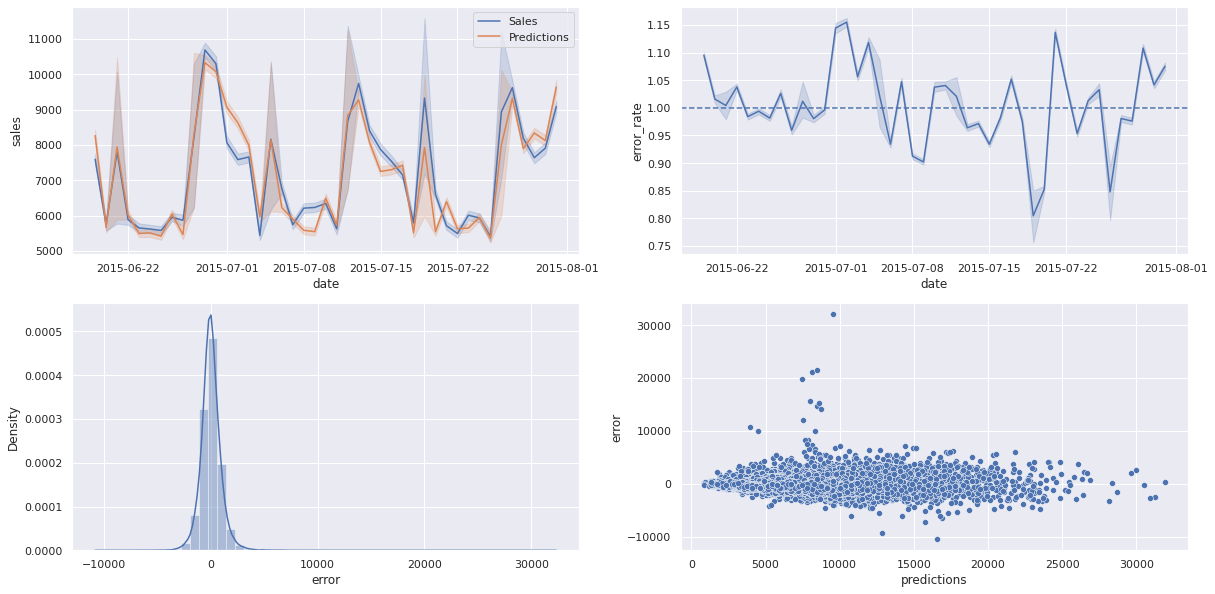

In [76]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x=df9['date'], y=df9['sales'], label='Sales')
sns.lineplot( x=df9['date'], y=df9['predictions'], label='Predictions')

plt.subplot( 2, 2, 2 )
sns.lineplot( x=df9['date'], y=df9['error_rate'] )
plt.axhline( 1, linestyle='--')
plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] );


# 10.0 API Tester

## 10.1 Rossmann Class

In [41]:
class Rossmann ( object ):
    def __init__( self ):
        state = 1
        
        self.store_type             = pickle.load( le, open('parameter/store_type' , 'rb' )  )
        self.year_scaler            = pickle.load( mms, open('parameter/year_scaler' , 'rb' )  )
        self.promo_time_week        = pickle.load( mms, open('parameter/promo_time_week' , 'rb' )  )
        self.competition_distance   = pickle.load( rs, open('parameter/competition_distance' , 'rb' )  )
        self.competition_time_month = pickle.load( rs, open('parameter/competition_time_month' , 'rb' ) )                                    

                                                
                                                
                                                
                                                
        def data_cleaning( self, df1 ):
            

            cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
                   'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']

            snakecase = lambda x: inflection.underscore( x )

            cols_new = list( map( snakecase, cols_old ) )

            df1.columns = cols_new




            df1['date'] = pd.to_datetime( df1['date'] )

            
            # competition_distance              
            df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x )

            # competition_open_since_month    
            df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'] , axis =1 )

            
            # competition_open_since_year     

            df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'] , axis =1 )

            #promo2_since_week                               
            df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'] , axis =1 )

            # promo2_since_year               
            df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'] , axis =1 )

            # promo_interval                  
            month_map = {1:  'Jan', 2:  'Feb',3:  'Mar', 4:  'Apr', 5:  'May', 6:  'Jun', 7:  'Jul', 8:  'Aug', 9:  'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'} 

            df1['promo_interval'].fillna(0 , inplace=True)

            df1['month_map'] = df1['date'].dt.month.map( month_map )

            df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x ['promo_interval'].split( ',' ) else 0 , axis = 1 )

            ## 1.6 Change Types 

            df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )

            df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

            df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
            df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

            return df1


        def feature_engineering( self, df2 ):

            #year
            df2['year'] = df2['date'].dt.year
            #month

            df2['month'] = df2['date'].dt.month
            #day
            df2['day'] = df2['date'].dt.day

            #week of year
            df2['week_of_year'] = df2['date'].dt.weekofyear

            #year week
            df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

            #competition since
            df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
            df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

            #promo since
            df2['promo_since']     = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
            df2['promo_since']     = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 )  )
            df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

            #assortment 
            df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

            #state holiday

            df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

            

            ## 3.1 Rows Filtering  

            df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]

            
            ## 3.2 Columns Filtering  

            cols_drop = ['customers', 'open', 'month_map' , 'promo_interval']
            df2 = df2.drop( cols_drop, axis=1 )
            
            
            
            return df2
            
            
            
            
            
        def data_preparation( self , df5 ):


                #Competition Distance
                df5['competition_distance'] = self.competition_distace.fit_transform( df5[['competition_distance']].values )

                #Competition Time Month
                df5['competition_time_month'] = self.competition_time_month.fit_transform( df5[['competition_time_month']].values )

                
                #Promo Time Week
                df5['promo_time_week'] = self.promo_time_week.fit_transform( df5[['promo_time_week']].values )

                #Year
                df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

                
                ## 5.3 Transformation

                ### 5.3.1 Encoding 

                #state_holiday - One Hot Encoding
                df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

                #store type - Label Encoding
                df5['store_type'] = self.store_type.fit_transform( df5['store_type'] )

                #assortment - Ordinal Encoding
                assort = {'basic': 1, 'extra':2 , 'extended':3 }
                df5['assortment'] = df5['assortment'].map( assort )

                
                
                ### 5.3.2 Response Variable 

                df5['sales'] = np.log1p( df5['sales'] )

                ### 5.3.3 Nature Transformation 

                #month
                df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x *( 2. * np.pi/12 ) ) )
                df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x *( 2. * np.pi/12 ) ) )

                
                #day
                df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x *( 2. * np.pi/30 ) ) )
                df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x *( 2. * np.pi/30 ) ) )

                #week of year'

                df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x *( 2. * np.pi/52 ) ) )
                df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x *( 2. * np.pi/52 ) ) )
                # day of week

                df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x *( 2. * np.pi/7 ) ) )
                df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x *( 2. * np.pi/7 ) ) )
                                                  
                cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']                                 
                                                  
        return df5 [ cols_selected ]
                                                  
                                                  
                                                  
                                                  
                                                  
                                                  
                                                  
                                                  
                                                  
                                                  
                                                  
                                                  

## 10.3 API Tester